In [40]:
c_from_inversecm_to_MHz = 29979.2458


location = 'DAQ'
data_folder = r'\20221029'
if location == 'laptop':
    code_path = r'D:\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\ArianJadbabaie\Code\Data_Analysis\Analysis_Code'
    #code_path = r'E:\Code\Data Analysis\Analysis_Code'
    #code_path = r'C:\Users\Arian\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\NickPilgram\Code\Data Analysis\Analysis_Code'
    path = r'D:\Dropbox (Hutzler Lab)\HutzlerLabData\Orange Beam Source\PXI Data'
    path+=data_folder
    #path = r'E:\Data\OrangeBeamBox\20200624'
elif location == 'home':
    code_path = r'C:\Users\Yuiki Takahashi\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\Yuiki Takahashi\Spinprecession\Spin_precession_try'
    path = r'C:\Users\Yuiki Takahashi\Dropbox (Hutzler Lab)\HutzlerLabData\Orange Beam Source\PXI Data'
    path+=data_folder
elif location == 'DAQ':
    code_path = r'F:\Hutzler Lab Dropbox\HutzlerLabShared\Personal\Yuiki Takahashi\Spinprecession\Spin_precession_try'
    path = r'F:\Hutzler Lab Dropbox\HutzlerLabData\Orange Beam Source\PXI Data'
    path+=data_folder
elif location == 'work':
    code_path = r'C:\Users\ajadbaba\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\ArianJadbabaie\Code\Data_Analysis\Analysis_Code'
    path = r'C:\Users\ajadbaba\Dropbox (Hutzler Lab)\HutzlerLabData\Orange Beam Source\PXI Data'
    path+=data_folder
print(path)

%matplotlib inline
import json
import ujson as uj
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.append(code_path)
#import fit_functions as f
import pathlib
import datetime
from copy import deepcopy
version = 4
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
#from joblib import Parallel, delayed
from scipy.ndimage import uniform_filter1d
import itertools
import argparse
import sys
#import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special
import csv 
from scipy.signal import butter, sosfiltfilt, sosfreqz
import bisect
#from sigfig import round
import pandas as pd
from operator import itemgetter
#import data_analysis_functions_v2 as d2
from scipy.integrate import quad
from scipy.misc import derivative as driv
from scipy.special import j0
from scipy.special import j1
from scipy.special import jv
from scipy.special import dawsn
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.integrate import cumtrapz
from random import randint
from numpy.random import choice
import scipy.stats as st
import lmfit
import matplotlib
from scipy.interpolate import interp1d
from matplotlib.backends.backend_pdf import PdfPages


F:\Hutzler Lab Dropbox\HutzlerLabData\Orange Beam Source\PXI Data\20221029


In [41]:
def get_raw_data_run(run_name,path,start = None,stop=None,save_raw = False, save_path = None,ujson=False):
    if start is None:
        start = 1
    if stop is None:
        file_nums = np.arange(start,d2.find_last_file(path,run_name))
    else:
        file_nums = np.arange(start,stop+1)
    print(run_name)
    raw_data, meta_data = d2.read_raw_data_array(file_nums,run_name,path,map_version='map',chunksize=2)
    print('Finished reading raw data')
    
    if save_raw:
        if run_name[-1] == '_':
            run_name = run_name[:-1]
        if save_path is None:
            data_file_path = 'raw_'+run_name
            meta_file_path = 'meta_'+run_name
        else:
            data_file_path = save_path+'_raw'
            meta_file_path = save_path+'_meta'
        save_json_data(raw_data,data_file_path,ujson=ujson)
        save_json_data(meta_data,meta_file_path,ujson=ujson)
    return raw_data,meta_data

def process_raw_data(raw_data,meta_data,ch_types = None,N_cmd=1,laser=None,num_avg=0, cycle_avg=False):
#     if N_cmd>1:
    all_raw_data = {}
    sorted_dict = d2.sort_by_command(raw_data,meta_data)
    for N in range(1,N_cmd+1):
        all_raw_data[N] = sorted_dict['waveform{:0>3d}'.format(N)]
    final_data = deepcopy(all_raw_data)
    for cmd_waveform in all_raw_data.keys():
        if laser is not None:
            final_data[cmd_waveform][-1] = d2.correct_freq(final_data[cmd_waveform][-1],laser=laser)
        if num_avg>0:
            final_data[cmd_waveform] = d2.average_raw_data_array(*final_data[cmd_waveform],num_avg=num_avg,cycle_avg=cycle_avg)
        final_data[cmd_waveform] = d2.process_raw_data_array(*final_data[cmd_waveform],ch_types)
#     elif N_cmd==1:
#         final_data=deepcopy([raw_data, meta_data])
#         if laser is not None:
#             final_data[-1] = d2.correct_freq(final_data[-1],laser=laser)
#         if num_avg>0:
#             final_data = d2.average_raw_data_array(*final_data,num_avg=num_avg,cycle_avg=cycle_avg)
#         final_data = d2.process_raw_data_array(*final_data,ch_types)
    return final_data

def get_json_data(file_path,numpy=False,ujson=False):
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path, 'r') as f:
        if ujson:
            data = uj.load(f)
        else:
            data = json.load(f)
    if numpy:
        data = np.array(data)
    return data

def save_json_data(data,file_path,ujson=False):
    if type(data) is np.ndarray:
        data_save = data.tolist()
    else:
        data_save=data
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path,'w') as f:
        if ujson:
            uj.dump(data_save,f)
        else:
            json.dump(data_save,f)
    print('Data saved to', file_path)
    
def smooth(y,N,sigma=0.4): #Implements a Gaussian convolution filter with N = width in indices and sigma = stdev normalized by N
    n=np.arange(N)
    gaussian = np.exp(-1/2*((n-N/2)/(sigma*N/2))**2)
    y_smooth = np.convolve(y, gaussian/gaussian.sum(), mode='valid')
    return y_smooth

def smooth_box(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def import_multiple_runs(scan_numbers,name='scan',read_existing=False):
    all_fluor = []
    all_front = []
    fluor_norm = []
    all_data = {}
    for n in scan_numbers:
        scan = '{}_{}'.format(name,n)
        if read_existing:
            raw_name = '{}_{}_raw'.format(data_folder[1:],scan)
            print(raw_name)
            meta_name = '{}_{}_meta'.format(data_folder[1:],scan)
            print(meta_name)
            raw = get_json_data(raw_name,numpy=True,ujson=True)
            meta = get_json_data(meta_name,numpy=False,ujson=True)
        else:
             raw,meta = get_raw_data_run(scan+'_',path,start = 5,stop=None,save_path=r'{}_{}'.format(data_folder[1:],scan),save_raw = True,ujson=True)
        all_data[n] = [raw,meta]
    return all_data

def analyze_data(all_data,avg=0,N_cmd=1,int_bounds=[(0.3,4.5),(0.3,6),(1.2,8)],plot=True):
    fluor_norm_b = []
    fluor_norm_u = []
    for run,data in all_data.items():
        raw,meta = data
        proc_data = process_raw_data(raw,meta,cycle_avg=False,num_avg=avg,N_cmd=N_cmd)
        print(proc_data[1][0].shape[0])
        int_data_u = d2.integrate_data_array(proc_data[1][0],proc_data[1][1],int_bounds,plot=plot)
        int_data_b = d2.integrate_data_array(*proc_data[2],int_bounds,plot=plot)
        fluor_norm_u.append([(int_data_u[2]/int_data_u[1]).mean(),(int_data_u[2]/int_data_u[1]).std()])
        fluor_norm_b.append([(int_data_b[2]/int_data_b[1]).mean(),(int_data_b[2]/int_data_b[1]).std()])
        #all_fluor.append([int_data[2].mean(),int_data[2].std()])
        #all_front.append([int_data[1].mean(),int_data[1].std()])
    return np.array(fluor_norm_u).T,np.array(fluor_norm_b).T

def sort_data(indep_var,depend_var,return_IV=True):
    #print(len(indep_var))
    #print(len(depend_var))
    if len(indep_var) != len(depend_var):
        print('Number of independent and dependent variables do not match')
    else:
        if not isinstance(indep_var,list):
            indep_var = list(indep_var)
        sorted_DV = [DV for IV,DV in sorted(zip(indep_var,depend_var))]
        if return_IV:
            sorted_IV = sorted(indep_var)
            return [np.array(sorted_IV),np.array(sorted_DV)]
        else:
            return np.array(sorted_DV)
        

def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    sos = butter(order, low, analog=False, btype='lowpass', output='sos')
    return sos

def butter_lowpass_filter(data, lowcut, fs, order=5):
    sos = butter_lowpass(lowcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

def line_func(x, a, b): 
    return x*a+b

def sine_func(t, A, w, p, c):  
    return A * np.sin(w*t + p) + c

def sine_line_func(t, A, w, p, c, a):  
    return A * np.sin(w*t + p) + t*a + c

In [ ]:
# ---- X010_173 ground state setup (from 173_prediction_Feb2026 cell 4) ----
# Ensure Energy_Levels_old is importable from repo
import pathlib
_repo = pathlib.Path().resolve()
if str(_repo) not in sys.path:
    sys.path.insert(0, str(_repo))

import Energy_Levels_old as EL
from Energy_Levels_old import MoleculeLevels

# Create X010_173 state (YbOH 173 isotope, X010 vibronic state)
X010_173 = MoleculeLevels.initialize_state(
    "YbOH", "173", "X010",
    [1, 2], M_values="all", I=[5/2, 1/2], S=1/2, round=8, P_values=[1/2, 3/2]
)
BASE_PARAMS_X010 = deepcopy(X010_173.parameters)

# Map Fitting lmfit param names (create_params_dict) to X010 param names
# Fit params are in cm^-1; X010_173 expects MHz for all frequency-like params.
FIT_TO_X010_MAP = {
    'Be': 'Be',
    'Gamma_SR': 'Gamma_SR',
    'Gamma_prime': 'Gamma_Prime',
    'bF': 'bFYb',
    'c': 'cYb',
    'q_G': 'q_lD',
    'p_G+2q_G': 'p_lD',
    'e^2Q_q0': 'e2Qq0',
    'muE': 'muE',
    'g_S_eff': 'g_S_eff',
}
# Keys that need cm^-1 -> MHz conversion when passing to X010 (all frequency-like params)
FIT_PARAMS_CM1_TO_MHZ = {'Be', 'Gamma_SR', 'Gamma_prime', 'bF', 'c', 'q_G', 'p_G+2q_G', 'e^2Q_q0'}

def set_state_parameters(state, updates=None):
    """Update state params and recompute eigensystem (from 173_prediction)."""
    if updates is None:
        updates = {}
    new_params = dict(state.parameters)
    new_params.update(updates)
    state.parameters = new_params
    state.library.parameters[state.iso_state] = new_params
    b = state.library.H_builders[state.iso_state]
    state.H_function, state.H_symbolic = b(
        state.q_numbers, params=new_params,
        M_values=state.M_values, precision=state.round,
    )
    state.eigensystem(0, 1e-8, order=True, method="torch", set_attr=True)
    state.generate_parities(state.evecs0)


# Fixed excited state structure: each row = [N, J, F, Parity, state position in energy (cm^-1)]
All_excited_states_assignments = [
    [1, 0.5, 2, 1, 17651.459810673736],
    [1, 0.5, 3, 1, 17651.468732601665],
    [1, 0.5, 2, -1, 17651.47531461785],
    [1, 0.5, 3, -1, 17651.484772843334],
    [1, 1.5, 4, -1, 17651.851058394142],
    [1, 1.5, 3, -1, 17651.860713049806],
    [1, 1.5, 4, 1, 17651.866951578595],
    [1, 1.5, 2, -1, 17651.869167705463],
    [1, 1.5, 1, -1, 17651.874367705463],
    [1, 1.5, 3, 1, 17651.87647912011],
    [1, 1.5, 2, 1, 17651.88533753238],
    [1, 1.5, 1, 1, 17651.890233326245],
    [2, 1.5, 1, -1, 17652.624167705464],
    [2, 1.5, 2, -1, 17652.6279130498],
    [2, 1.5, 3, -1, 17652.6319130498],
    [2, 1.5, 4, -1, 17652.63665839414],
    [2, 1.5, 4, 1, 17652.654017886474],
]


def compute_ground_energy(p, ground_state_dict, isotope):
    """
    Compute ground state energy (cm^-1) from fit params and ground state quantum numbers.
    Uses X010_173 (Energy_Levels_old) with params mapped from lmfit. Structure from 173_prediction cell 4.
    Unit convention: fit params (Be, Gamma_SR, etc.) are in cm^-1; X010_173 works in MHz internally.
    We convert cm^-1 -> MHz when passing to X010, then convert evals (MHz) back to cm^-1 for output.
    Args: p (lmfit params), ground_state_dict {'N','G','F','Parity'}, isotope
    Returns: energy in cm^-1 (Torg + rotational/hyperfine splitting)
    """
    if str(isotope) != '173':
        raise ValueError("compute_ground_energy with X010_173 expects isotope=173")
    ground_state_params, _, _, _ = unpack_fit_params(p)
    x010_updates = dict(BASE_PARAMS_X010)
    for fit_key, x010_key in FIT_TO_X010_MAP.items():
        if fit_key in ground_state_params:
            val = ground_state_params[fit_key]
            # Fit params are cm^-1; X010 expects MHz
            if fit_key in FIT_PARAMS_CM1_TO_MHZ:
                val = val * c_from_inversecm_to_MHz
            x010_updates[x010_key] = val

    for k in ['bFH', 'cH']:
        if k not in x010_updates and k in BASE_PARAMS_X010:
            x010_updates[k] = 0*BASE_PARAMS_X010[k]
    set_state_parameters(X010_173, x010_updates)
    evals, evecs = X010_173.evals0, X010_173.evecs0
    parities = np.array(X010_173.parities)
    indices = X010_173.select_q({'N': ground_state_dict['N']})
    if len(indices) == 0:
        raise ValueError(f"No ground state with N={ground_state_dict['N']} found")
    q = X010_173.q_numbers
    N_tgt, G_tgt, F_tgt, P_tgt = ground_state_dict['N'], ground_state_dict['G'], ground_state_dict['F'], ground_state_dict['Parity']
    # In this notebook, Assignments use F to mean F1 (as in 173_prediction). Match G->G, F->F1 exactly.
    for idx in indices:
        maxidx = np.argmax(evecs[idx]**2)
        G_val = float(np.asarray(q['G'])[maxidx])
        F1_val = float(np.asarray(q['F1'])[maxidx])  # F in Assignments = F1 in X010
        parity_val = int(np.sign(parities[idx])) if idx < len(parities) else 0
        if G_val == G_tgt and F1_val == F_tgt and parity_val == P_tgt:
            E_MHz = float(evals[idx])
            E_cm1 = E_MHz / c_from_inversecm_to_MHz
            Torg = ground_state_params.get('Torg', 0) or 0
            return E_cm1 + Torg
            
    raise ValueError(f"No ground state matching {ground_state_dict} in X010_173")


def compute_transitions(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope):
    """
    Produce predicted transitions using All_excited_states_assignments for excited state energies
    and compute_ground_energy_fn for ground state energies. No Molecular_State.
    Returns: (Transitions, frequencies_list, intensities_list)
    """
    Transitions = []
    for assignment in Assignments:
        ground_dict = assignment['ground state']
        excited_dict = assignment['excited state']
        match = None
        for row in All_excited_states_assignments:
            N_e, J_e, F_e, Parity_e = row[0], row[1], row[2], row[3]
            if (J_e == excited_dict['J'] and F_e == excited_dict['F'] 
                and Parity_e == excited_dict['Parity']):
                match = row
                break
        if match is not None:
            E_excited_cm1 = match[4]
            E_ground_cm1 = compute_ground_energy_fn(p, ground_dict, isotope)
            freq_cm1 = E_excited_cm1 - E_ground_cm1
            Transitions.append({
                'ground state': ground_dict,
                'excited state': excited_dict,
                'freq': freq_cm1
            })
    frequencies = [t['freq'] for t in Transitions]
    intensities = [1.0] * len(Transitions)
    return Transitions, frequencies, intensities


def Spectrum_residuals(Lines,Pred, uncertainty_array):
    
    res=[]
    
    n = 0
    
    
    for i in range(len(Lines)):
        found = False
        N_g_data=Lines[i]['ground state']['N']
        G_g_data=Lines[i]['ground state']['G']
        F_g_data=Lines[i]['ground state']['F']
        Parity_g_data=Lines[i]['ground state']['Parity']
        J_e_data=Lines[i]['excited state']['J']
        F_e_data=Lines[i]['excited state']['F']
        Parity_e_data=Lines[i]['excited state']['Parity']
        for j in range(len(Pred)):
            N_g_pred=Pred[j]['ground state']['N']
            G_g_pred=Pred[j]['ground state']['G']
            F_g_pred=Pred[j]['ground state']['F']
            Parity_g_pred=Pred[j]['ground state']['Parity']
            J_e_pred=Pred[j]['excited state']['J']
            F_e_pred=Pred[j]['excited state']['F']
            Parity_e_pred=Pred[j]['excited state']['Parity']
            
            if N_g_data==N_g_pred and G_g_data==G_g_pred and F_g_data==F_g_pred and Parity_g_data==Parity_g_pred and J_e_data==J_e_pred and Parity_e_data==Parity_e_pred and  F_e_data==F_e_pred:
                if uncertainty_array is None:
                    res.append(Lines[i]['freq']-Pred[j]['freq'])
                else:
                    res.append( (Lines[i]['freq']-Pred[j]['freq']) / uncertainty_array[i] )

                n += 1
                found = True
                break  # one residual per assignment
        if found:
            found = False
        else:
            print('The line cannot be found..  freq: ',Lines[i]['freq'])


                
    return res



def create_params_dict():
    
    params_dict={
        'Torg_g':['ground state','Torg','Torg'],
        'Be_g':['ground state', 'Be', 'Rotation'],
        'Gamma_SR_g':['ground state','Gamma_SR','Spin Rotation'],
        'Gamma_prime_g':['ground state','Gamma_prime','Spin Rotation gamma prime'],
        'ASO_g': ['ground_state', 'ASO','Spin Orbit'],
        'p2q_g': ['ground state','p+2q','Lambda Doubling'],
        'qG_g': ['ground state','q_G','l Doubling qG'],
        'pG2qG_g': ['ground state','p_G+2q_G','l Doubling pG plus 2qG'],
        'D_g': ['ground state','D', 'Centrifugal Distortion'],
        'GammaD_g': ['ground state','GammaD', 'Spin Rotation CD'],
        'p2qD_g': ['ground state','(p+2q)D','Lambda Doubling CD'],
        'bF_g': ['ground state','bF','Fermi Contact'],
        'c_g': ['ground state','c','HF Dipole Dipole'],
        'ew2_g' : ['ground state','ew2', 'Renner Teller'],
        'gk_g' : ['ground state','gk','Renner Teller gk'],
        'epsilonaa_g' : ['ground state','gamma g epsilon aa','Epsilon aa'],
        'pG_g': ['ground state','p_G','l Doubling pG'],
        'e2Qq0_g': ['ground state','e^2Q_q0','Quadrupole term'],
        'muE_g': ['ground state','muE','Stark effect'],
        'g_S_eff_g': ['ground state','g_S_eff','g-factor'],

        'Torg_e':['excited state','Torg','Torg'],
        'Be_e':['excited state', 'Be', 'Rotation'],
        'Gamma_SR_e':['excited state','Gamma_SR','Spin Rotation'],
        'Gamma_prime_e':['excited state','Gamma_prime','Spin Rotation gamma prime'],
        'ASO_e': ['excited state', 'ASO','Spin Orbit'],
        'p2q_e': ['excited state','p+2q','Lambda Doubling'],
        'qG_e': ['excited state','q_G','l Doubling qG'],
        'pG2qG_e': ['excited state','p_G+2q_G','l Doubling pG plus 2qG'],
        'D_e': ['excited state','D', 'Centrifugal Distortion'],
        'GammaD_e': ['excited state','GammaD', 'Spin Rotation CD'],
        'p2qD_e': ['excited state','(p+2q)D','Lambda Doubling CD'],
        'bF_e': ['excited state','bF','Fermi Contact'],
        'c_e': ['excited state','c','HF Dipole Dipole'],
        'ew2_e' : ['excited state','ew2', 'Renner Teller'],
        'gk_e' : ['excited state','gk','Renner Teller gk'],
        'a_e': ['excited state','a','HF a term'],
        'd_e': ['excited state','d','HF d term'],
        'e2Qq0_e': ['excited state','e^2Q_q0','Quadrupole term']
        
        
    }
    
    return params_dict


def create_fit_parameters(params_g,params_e):
    
    p = lmfit.Parameters()
    
    for i in params_g:
        if params_g[i][1]=='float':
            vary_val=True
        elif params_g[i][1]=='fix':
            vary_val=False
        p.add(i+'{}'.format('_g'),value=params_g[i][0],vary=vary_val)
        
    for j in params_e:
        if params_e[j][1]=='float':
            vary_val=True
        elif params_e[j][1]=='fix':
            vary_val=False
        p.add(j+'{}'.format('_e'),value=params_e[j][0],vary=vary_val)
    
    
    return p

def unpack_fit_params(p):
    
    params_dict=create_params_dict()
    
    ground_state_params={}
    ground_state_H_keys=[]
    excited_state_params={}
    excited_state_H_keys=[]
    
    for i in p.valuesdict():
        if params_dict[i][0]=='ground state':
            ground_state_params[params_dict[i][1]]=p.valuesdict()[i]
            if params_dict[i][1]!='Torg':
                ground_state_H_keys.append(params_dict[i][2])
        elif params_dict[i][0]=='excited state':
            excited_state_params[params_dict[i][1]]=p.valuesdict()[i]
            if params_dict[i][1]!='Torg':
                excited_state_H_keys.append(params_dict[i][2])
            
    return ground_state_params,ground_state_H_keys,excited_state_params,excited_state_H_keys


                                 
def spectrum_residuals_lmfit(p, Assignments, All_excited_states_assignments, Temp, uncertainty_array, isotope, TDM_type, compute_ground_energy_fn=None):
    """
    No Molecular_State. Uses All_excited_states_assignments for excited state.
    compute_ground_energy_fn(p, ground_dict, isotope) -> energy_cm1 must be provided.
    """
    if compute_ground_energy_fn is None:
        raise ValueError("compute_ground_energy_fn is required. Implement when ground state structure is provided.")
    Transitions, _, _ = compute_transitions(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope)
    return Spectrum_residuals(Assignments, Transitions, uncertainty_array)


def fit_spectrum(p, Assignments, All_excited_states_assignments, Temp, compute_ground_energy_fn, uncertainty_array = None, isotope = 174, plot_res=True, error_estimation=False, TDM_type  = 'aBJ No M Yuiki', verbose=False, fit_kws=None):
    """
    Fit spectrum parameters. Uses scipy.optimize.leastsq (Levenberg-Marquardt).
    Convergence criteria (tune via fit_kws):
      ftol (default ~1.49e-8): relative error in sum of squares
      xtol (default ~1.49e-8): relative error in solution
      gtol (default 0): orthogonality between residual and Jacobian
      maxfev: max function evaluations (default 200*(n+1))
    Fit finishes when any tolerance is met or maxfev is reached.
    """
    if uncertainty_array is not None:
        if len(Assignments) != len(uncertainty_array):
            print('The length of Assignments array must be the same as uncertainty array!')
    
    # Pre-check: need enough residuals (>= varying params) for leastsq
    n_vary = sum(1 for v in p.values() if getattr(v, 'vary', True))
    initial_res = spectrum_residuals_lmfit(p, Assignments, All_excited_states_assignments, Temp, uncertainty_array, isotope, TDM_type, compute_ground_energy_fn)
    n_res = len(initial_res)
    if n_res < n_vary:
        n_unmatched = len(Assignments) - n_res
        raise ValueError(
            f"Only {n_res} lines matched (need >= {n_vary} for {n_vary} varying parameters). "
            f"{n_unmatched} assignment(s) have no matching excited state in All_excited_states_assignments. "
            "Check that each assignment's excited state (J, F, Parity) exists in All_excited_states_assignments, "
            "or add more Assignments, or fix some parameters."
        )
    
    fcn_args = (Assignments, All_excited_states_assignments, Temp, uncertainty_array, isotope, TDM_type, compute_ground_energy_fn)
    
    def _iter_cb(params, n_iter, resid, *args, **kws):
        nv = sum(1 for v in params.values() if getattr(v, 'vary', True))
        chisqr = np.sum(np.asarray(resid)**2)
        nfree = len(resid) - nv
        redchi = chisqr / nfree if nfree > 0 else np.nan
        vals = {k: v.value for k, v in params.items() if getattr(v, 'vary', True)}
        print(f"  iter {n_iter}: chisqr={chisqr:.4g} redchi={redchi:.4g} params={vals}")
    
    iter_cb = _iter_cb if verbose else None
    mini = lmfit.Minimizer(spectrum_residuals_lmfit, p, fcn_args=fcn_args, nan_policy='omit', iter_cb=iter_cb)
    kws = dict(fit_kws or {})
    result = mini.minimize(method='leastsq', **kws)

    print(lmfit.report_fit(result.params))
    print('')
    print('reduced chi squared: ', result.redchi)
    
    if error_estimation==True:

        ci, trace = lmfit.conf_interval(mini, result, sigmas=[1, 2], trace=True, verbose=False)
        print(lmfit.printfuncs.report_ci(ci))
        
    post_fit_res = spectrum_residuals_lmfit(result.params, Assignments, All_excited_states_assignments, Temp, None, isotope, TDM_type, compute_ground_energy_fn)
        
    if plot_res==True:
        plt.figure(1,figsize=(15,8))
        plt.clf()  # clear figure so we don't accumulate plots from previous runs
        zero_plot=np.zeros(len(Assignments))
        plt.plot(spectrum_residuals_lmfit(p, Assignments, All_excited_states_assignments, Temp, None, isotope, TDM_type, compute_ground_energy_fn),'o',label='before fit')
        plt.plot(post_fit_res,'s',label='after fit')
        plt.plot(zero_plot)
        plt.title('Residuals',fontsize=18)
        plt.legend(loc='best')
        plt.show()

    print('fit residuals standard deviation',np.std(post_fit_res))
    
    return result


def examine_residuals(p, Assignments, All_excited_states_assignments, Temp, compute_ground_energy_fn, print_output=True, isotope = 174, TDM_type = 'aBJ No M Chi'):
    
    spec_pred, _, _ = compute_transitions(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope)
    
    res_data=[]
    
    for i in range(len(Assignments)):
        N_g_data=Assignments[i]['ground state']['N']
        G_g_data=Assignments[i]['ground state']['G']
        F_g_data=Assignments[i]['ground state']['F']
        Parity_g_data=Assignments[i]['ground state']['Parity']
        J_e_data=Assignments[i]['excited state']['J']
        F_e_data=Assignments[i]['excited state']['F']        
        #P_e_data=Assignments[i]['excited state']['P']
        Parity_e_data=Assignments[i]['excited state']['Parity']
        for j in range(len(spec_pred)):
            N_g_pred=spec_pred[j]['ground state']['N']
            G_g_pred=spec_pred[j]['ground state']['G']
            F_g_pred=spec_pred[j]['ground state']['F']
            Parity_g_pred=spec_pred[j]['ground state']['Parity']
            J_e_pred=spec_pred[j]['excited state']['J']
            #P_e_pred=spec_pred[j]['excited state']['P']
            F_e_pred=spec_pred[j]['excited state']['F']
            Parity_e_pred=spec_pred[j]['excited state']['Parity']
            
            if N_g_data==N_g_pred and Parity_g_data==Parity_g_pred and J_e_data==J_e_pred and Parity_e_data==Parity_e_pred and G_g_data==G_g_pred and F_g_data==F_g_pred and  F_e_data==F_e_pred:
                res_data.append({'Line':Assignments[i]['freq'], 'Pred':spec_pred[j]['freq'],
                                 'Residual':Assignments[i]['freq']-spec_pred[j]['freq'],
                                 'ground state':Assignments[i]['ground state'],
                                 'excited state':Assignments[i]['excited state']})
    
    if print_output==True:
        for k in range(len(res_data)):
            print(res_data[k])
            print('\n')
    
    return res_data




def predict_FM_spectrum(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, theta, width, freq_range, isotope=174):
    """No Molecular_State. Uses compute_transitions."""
    Transitions, frequencies, intensities = compute_transitions(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope)
    centers = [f for f in frequencies if freq_range[0] < f < freq_range[1]]
    heights = [intensities[i] for i, f in enumerate(frequencies) if freq_range[0] < f < freq_range[1]]
    widths = [width] * len(centers)
    w = np.arange(freq_range[0], freq_range[1], 0.00005)
    I = I_FM(w, centers, widths, heights, theta)
    Q = Q_FM(w, centers, widths, heights, theta)
    return w, I, Q

def predict_Gaussian_spectrum(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, width, freq_range, isotope=174):
    """No Molecular_State. Uses compute_transitions."""
    Transitions, frequencies, intensities = compute_transitions(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope)
    centers = [f for f in frequencies if freq_range[0] < f < freq_range[1]]
    heights = [intensities[i] for i, f in enumerate(frequencies) if freq_range[0] < f < freq_range[1]]
    widths = [width] * len(centers)
    w = np.arange(freq_range[0], freq_range[1], 0.00005)
    pred = mult_gaussian(w, centers, widths, heights)
    return w, pred


def gaussian(w,w0,Gamma,amp):
    return amp*np.exp((-1)*((w-w0)**2)/(2*((Gamma/2.355)**2)))

def mult_gaussian(w,w0,Gamma,amp):
    out=0
    for i in range(len(w0)):
        out=out+gaussian(w,w0[i],Gamma[i],amp[i])
    return out

def gaussian_dispersion(w,w0,Gamma,amp):
    return (-2/np.sqrt(np.pi))*amp*dawsn((w-w0)/(np.sqrt(2)*(Gamma/2.355)))

def mult_gaussian_dispersion(w,w0,Gamma,amp):
    out=0
    for i in range(len(w0)):
        out=out+gaussian_dispersion(w,w0[i],Gamma[i],amp[i])
    return out


wm=50.3*(3.34*10**(-5)) #cm^-1
M=0.84

def A_FM_2nd_order(w,w0,Gamma,amp):
    return ((j0(M)*j1(M)*(mult_gaussian(w-wm,w0,Gamma,amp)-mult_gaussian(w+wm,w0,Gamma,amp)))+
            (j1(M)*jv(2,M)*(mult_gaussian(w-2*wm,w0,Gamma,amp)-mult_gaussian(w+2*wm,w0,Gamma,amp)+
                            mult_gaussian(w-wm,w0,Gamma,amp)-mult_gaussian(w+wm,w0,Gamma,amp))))

def D_FM_2nd_order(w,w0,Gamma,amp):
    return ((j0(M)*j1(M)*(mult_gaussian_dispersion(w-wm,w0,Gamma,amp)+mult_gaussian_dispersion(w+wm,w0,Gamma,amp)-
                          2*mult_gaussian_dispersion(w,w0,Gamma,amp)))+
            (j1(M)*jv(2,M)*(mult_gaussian_dispersion(w-2*wm,w0,Gamma,amp)+mult_gaussian_dispersion(w+2*wm,w0,Gamma,amp)-
                           mult_gaussian_dispersion(w-wm,w0,Gamma,amp)-mult_gaussian_dispersion(w+wm,w0,Gamma,amp))))


# def I_FM(w,w0,Gamma,amp,theta,offset):
#     return np.cos(theta)*A_FM_2nd_order(w,w0,Gamma,amp)+np.sin(theta)*D_FM_2nd_order(w,w0,Gamma,amp)+offset

# def Q_FM(w,w0,Gamma,amp,theta,offset):
#     return np.sin(theta)*A_FM_2nd_order(w,w0,Gamma,amp)-np.cos(theta)*D_FM_2nd_order(w,w0,Gamma,amp)+offset


def I_FM(w,w0,Gamma,amp,theta):
    return np.cos(theta)*A_FM_2nd_order(w,w0,Gamma,amp)+np.sin(theta)*D_FM_2nd_order(w,w0,Gamma,amp)

def Q_FM(w,w0,Gamma,amp,theta):
    return np.sin(theta)*A_FM_2nd_order(w,w0,Gamma,amp)-np.cos(theta)*D_FM_2nd_order(w,w0,Gamma,amp)


                   

In [105]:
#global_Lorentzian_mode = False

def Set_Lorentzian_mode(Lorentzian_mode):
    global global_Lorentzian_mode
    global_Lorentzian_mode = Lorentzian_mode

    
# Note that Gamma here is a FWHM of lineshape!

def gaussian(w,w0,Gamma,amp):
    Lorentzian_mode = global_Lorentzian_mode
    if Lorentzian_mode:
        return amp * (Gamma/2)**2 / ( (Gamma/2)**2 + ( w - w0 )**2)
    else:
        return amp*np.exp((-1)*((w-w0)**2)/(2*((Gamma/2.355)**2)))

def mult_gaussian(w,w0,Gamma,amp):
    out=0
    for i in range(len(w0)):
        out=out+gaussian(w,w0[i],Gamma[i],amp[i],)
    return out

def Gaussian_forfit_lmfit(w,p):

    parvals = p.valuesdict()

    N=len(p)

    centers=np.zeros(int(N/3))
    widths=np.zeros(int(N/3))
    heights=np.zeros(int(N/3))
    for i in range(int(N/3)):
        centers[i]=parvals['center{}'.format(i)]
        widths[i]=parvals['width{}'.format(i)]
        heights[i]=parvals['height{}'.format(i)]

    return mult_gaussian(w,centers,widths,heights)

def Gaussian_res_lmfit(p,w,data):


    res=np.zeros(len(w))

    for i in range(len(w)):
        res[i] = Gaussian_forfit_lmfit(w[i],p)-data[i]


    return res



def Gaussian_fit_lmfit(p,w,data,plot=True,error_estimation=False):

    freq_low=w[int(len(w)/10)]
    freq_high=w[len(w)-int(len(w)/10)]
    if freq_high>freq_low:
        w0=w[0]
    else:
        w0=w[len(w)-1]


    w2=w-w0

    mini = lmfit.Minimizer(Gaussian_res_lmfit, p, fcn_args=(w2, data),nan_policy='omit')

    result = mini.minimize(method='leastsq')

    print(lmfit.report_fit(result.params))

    if error_estimation==True:

        ci, trace = lmfit.conf_interval(mini, result, sigmas=[1, 2], trace=True, verbose=False)
        print(lmfit.printfuncs.report_ci(ci))

    fit_values = result.params.valuesdict()

    if plot==True:
        plt.figure(1,figsize=(15,8))
        plt.plot(w2,data)
        plt.plot(w2,Gaussian_forfit_lmfit(w2,result.params))
        plt.title('Data',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)



        plot_zero=np.zeros(len(w2))

        plt.figure(3,figsize=(15,8))
        plt.plot(w2,Gaussian_forfit_lmfit(w2,result.params)-data,'o')
        plt.plot(w2,plot_zero)
        plt.title('Data Residuals',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)


    N=len(fit_values)
    centers={}
    for i in range(int(N/3)):
        centers['true_center{}'.format(i)]=fit_values['center{}'.format(i)]+w0
        centers['error{}'.format(i)]=result.params['center{}'.format(i)].stderr
        centers['width{}'.format(i)]=result.params['width{}'.format(i)].value


    print(centers)



    return result,centers



def Gaussian_fit_lmfit_yuiki(p, p1, width_bound_sigma, w, data, plot=True, error_estimation=False, freq_lim = None, background_subtract = False, Lorentzian_mode = False, print_fit_properties = True):

    Set_Lorentzian_mode(Lorentzian_mode)
    
    freq_low=w[int(len(w)/10)]
    freq_high=w[len(w)-int(len(w)/10)]
    if freq_high>freq_low:
        w0=w[0]
    else:
        w0=w[len(w)-1]

    w2=w-w0
    
    fit_centers = np.zeros(len(p1))
    fit_widths = np.zeros(len(p1))
    fit_heights = np.zeros(len(p1))
    caution_centers = []
    
    if background_subtract is not False:
        remove_index_for_background = [i for i , element in enumerate(w) if element > background_subtract[0] and element < background_subtract[1]]
        data_for_background = [element for i , element in enumerate(data) if i in remove_index_for_background]
        background = np.average(data_for_background)
        data -= background
    
    for a in range(len(p1)):
        if a+1 < len(p1):
            if p1[a][1] > p[a+1, 0, 0]:
                print('CAUTION! The peaks at ',  p[a, 0, 0]+w0, ' and',  p[a+1, 0, 0]+w0, ' cm-1 are within ', width_bound_sigma, ' sigma of the peak width (i.e. they are too close) and thus the peak fitting may not work! Do peak fitting manually for this region')
                caution_centers.append([p[a, 0, 0]+w0, p[a+1, 0, 0]+w0])
           
        remove_index = [i for i , element in enumerate(w2) if element > p1[a][0] and element < p1[a][1]]
        w2_small = [element for i , element in enumerate(w2) if i in remove_index]
        data_small = [element for i , element in enumerate(data) if i in remove_index]
                
        scale = 1.
        w2_small = scale*np.array(w2_small)
        p[a,0] *= scale
        p[a,1] *= scale
        
        
        para = lmfit.Parameters()
        para.add('center{}'.format(0),value=p[a,0,0],min=p[a,0,1],max=p[a,0,2])   #min=min(w)-w0,max=max(w)-w0)
        #x0[int(N/3)+1+i]=widths
        para.add('width{}'.format(0),value=p[a,1,0],min=p[a,1,1],max=p[a,1,2])
        #x0[int(2*N/3)+1+i]=I_data_smooth[peaks[i]]
        para.add('height{}'.format(0),value=p[a,2,0],min=p[a,2,1],max=p[a,2,2])
        

        mini = lmfit.Minimizer(Gaussian_res_lmfit, para, fcn_args=(w2_small, data_small),nan_policy='omit')
        result = mini.minimize(method='leastsq')
        if print_fit_properties:
            print(lmfit.report_fit(result.params))
        fit_values = result.params.valuesdict()
        fit_centers[a]=fit_values['center{}'.format(0)]/scale
        fit_widths[a]=fit_values['width{}'.format(0)]/scale
        fit_heights[a]=fit_values['height{}'.format(0)]
        p[a,0] /= scale
        p[a,1] /= scale
        
    if error_estimation==True:

        ci, trace = lmfit.conf_interval(mini, result, sigmas=[1, 2], trace=True, verbose=False)
        print(lmfit.printfuncs.report_ci(ci))

    #fit_values = result.params.valuesdict()

    if plot==True:
        plt.figure(1,figsize=(15,8))
        plt.plot(w,data)
        plt.plot(w,mult_gaussian(w2,fit_centers,fit_widths,fit_heights))
        plt.title('Data',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)
        if freq_lim is not None:
            plt.xlim(freq_lim[0],freq_lim[1])



        plot_zero=np.zeros(len(w2))

        plt.figure(3,figsize=(15,8))
        plt.plot(w,mult_gaussian(w2,fit_centers,fit_widths,fit_heights)-data,'o')
        plt.plot(w,plot_zero)
        plt.title('Data Residuals',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)
        if freq_lim is not None:
            plt.xlim(freq_lim[0],freq_lim[1])
            
    print(fit_centers)





    return fit_centers+w0, fit_widths, fit_heights, caution_centers




def Gaussian_fit_lmfit_yuiki2(p, p1, width_bound_sigma, w, data, plot=True, error_estimation=False, freq_lim = None, background_subtract = False, Lorentzian_mode = False, print_fit_properties = True):

    Set_Lorentzian_mode(Lorentzian_mode)
    
    freq_low=w[int(len(w)/10)]
    freq_high=w[len(w)-int(len(w)/10)]
    if freq_high>freq_low:
        w0=w[0]
    else:
        w0=w[len(w)-1]

    w2=w-w0
    
    peaks_identified = [p[:,0,0]+w0,p[:,2,0]]
    
    if background_subtract is not False:
        remove_index_for_background = [i for i , element in enumerate(w) if element > background_subtract[0] and element < background_subtract[1]]
        data_for_background = [element for i , element in enumerate(data) if i in remove_index_for_background]
        background = np.average(data_for_background)
        data -= background
    
    fit_centers = np.zeros(len(p1))
    fit_widths = np.zeros(len(p1))
    fit_heights = np.zeros(len(p1))
    fit_errors = np.zeros(len(p1))
    caution_centers = []
    already_fit_peaks = []
    cut_regions = []
    
    for a in range(len(p1)):

        
        if a in already_fit_peaks:
            already_fit = True
        else:
            already_fit = False
            already_fit_peaks = [a]
            
        if already_fit is False:
            upper_bound = p1[a][1]
            lower_bound = p1[a][0]
        
            if a+1 < len(p1):
                if p1[a][1] > p1[a+1][0]:
                    upper_bound = p1[a+1][1]
                    already_fit_peaks.append(a+1)
                    
                    if a+2 < len(p1):
                        if p1[a+1][1] > p1[a+2][0]:
                            upper_bound = p1[a+2][1]
                            already_fit_peaks.append(a+2)
                            
                            if a+3 < len(p1):
                                if p1[a+2][1] > p1[a+3][0]:
                                    upper_bound = p1[a+3][1]
                                    already_fit_peaks.append(a+3)
                                    
                                    if a+4 < len(p1):
                                        if p1[a+3][1] > p1[a+4][0]:
                                            upper_bound = p1[a+4][1]
                                            already_fit_peaks.append(a+4)
                                            
                                            if a+5 < len(p1):
                                                if p1[a+4][1] > p1[a+5][0]:
                                                    upper_bound = p1[a+5][1]
                                                    already_fit_peaks.append(a+5)
                                                    
                                                    if a+6 < len(p1):
                                                        if p1[a+5][1] > p1[a+6][0]:
                                                            upper_bound = p1[a+6][1]
                                                            already_fit_peaks.append(a+6)  
                                                            
                                                            if a+7 < len(p1):
                                                                if p1[a+6][1] > p1[a+7][0]:
                                                                    upper_bound = p1[a+7][1]
                                                                    already_fit_peaks.append(a+7)
                                                                    
                                                                    if a+8 < len(p1):
                                                                        if p1[a+7][1] > p1[a+8][0]:
                                                                            upper_bound = p1[a+8][1]
                                                                            already_fit_peaks.append(a+8)
                                                                            
                                                                            if a+9 < len(p1):
                                                                                if p1[a+8][1] > p1[a+9][0]:
                                                                                    upper_bound = p1[a+9][1]
                                                                                    already_fit_peaks.append(a+9)
                                                                                    
                                                                                    if a+10 < len(p1):
                                                                                        if p1[a+9][1] > p1[a+10][0]:
                                                                                            print('>10 peaks are too close within', width_bound_sigma, 'sigma of the peak width (i.e. very congested) Do peak fitting manually for this region')
                                                                                            caution_centers.append([p[a, 0, 0]+w0, p[a+1, 0, 0]+w0, p[a+2, 0, 0]+w0, p[a+3, 0, 0]+w0, p[a+4, 0, 0]+w0, p[a+5, 0, 0]+w0, p[a+6, 0, 0]+w0, p[a+7, 0, 0]+w0, p[a+8, 0, 0]+w0, p[a+9, 0, 0]+w0, p[a+10, 0, 0]+w0])
                                                    

            remove_index = [i for i , element in enumerate(w2) if element > lower_bound and element < upper_bound]
            w2_small = [element for i , element in enumerate(w2) if i in remove_index]
            data_small = [element for i , element in enumerate(data) if i in remove_index]

            para = lmfit.Parameters()
            
            ii = 0
            for b in already_fit_peaks:
                para.add('center{}'.format(ii),value=p[b,0,0],min=p[b,0,1],max=p[b,0,2])   #min=min(w)-w0,max=max(w)-w0)
                #x0[int(N/3)+1+i]=widths
                para.add('width{}'.format(ii),value=p[b,1,0],min=p[b,1,1],max=p[b,1,2])
                #x0[int(2*N/3)+1+i]=I_data_smooth[peaks[i]]
                para.add('height{}'.format(ii),value=p[b,2,0],min=p[b,2,1],max=p[b,2,2])
                ii += 1


            mini = lmfit.Minimizer(Gaussian_res_lmfit, para, fcn_args=(w2_small, data_small),nan_policy='omit')

            result = mini.minimize(method='leastsq')
            if print_fit_properties:
                print(lmfit.report_fit(result.params))
                
            iii = 0
            for b in already_fit_peaks:
                fit_values = result.params.valuesdict()
                fit_centers[b]=fit_values['center{}'.format(iii)]
                fit_widths[b]=fit_values['width{}'.format(iii)]
                fit_heights[b]=fit_values['height{}'.format(iii)]
                fit_errors[b]=result.params['center{}'.format(iii)].stderr
                iii += 1
                
            cut_regions.append([lower_bound+w0, upper_bound+w0, len(already_fit_peaks)])
        
    if error_estimation==True:

        ci, trace = lmfit.conf_interval(mini, result, sigmas=[1, 2], trace=True, verbose=False)
        print(lmfit.printfuncs.report_ci(ci))

    #fit_values = result.params.valuesdict()

    if plot==True:
        plt.figure(1,figsize=(15,8))
        plt.plot(w,data)
        plt.plot(w,mult_gaussian(w2,fit_centers,fit_widths,fit_heights))
        plt.title('Data',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)
        if freq_lim is not None:
            plt.xlim(freq_lim[0],freq_lim[1])



        plot_zero=np.zeros(len(w2))

        plt.figure(3,figsize=(15,8))
        plt.plot(w,mult_gaussian(w2,fit_centers,fit_widths,fit_heights)-data,'o')
        plt.plot(w,plot_zero)
        plt.title('Data Residuals',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)
        if freq_lim is not None:
            plt.xlim(freq_lim[0],freq_lim[1])
            
    #print(fit_centers)





    return fit_centers+w0, fit_widths, fit_heights, cut_regions, peaks_identified, caution_centers, fit_errors

In [106]:
def find_peaks_2(data,freq_data,threshold,data_range=[],add_peak=None):

    font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13.75}

    matplotlib.rc('font', **font)

    freq_low=freq_data[int(len(freq_data)/10)]
    freq_high=freq_data[len(freq_data)-int(len(freq_data)/10)]
    if freq_high>freq_low:
        print('Frequency low to high')
    else:
        print('Frequency high to low')

    if len(data_range)==0:
        k = np.arange(0,len(data),1)
        a_nosmooth=np.array(data)
    else:
        k = np.arange(data_range[0],data_range[1],1)
        a_nosmooth=np.array(data[data_range[0]:data_range[1]])

    a_nosmooth = a_nosmooth * 100.0 / max(a_nosmooth)

    cs=interp1d(k,a_nosmooth)

    if len(data_range)==0:
        new_k=np.arange(0,len(data)-1,0.1)
    else:
        new_k = np.arange(data_range[0],data_range[1]-1,0.1)

    a = cs(new_k)

    # plt.figure(1,figsize=(15,8))
    # plt.plot(k,a_nosmooth)
    # plt.plot(new_k,a,'o')

    da = np.gradient(a)
    dda = np.gradient(da)

    peaks = []

    for i in range(len(a)-1):
        if da[i]>0 and da[i+1]<0 and dda[i] < 0 and a[i]>threshold:
            peaks.append(int(np.round(new_k[i])))

    if add_peak != None:
        for iii in range(len(add_peak)):
            peaks.append(add_peak[iii])

    peaks.sort()


    fig, ax = plt.subplots(figsize=(26, 13),dpi=150)
    matplotlib.rcParams.update({'font.size': 18})
    matplotlib.rcParams.update({'font.family': 'serif'})

    ax.plot(k, a_nosmooth)

    if len(data_range)==0:
        data_start=0
    else:
        data_start=data_range[0]
    plotline(peaks,k,a_nosmooth,ax,data_start)

    ax.grid(True)
    #ax.set_ylim([-5, 105])
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(.01))
    plt.show()

    return peaks


def plotline(peaks,k,a,ax,data_start):
    for i in range(len(peaks)):
#
        ax.vlines(peaks[i], 0, a[peaks[i]-data_start]+5, linestyle='-')
        ax.text(peaks[i]-.001,
                a[peaks[i]-data_start]+8, str(peaks[i]),
                fontsize=14, rotation=90, va='bottom')
        ax.text(peaks[i]-.001,
                -5, 'a'+str(i),
                fontsize=14, rotation=90)

def avg_mult(func,num_avg):
    if num_avg == 0:
        return func
    else:
        i = num_avg
        avg = avg_func(func)
        i-=1
        while i !=0:
            avg = avg_func(avg)
            i-=1
    return avg


def avg_func(func):
    avg = np.zeros(len(func))
    for i in range(len(func)):
        if i == 0:
            avg[i] = (func[i]+func[i+1])/2
        if i == len(func)-1:
            avg[i] = (func[i]+func[i-1])/2
        else:
            avg[i] = (func[i-1]+func[i]+func[i+1])/3
    return avg


def Find_Gaussian_initial_guess_lmfit(w,data,widths,Box=10,threshold=0.1,add_peak=None,width_bound_sigma=5):

    freq_low=w[int(len(w)/10)]
    freq_high=w[len(w)-int(len(w)/10)]
    if freq_high>freq_low:
        w0=w[0]
    else:
        w0=w[len(w)-1]

    data_smooth=avg_mult(data,Box)

    data_plot=data_smooth





    peaks=find_peaks_2(data_plot,w,threshold,add_peak=add_peak)
    #peaks=find_peaks_2(Int_Idata,w,threshold*100,add_peak=add_peak)

    print('Number of peaks',len(peaks))

    N=3*len(peaks)

    p = np.zeros((len(peaks),3,3))
    p1 = []
    
    for i in range(len(peaks)):
        
        p[i,0,0] = w[peaks[i]]-w0
        p[i,0,1] = w[peaks[i]]-w0-2*widths
        p[i,0,2] = w[peaks[i]]-w0+2*widths
        
        p[i,1,0] = widths
        p[i,1,1] = 0.25*widths
        p[i,1,2] = 5*widths
        
        p[i,2,0] = abs(data_plot[peaks[i]])
        p[i,2,1] = 0.25*abs(data_plot[peaks[i]])
        p[i,2,2] = 6*abs(data_plot[peaks[i]])

        p1.append([w[peaks[i]]-w0-width_bound_sigma*widths, w[peaks[i]]-w0+width_bound_sigma*widths])

#     weight=max(Q_data)/max(I_data)
#     print('Weight',weight)

    #p.pretty_print()


    return p, p1, width_bound_sigma

In [107]:
def moving_average(y, window):
    """
    Simple moving average with NaN-safe behavior.
    Returns array of same length as y (centered window).
    """
    y = np.asarray(y, dtype=float)
    if window is None or window <= 1:
        return y

    # centered rolling mean; edges become NaN -> we fill by nearest valid value
    s = pd.Series(y)
    y_sm = s.rolling(window=window, center=True, min_periods=1).mean().to_numpy()
    return y_sm

In [115]:
#%matplotlib widget
%matplotlib inline

Loaded 15 Assignments from assignments_field_free_173.json


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=0.02079 redchi=0.001485 params={'Torg_g': 319.954507}
  iter 0: chisqr=0.02079 redchi=0.001485 params={'Torg_g': 319.954507}
  iter 1: chisqr=0.02079 redchi=0.001485 params={'Torg_g': 319.954507}
  iter 2: chisqr=0.02451 redchi=0.001751 params={'Torg_g': 319.95770654507}
  iter 3: chisqr=1.79e-06 redchi=1.278e-07 params={'Torg_g': 319.9172816058835}
  iter 3: chisqr=1.79e-06 redchi=1.278e-07 params={'Torg_g': 319.9172816058835}
[[Variables]]
    Torg_g:      319.917282 +/- 9.2321e-05 (0.00%) (init = 319.9545)
    Be_g:        0.2446402 (fixed)
    Gamma_SR_g: -0.00291035 (fixed)
    qG_g:        0.00041754 (fixed)
    pG2qG_g:     0.00043419 (fixed)
    bF_g:       -0.06274157 (fixed)
    c_g:        -0.00307411 (fixed)
    e2Qq0_g:    -0.1052128 (fixed)
    muE_g:       1.08737 (fixed)
    g_S_eff_g:   2.07 (fixed)
None

reduced chi squared:  1.2784691253239448e-07


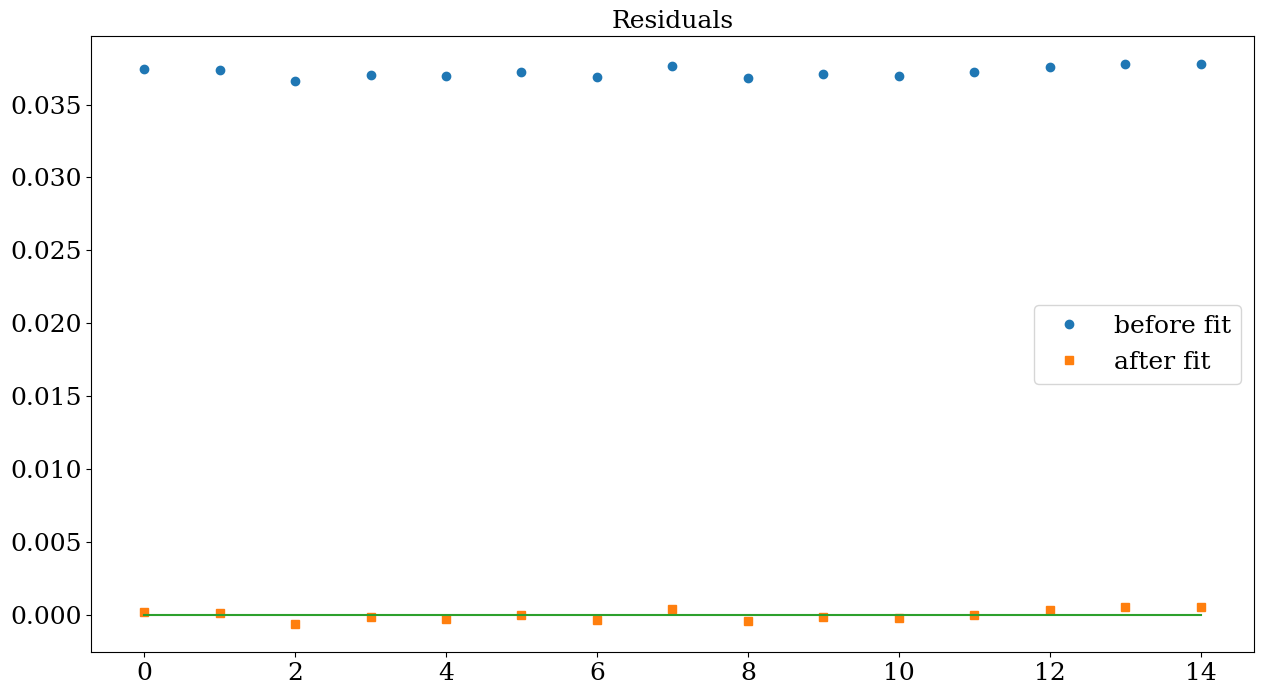

fit residuals standard deviation 0.00034543275037297037


In [118]:
# 1. Assignments (observed data) - load from field-free spectroscopy
# Excited states must exist in All_excited_states_assignments (J=0.5 or 1.5 only).
# Need >= 8 lines for 8 varying parameters.
with open('assignments_field_free_173.json', 'r') as f:
    Assignments = json.load(f)
print(f'Loaded {len(Assignments)} Assignments from assignments_field_free_173.json')

# 2. Fit parameters (ground state only - excited states from All_excited_states_assignments)
params_g = {
    'Torg': [319.954507 , 'float'],
    'Be': [0.24464015, 'fix'],
    'Gamma_SR': [-0.00291035, 'fix'],
    'qG': [4.1754e-04, 'fix'],
    'pG2qG': [4.3419e-04, 'fix'],
    'bF': [-0.06274157, 'fix'],
    'c': [-0.00307411, 'fix'],
    'e2Qq0': [-3154.2/c_from_inversecm_to_MHz, 'fix'],
    'muE': [2.16*0.503412, 'fix'],
    'g_S_eff': [2.07, 'fix'],
}

params_e = {}  # minimal

# 3. Create & fit
p = create_fit_parameters(params_g, params_e)


result = fit_spectrum(
    p, Assignments, All_excited_states_assignments, 4,
    compute_ground_energy_fn=compute_ground_energy,
    isotope=173, verbose=True, fit_kws={'ftol': 1e-3, 'xtol': 1e-3, 'maxfev': 100}, plot_res=True)

--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=9.432e-07 redchi=6.737e-08 params={'e2Qq0_g': -0.1080487}
  iter 0: chisqr=9.432e-07 redchi=6.737e-08 params={'e2Qq0_g': -0.1080487}
  iter 1: chisqr=9.432e-07 redchi=6.737e-08 params={'e2Qq0_g': -0.1080487}
  iter 2: chisqr=9.432e-07 redchi=6.737e-08 params={'e2Qq0_g': -0.108047619513}
  iter 3: chisqr=9.42e-07 redchi=6.728e-08 params={'e2Qq0_g': -0.1081978003030775}
  iter 4: chisqr=9.42e-07 redchi=6.728e-08 params={'e2Qq0_g': -0.10819671832507448}
  iter 5: chisqr=9.42e-07 redchi=6.728e-08 params={'e2Qq0_g': -0.10819782175203908}
  iter 5: chisqr=9.42e-07 redchi=6.728e-08 params={'e2Qq0_g': -0.10819782175203908}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.0021379 (fixed)
    Gamma_prime_g:  0.00047479 (fixed)
    qG_g:           0.00041754 (fixed)
    pG2qG_g:        0.00043419 (fixed)
    bF_g:          -0.06280159 (fixed)
    c_g:           -0.00268016 (fixed)
    e2Qq0_g:       -0.10819782 +/- 0.

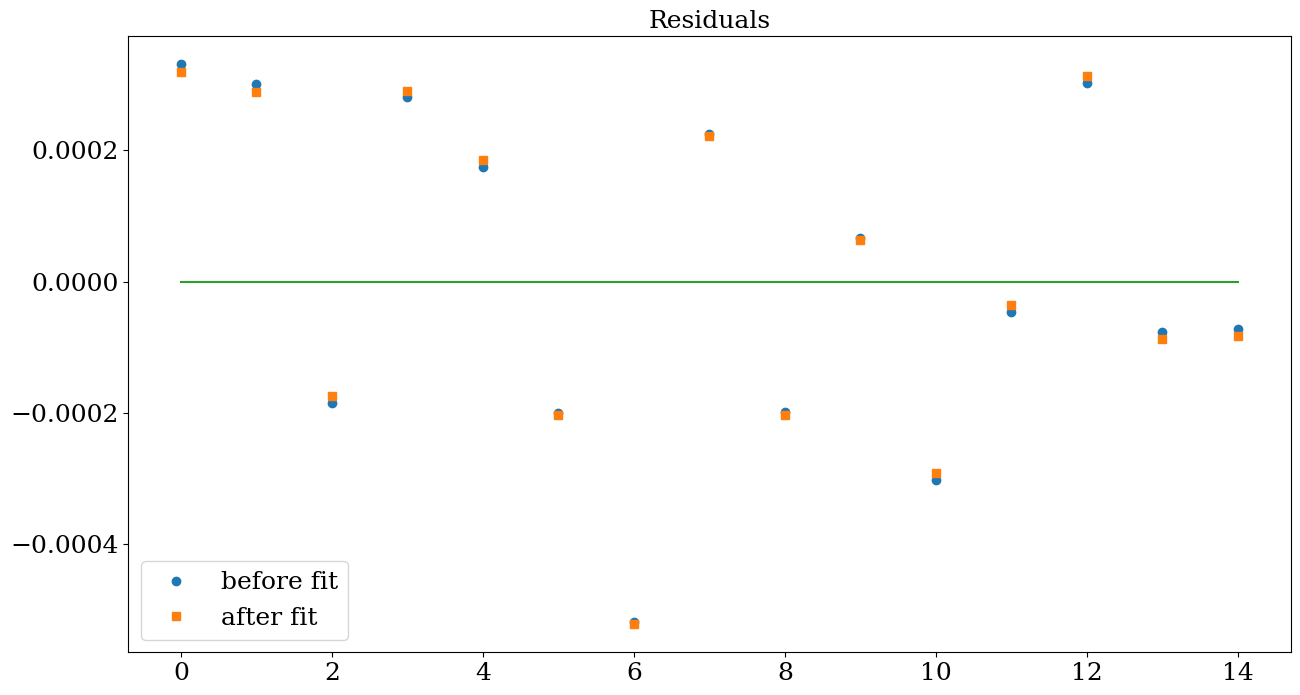

fit residuals standard deviation 0.00025053768738243586
  Residual std: 2.51e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=9.42e-07 redchi=6.728e-08 params={'c_g': -0.00268016}
  iter 0: chisqr=9.42e-07 redchi=6.728e-08 params={'c_g': -0.00268016}
  iter 1: chisqr=9.42e-07 redchi=6.728e-08 params={'c_g': -0.00268016}
  iter 2: chisqr=9.42e-07 redchi=6.728e-08 params={'c_g': -0.0026801331984}
  iter 3: chisqr=9.282e-07 redchi=6.63e-08 params={'c_g': -0.002491248913097541}
  iter 4: chisqr=9.282e-07 redchi=6.63e-08 params={'c_g': -0.00249122400060841}
  iter 5: chisqr=9.282e-07 redchi=6.63e-08 params={'c_g': -0.0024913465680953886}
  iter 5: chisqr=9.282e-07 redchi=6.63e-08 params={'c_g': -0.0024913465680953886}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.0021379 (fixed)
    Gamma_prime_g:  0.00047479 (fixed)
    qG_g:           0.00041754 (fixed)
    pG2qG_g:        0.00043419 (fixed)
    bF_g:          -0.06280159 (fixed)
    c_g:           -0.00249135 +/- 4.1436e-04 (16.63%) (init = -0.00268016)
    e2Qq0_g:       -0.1081

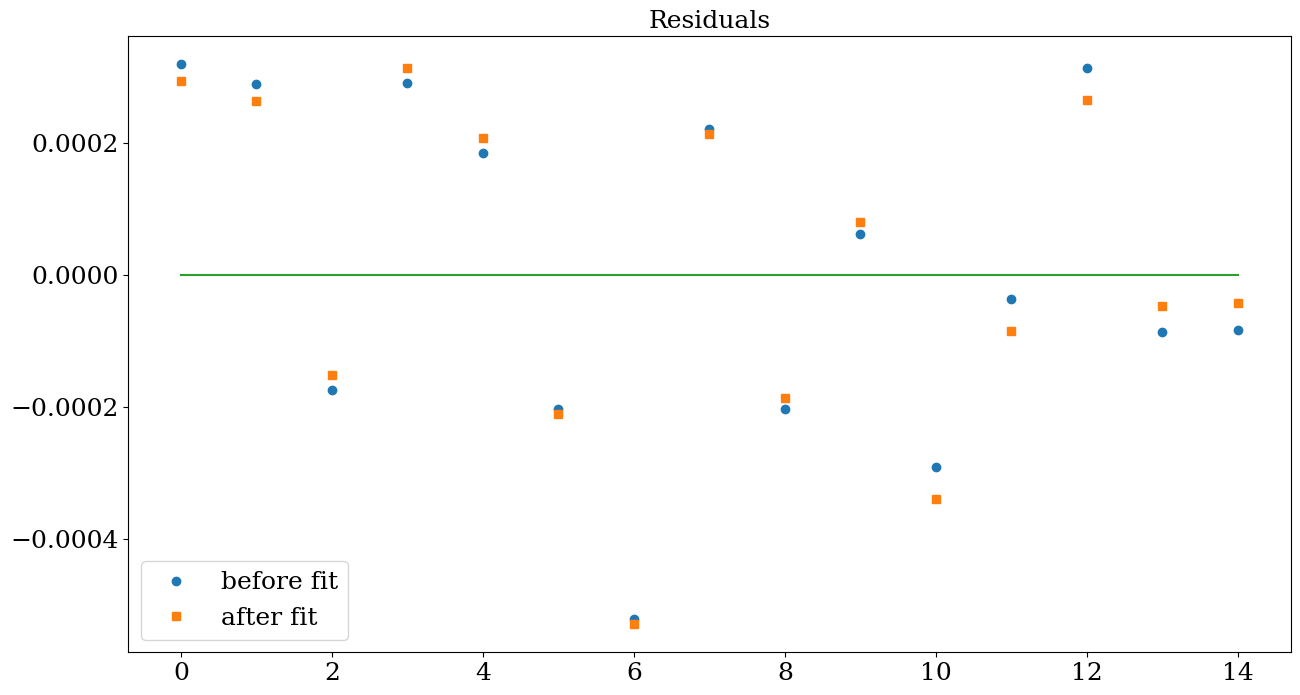

fit residuals standard deviation 0.00024874023201107307
  Residual std: 2.49e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=9.282e-07 redchi=6.63e-08 params={'bF_g': -0.06280159}
  iter 0: chisqr=9.282e-07 redchi=6.63e-08 params={'bF_g': -0.06280159}
  iter 1: chisqr=9.282e-07 redchi=6.63e-08 params={'bF_g': -0.06280159}
  iter 2: chisqr=9.268e-07 redchi=6.62e-08 params={'bF_g': -0.0628009619841}
  iter 3: chisqr=8.913e-07 redchi=6.367e-08 params={'bF_g': -0.0627693156781674}
  iter 4: chisqr=8.914e-07 redchi=6.367e-08 params={'bF_g': -0.06276868798501062}
  iter 5: chisqr=8.913e-07 redchi=6.367e-08 params={'bF_g': -0.06276931568338585}
  iter 5: chisqr=8.913e-07 redchi=6.367e-08 params={'bF_g': -0.06276931568338585}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.0021379 (fixed)
    Gamma_prime_g:  0.00047479 (fixed)
    qG_g:           0.00041754 (fixed)
    pG2qG_g:        0.00043419 (fixed)
    bF_g:          -0.06276932 +/- 4.2403e-05 (0.07%) (init = -0.06280159)
    c_g:           -0.002491347 (fixed)
    e2Qq0_g:       -

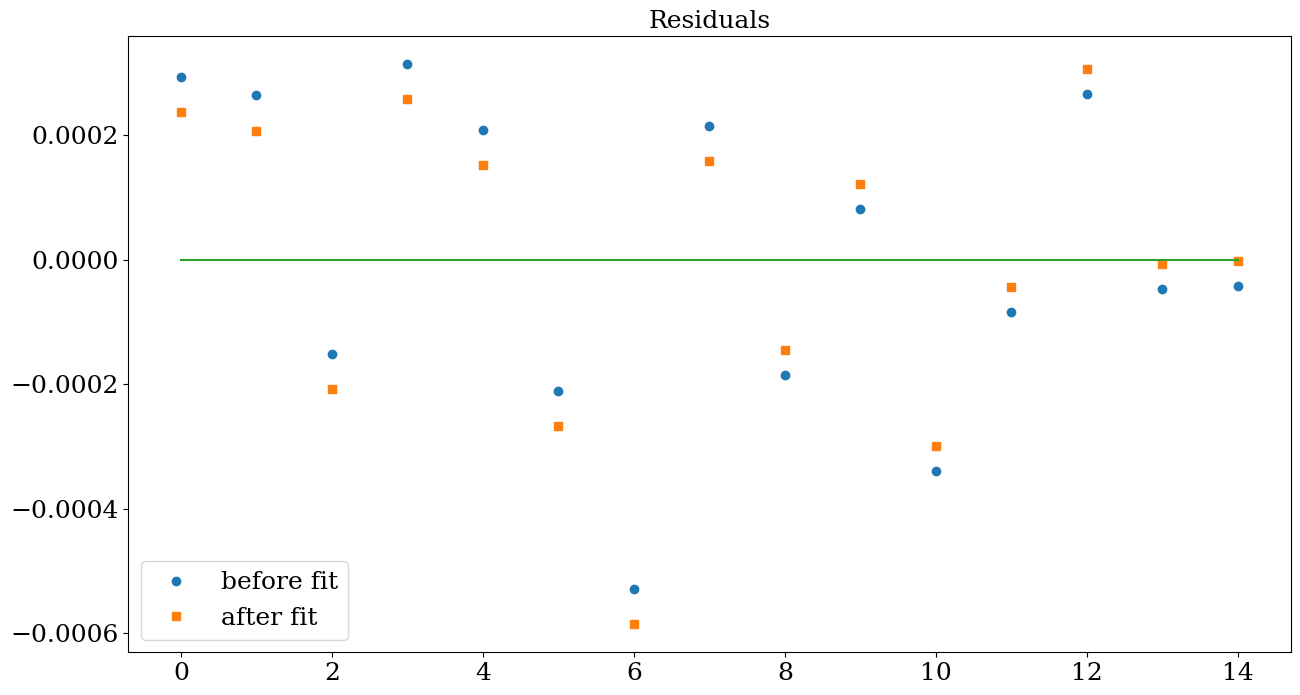

fit residuals standard deviation 0.00024363185738315973
  Residual std: 2.44e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=8.913e-07 redchi=6.367e-08 params={'Gamma_SR_g': -0.0021379}
  iter 0: chisqr=8.913e-07 redchi=6.367e-08 params={'Gamma_SR_g': -0.0021379}
  iter 1: chisqr=8.913e-07 redchi=6.367e-08 params={'Gamma_SR_g': -0.0021379}
  iter 2: chisqr=8.914e-07 redchi=6.367e-08 params={'Gamma_SR_g': -0.002137878621}
  iter 3: chisqr=7.837e-07 redchi=5.598e-08 params={'Gamma_SR_g': -0.00256055133918967}
  iter 4: chisqr=7.837e-07 redchi=5.598e-08 params={'Gamma_SR_g': -0.0025605257336762783}
  iter 5: chisqr=7.837e-07 redchi=5.598e-08 params={'Gamma_SR_g': -0.002561233557593439}
  iter 5: chisqr=7.837e-07 redchi=5.598e-08 params={'Gamma_SR_g': -0.002561233557593439}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00256123 +/- 3.0510e-04 (11.91%) (init = -0.0021379)
    Gamma_prime_g:  0.00047479 (fixed)
    qG_g:           0.00041754 (fixed)
    pG2qG_g:        0.00043419 (fixed)
    bF_g:          -0.06276932 (fixed)
    c_

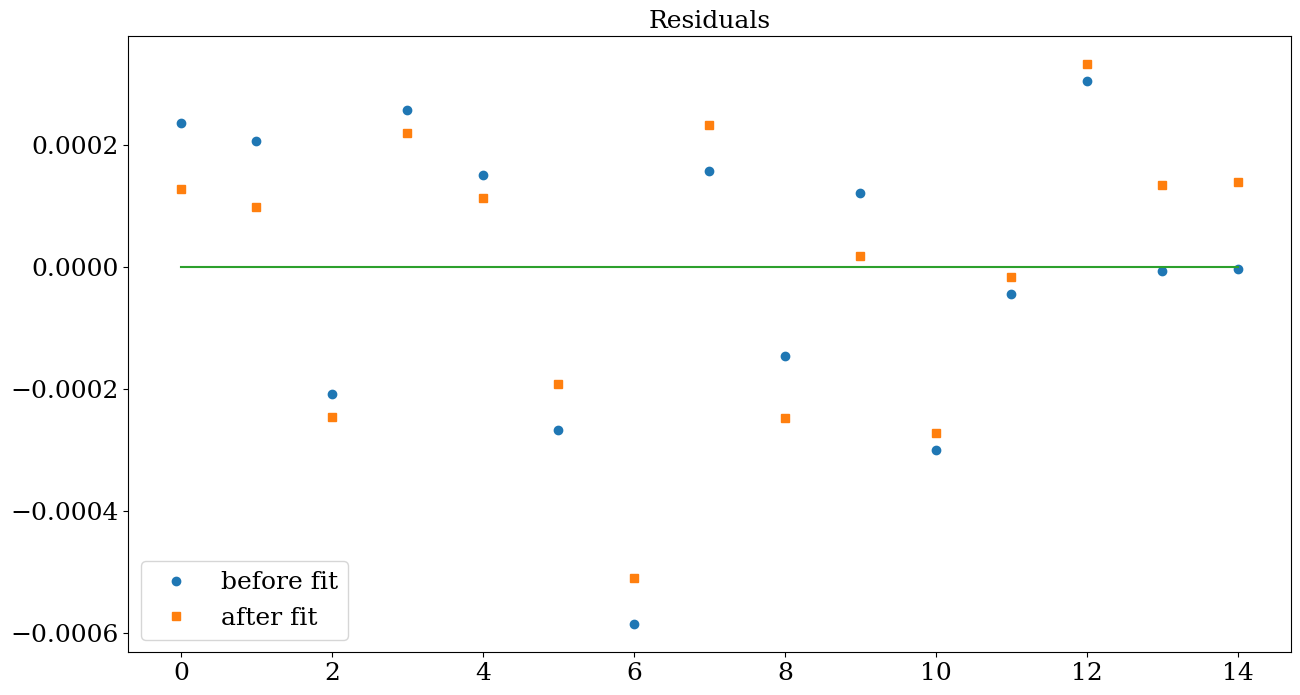

fit residuals standard deviation 0.00022854056419623439
  Residual std: 2.29e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.837e-07 redchi=5.598e-08 params={'Gamma_prime_g': 0.00047479}
  iter 0: chisqr=7.837e-07 redchi=5.598e-08 params={'Gamma_prime_g': 0.00047479}
  iter 1: chisqr=7.837e-07 redchi=5.598e-08 params={'Gamma_prime_g': 0.00047479}
  iter 2: chisqr=7.837e-07 redchi=5.598e-08 params={'Gamma_prime_g': 0.0004747947479}
  iter 3: chisqr=7.836e-07 redchi=5.597e-08 params={'Gamma_prime_g': 0.000490511849525766}
  iter 3: chisqr=7.836e-07 redchi=5.597e-08 params={'Gamma_prime_g': 0.000490511849525766}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002561234 (fixed)
    Gamma_prime_g:  4.9051e-04 +/- 2.9582e-04 (60.31%) (init = 0.00047479)
    qG_g:           0.00041754 (fixed)
    pG2qG_g:        0.00043419 (fixed)
    bF_g:          -0.06276932 (fixed)
    c_g:           -0.002491347 (fixed)
    e2Qq0_g:       -0.1081978 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi sq

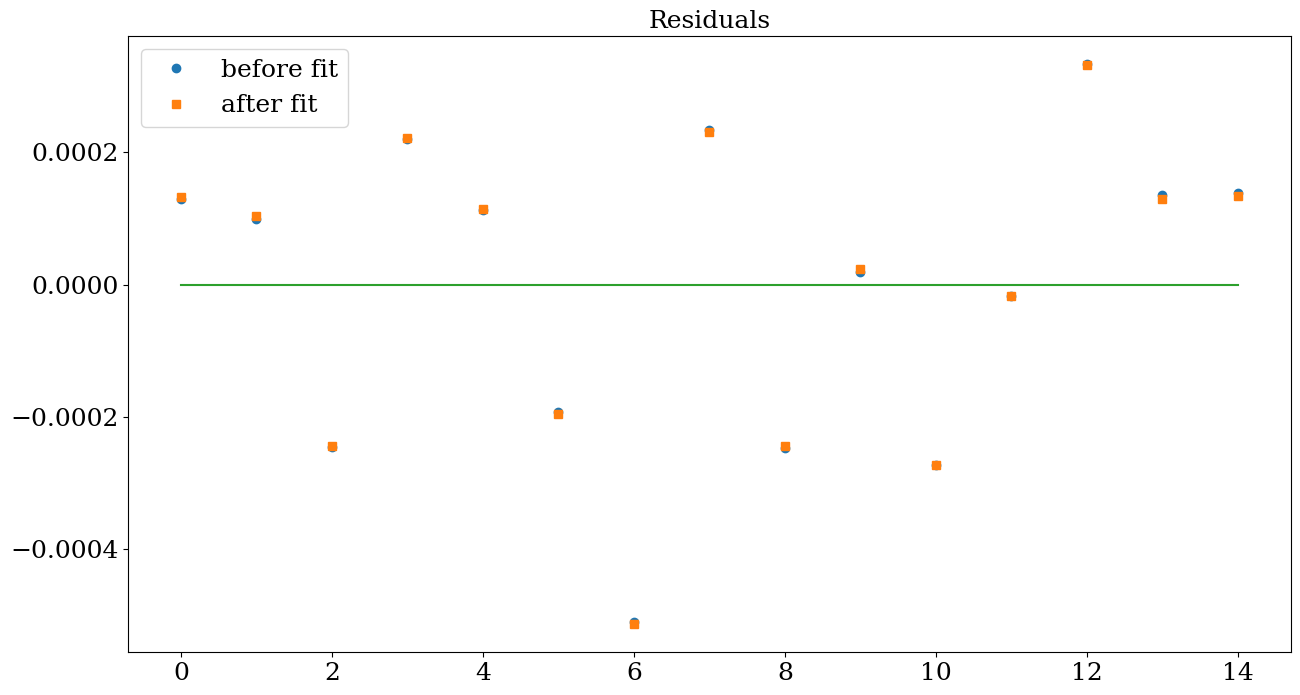

fit residuals standard deviation 0.00022851513862782722
  Residual std: 2.29e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.836e-07 redchi=5.597e-08 params={'qG_g': 0.00041754}
  iter 0: chisqr=7.836e-07 redchi=5.597e-08 params={'qG_g': 0.00041754}
  iter 1: chisqr=7.836e-07 redchi=5.597e-08 params={'qG_g': 0.00041754}
  iter 2: chisqr=7.836e-07 redchi=5.597e-08 params={'qG_g': 0.00041754417539999997}
  iter 3: chisqr=7.833e-07 redchi=5.595e-08 params={'qG_g': 0.0004221781892249378}
  iter 3: chisqr=7.833e-07 redchi=5.595e-08 params={'qG_g': 0.0004221781892249378}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002561234 (fixed)
    Gamma_prime_g:  0.0004905118 (fixed)
    qG_g:           4.2218e-04 +/- 6.1140e-05 (14.48%) (init = 0.00041754)
    pG2qG_g:        0.00043419 (fixed)
    bF_g:          -0.06276932 (fixed)
    c_g:           -0.002491347 (fixed)
    e2Qq0_g:       -0.1081978 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.594888205099112e-08


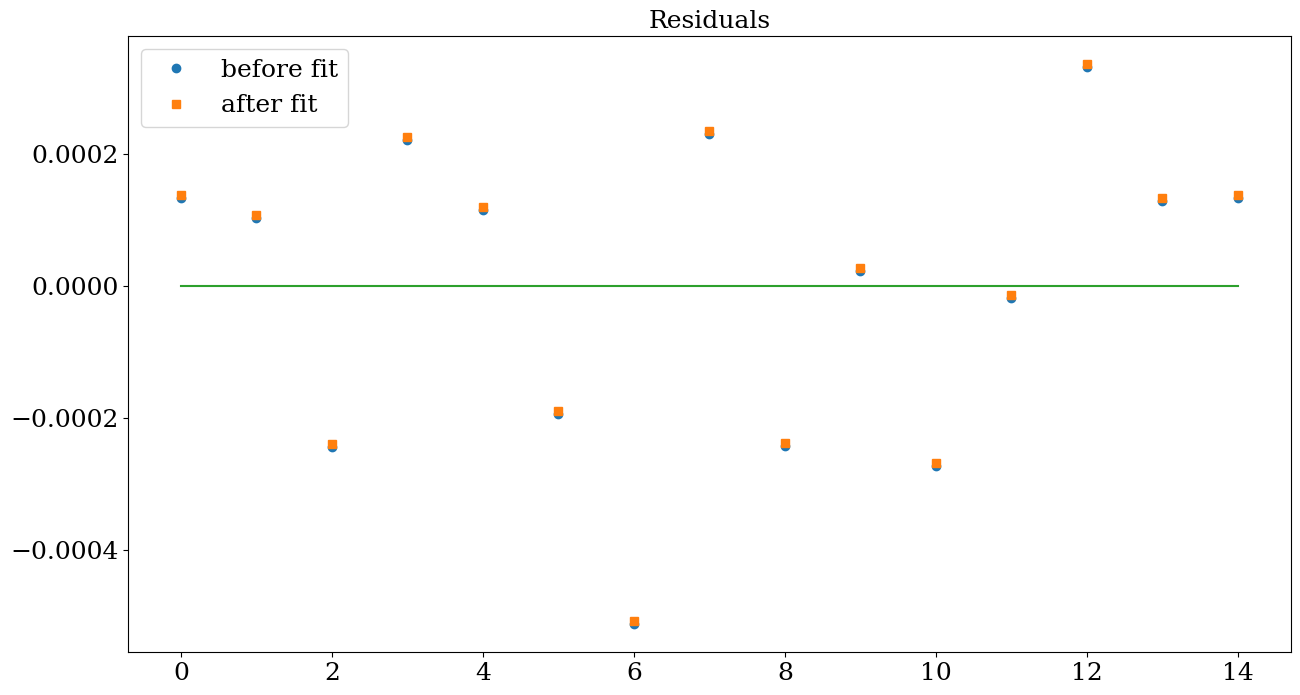

fit residuals standard deviation 0.00022851466659839917
  Residual std: 2.29e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.833e-07 redchi=5.595e-08 params={'pG2qG_g': 0.00043419}
  iter 0: chisqr=7.833e-07 redchi=5.595e-08 params={'pG2qG_g': 0.00043419}
  iter 1: chisqr=7.833e-07 redchi=5.595e-08 params={'pG2qG_g': 0.00043419}
  iter 2: chisqr=7.833e-07 redchi=5.595e-08 params={'pG2qG_g': 0.0004341943419}
  iter 3: chisqr=7.833e-07 redchi=5.595e-08 params={'pG2qG_g': 0.0004337991900554317}
  iter 4: chisqr=7.833e-07 redchi=5.595e-08 params={'pG2qG_g': 0.0004338035280473322}
  iter 5: chisqr=7.833e-07 redchi=5.595e-08 params={'pG2qG_g': 0.00043304388538840466}
  iter 5: chisqr=7.833e-07 redchi=5.595e-08 params={'pG2qG_g': 0.0004337991900554317}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002561234 (fixed)
    Gamma_prime_g:  0.0004905118 (fixed)
    qG_g:           0.0004221782 (fixed)
    pG2qG_g:        4.3380e-04 +/- 2.9582e-04 (68.19%) (init = 0.00043419)
    bF_g:          -0.06276932 (fixed)
    c_g:           -0.00

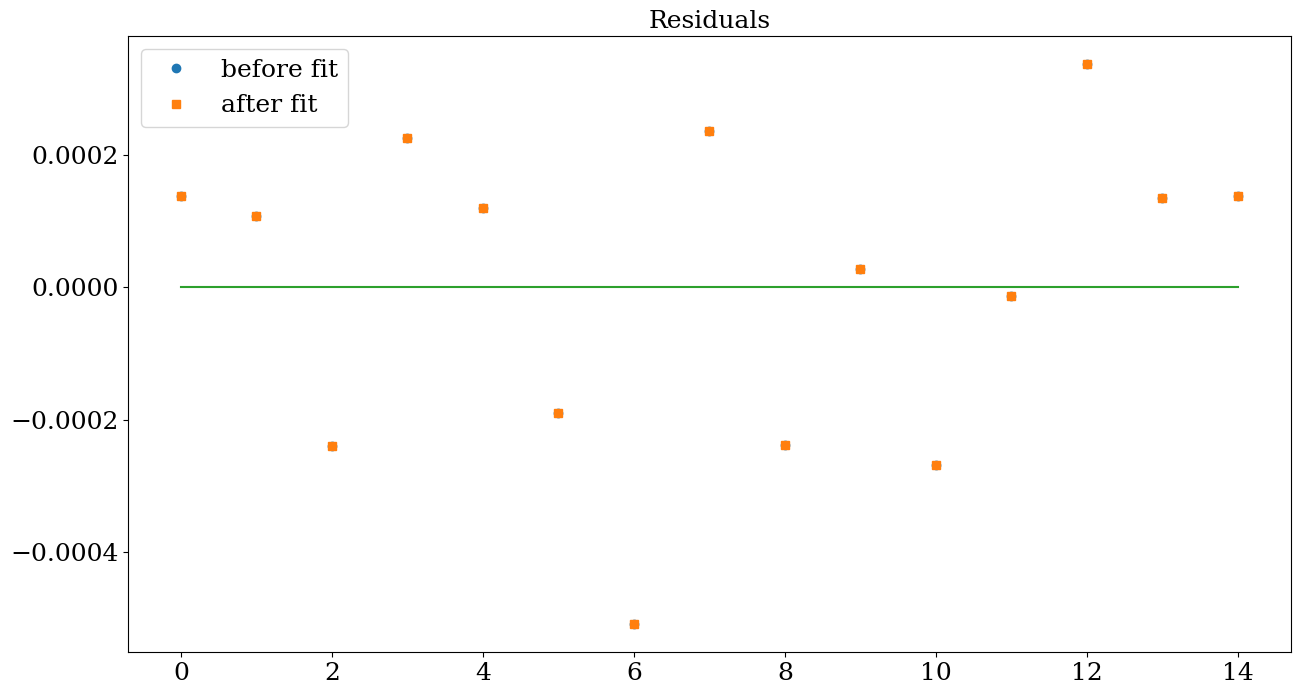

fit residuals standard deviation 0.00022851463168091108
  Residual std: 2.29e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.833e-07 redchi=5.595e-08 params={'Torg_g': 319.917282}
  iter 0: chisqr=7.833e-07 redchi=5.595e-08 params={'Torg_g': 319.917282}
  iter 1: chisqr=7.833e-07 redchi=5.595e-08 params={'Torg_g': 319.917282}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.92048117282}
  iter 3: chisqr=7.833e-07 redchi=5.595e-08 params={'Torg_g': 319.91728194376196}
  iter 3: chisqr=7.833e-07 redchi=5.595e-08 params={'Torg_g': 319.91728194376196}
[[Variables]]
    Torg_g:         319.917282 +/- 6.1073e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002561234 (fixed)
    Gamma_prime_g:  0.0004905118 (fixed)
    qG_g:           0.0004221782 (fixed)
    pG2qG_g:        0.0004337992 (fixed)
    bF_g:          -0.06276932 (fixed)
    c_g:           -0.002491347 (fixed)
    e2Qq0_g:       -0.1081978 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.594886080419656e-08


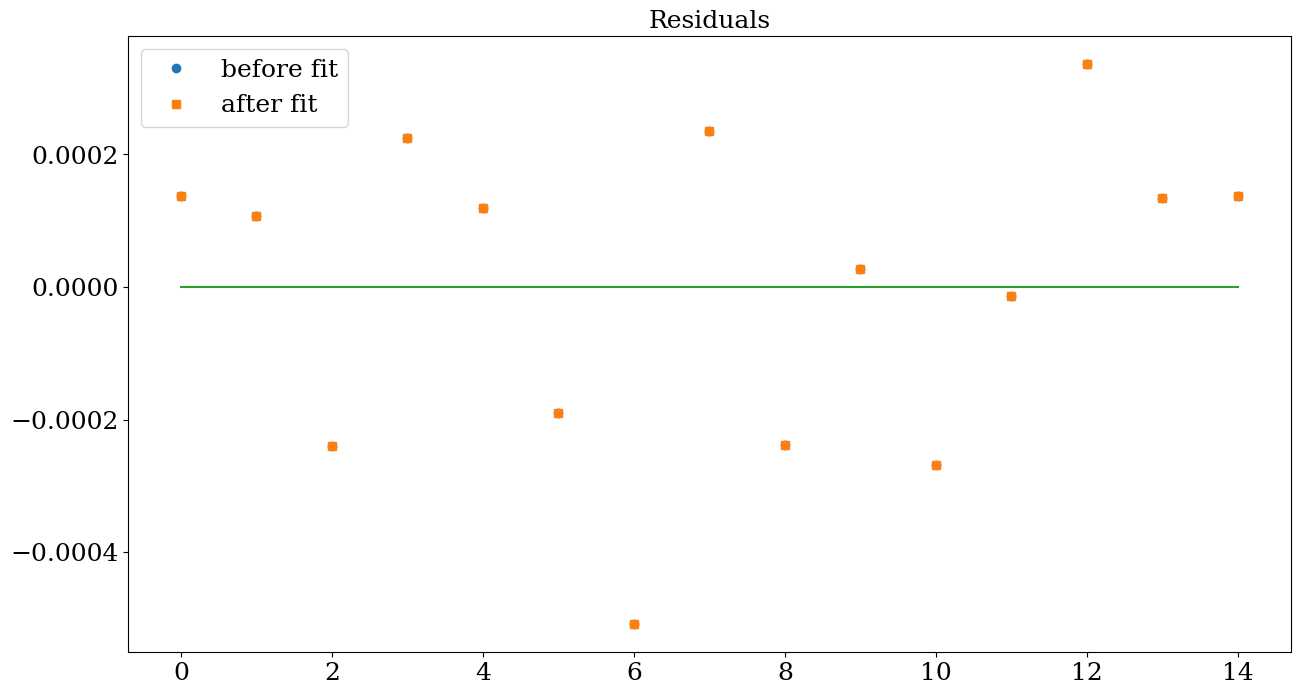

fit residuals standard deviation 0.00022851463137091126
  Residual std: 2.29e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.833e-07 redchi=5.595e-08 params={'e2Qq0_g': -0.10819782175203908}
  iter 0: chisqr=7.833e-07 redchi=5.595e-08 params={'e2Qq0_g': -0.10819782175203908}
  iter 1: chisqr=7.833e-07 redchi=5.595e-08 params={'e2Qq0_g': -0.10819782175203908}
  iter 2: chisqr=7.833e-07 redchi=5.595e-08 params={'e2Qq0_g': -0.10819673977382156}
  iter 3: chisqr=7.816e-07 redchi=5.583e-08 params={'e2Qq0_g': -0.10837369384099359}
  iter 4: chisqr=7.816e-07 redchi=5.583e-08 params={'e2Qq0_g': -0.10837261010405518}
  iter 5: chisqr=7.816e-07 redchi=5.583e-08 params={'e2Qq0_g': -0.10837377213718735}
  iter 5: chisqr=7.816e-07 redchi=5.583e-08 params={'e2Qq0_g': -0.10837369384099359}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002561234 (fixed)
    Gamma_prime_g:  0.0004905118 (fixed)
    qG_g:           0.0004221782 (fixed)
    pG2qG_g:        0.0004337992 (fixed)
    bF_g:          -0.06276932 (fixed)
    c_g:           -0.002491

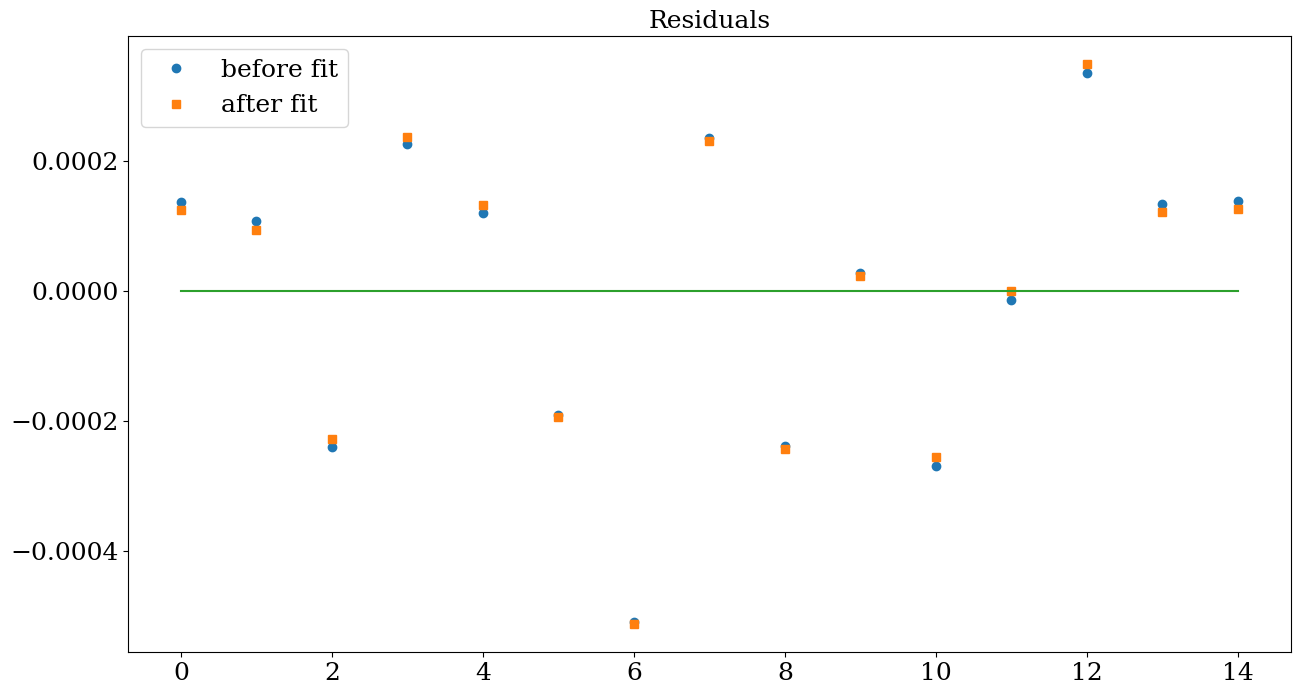

fit residuals standard deviation 0.00022827049074456506
  Residual std: 2.28e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.816e-07 redchi=5.583e-08 params={'c_g': -0.0024913465680953886}
  iter 0: chisqr=7.816e-07 redchi=5.583e-08 params={'c_g': -0.0024913465680953886}
  iter 1: chisqr=7.816e-07 redchi=5.583e-08 params={'c_g': -0.0024913465680953886}
  iter 2: chisqr=7.816e-07 redchi=5.583e-08 params={'c_g': -0.0024913216546297075}
  iter 3: chisqr=7.811e-07 redchi=5.579e-08 params={'c_g': -0.002527021070015923}
  iter 3: chisqr=7.811e-07 redchi=5.579e-08 params={'c_g': -0.002527021070015923}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002561234 (fixed)
    Gamma_prime_g:  0.0004905118 (fixed)
    qG_g:           0.0004221782 (fixed)
    pG2qG_g:        0.0004337992 (fixed)
    bF_g:          -0.06276932 (fixed)
    c_g:           -0.00252702 +/- 3.7980e-04 (15.03%) (init = -0.002491347)
    e2Qq0_g:       -0.1083737 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  

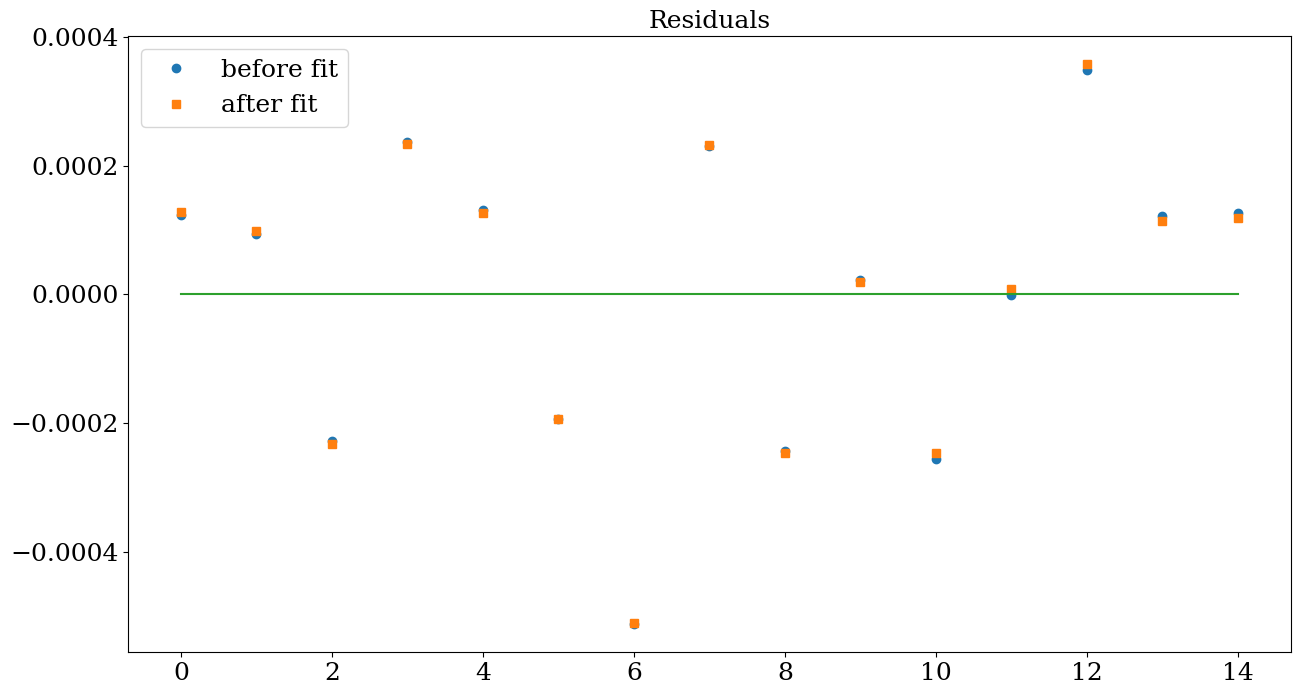

fit residuals standard deviation 0.00022819855410185523
  Residual std: 2.28e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.811e-07 redchi=5.579e-08 params={'bF_g': -0.06276931568338585}
  iter 0: chisqr=7.811e-07 redchi=5.579e-08 params={'bF_g': -0.06276931568338585}
  iter 1: chisqr=7.811e-07 redchi=5.579e-08 params={'bF_g': -0.06276931568338585}
  iter 2: chisqr=7.816e-07 redchi=5.583e-08 params={'bF_g': -0.06276868799022901}
  iter 3: chisqr=7.775e-07 redchi=5.554e-08 params={'bF_g': -0.06277941518982165}
  iter 3: chisqr=7.775e-07 redchi=5.554e-08 params={'bF_g': -0.06277941518982165}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002561234 (fixed)
    Gamma_prime_g:  0.0004905118 (fixed)
    qG_g:           0.0004221782 (fixed)
    pG2qG_g:        0.0004337992 (fixed)
    bF_g:          -0.06277942 +/- 3.9604e-05 (0.06%) (init = -0.06276932)
    c_g:           -0.002527021 (fixed)
    e2Qq0_g:       -0.1083737 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.553

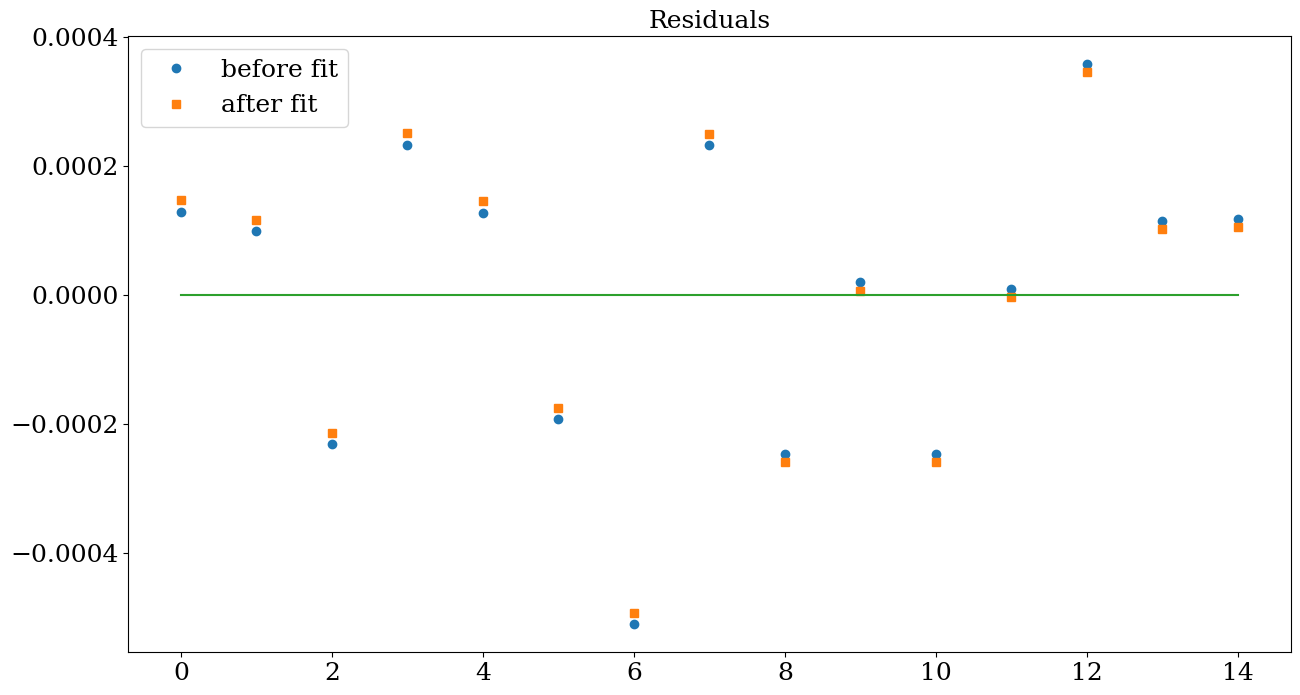

fit residuals standard deviation 0.00022763486316111688
  Residual std: 2.28e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.775e-07 redchi=5.554e-08 params={'Gamma_SR_g': -0.002561233557593439}
  iter 0: chisqr=7.775e-07 redchi=5.554e-08 params={'Gamma_SR_g': -0.002561233557593439}
  iter 1: chisqr=7.775e-07 redchi=5.554e-08 params={'Gamma_SR_g': -0.002561233557593439}
  iter 2: chisqr=7.775e-07 redchi=5.554e-08 params={'Gamma_SR_g': -0.002561207945257863}
  iter 3: chisqr=7.767e-07 redchi=5.548e-08 params={'Gamma_SR_g': -0.0025982361591567623}
  iter 4: chisqr=7.767e-07 redchi=5.548e-08 params={'Gamma_SR_g': -0.0025982101767951706}
  iter 5: chisqr=7.767e-07 redchi=5.548e-08 params={'Gamma_SR_g': -0.002598321010077585}
  iter 5: chisqr=7.767e-07 redchi=5.548e-08 params={'Gamma_SR_g': -0.002598321010077585}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00259832 +/- 3.0371e-04 (11.69%) (init = -0.002561234)
    Gamma_prime_g:  0.0004905118 (fixed)
    qG_g:           0.0004221782 (fixed)
    pG2qG_g:        0.0004337992 (fix

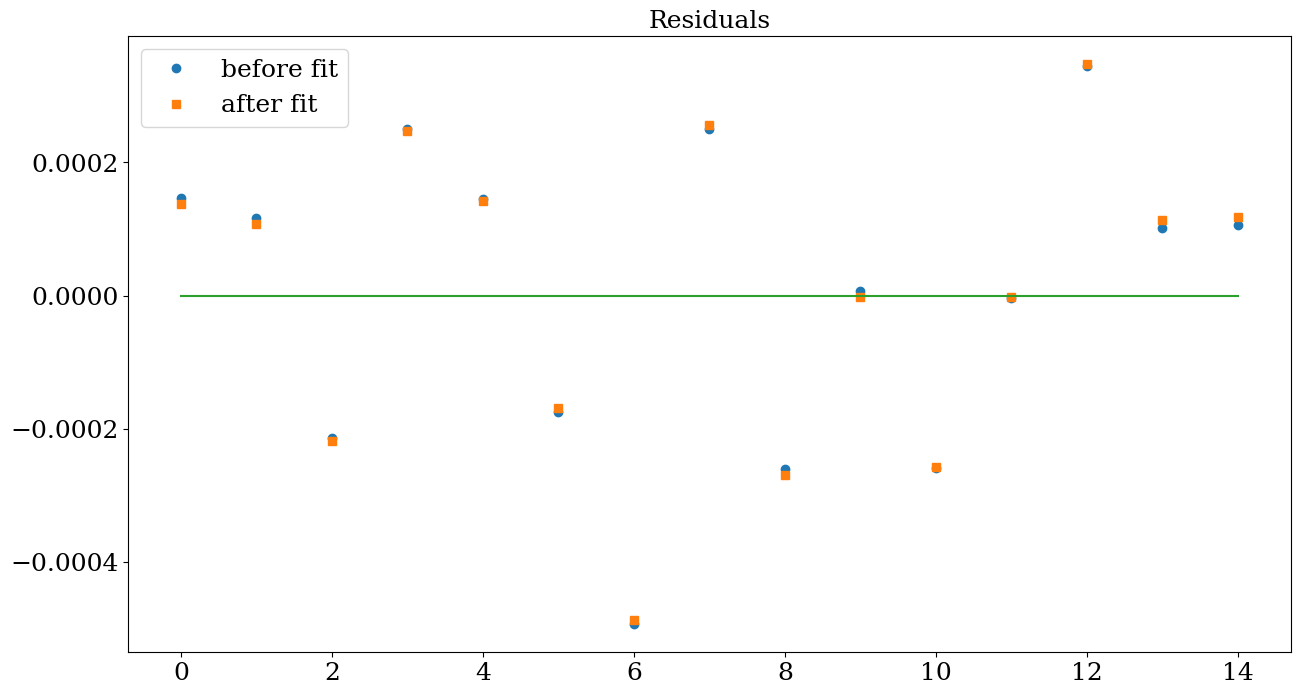

fit residuals standard deviation 0.0002275074476828514
  Residual std: 2.28e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.767e-07 redchi=5.548e-08 params={'Gamma_prime_g': 0.000490511849525766}
  iter 0: chisqr=7.767e-07 redchi=5.548e-08 params={'Gamma_prime_g': 0.000490511849525766}
  iter 1: chisqr=7.767e-07 redchi=5.548e-08 params={'Gamma_prime_g': 0.000490511849525766}
  iter 2: chisqr=7.767e-07 redchi=5.548e-08 params={'Gamma_prime_g': 0.0004905167546442613}
  iter 3: chisqr=7.765e-07 redchi=5.547e-08 params={'Gamma_prime_g': 0.000507016136365895}
  iter 3: chisqr=7.765e-07 redchi=5.547e-08 params={'Gamma_prime_g': 0.000507016136365895}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002598321 (fixed)
    Gamma_prime_g:  5.0702e-04 +/- 2.9453e-04 (58.09%) (init = 0.0004905118)
    qG_g:           0.0004221782 (fixed)
    pG2qG_g:        0.0004337992 (fixed)
    bF_g:          -0.06277942 (fixed)
    c_g:           -0.002527021 (fixed)
    e2Qq0_g:       -0.1083737 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff

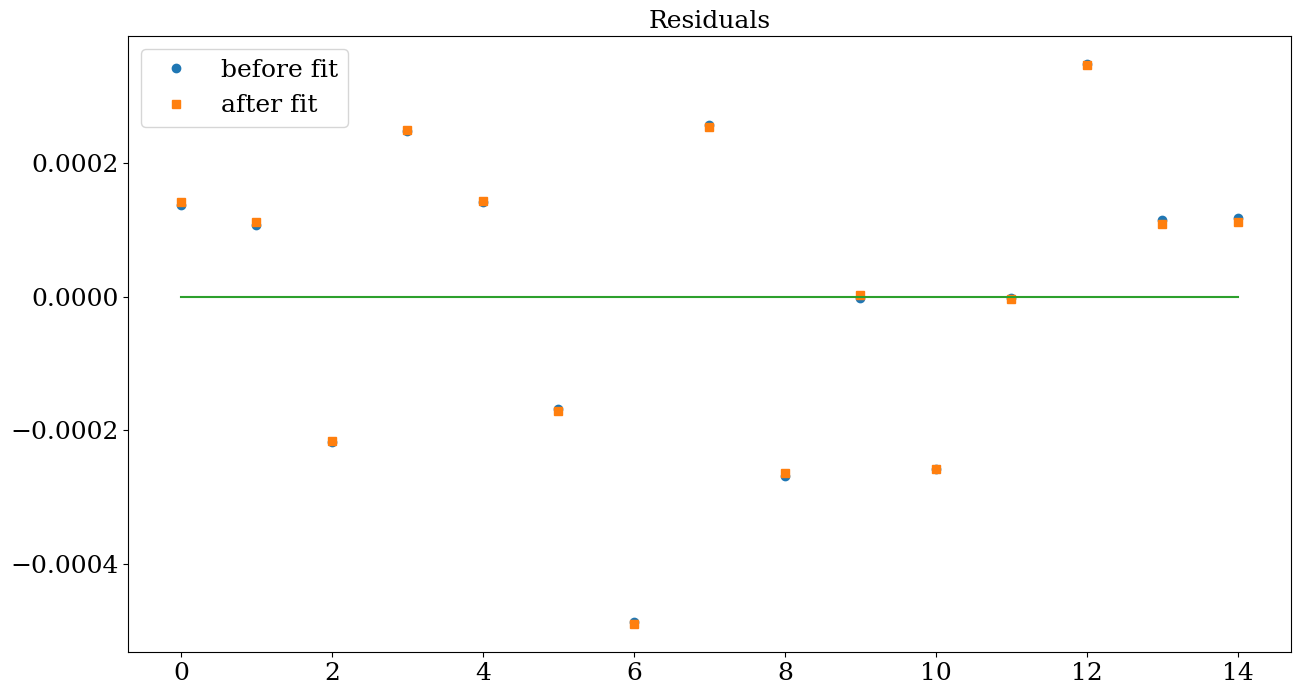

fit residuals standard deviation 0.0002274868288194272
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.765e-07 redchi=5.547e-08 params={'qG_g': 0.0004221781892249378}
  iter 0: chisqr=7.765e-07 redchi=5.547e-08 params={'qG_g': 0.0004221781892249378}
  iter 1: chisqr=7.765e-07 redchi=5.547e-08 params={'qG_g': 0.0004221781892249378}
  iter 2: chisqr=7.765e-07 redchi=5.547e-08 params={'qG_g': 0.00042218241100683003}
  iter 3: chisqr=7.763e-07 redchi=5.545e-08 params={'qG_g': 0.0004180084237410646}
  iter 3: chisqr=7.763e-07 redchi=5.545e-08 params={'qG_g': 0.0004180084237410646}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002598321 (fixed)
    Gamma_prime_g:  0.0005070161 (fixed)
    qG_g:           4.1801e-04 +/- 6.0844e-05 (14.56%) (init = 0.0004221782)
    pG2qG_g:        0.0004337992 (fixed)
    bF_g:          -0.06277942 (fixed)
    c_g:           -0.002527021 (fixed)
    e2Qq0_g:       -0.1083737 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:

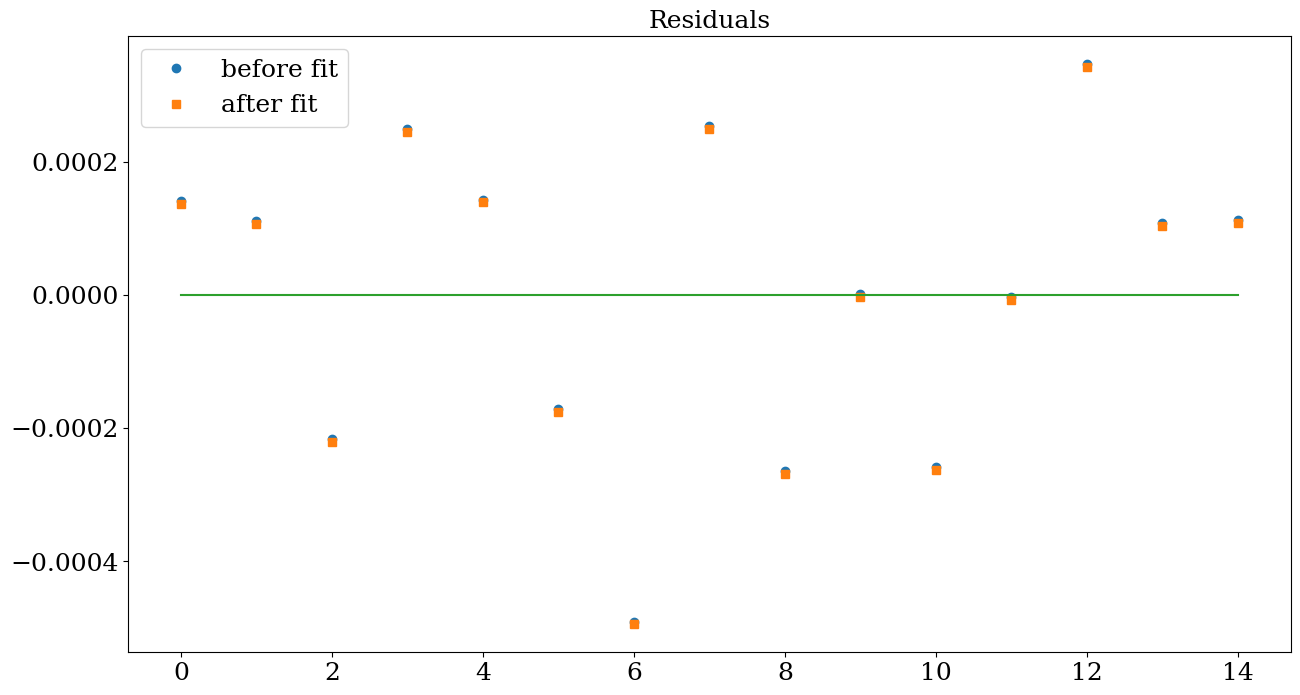

fit residuals standard deviation 0.0002274871608608984
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.763e-07 redchi=5.545e-08 params={'pG2qG_g': 0.0004337991900554317}
  iter 0: chisqr=7.763e-07 redchi=5.545e-08 params={'pG2qG_g': 0.0004337991900554317}
  iter 1: chisqr=7.763e-07 redchi=5.545e-08 params={'pG2qG_g': 0.0004337991900554317}
  iter 2: chisqr=7.763e-07 redchi=5.545e-08 params={'pG2qG_g': 0.0004338035280473322}
  iter 3: chisqr=7.763e-07 redchi=5.545e-08 params={'pG2qG_g': 0.0004353725097462655}
  iter 3: chisqr=7.763e-07 redchi=5.545e-08 params={'pG2qG_g': 0.0004353725097462655}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002598321 (fixed)
    Gamma_prime_g:  0.0005070161 (fixed)
    qG_g:           0.0004180084 (fixed)
    pG2qG_g:        4.3537e-04 +/- 2.9475e-04 (67.70%) (init = 0.0004337992)
    bF_g:          -0.06277942 (fixed)
    c_g:           -0.002527021 (fixed)
    e2Qq0_g:       -0.1083737 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

red

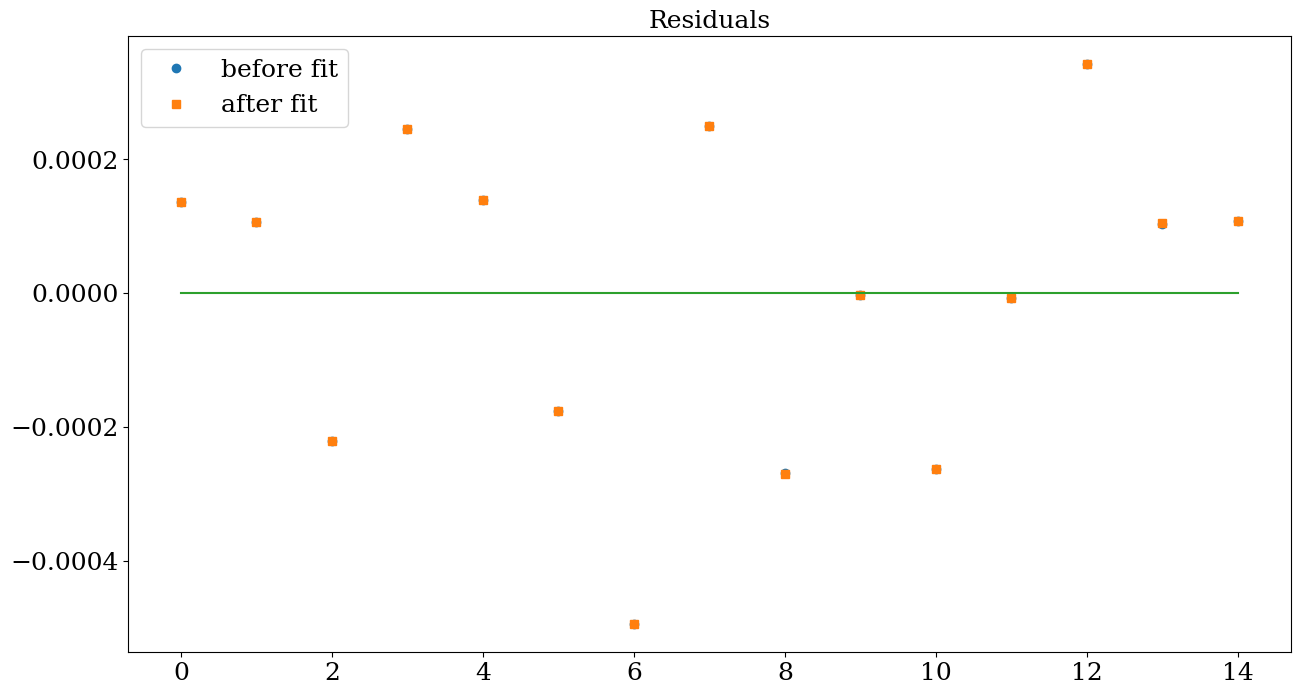

fit residuals standard deviation 0.00022748689825142406
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.763e-07 redchi=5.545e-08 params={'Torg_g': 319.91728194376196}
  iter 0: chisqr=7.763e-07 redchi=5.545e-08 params={'Torg_g': 319.91728194376196}
  iter 1: chisqr=7.763e-07 redchi=5.545e-08 params={'Torg_g': 319.91728194376196}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.9204811165814}
  iter 3: chisqr=7.763e-07 redchi=5.545e-08 params={'Torg_g': 319.9172819130632}
  iter 3: chisqr=7.763e-07 redchi=5.545e-08 params={'Torg_g': 319.9172819130632}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0798e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002598321 (fixed)
    Gamma_prime_g:  0.0005070161 (fixed)
    qG_g:           0.0004180084 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06277942 (fixed)
    c_g:           -0.002527021 (fixed)
    e2Qq0_g:       -0.1083737 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5446738

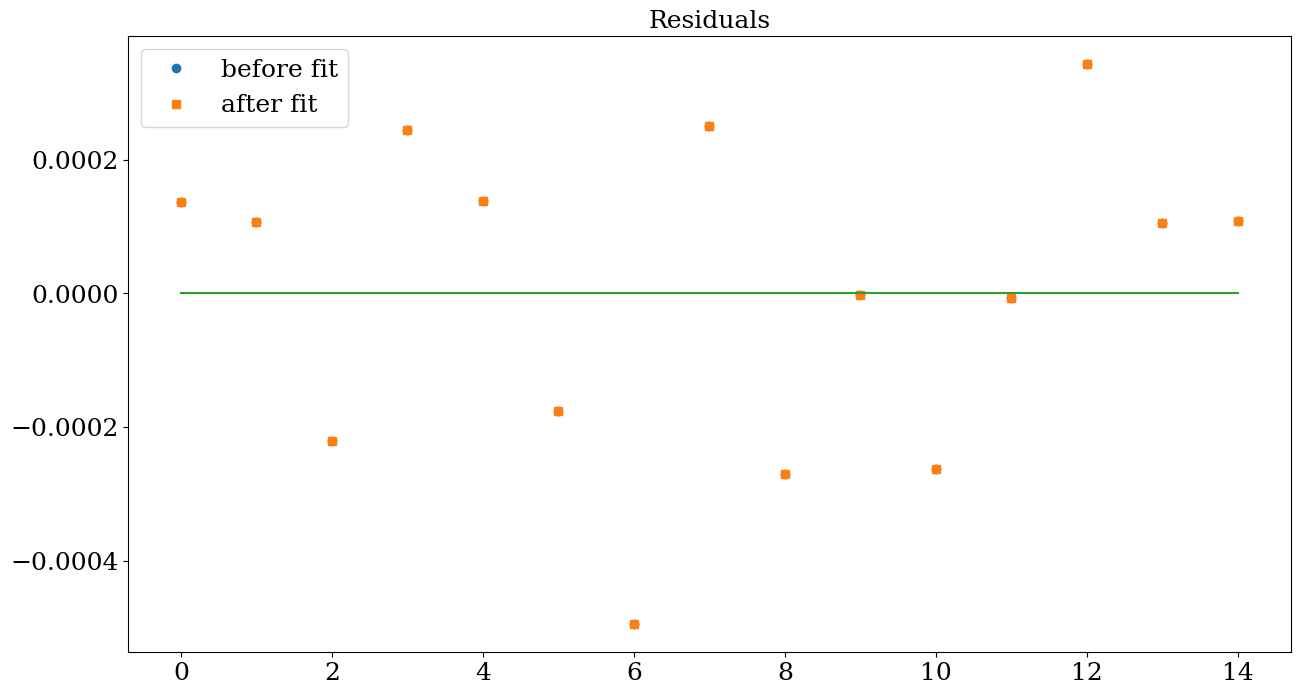

fit residuals standard deviation 0.00022748689836752772
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.763e-07 redchi=5.545e-08 params={'e2Qq0_g': -0.10837369384099359}
  iter 0: chisqr=7.763e-07 redchi=5.545e-08 params={'e2Qq0_g': -0.10837369384099359}
  iter 1: chisqr=7.763e-07 redchi=5.545e-08 params={'e2Qq0_g': -0.10837369384099359}
  iter 2: chisqr=7.763e-07 redchi=5.545e-08 params={'e2Qq0_g': -0.10837261010405518}
  iter 3: chisqr=7.762e-07 redchi=5.545e-08 params={'e2Qq0_g': -0.1083614415863679}
  iter 3: chisqr=7.762e-07 redchi=5.545e-08 params={'e2Qq0_g': -0.1083614415863679}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002598321 (fixed)
    Gamma_prime_g:  0.0005070161 (fixed)
    qG_g:           0.0004180084 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06277942 (fixed)
    c_g:           -0.002527021 (fixed)
    e2Qq0_g:       -0.10836144 +/- 0.00101271 (0.93%) (init = -0.1083737)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi

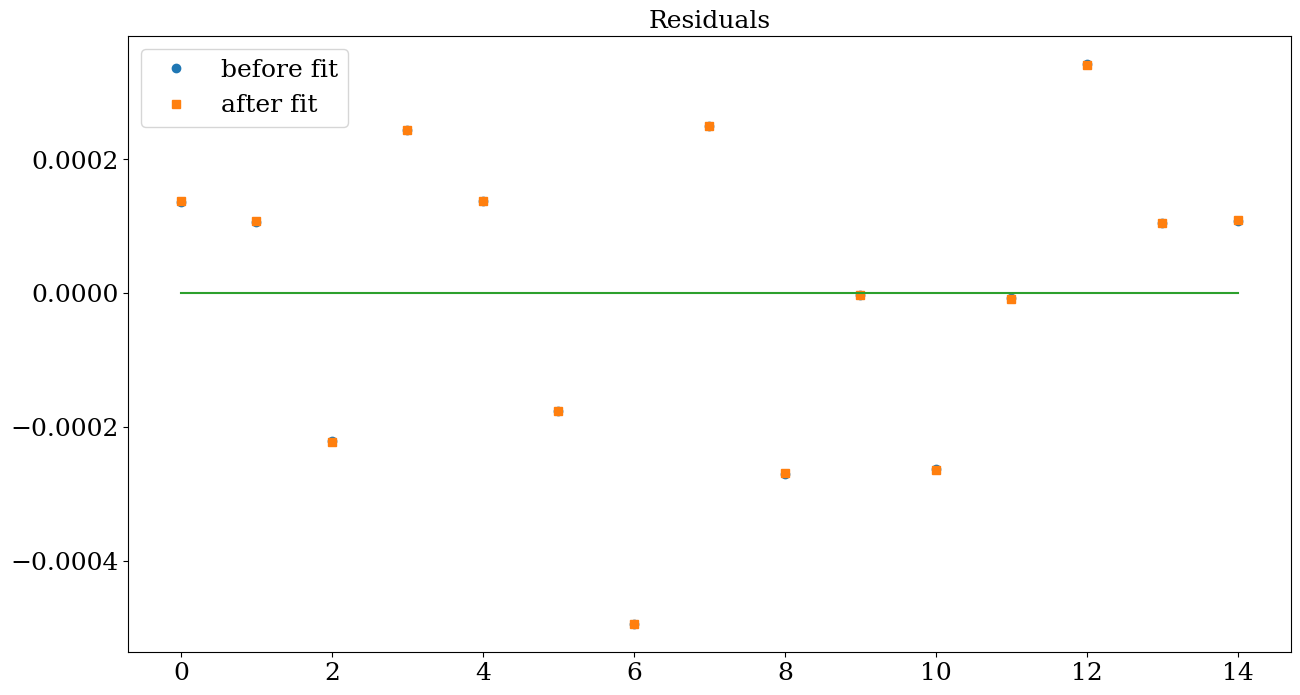

fit residuals standard deviation 0.00022748570829821225
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.762e-07 redchi=5.545e-08 params={'c_g': -0.002527021070015923}
  iter 0: chisqr=7.762e-07 redchi=5.545e-08 params={'c_g': -0.002527021070015923}
  iter 1: chisqr=7.762e-07 redchi=5.545e-08 params={'c_g': -0.002527021070015923}
  iter 2: chisqr=7.762e-07 redchi=5.545e-08 params={'c_g': -0.002526995799805223}
  iter 3: chisqr=7.762e-07 redchi=5.544e-08 params={'c_g': -0.0025378572063955453}
  iter 3: chisqr=7.762e-07 redchi=5.544e-08 params={'c_g': -0.0025378572063955453}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002598321 (fixed)
    Gamma_prime_g:  0.0005070161 (fixed)
    qG_g:           0.0004180084 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06277942 (fixed)
    c_g:           -0.00253786 +/- 3.7841e-04 (14.91%) (init = -0.002527021)
    e2Qq0_g:       -0.1083614 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.

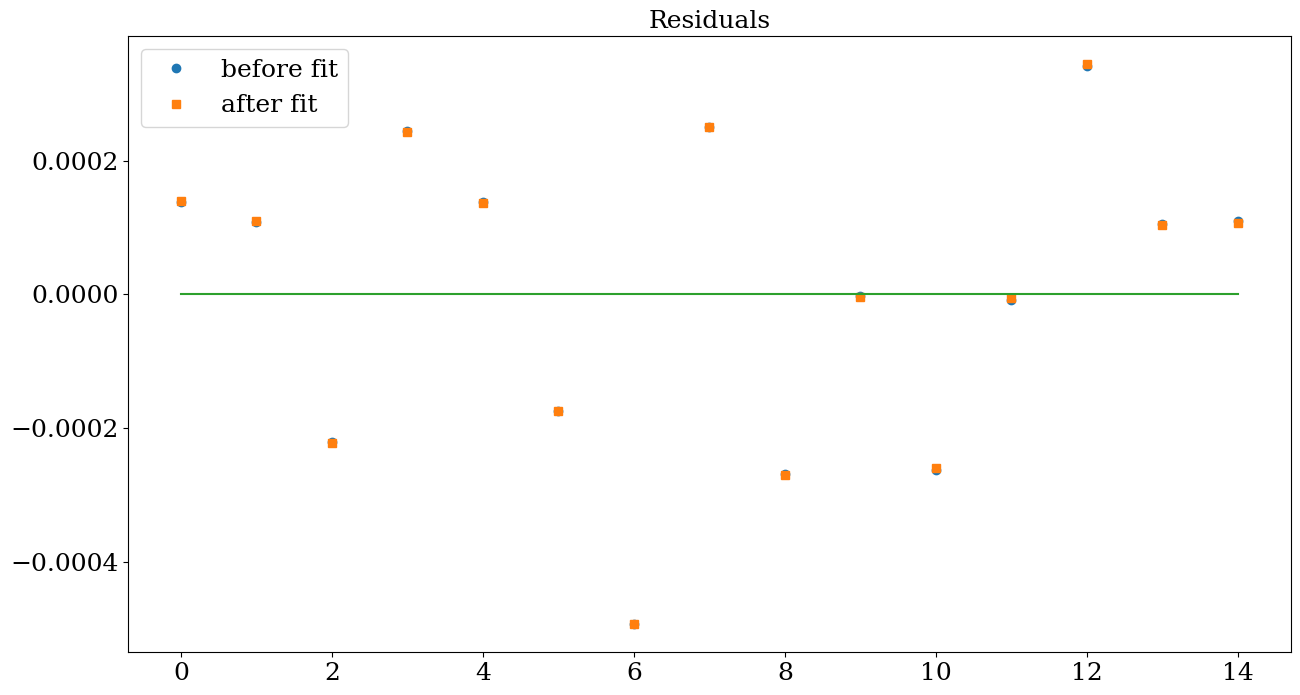

fit residuals standard deviation 0.00022747913148506746
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.762e-07 redchi=5.544e-08 params={'bF_g': -0.06277941518982165}
  iter 0: chisqr=7.762e-07 redchi=5.544e-08 params={'bF_g': -0.06277941518982165}
  iter 1: chisqr=7.762e-07 redchi=5.544e-08 params={'bF_g': -0.06277941518982165}
  iter 2: chisqr=7.763e-07 redchi=5.545e-08 params={'bF_g': -0.06277878739566975}
  iter 3: chisqr=7.762e-07 redchi=5.544e-08 params={'bF_g': -0.06278061000856434}
  iter 3: chisqr=7.762e-07 redchi=5.544e-08 params={'bF_g': -0.06278061000856434}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002598321 (fixed)
    Gamma_prime_g:  0.0005070161 (fixed)
    qG_g:           0.0004180084 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06278061 +/- 3.9569e-05 (0.06%) (init = -0.06277942)
    c_g:           -0.002537857 (fixed)
    e2Qq0_g:       -0.1083614 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.543

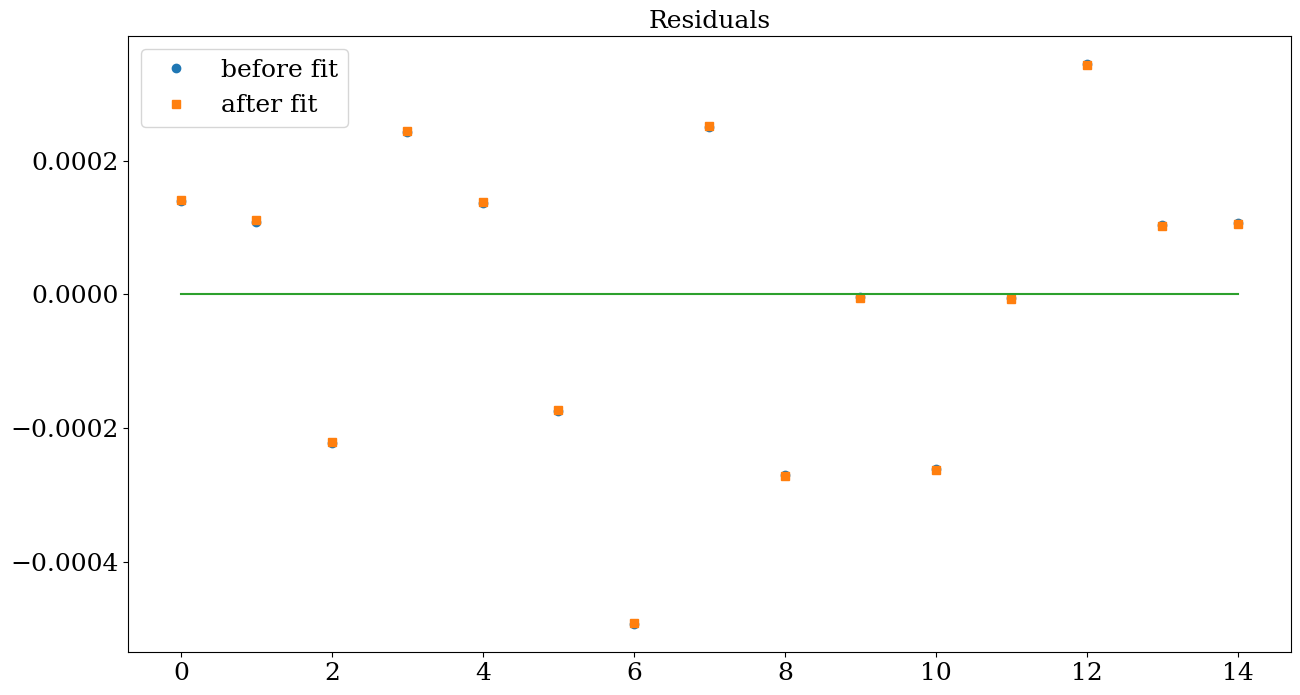

fit residuals standard deviation 0.00022747110724666617
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.762e-07 redchi=5.544e-08 params={'Gamma_SR_g': -0.002598321010077585}
  iter 0: chisqr=7.762e-07 redchi=5.544e-08 params={'Gamma_SR_g': -0.002598321010077585}
  iter 1: chisqr=7.762e-07 redchi=5.544e-08 params={'Gamma_SR_g': -0.002598321010077585}
  iter 2: chisqr=7.762e-07 redchi=5.544e-08 params={'Gamma_SR_g': -0.002598295026867484}
  iter 3: chisqr=7.759e-07 redchi=5.542e-08 params={'Gamma_SR_g': -0.002617392080249037}
  iter 3: chisqr=7.759e-07 redchi=5.542e-08 params={'Gamma_SR_g': -0.002617392080249037}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00261739 +/- 3.0357e-04 (11.60%) (init = -0.002598321)
    Gamma_prime_g:  0.0005070161 (fixed)
    qG_g:           0.0004180084 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06278061 (fixed)
    c_g:           -0.002537857 (fixed)
    e2Qq0_g:       -0.1083614 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.0

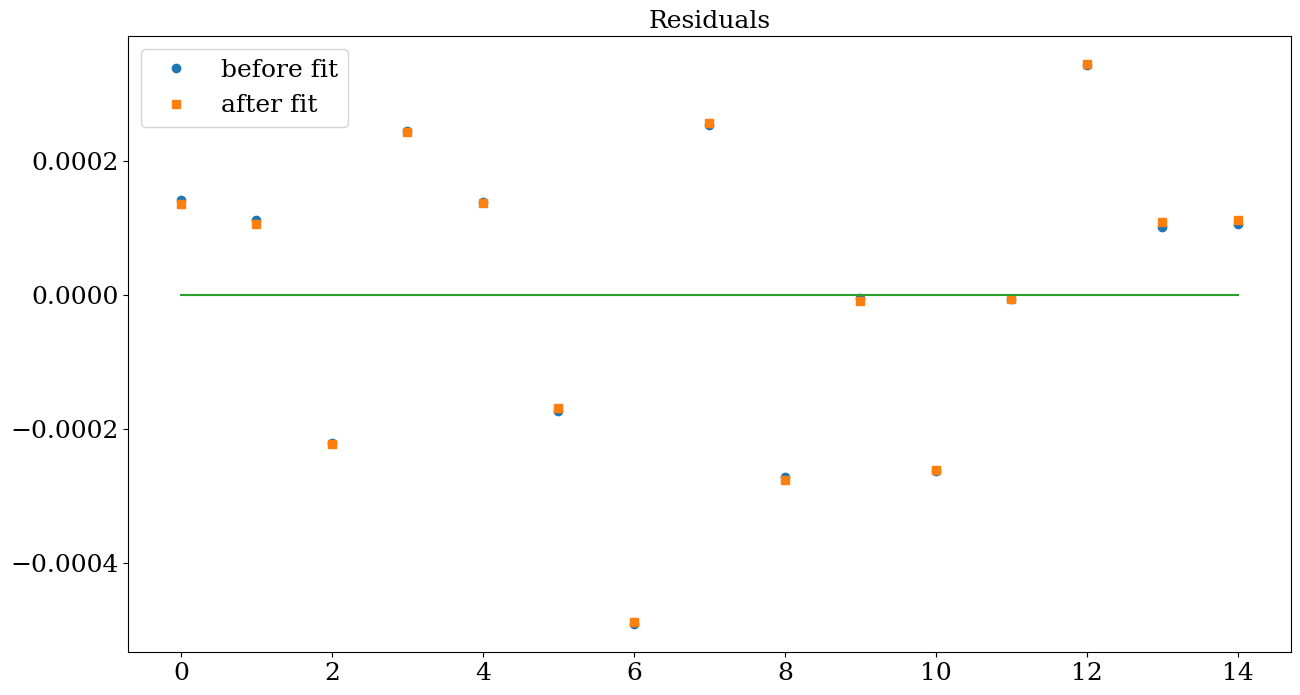

fit residuals standard deviation 0.00022743845936489785
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.759e-07 redchi=5.542e-08 params={'Gamma_prime_g': 0.000507016136365895}
  iter 0: chisqr=7.759e-07 redchi=5.542e-08 params={'Gamma_prime_g': 0.000507016136365895}
  iter 1: chisqr=7.759e-07 redchi=5.542e-08 params={'Gamma_prime_g': 0.000507016136365895}
  iter 2: chisqr=7.759e-07 redchi=5.542e-08 params={'Gamma_prime_g': 0.0005070212065272587}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'Gamma_prime_g': 0.0005228974286414764}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'Gamma_prime_g': 0.0005228974286414764}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002617392 (fixed)
    Gamma_prime_g:  5.2290e-04 +/- 2.9441e-04 (56.30%) (init = 0.0005070161)
    qG_g:           0.0004180084 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06278061 (fixed)
    c_g:           -0.002537857 (fixed)
    e2Qq0_g:       -0.1083614 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_e

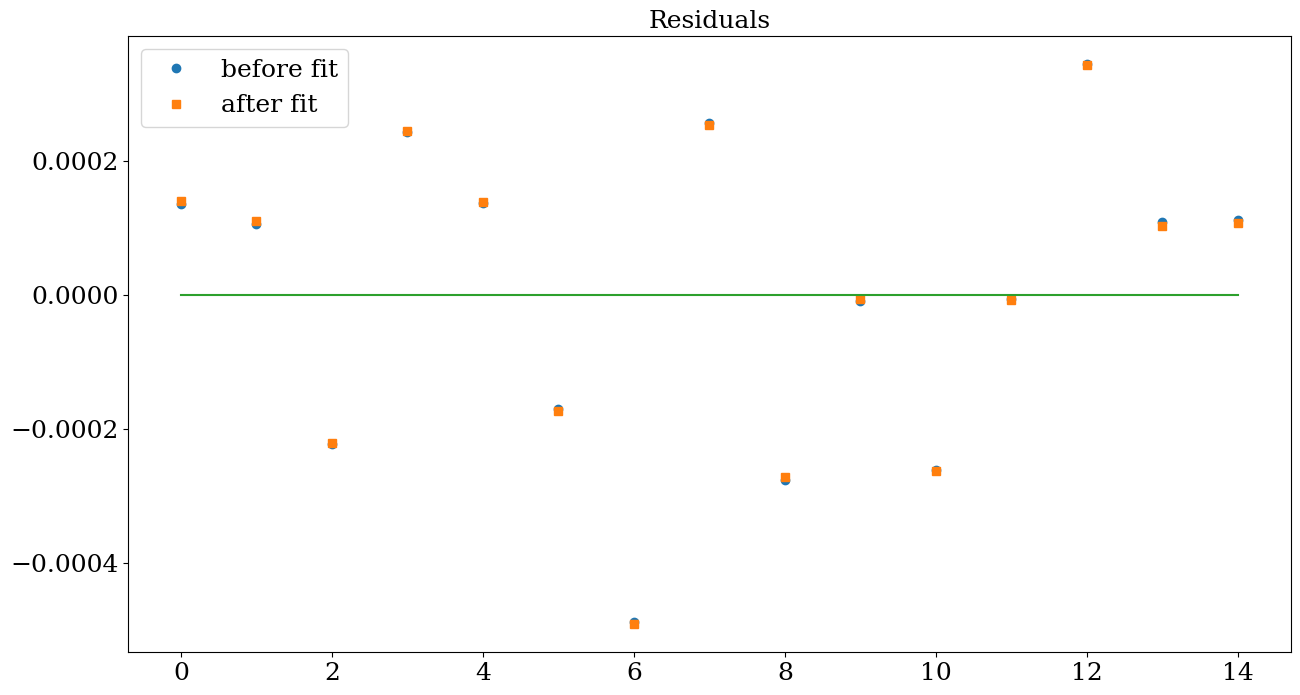

fit residuals standard deviation 0.00022741478670698032
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.758e-07 redchi=5.541e-08 params={'qG_g': 0.0004180084237410646}
  iter 0: chisqr=7.758e-07 redchi=5.541e-08 params={'qG_g': 0.0004180084237410646}
  iter 1: chisqr=7.758e-07 redchi=5.541e-08 params={'qG_g': 0.0004180084237410646}
  iter 2: chisqr=7.758e-07 redchi=5.541e-08 params={'qG_g': 0.000418012603825302}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'qG_g': 0.00041749056830375704}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'qG_g': 0.00041749056830375704}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002617392 (fixed)
    Gamma_prime_g:  0.0005228974 (fixed)
    qG_g:           4.1749e-04 +/- 6.0819e-05 (14.57%) (init = 0.0004180084)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06278061 (fixed)
    c_g:           -0.002537857 (fixed)
    e2Qq0_g:       -0.1083614 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:

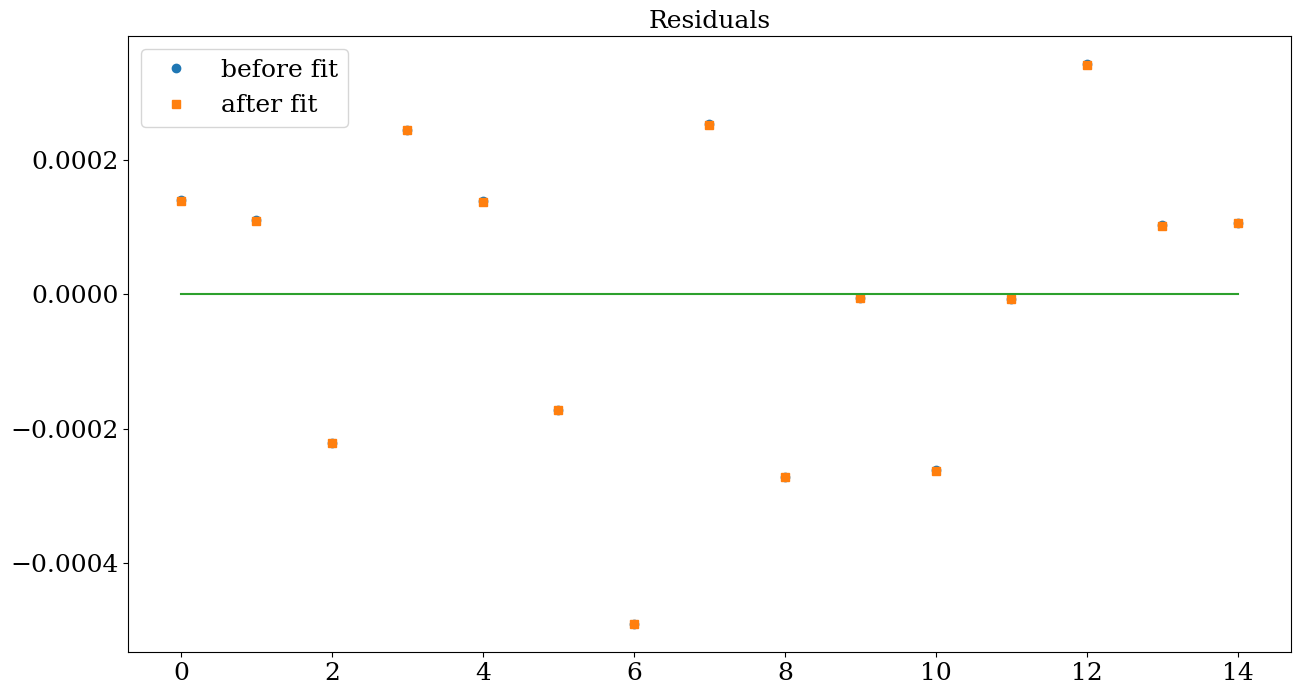

fit residuals standard deviation 0.0002274148280464786
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.758e-07 redchi=5.541e-08 params={'pG2qG_g': 0.0004353725097462655}
  iter 0: chisqr=7.758e-07 redchi=5.541e-08 params={'pG2qG_g': 0.0004353725097462655}
  iter 1: chisqr=7.758e-07 redchi=5.541e-08 params={'pG2qG_g': 0.0004353725097462655}
  iter 2: chisqr=7.758e-07 redchi=5.541e-08 params={'pG2qG_g': 0.00043537686347136295}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'pG2qG_g': 0.00043493778925192796}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'pG2qG_g': 0.0004353725097462655}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002617392 (fixed)
    Gamma_prime_g:  0.0005228974 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        4.3537e-04 +/- 2.9439e-04 (67.62%) (init = 0.0004353725)
    bF_g:          -0.06278061 (fixed)
    c_g:           -0.002537857 (fixed)
    e2Qq0_g:       -0.1083614 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

r

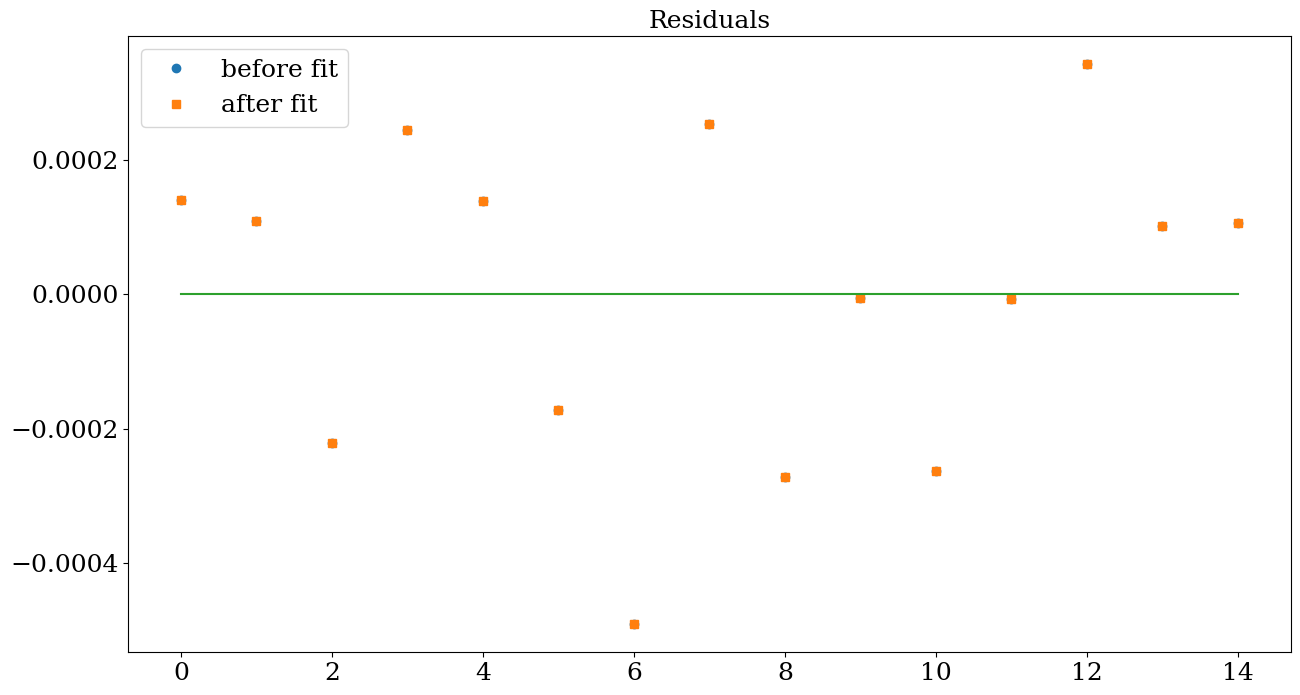

fit residuals standard deviation 0.0002274148280464786
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.758e-07 redchi=5.541e-08 params={'Torg_g': 319.9172819130632}
  iter 0: chisqr=7.758e-07 redchi=5.541e-08 params={'Torg_g': 319.9172819130632}
  iter 1: chisqr=7.758e-07 redchi=5.541e-08 params={'Torg_g': 319.9172819130632}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.92048108588233}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'Torg_g': 319.91728191436584}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'Torg_g': 319.9172819130632}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0779e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002617392 (fixed)
    Gamma_prime_g:  0.0005228974 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06278061 (fixed)
    c_g:           -0.002537857 (fixed)
    e2Qq0_g:       -0.1083614 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.54116114

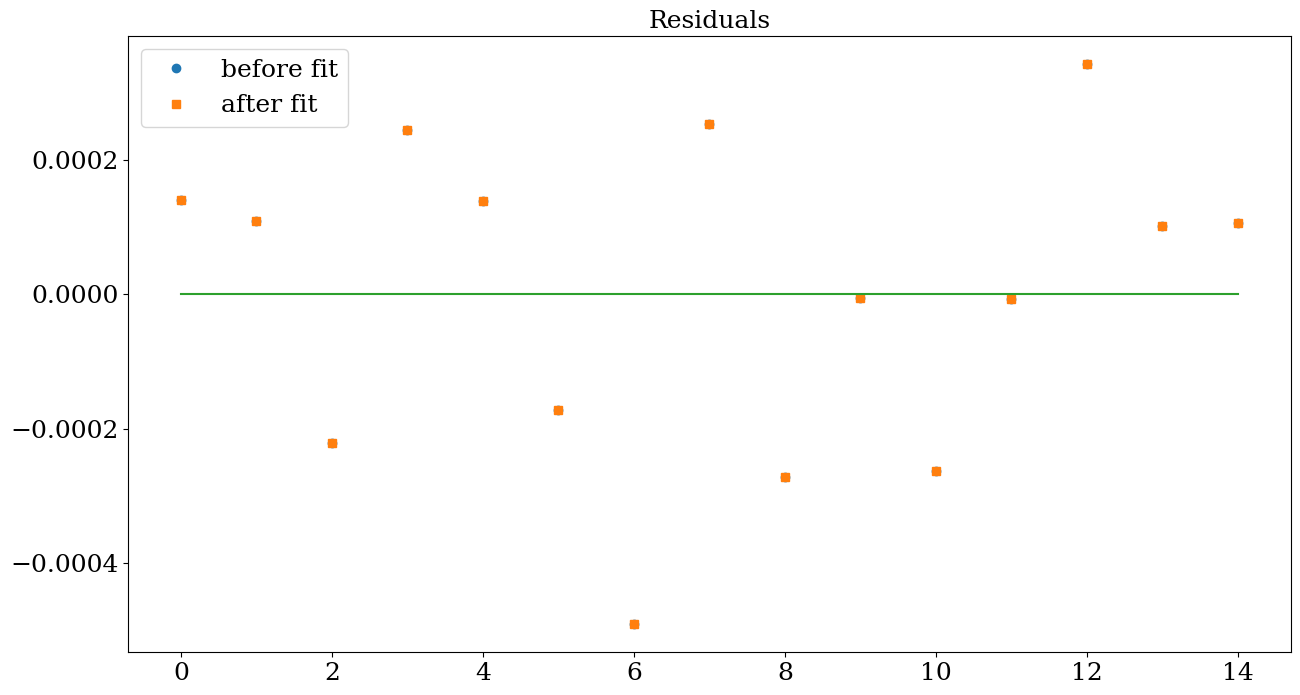

fit residuals standard deviation 0.0002274148280464786
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.758e-07 redchi=5.541e-08 params={'e2Qq0_g': -0.1083614415863679}
  iter 0: chisqr=7.758e-07 redchi=5.541e-08 params={'e2Qq0_g': -0.1083614415863679}
  iter 1: chisqr=7.758e-07 redchi=5.541e-08 params={'e2Qq0_g': -0.1083614415863679}
  iter 2: chisqr=7.758e-07 redchi=5.541e-08 params={'e2Qq0_g': -0.10836035797195204}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'e2Qq0_g': -0.10835488870978999}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'e2Qq0_g': -0.10835488870978999}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002617392 (fixed)
    Gamma_prime_g:  0.0005228974 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06278061 (fixed)
    c_g:           -0.002537857 (fixed)
    e2Qq0_g:       -0.10835489 +/- 0.00101237 (0.93%) (init = -0.1083614)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi 

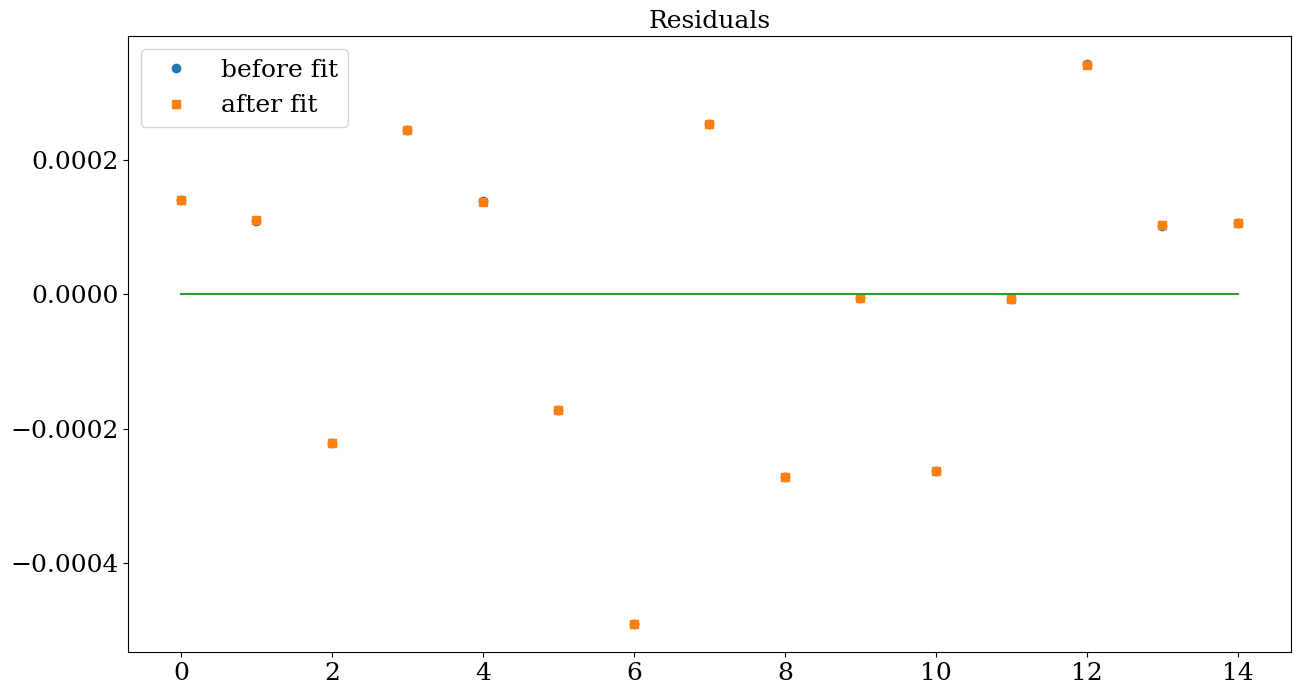

fit residuals standard deviation 0.00022741448555875645
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.758e-07 redchi=5.541e-08 params={'c_g': -0.0025378572063955453}
  iter 0: chisqr=7.758e-07 redchi=5.541e-08 params={'c_g': -0.0025378572063955453}
  iter 1: chisqr=7.758e-07 redchi=5.541e-08 params={'c_g': -0.0025378572063955453}
  iter 2: chisqr=7.758e-07 redchi=5.541e-08 params={'c_g': -0.0025378318278234816}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'c_g': -0.0025400539593184216}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'c_g': -0.0025400539593184216}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002617392 (fixed)
    Gamma_prime_g:  0.0005228974 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06278061 (fixed)
    c_g:           -0.00254005 +/- 3.7853e-04 (14.90%) (init = -0.002537857)
    e2Qq0_g:       -0.1083549 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:

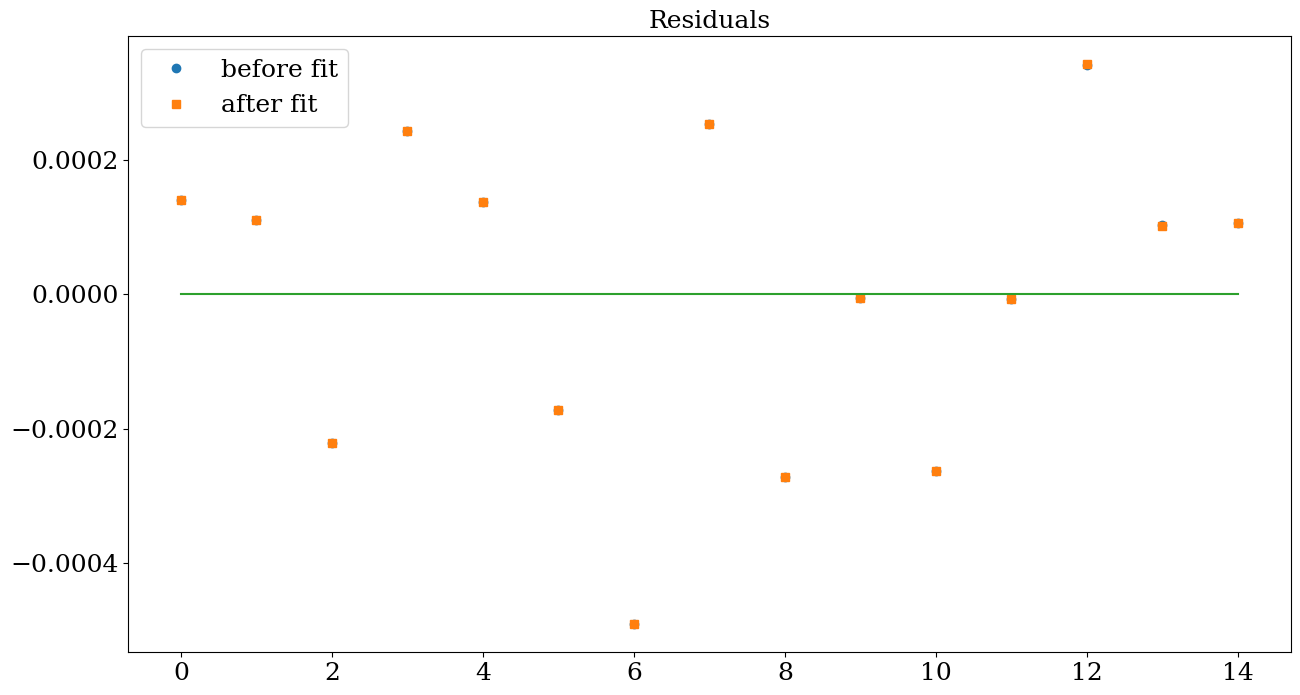

fit residuals standard deviation 0.00022741418758757636
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.758e-07 redchi=5.541e-08 params={'bF_g': -0.06278061000856434}
  iter 0: chisqr=7.758e-07 redchi=5.541e-08 params={'bF_g': -0.06278061000856434}
  iter 1: chisqr=7.758e-07 redchi=5.541e-08 params={'bF_g': -0.06278061000856434}
  iter 2: chisqr=7.758e-07 redchi=5.541e-08 params={'bF_g': -0.06277998220246425}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'bF_g': -0.06278075468705571}
  iter 3: chisqr=7.758e-07 redchi=5.541e-08 params={'bF_g': -0.06278075468705571}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002617392 (fixed)
    Gamma_prime_g:  0.0005228974 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06278075 +/- 3.9559e-05 (0.06%) (init = -0.06278061)
    c_g:           -0.002540054 (fixed)
    e2Qq0_g:       -0.1083549 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.541

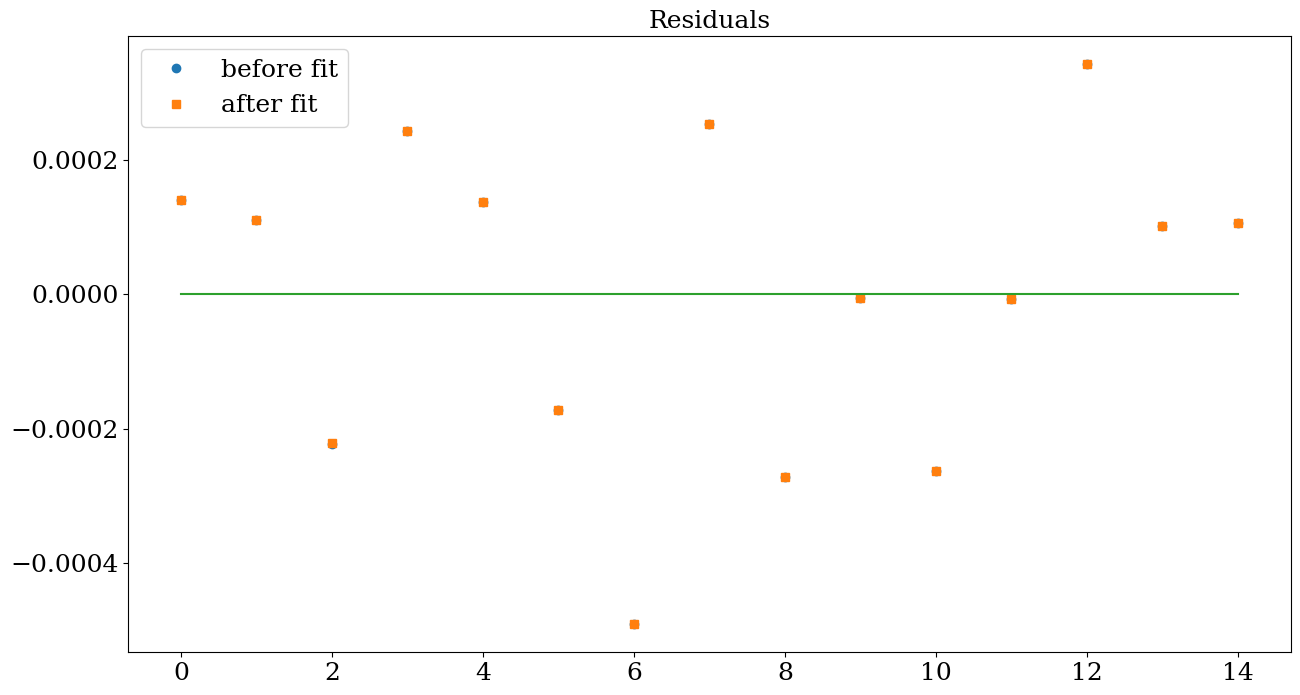

fit residuals standard deviation 0.0002274140679701749
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.758e-07 redchi=5.541e-08 params={'Gamma_SR_g': -0.002617392080249037}
  iter 0: chisqr=7.758e-07 redchi=5.541e-08 params={'Gamma_SR_g': -0.002617392080249037}
  iter 1: chisqr=7.758e-07 redchi=5.541e-08 params={'Gamma_SR_g': -0.002617392080249037}
  iter 2: chisqr=7.758e-07 redchi=5.541e-08 params={'Gamma_SR_g': -0.0026173659063282347}
  iter 3: chisqr=7.756e-07 redchi=5.54e-08 params={'Gamma_SR_g': -0.0026344387920497797}
  iter 3: chisqr=7.756e-07 redchi=5.54e-08 params={'Gamma_SR_g': -0.0026344387920497797}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00263444 +/- 3.0354e-04 (11.52%) (init = -0.002617392)
    Gamma_prime_g:  0.0005228974 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06278075 (fixed)
    c_g:           -0.002540054 (fixed)
    e2Qq0_g:       -0.1083549 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.

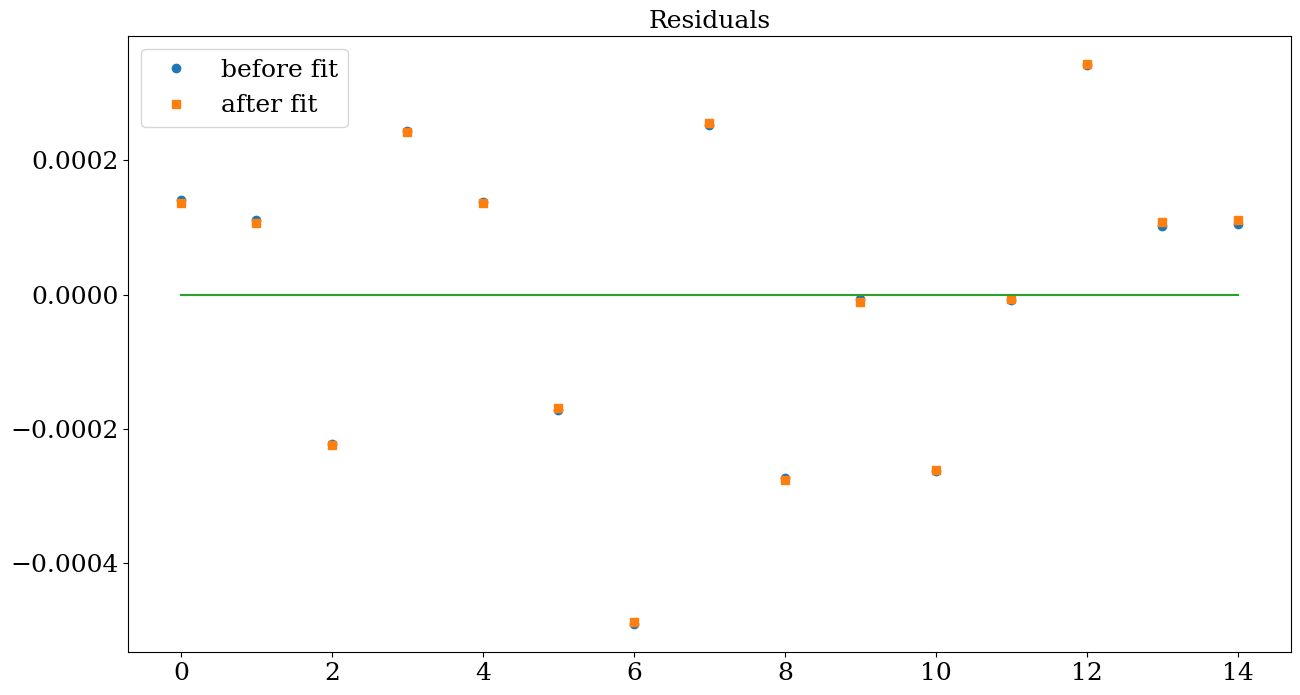

fit residuals standard deviation 0.00022738889118977627
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.756e-07 redchi=5.54e-08 params={'Gamma_prime_g': 0.0005228974286414764}
  iter 0: chisqr=7.756e-07 redchi=5.54e-08 params={'Gamma_prime_g': 0.0005228974286414764}
  iter 1: chisqr=7.756e-07 redchi=5.54e-08 params={'Gamma_prime_g': 0.0005228974286414764}
  iter 2: chisqr=7.756e-07 redchi=5.54e-08 params={'Gamma_prime_g': 0.0005229026576157628}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'Gamma_prime_g': 0.0005392113600380509}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'Gamma_prime_g': 0.0005392113600380509}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002634439 (fixed)
    Gamma_prime_g:  5.3921e-04 +/- 2.9451e-04 (54.62%) (init = 0.0005228974)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06278075 (fixed)
    c_g:           -0.002540054 (fixed)
    e2Qq0_g:       -0.1083549 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_ef

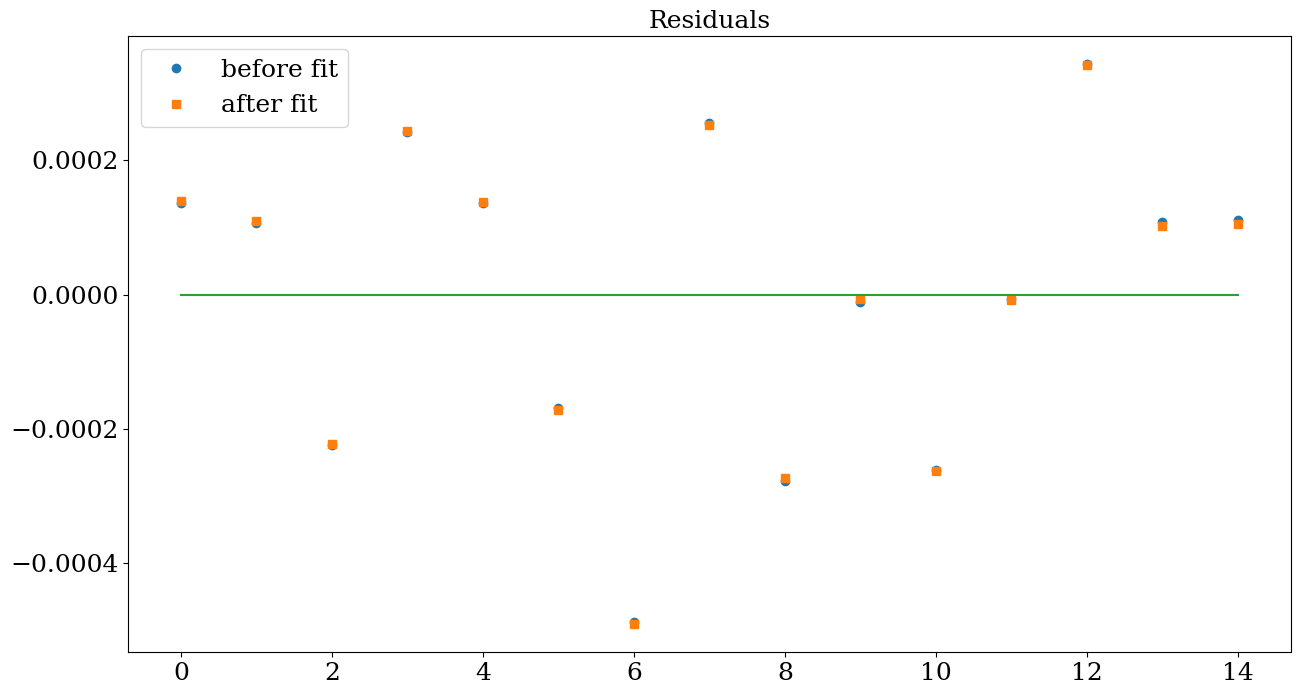

fit residuals standard deviation 0.00022736419722912602
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.754e-07 redchi=5.539e-08 params={'qG_g': 0.00041749056830375704}
  iter 0: chisqr=7.754e-07 redchi=5.539e-08 params={'qG_g': 0.00041749056830375704}
  iter 1: chisqr=7.754e-07 redchi=5.539e-08 params={'qG_g': 0.00041749056830375704}
  iter 2: chisqr=7.754e-07 redchi=5.539e-08 params={'qG_g': 0.0004174947432094401}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'qG_g': 0.0004174965397034047}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'qG_g': 0.00041749056830375704}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002634439 (fixed)
    Gamma_prime_g:  0.0005392114 (fixed)
    qG_g:           4.1749e-04 +/- 6.0811e-05 (14.57%) (init = 0.0004174906)
    pG2qG_g:        0.0004353725 (fixed)
    bF_g:          -0.06278075 (fixed)
    c_g:           -0.002540054 (fixed)
    e2Qq0_g:       -0.1083549 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squar

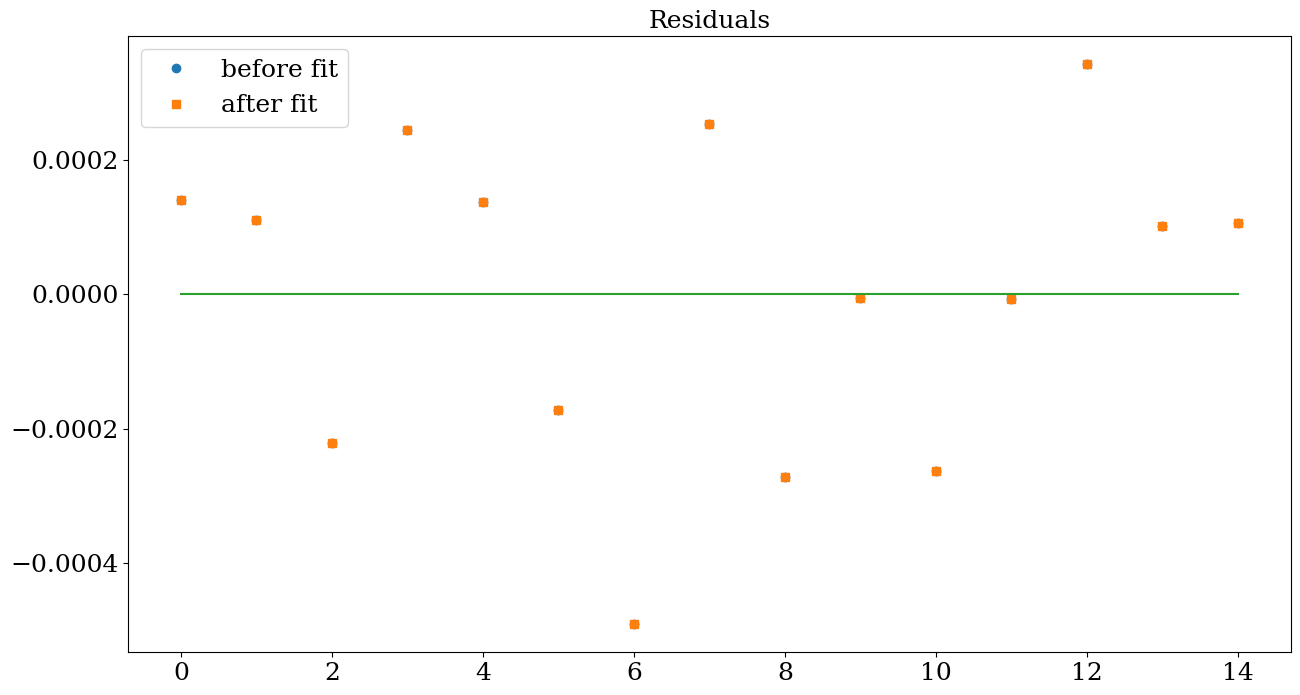

fit residuals standard deviation 0.00022736419722912602
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.754e-07 redchi=5.539e-08 params={'pG2qG_g': 0.0004353725097462655}
  iter 0: chisqr=7.754e-07 redchi=5.539e-08 params={'pG2qG_g': 0.0004353725097462655}
  iter 1: chisqr=7.754e-07 redchi=5.539e-08 params={'pG2qG_g': 0.0004353725097462655}
  iter 2: chisqr=7.754e-07 redchi=5.539e-08 params={'pG2qG_g': 0.00043537686347136295}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'pG2qG_g': 0.0004353885399060834}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'pG2qG_g': 0.0004353885399060834}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002634439 (fixed)
    Gamma_prime_g:  0.0005392114 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        4.3539e-04 +/- 2.9452e-04 (67.65%) (init = 0.0004353725)
    bF_g:          -0.06278075 (fixed)
    c_g:           -0.002540054 (fixed)
    e2Qq0_g:       -0.1083549 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

re

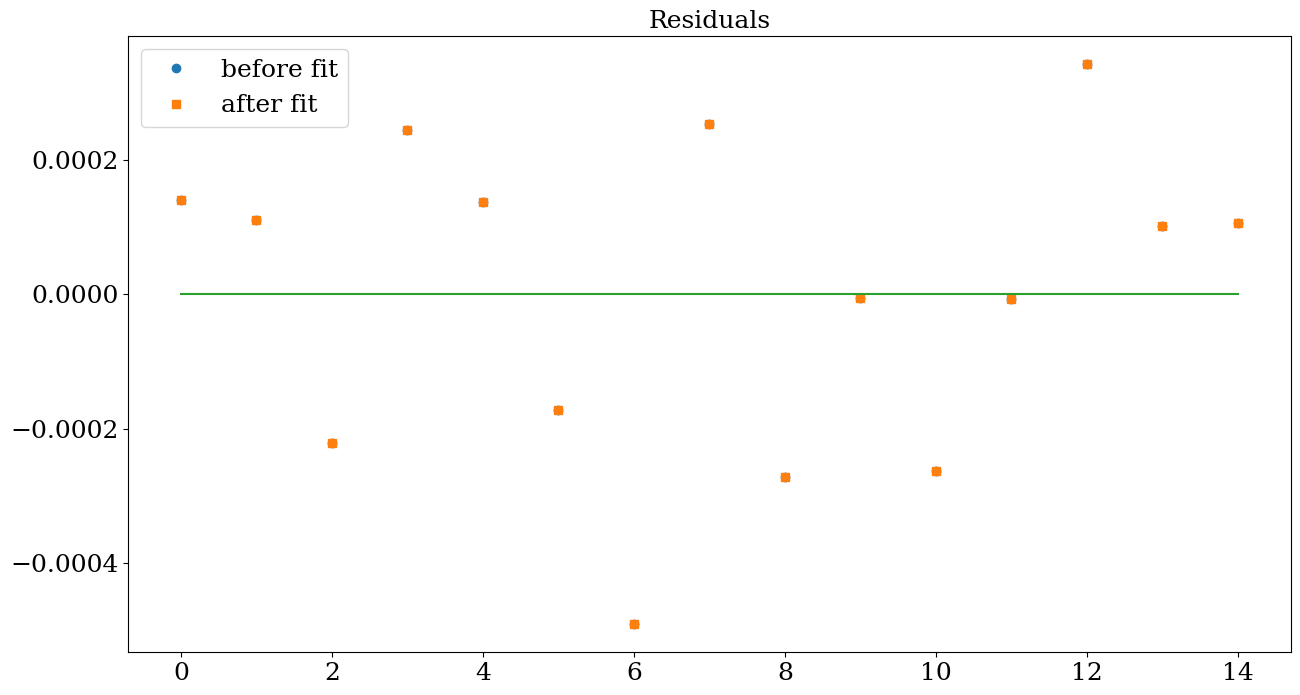

fit residuals standard deviation 0.00022736419707598514
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.754e-07 redchi=5.539e-08 params={'Torg_g': 319.9172819130632}
  iter 0: chisqr=7.754e-07 redchi=5.539e-08 params={'Torg_g': 319.9172819130632}
  iter 1: chisqr=7.754e-07 redchi=5.539e-08 params={'Torg_g': 319.9172819130632}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.92048108588233}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'Torg_g': 319.9172818922074}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'Torg_g': 319.9172818922074}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0766e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002634439 (fixed)
    Gamma_prime_g:  0.0005392114 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353885 (fixed)
    bF_g:          -0.06278075 (fixed)
    c_g:           -0.002540054 (fixed)
    e2Qq0_g:       -0.1083549 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.538694055

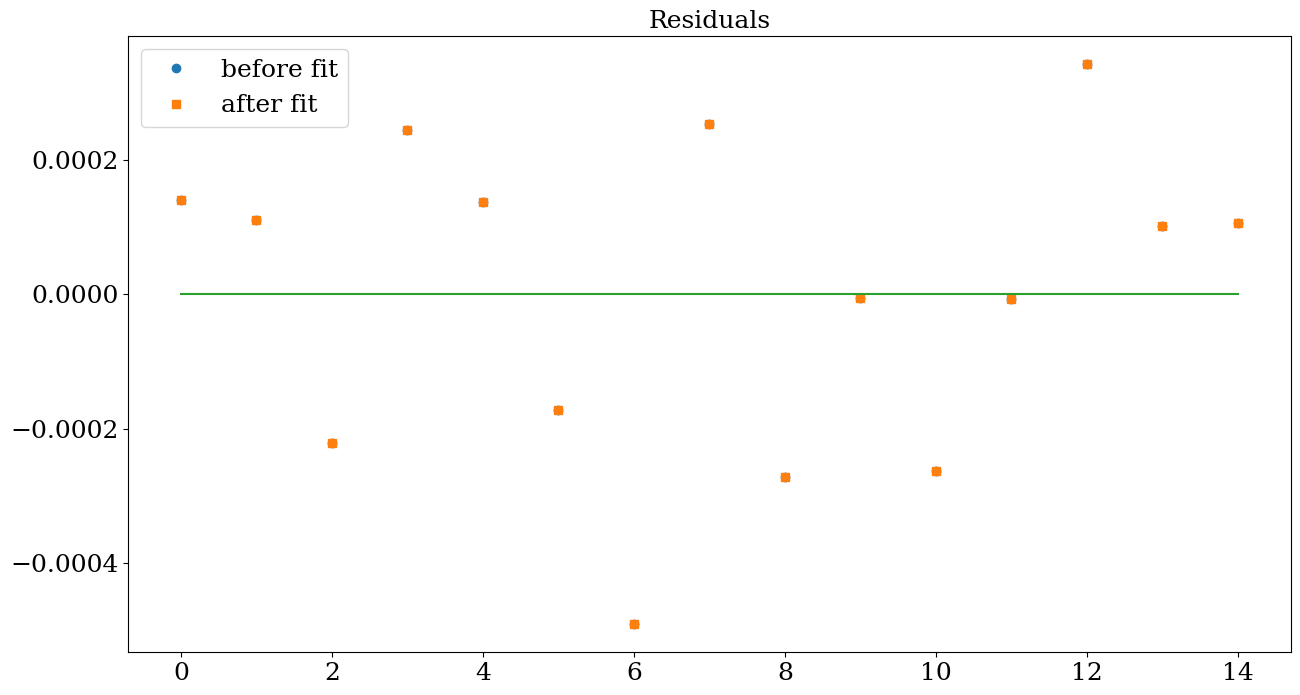

fit residuals standard deviation 0.00022736419651163655
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.754e-07 redchi=5.539e-08 params={'e2Qq0_g': -0.10835488870978999}
  iter 0: chisqr=7.754e-07 redchi=5.539e-08 params={'e2Qq0_g': -0.10835488870978999}
  iter 1: chisqr=7.754e-07 redchi=5.539e-08 params={'e2Qq0_g': -0.10835488870978999}
  iter 2: chisqr=7.754e-07 redchi=5.539e-08 params={'e2Qq0_g': -0.10835380516090289}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'e2Qq0_g': -0.10835323149131557}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'e2Qq0_g': -0.10835323149131557}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002634439 (fixed)
    Gamma_prime_g:  0.0005392114 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353885 (fixed)
    bF_g:          -0.06278075 (fixed)
    c_g:           -0.002540054 (fixed)
    e2Qq0_g:       -0.10835323 +/- 0.00101214 (0.93%) (init = -0.1083549)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced c

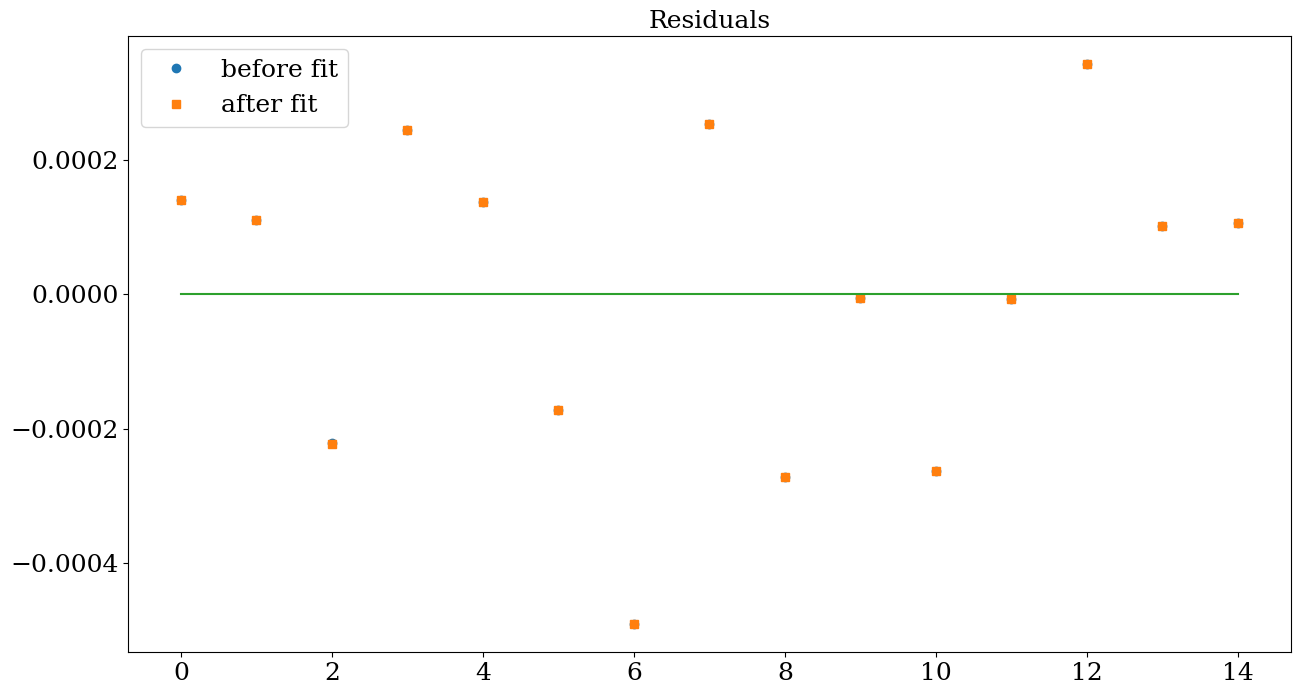

fit residuals standard deviation 0.00022736417501067474
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.754e-07 redchi=5.539e-08 params={'c_g': -0.0025400539593184216}
  iter 0: chisqr=7.754e-07 redchi=5.539e-08 params={'c_g': -0.0025400539593184216}
  iter 1: chisqr=7.754e-07 redchi=5.539e-08 params={'c_g': -0.0025400539593184216}
  iter 2: chisqr=7.754e-07 redchi=5.539e-08 params={'c_g': -0.0025400285587788285}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'c_g': -0.00254095980068885}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'c_g': -0.00254095980068885}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002634439 (fixed)
    Gamma_prime_g:  0.0005392114 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353885 (fixed)
    bF_g:          -0.06278075 (fixed)
    c_g:           -0.00254096 +/- 3.7827e-04 (14.89%) (init = -0.002540054)
    e2Qq0_g:       -0.1083532 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.

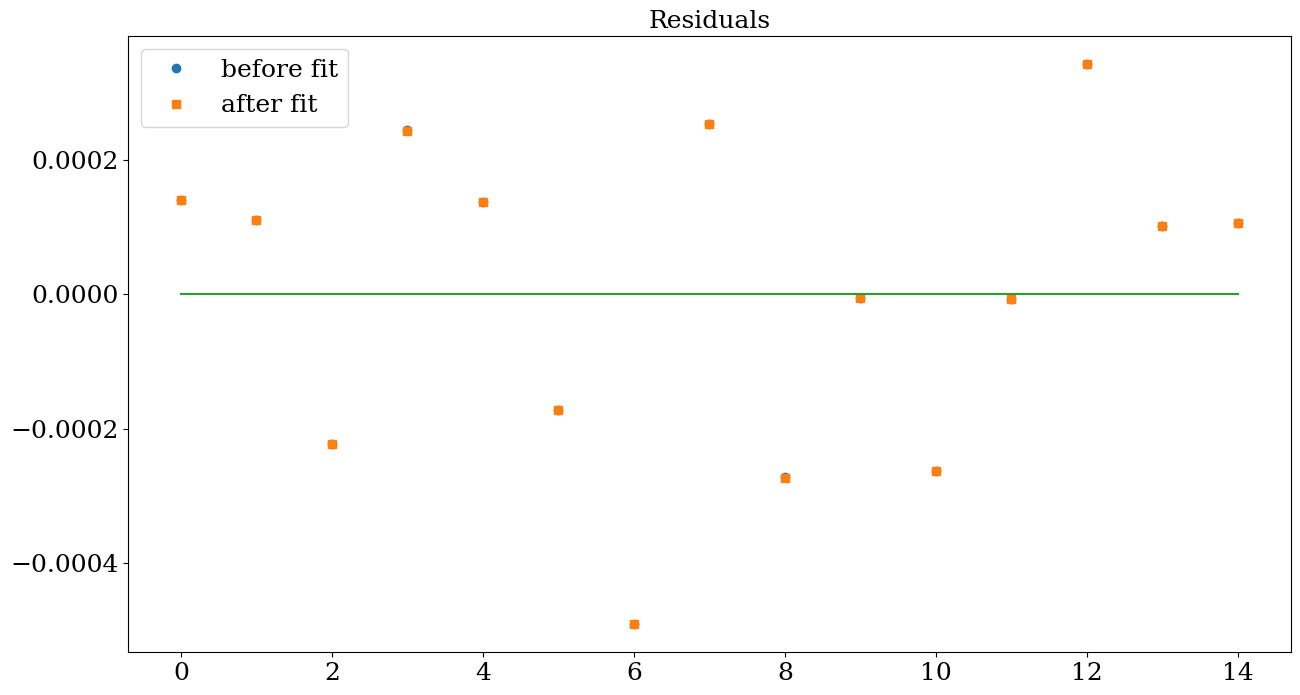

fit residuals standard deviation 0.00022736412108673867
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.754e-07 redchi=5.539e-08 params={'bF_g': -0.06278075468705571}
  iter 0: chisqr=7.754e-07 redchi=5.539e-08 params={'bF_g': -0.06278075468705571}
  iter 1: chisqr=7.754e-07 redchi=5.539e-08 params={'bF_g': -0.06278075468705571}
  iter 2: chisqr=7.754e-07 redchi=5.539e-08 params={'bF_g': -0.06278012687950885}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'bF_g': -0.06278076669358312}
  iter 3: chisqr=7.754e-07 redchi=5.539e-08 params={'bF_g': -0.06278076669358312}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002634439 (fixed)
    Gamma_prime_g:  0.0005392114 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353885 (fixed)
    bF_g:          -0.06278077 +/- 3.9550e-05 (0.06%) (init = -0.06278075)
    c_g:           -0.00254096 (fixed)
    e2Qq0_g:       -0.1083532 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5386

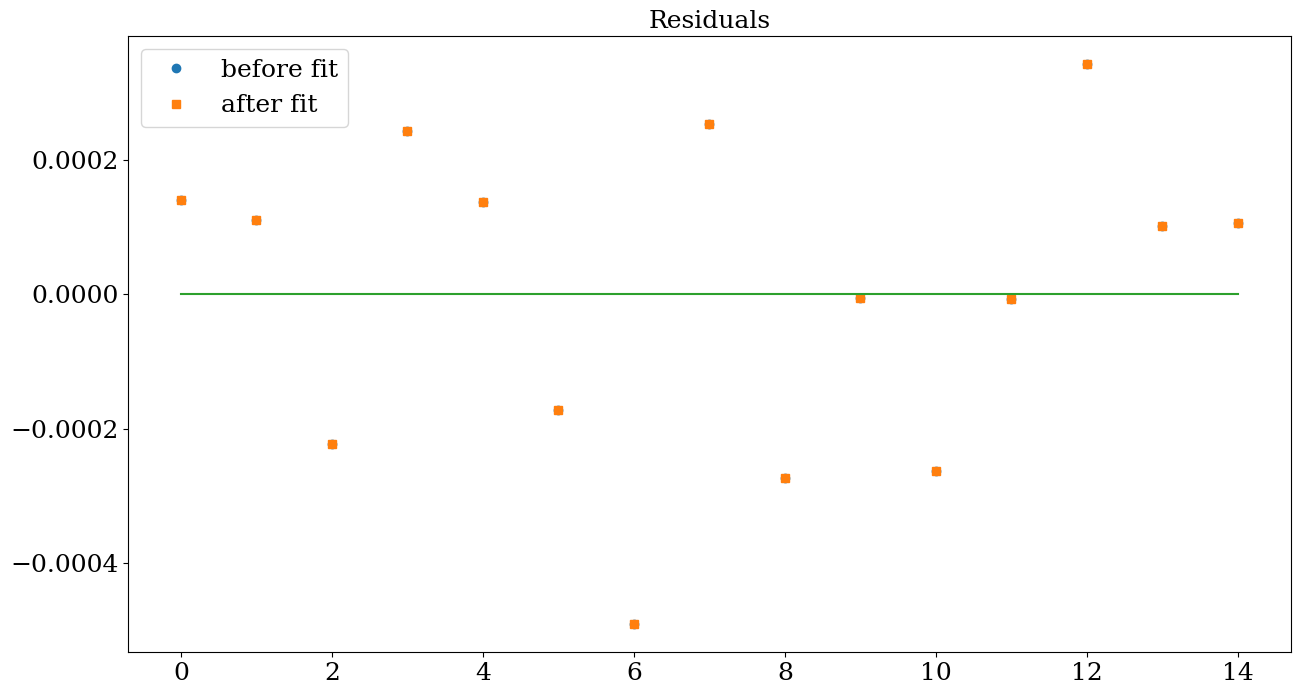

fit residuals standard deviation 0.00022736412006536385
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.754e-07 redchi=5.539e-08 params={'Gamma_SR_g': -0.0026344387920497797}
  iter 0: chisqr=7.754e-07 redchi=5.539e-08 params={'Gamma_SR_g': -0.0026344387920497797}
  iter 1: chisqr=7.754e-07 redchi=5.539e-08 params={'Gamma_SR_g': -0.0026344387920497797}
  iter 2: chisqr=7.754e-07 redchi=5.539e-08 params={'Gamma_SR_g': -0.0026344124476618594}
  iter 3: chisqr=7.752e-07 redchi=5.537e-08 params={'Gamma_SR_g': -0.0026511860052992908}
  iter 3: chisqr=7.752e-07 redchi=5.537e-08 params={'Gamma_SR_g': -0.0026511860052992908}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00265119 +/- 3.0341e-04 (11.44%) (init = -0.002634439)
    Gamma_prime_g:  0.0005392114 (fixed)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353885 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254096 (fixed)
    e2Qq0_g:       -0.1083532 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:    

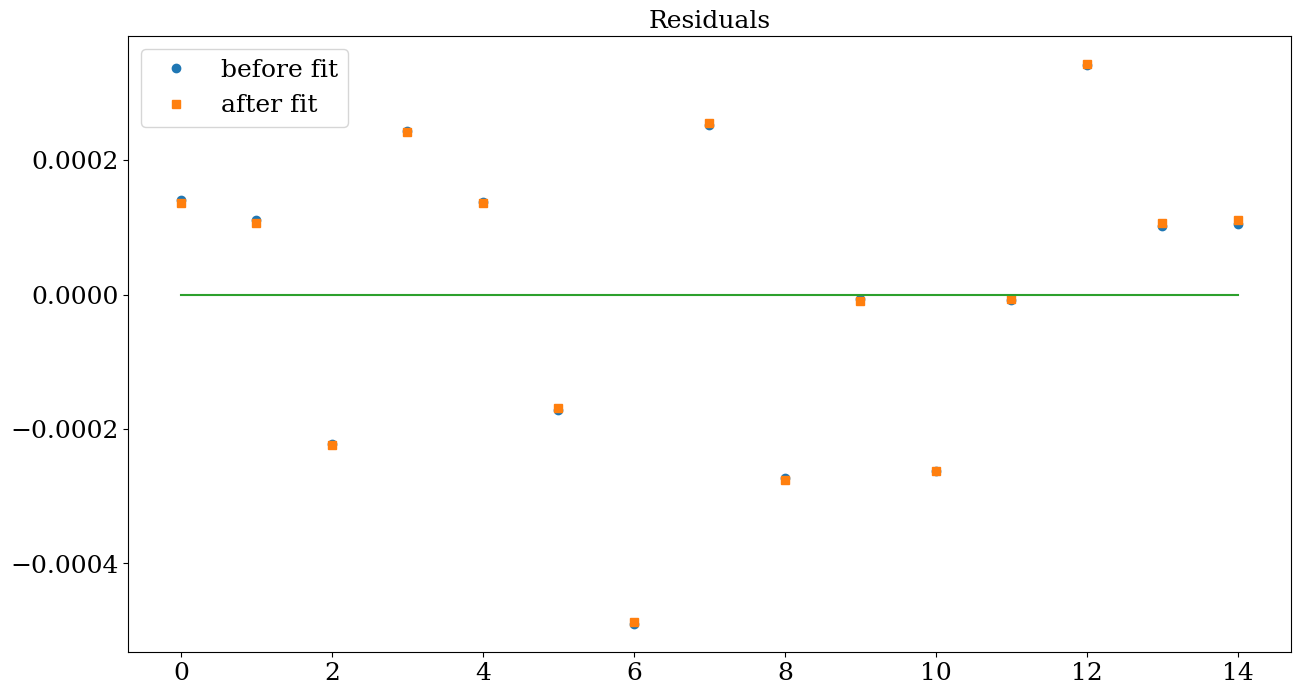

fit residuals standard deviation 0.00022733945364071471
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.752e-07 redchi=5.537e-08 params={'Gamma_prime_g': 0.0005392113600380509}
  iter 0: chisqr=7.752e-07 redchi=5.537e-08 params={'Gamma_prime_g': 0.0005392113600380509}
  iter 1: chisqr=7.752e-07 redchi=5.537e-08 params={'Gamma_prime_g': 0.0005392113600380509}
  iter 2: chisqr=7.752e-07 redchi=5.537e-08 params={'Gamma_prime_g': 0.0005392167521516512}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'Gamma_prime_g': 0.0005554555372146139}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'Gamma_prime_g': 0.0005554555372146139}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002651186 (fixed)
    Gamma_prime_g:  5.5546e-04 +/- 2.9451e-04 (53.02%) (init = 0.0005392114)
    qG_g:           0.0004174906 (fixed)
    pG2qG_g:        0.0004353885 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254096 (fixed)
    e2Qq0_g:       -0.1083532 (fixed)
    muE_g:          1.08737 (fixed)
    g_S

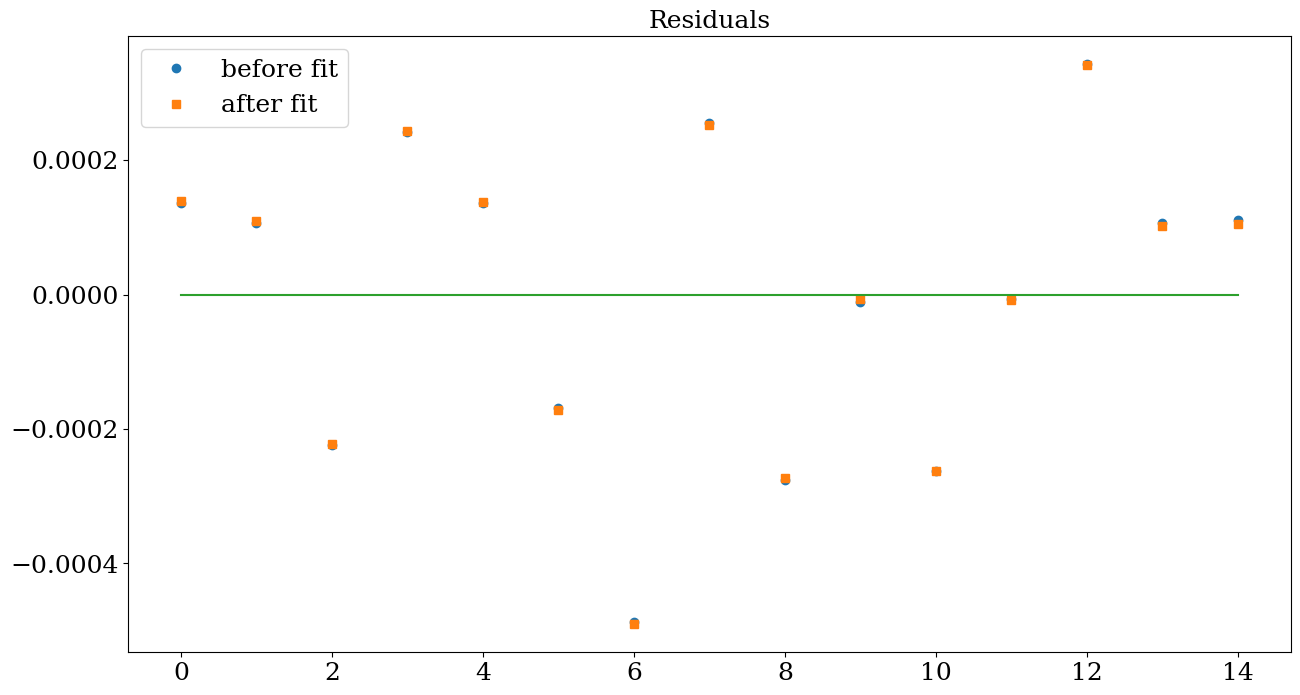

fit residuals standard deviation 0.0002273151491521971
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.751e-07 redchi=5.536e-08 params={'qG_g': 0.00041749056830375704}
  iter 0: chisqr=7.751e-07 redchi=5.536e-08 params={'qG_g': 0.00041749056830375704}
  iter 1: chisqr=7.751e-07 redchi=5.536e-08 params={'qG_g': 0.00041749056830375704}
  iter 2: chisqr=7.751e-07 redchi=5.536e-08 params={'qG_g': 0.0004174947432094401}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'qG_g': 0.0004175200870914953}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'qG_g': 0.0004175200870914953}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002651186 (fixed)
    Gamma_prime_g:  0.0005554555 (fixed)
    qG_g:           4.1752e-04 +/- 6.0812e-05 (14.57%) (init = 0.0004174906)
    pG2qG_g:        0.0004353885 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254096 (fixed)
    e2Qq0_g:       -0.1083532 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared

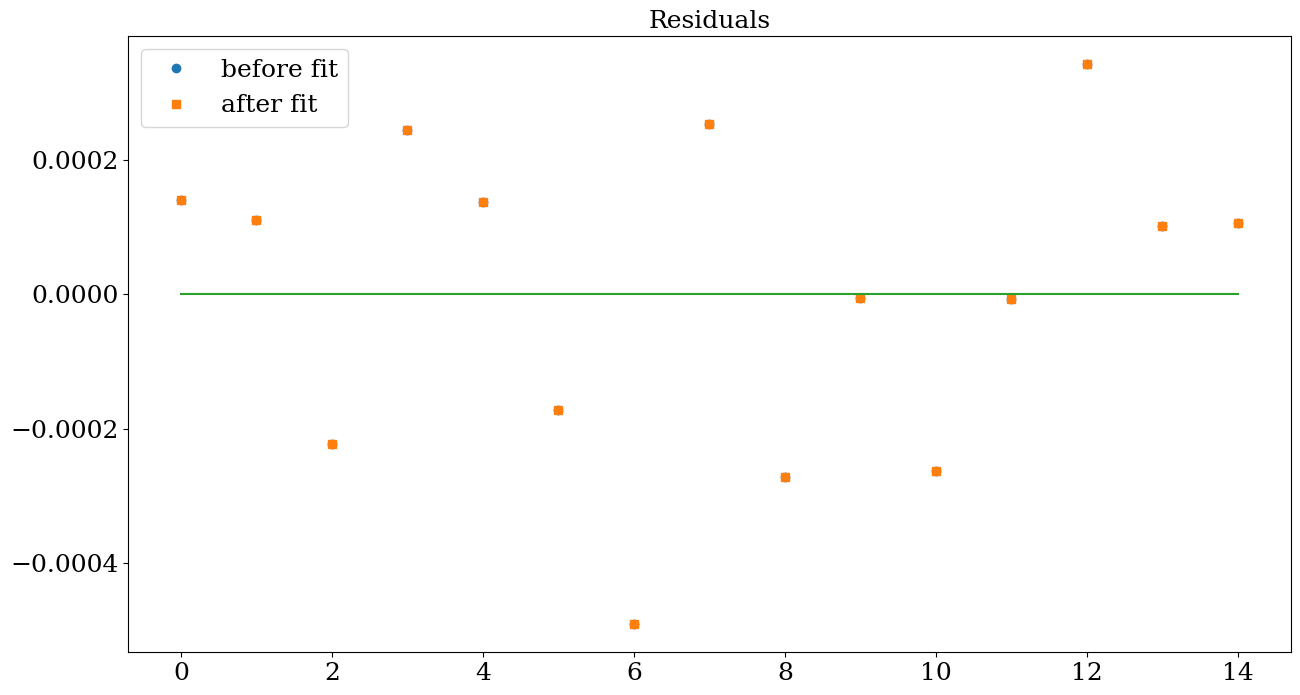

fit residuals standard deviation 0.00022731514717301224
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.751e-07 redchi=5.536e-08 params={'pG2qG_g': 0.0004353885399060834}
  iter 0: chisqr=7.751e-07 redchi=5.536e-08 params={'pG2qG_g': 0.0004353885399060834}
  iter 1: chisqr=7.751e-07 redchi=5.536e-08 params={'pG2qG_g': 0.0004353885399060834}
  iter 2: chisqr=7.751e-07 redchi=5.536e-08 params={'pG2qG_g': 0.0004353928937914825}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'pG2qG_g': 0.0004356819924813346}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002651186 (fixed)
    Gamma_prime_g:  0.0005554555 (fixed)
    qG_g:           0.0004175201 (fixed)
    pG2qG_g:        4.3568e-04 +/- 2.9436e-04 (67.56%) (init = 0.0004353885)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254096 (fixed)
    e2Qq0_g:       -0.1083532 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

redu

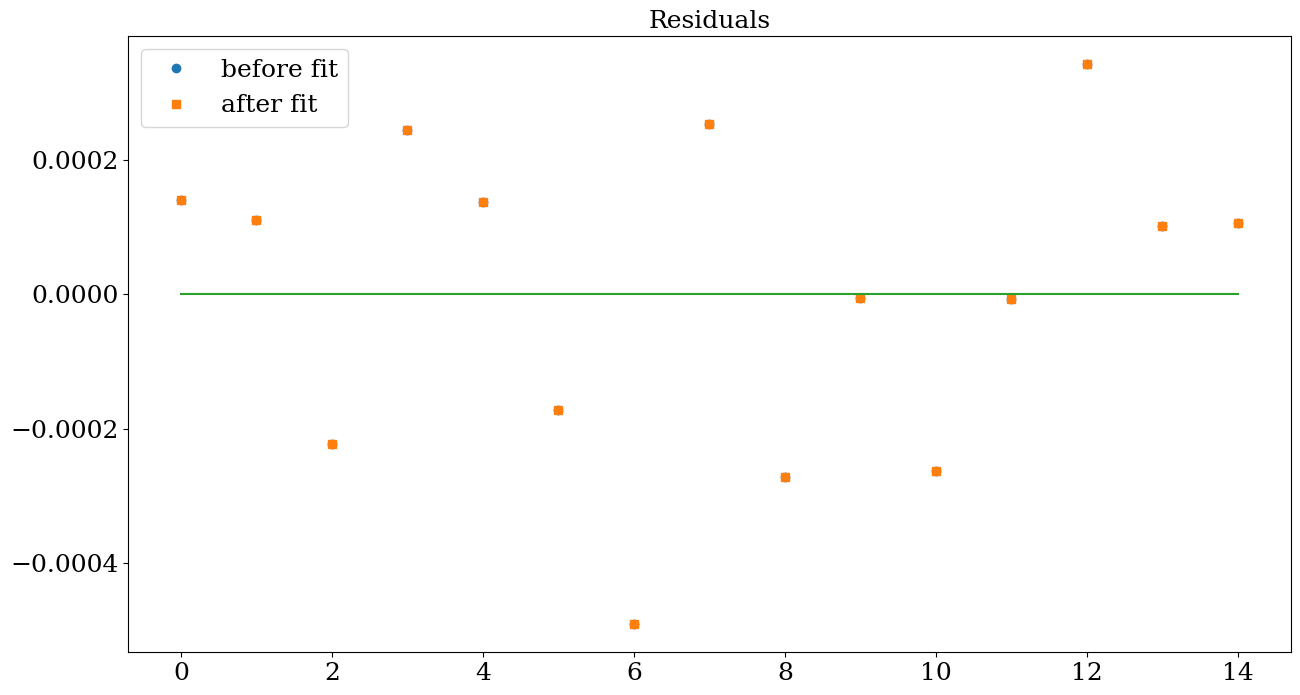

fit residuals standard deviation 0.0002273151423880299
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.751e-07 redchi=5.536e-08 params={'Torg_g': 319.9172818922074}
  iter 0: chisqr=7.751e-07 redchi=5.536e-08 params={'Torg_g': 319.9172818922074}
  iter 1: chisqr=7.751e-07 redchi=5.536e-08 params={'Torg_g': 319.9172818922074}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.92048106502637}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'Torg_g': 319.91728189909844}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'Torg_g': 319.9172818922074}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0753e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002651186 (fixed)
    Gamma_prime_g:  0.0005554555 (fixed)
    qG_g:           0.0004175201 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254096 (fixed)
    e2Qq0_g:       -0.1083532 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5363043578

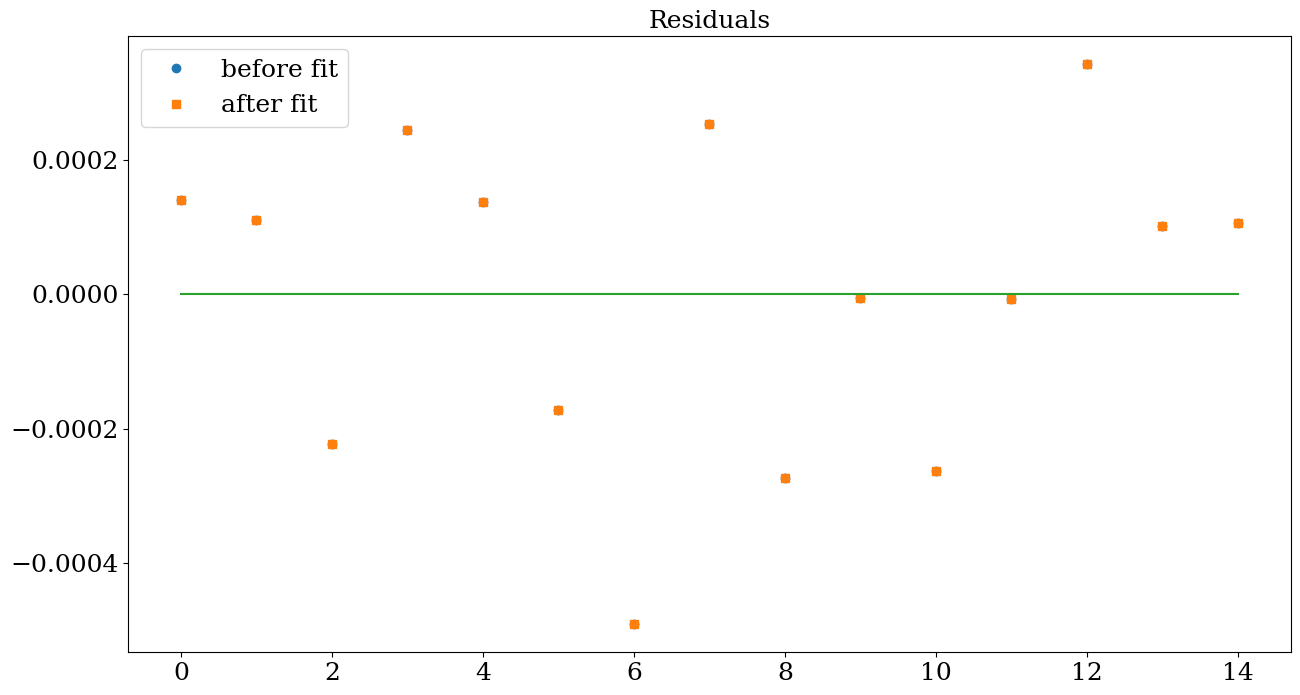

fit residuals standard deviation 0.0002273151423880299
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.751e-07 redchi=5.536e-08 params={'e2Qq0_g': -0.10835323149131557}
  iter 0: chisqr=7.751e-07 redchi=5.536e-08 params={'e2Qq0_g': -0.10835323149131557}
  iter 1: chisqr=7.751e-07 redchi=5.536e-08 params={'e2Qq0_g': -0.10835323149131557}
  iter 2: chisqr=7.751e-07 redchi=5.536e-08 params={'e2Qq0_g': -0.10835214795900065}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'e2Qq0_g': -0.10835244644946672}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'e2Qq0_g': -0.10835244644946672}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002651186 (fixed)
    Gamma_prime_g:  0.0005554555 (fixed)
    qG_g:           0.0004175201 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254096 (fixed)
    e2Qq0_g:       -0.10835245 +/- 0.00101193 (0.93%) (init = -0.1083532)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi

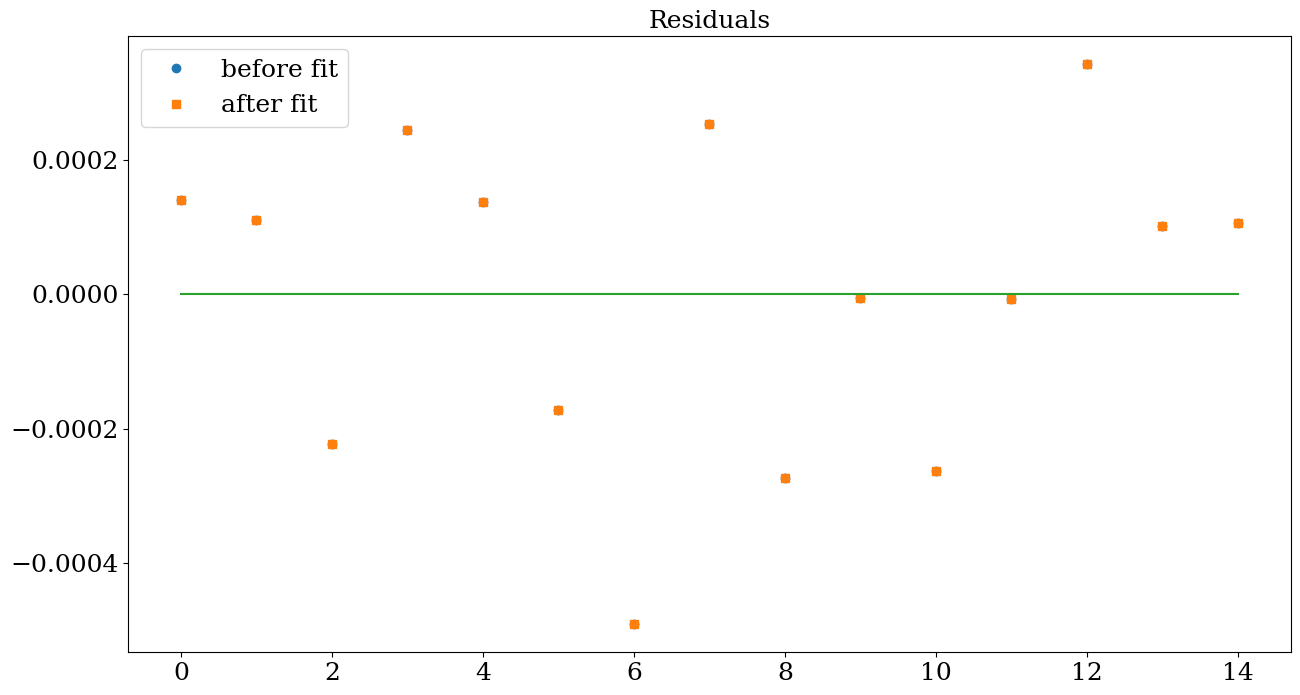

fit residuals standard deviation 0.0002273151377176387
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.751e-07 redchi=5.536e-08 params={'c_g': -0.00254095980068885}
  iter 0: chisqr=7.751e-07 redchi=5.536e-08 params={'c_g': -0.00254095980068885}
  iter 1: chisqr=7.751e-07 redchi=5.536e-08 params={'c_g': -0.00254095980068885}
  iter 2: chisqr=7.751e-07 redchi=5.536e-08 params={'c_g': -0.002540934391090843}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'c_g': -0.002541733154581729}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'c_g': -0.002541733154581729}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002651186 (fixed)
    Gamma_prime_g:  0.0005554555 (fixed)
    qG_g:           0.0004175201 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254173 +/- 3.7817e-04 (14.88%) (init = -0.00254096)
    e2Qq0_g:       -0.1083524 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5363024

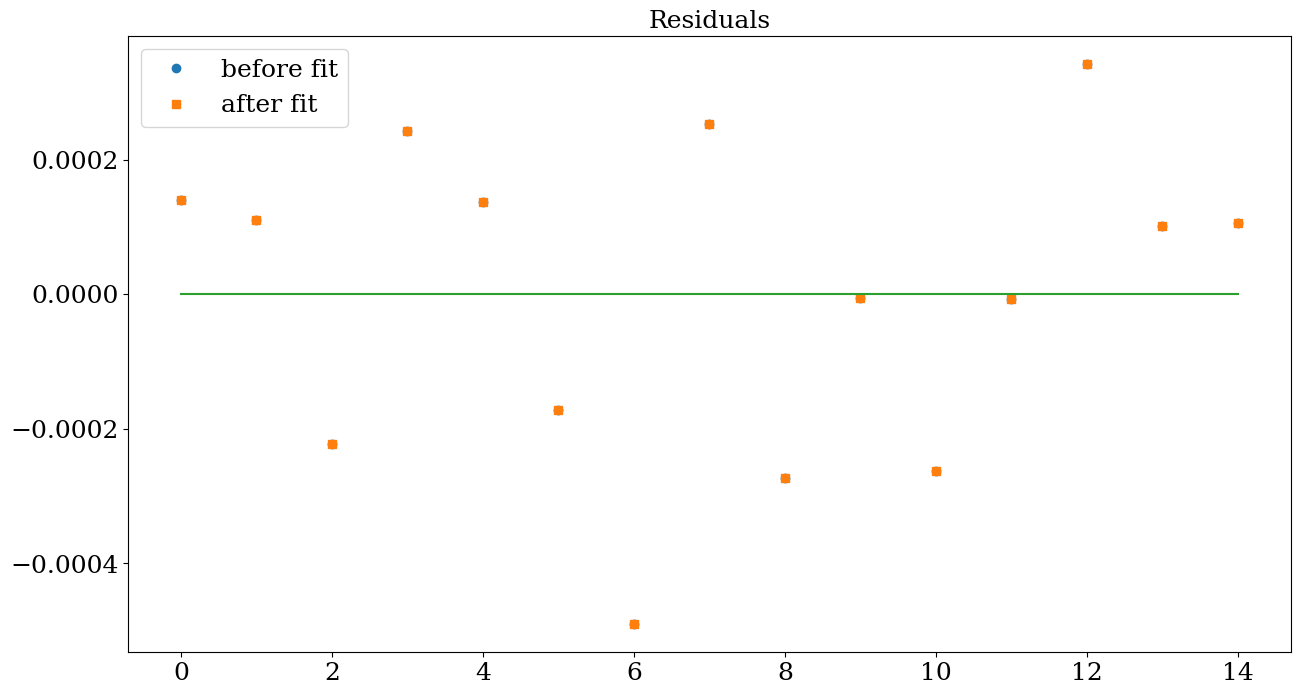

fit residuals standard deviation 0.00022731510234686312
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.751e-07 redchi=5.536e-08 params={'bF_g': -0.06278076669358312}
  iter 0: chisqr=7.751e-07 redchi=5.536e-08 params={'bF_g': -0.06278076669358312}
  iter 1: chisqr=7.751e-07 redchi=5.536e-08 params={'bF_g': -0.06278076669358312}
  iter 2: chisqr=7.751e-07 redchi=5.536e-08 params={'bF_g': -0.06278013888591619}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'bF_g': -0.06278077354421695}
  iter 3: chisqr=7.751e-07 redchi=5.536e-08 params={'bF_g': -0.06278077354421695}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002651186 (fixed)
    Gamma_prime_g:  0.0005554555 (fixed)
    qG_g:           0.0004175201 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 +/- 3.9542e-05 (0.06%) (init = -0.06278077)
    c_g:           -0.002541733 (fixed)
    e2Qq0_g:       -0.1083524 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5363

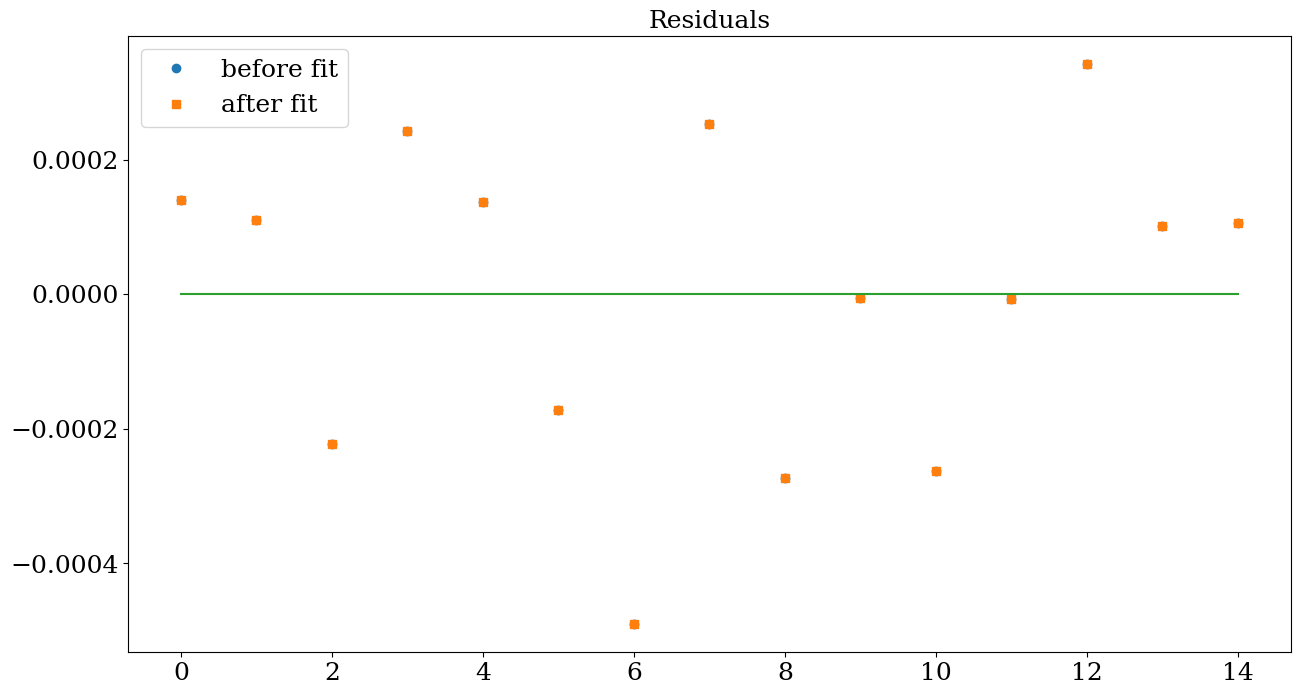

fit residuals standard deviation 0.0002273151022331308
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.751e-07 redchi=5.536e-08 params={'Gamma_SR_g': -0.0026511860052992908}
  iter 0: chisqr=7.751e-07 redchi=5.536e-08 params={'Gamma_SR_g': -0.0026511860052992908}
  iter 1: chisqr=7.751e-07 redchi=5.536e-08 params={'Gamma_SR_g': -0.0026511860052992908}
  iter 2: chisqr=7.751e-07 redchi=5.536e-08 params={'Gamma_SR_g': -0.002651159493439238}
  iter 3: chisqr=7.749e-07 redchi=5.535e-08 params={'Gamma_SR_g': -0.0026676726718488715}
  iter 3: chisqr=7.749e-07 redchi=5.535e-08 params={'Gamma_SR_g': -0.0026676726718488715}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00266767 +/- 3.0337e-04 (11.37%) (init = -0.002651186)
    Gamma_prime_g:  0.0005554555 (fixed)
    qG_g:           0.0004175201 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002541733 (fixed)
    e2Qq0_g:       -0.1083524 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:     

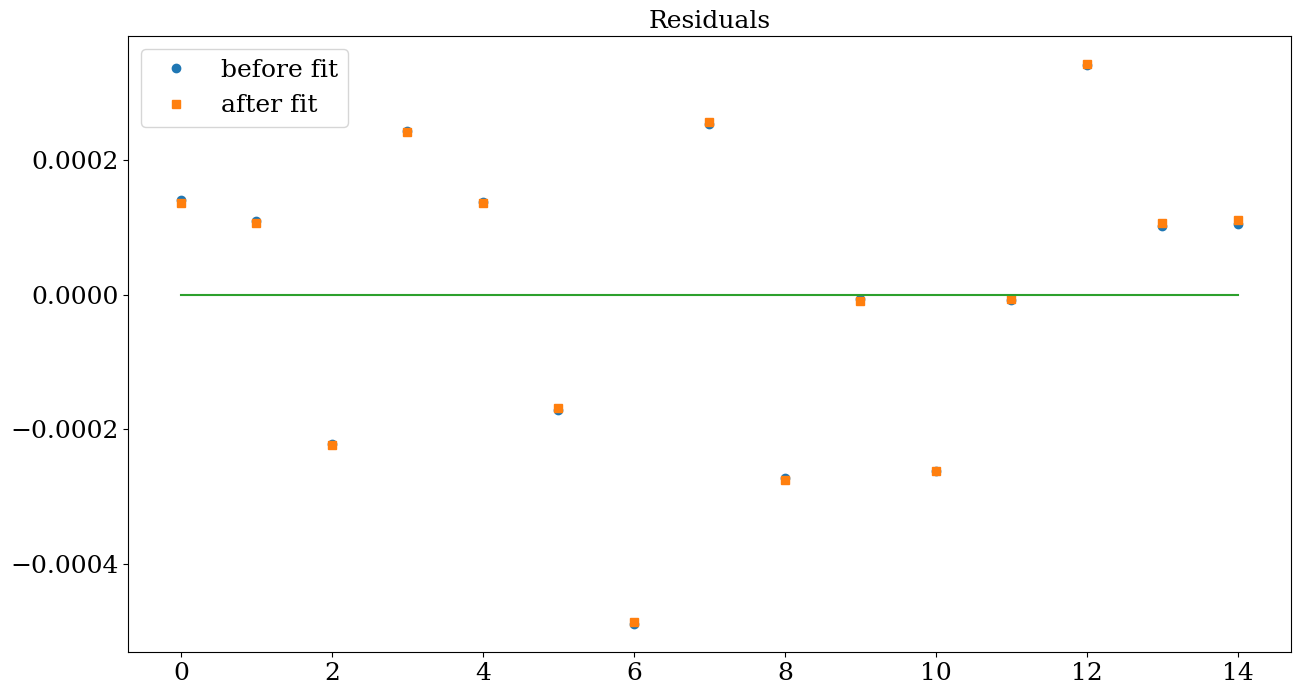

fit residuals standard deviation 0.0002272911390200208
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.749e-07 redchi=5.535e-08 params={'Gamma_prime_g': 0.0005554555372146139}
  iter 0: chisqr=7.749e-07 redchi=5.535e-08 params={'Gamma_prime_g': 0.0005554555372146139}
  iter 1: chisqr=7.749e-07 redchi=5.535e-08 params={'Gamma_prime_g': 0.0005554555372146139}
  iter 2: chisqr=7.749e-07 redchi=5.535e-08 params={'Gamma_prime_g': 0.0005554610917699861}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'Gamma_prime_g': 0.0005714946428327913}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'Gamma_prime_g': 0.0005714946428327913}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002667673 (fixed)
    Gamma_prime_g:  5.7149e-04 +/- 2.9433e-04 (51.50%) (init = 0.0005554555)
    qG_g:           0.0004175201 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002541733 (fixed)
    e2Qq0_g:       -0.1083524 (fixed)
    muE_g:          1.08737 (fixed)
    g_S

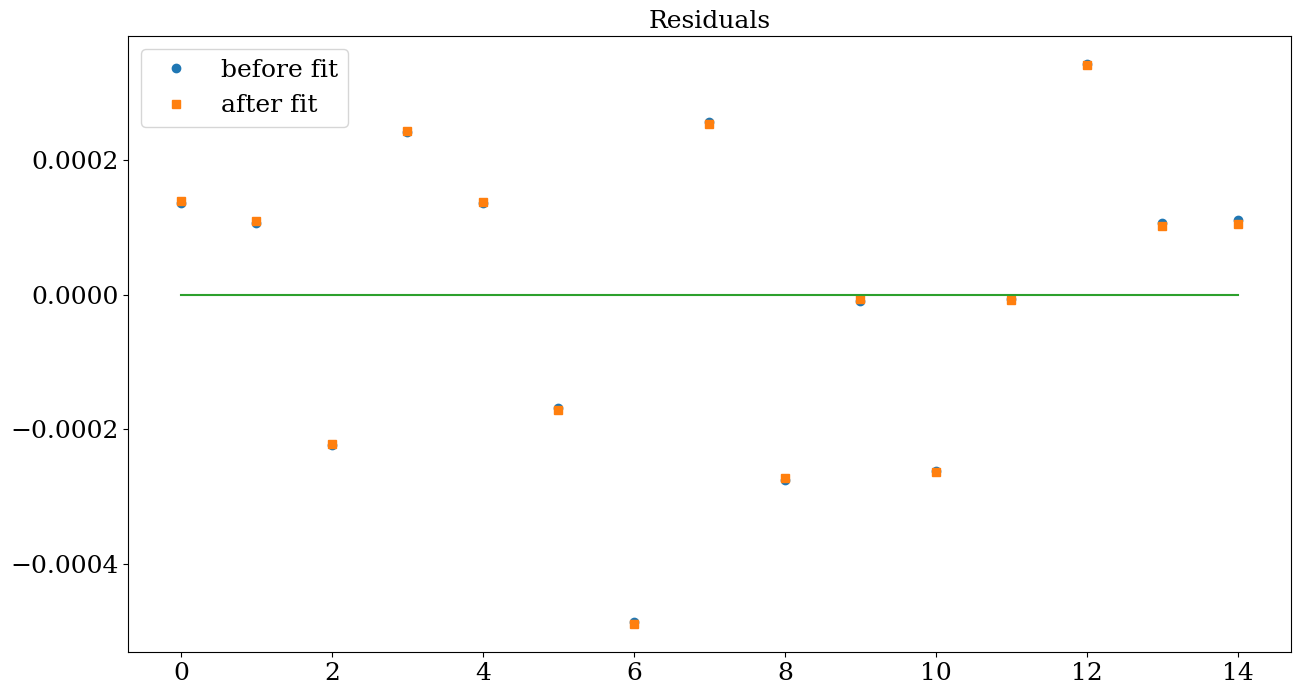

fit residuals standard deviation 0.0002272669196135431
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.748e-07 redchi=5.534e-08 params={'qG_g': 0.0004175200870914953}
  iter 0: chisqr=7.748e-07 redchi=5.534e-08 params={'qG_g': 0.0004175200870914953}
  iter 1: chisqr=7.748e-07 redchi=5.534e-08 params={'qG_g': 0.0004175200870914953}
  iter 2: chisqr=7.748e-07 redchi=5.534e-08 params={'qG_g': 0.0004175242622923662}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'qG_g': 0.000417608764872776}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'qG_g': 0.000417608764872776}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002667673 (fixed)
    Gamma_prime_g:  0.0005714946 (fixed)
    qG_g:           4.1761e-04 +/- 6.0796e-05 (14.56%) (init = 0.0004175201)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002541733 (fixed)
    e2Qq0_g:       -0.1083524 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.

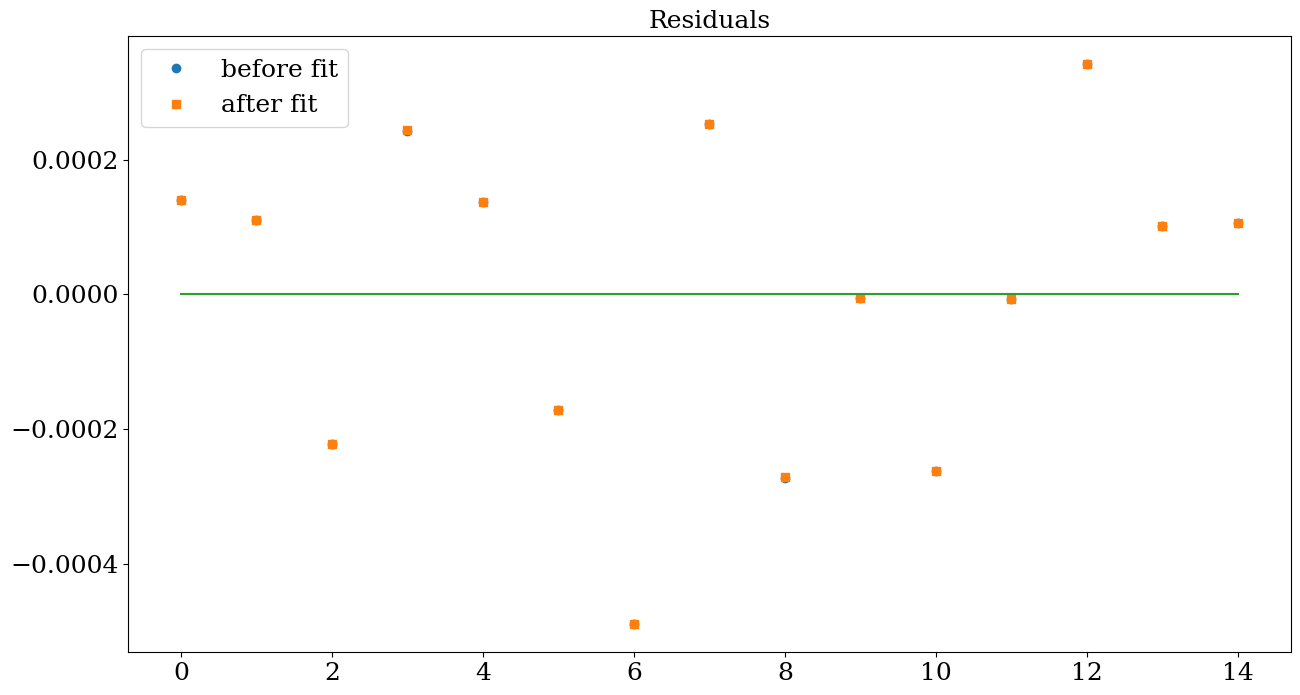

fit residuals standard deviation 0.00022726691221994772
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.748e-07 redchi=5.534e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 0: chisqr=7.748e-07 redchi=5.534e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 1: chisqr=7.748e-07 redchi=5.534e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 2: chisqr=7.748e-07 redchi=5.534e-08 params={'pG2qG_g': 0.0004356863493012594}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'pG2qG_g': 0.0004353306414022379}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'pG2qG_g': 0.0004356819924813346}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002667673 (fixed)
    Gamma_prime_g:  0.0005714946 (fixed)
    qG_g:           0.0004176088 (fixed)
    pG2qG_g:        4.3568e-04 +/- 2.9421e-04 (67.53%) (init = 0.000435682)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002541733 (fixed)
    e2Qq0_g:       -0.1083524 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

redu

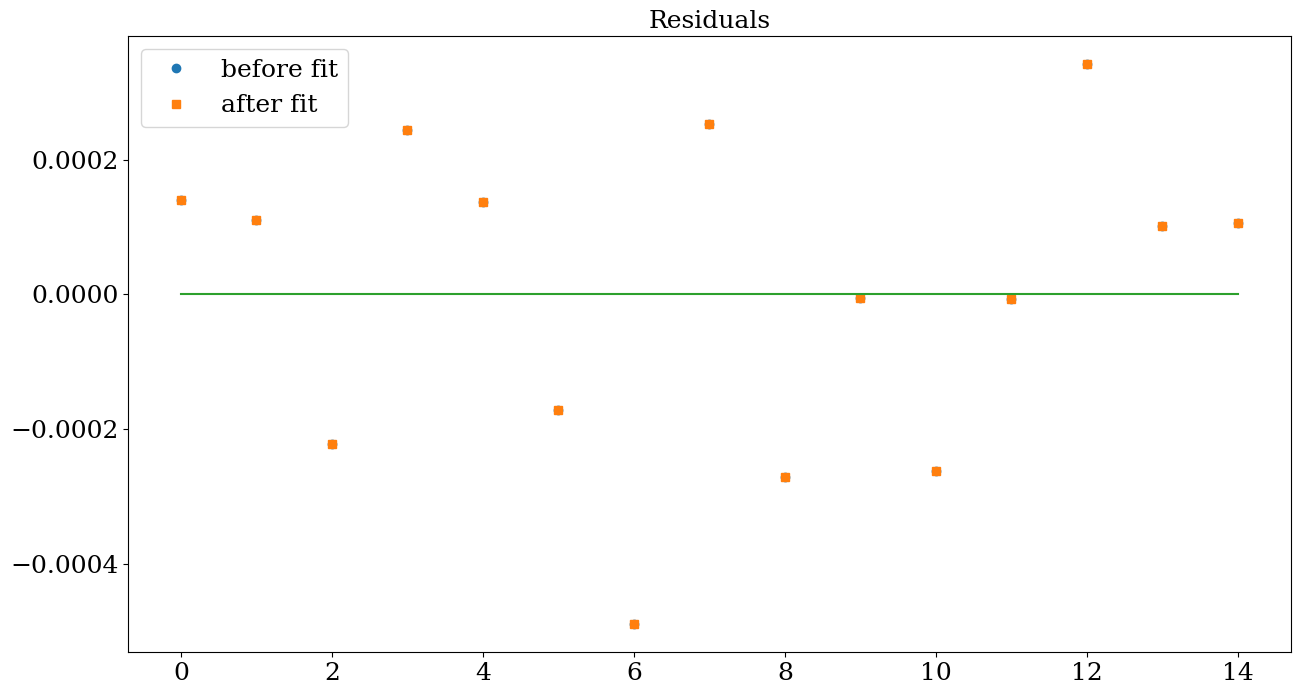

fit residuals standard deviation 0.00022726691221994772
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.748e-07 redchi=5.534e-08 params={'Torg_g': 319.9172818922074}
  iter 0: chisqr=7.748e-07 redchi=5.534e-08 params={'Torg_g': 319.9172818922074}
  iter 1: chisqr=7.748e-07 redchi=5.534e-08 params={'Torg_g': 319.9172818922074}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.92048106502637}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'Torg_g': 319.91728185357016}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'Torg_g': 319.91728185357016}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0740e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002667673 (fixed)
    Gamma_prime_g:  0.0005714946 (fixed)
    qG_g:           0.0004176088 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002541733 (fixed)
    e2Qq0_g:       -0.1083524 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.53395528

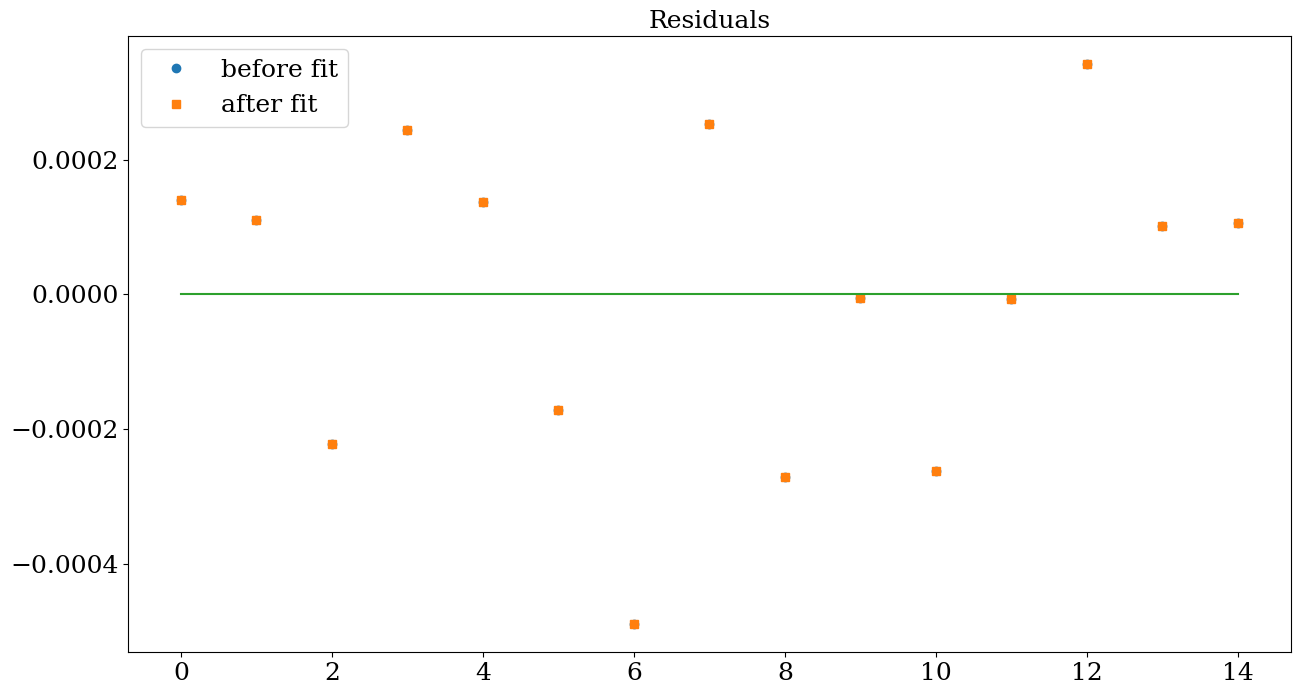

fit residuals standard deviation 0.00022726691212626962
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.748e-07 redchi=5.534e-08 params={'e2Qq0_g': -0.10835244644946672}
  iter 0: chisqr=7.748e-07 redchi=5.534e-08 params={'e2Qq0_g': -0.10835244644946672}
  iter 1: chisqr=7.748e-07 redchi=5.534e-08 params={'e2Qq0_g': -0.10835244644946672}
  iter 2: chisqr=7.748e-07 redchi=5.534e-08 params={'e2Qq0_g': -0.10835136292500222}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'e2Qq0_g': -0.10835169345793734}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'e2Qq0_g': -0.10835169345793734}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002667673 (fixed)
    Gamma_prime_g:  0.0005714946 (fixed)
    qG_g:           0.0004176088 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002541733 (fixed)
    e2Qq0_g:       -0.10835169 +/- 0.00101172 (0.93%) (init = -0.1083524)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced ch

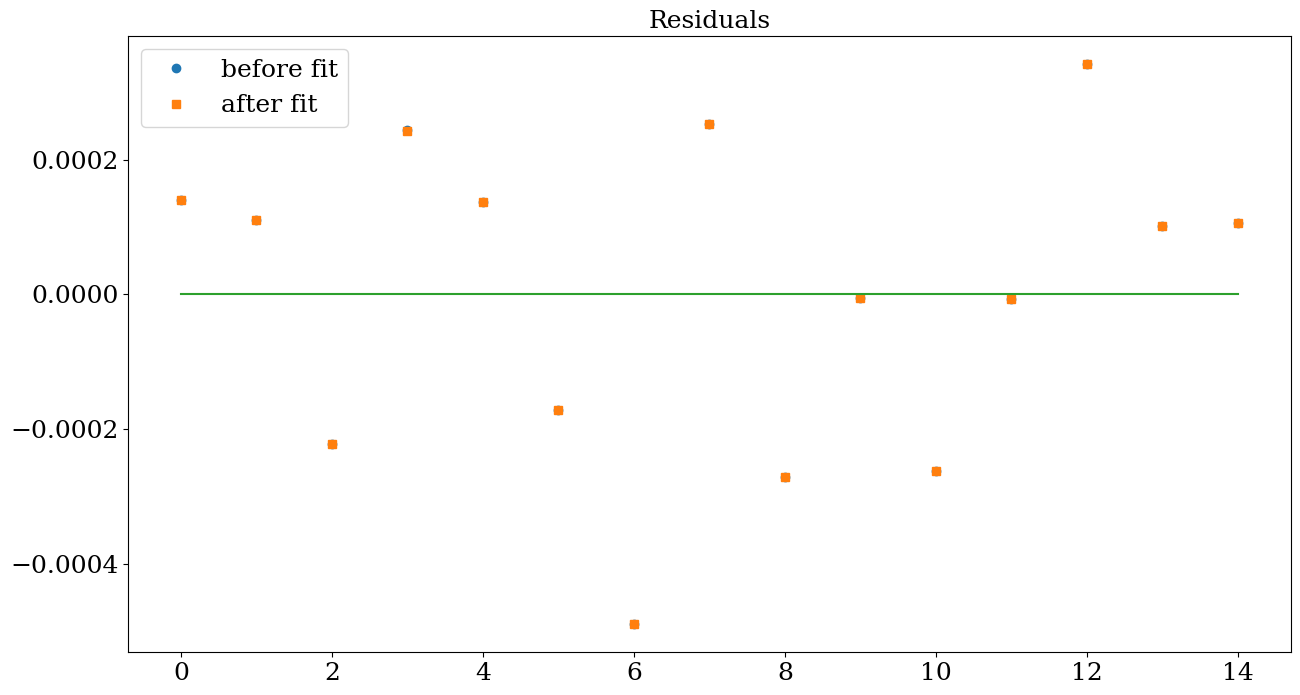

fit residuals standard deviation 0.00022726690749955296
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.748e-07 redchi=5.534e-08 params={'c_g': -0.002541733154581729}
  iter 0: chisqr=7.748e-07 redchi=5.534e-08 params={'c_g': -0.002541733154581729}
  iter 1: chisqr=7.748e-07 redchi=5.534e-08 params={'c_g': -0.002541733154581729}
  iter 2: chisqr=7.748e-07 redchi=5.534e-08 params={'c_g': -0.002541707737250183}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'c_g': -0.002542367672526889}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'c_g': -0.002542367672526889}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002667673 (fixed)
    Gamma_prime_g:  0.0005714946 (fixed)
    qG_g:           0.0004176088 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254237 +/- 3.7810e-04 (14.87%) (init = -0.002541733)
    e2Qq0_g:       -0.1083517 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.533

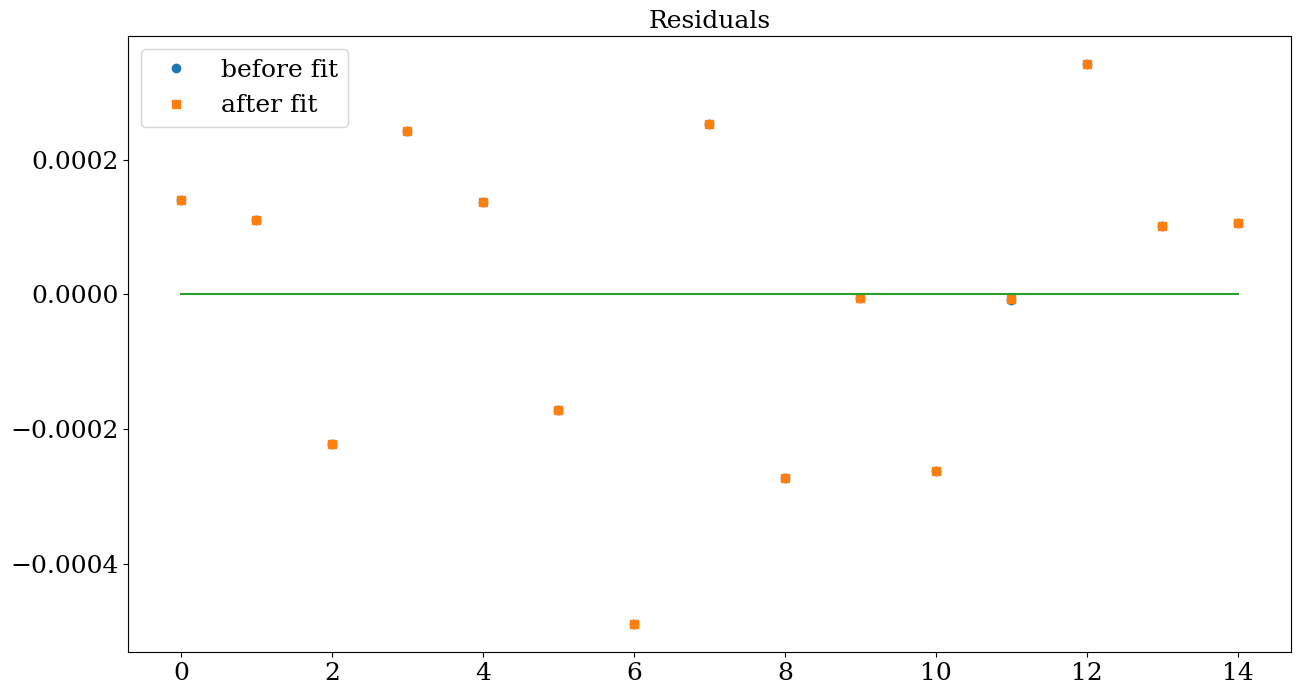

fit residuals standard deviation 0.00022726688226470463
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.748e-07 redchi=5.534e-08 params={'bF_g': -0.06278077354421695}
  iter 0: chisqr=7.748e-07 redchi=5.534e-08 params={'bF_g': -0.06278077354421695}
  iter 1: chisqr=7.748e-07 redchi=5.534e-08 params={'bF_g': -0.06278077354421695}
  iter 2: chisqr=7.748e-07 redchi=5.534e-08 params={'bF_g': -0.06278014573648151}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'bF_g': -0.0627807681783389}
  iter 3: chisqr=7.748e-07 redchi=5.534e-08 params={'bF_g': -0.0627807681783389}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002667673 (fixed)
    Gamma_prime_g:  0.0005714946 (fixed)
    qG_g:           0.0004176088 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 +/- 3.9533e-05 (0.06%) (init = -0.06278077)
    c_g:           -0.002542368 (fixed)
    e2Qq0_g:       -0.1083517 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.533953

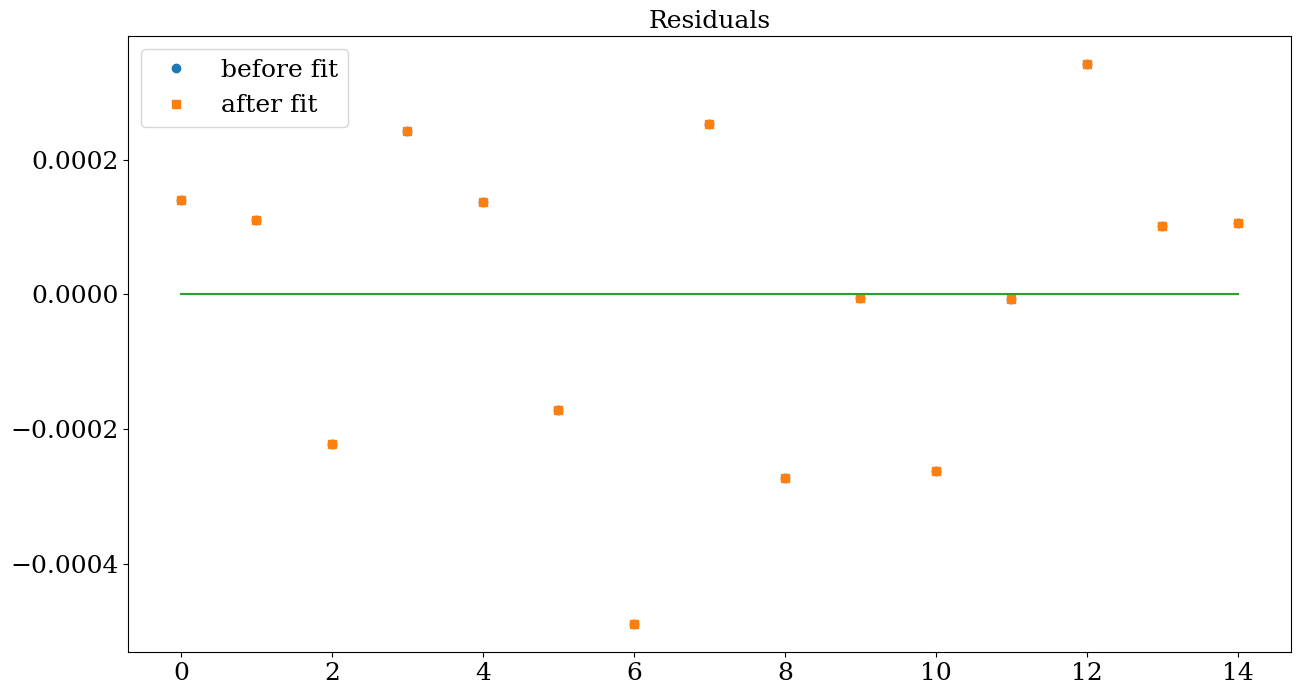

fit residuals standard deviation 0.0002272668823012173
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.748e-07 redchi=5.534e-08 params={'Gamma_SR_g': -0.0026676726718488715}
  iter 0: chisqr=7.748e-07 redchi=5.534e-08 params={'Gamma_SR_g': -0.0026676726718488715}
  iter 1: chisqr=7.748e-07 redchi=5.534e-08 params={'Gamma_SR_g': -0.0026676726718488715}
  iter 2: chisqr=7.748e-07 redchi=5.534e-08 params={'Gamma_SR_g': -0.002667645995122153}
  iter 3: chisqr=7.746e-07 redchi=5.533e-08 params={'Gamma_SR_g': -0.0026841987224364566}
  iter 3: chisqr=7.746e-07 redchi=5.533e-08 params={'Gamma_SR_g': -0.0026841987224364566}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00268420 +/- 3.0328e-04 (11.30%) (init = -0.002667673)
    Gamma_prime_g:  0.0005714946 (fixed)
    qG_g:           0.0004176088 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002542368 (fixed)
    e2Qq0_g:       -0.1083517 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:     

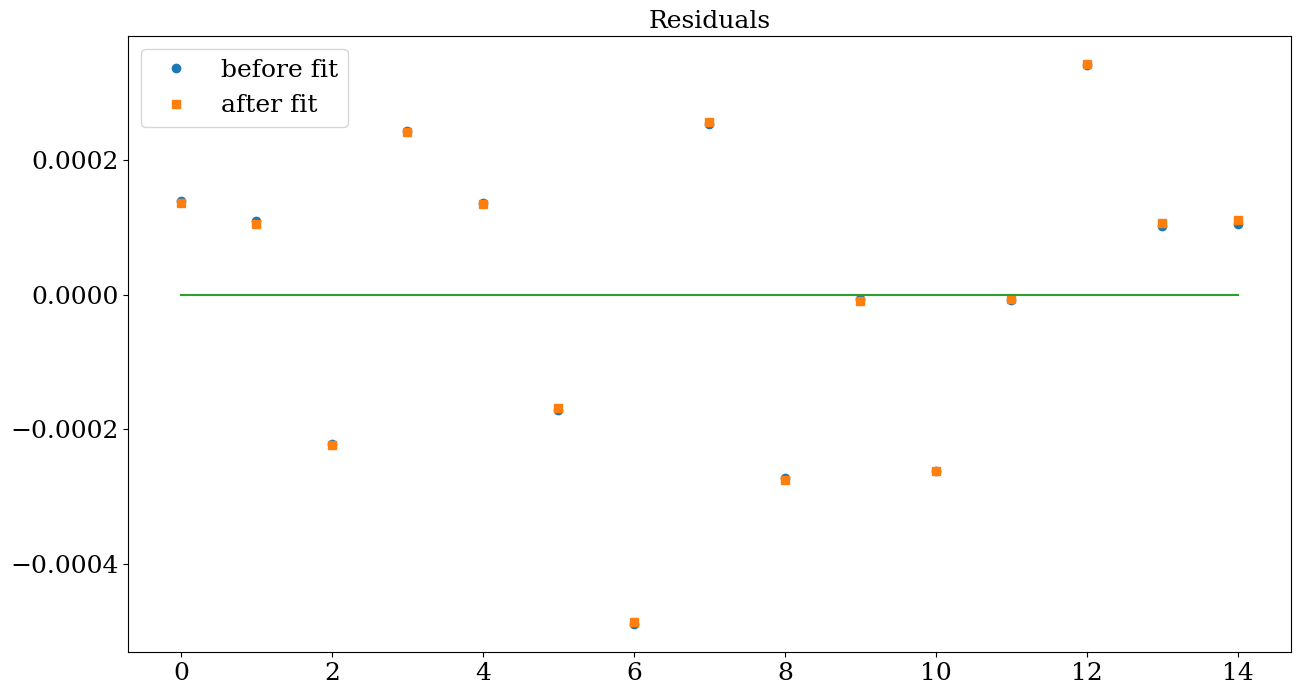

fit residuals standard deviation 0.00022724269812824448
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.746e-07 redchi=5.533e-08 params={'Gamma_prime_g': 0.0005714946428327913}
  iter 0: chisqr=7.746e-07 redchi=5.533e-08 params={'Gamma_prime_g': 0.0005714946428327913}
  iter 1: chisqr=7.746e-07 redchi=5.533e-08 params={'Gamma_prime_g': 0.0005714946428327913}
  iter 2: chisqr=7.746e-07 redchi=5.533e-08 params={'Gamma_prime_g': 0.0005715003577792196}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'Gamma_prime_g': 0.0005872002710380393}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'Gamma_prime_g': 0.0005872002710380393}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002684199 (fixed)
    Gamma_prime_g:  5.8720e-04 +/- 2.9396e-04 (50.06%) (init = 0.0005714946)
    qG_g:           0.0004176088 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002542368 (fixed)
    e2Qq0_g:       -0.1083517 (fixed)
    muE_g:          1.08737 (fixed)
    g_S

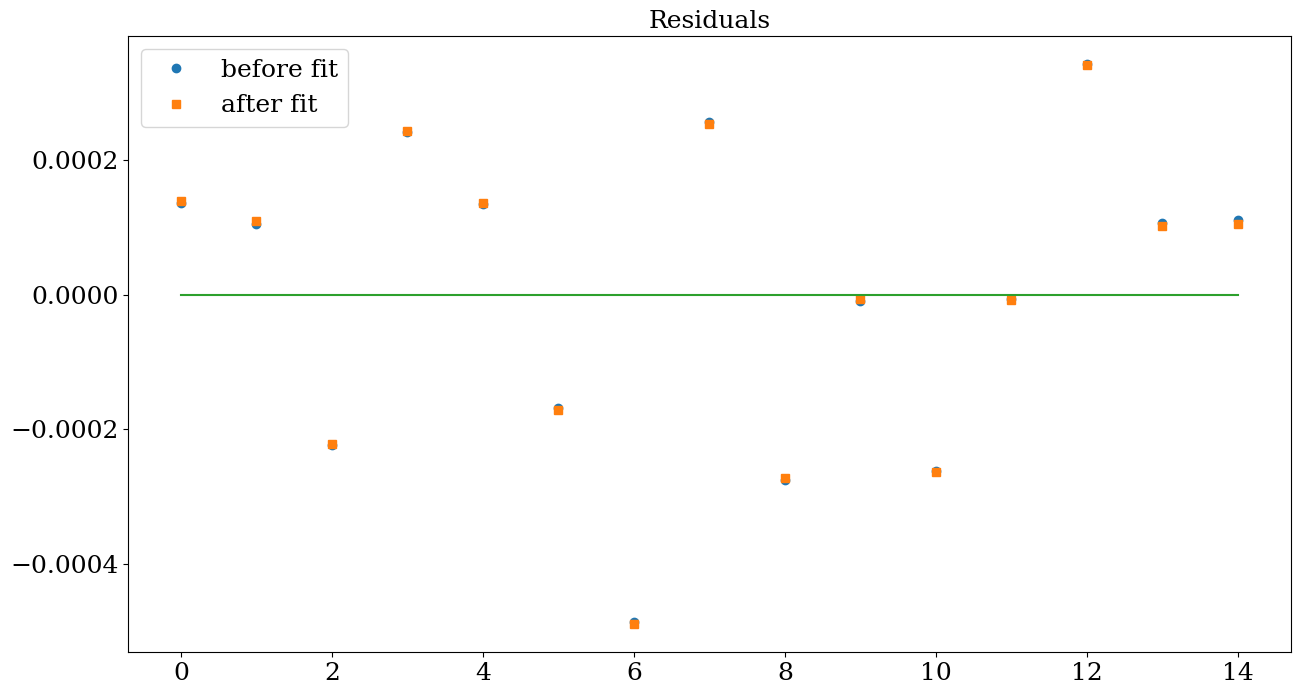

fit residuals standard deviation 0.00022721863241499557
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.744e-07 redchi=5.532e-08 params={'qG_g': 0.000417608764872776}
  iter 0: chisqr=7.744e-07 redchi=5.532e-08 params={'qG_g': 0.000417608764872776}
  iter 1: chisqr=7.744e-07 redchi=5.532e-08 params={'qG_g': 0.000417608764872776}
  iter 2: chisqr=7.744e-07 redchi=5.532e-08 params={'qG_g': 0.0004176129409604247}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'qG_g': 0.00041766684435903573}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'qG_g': 0.00041766684435903573}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002684199 (fixed)
    Gamma_prime_g:  0.0005872003 (fixed)
    qG_g:           4.1767e-04 +/- 6.0768e-05 (14.55%) (init = 0.0004176088)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002542368 (fixed)
    e2Qq0_g:       -0.1083517 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5

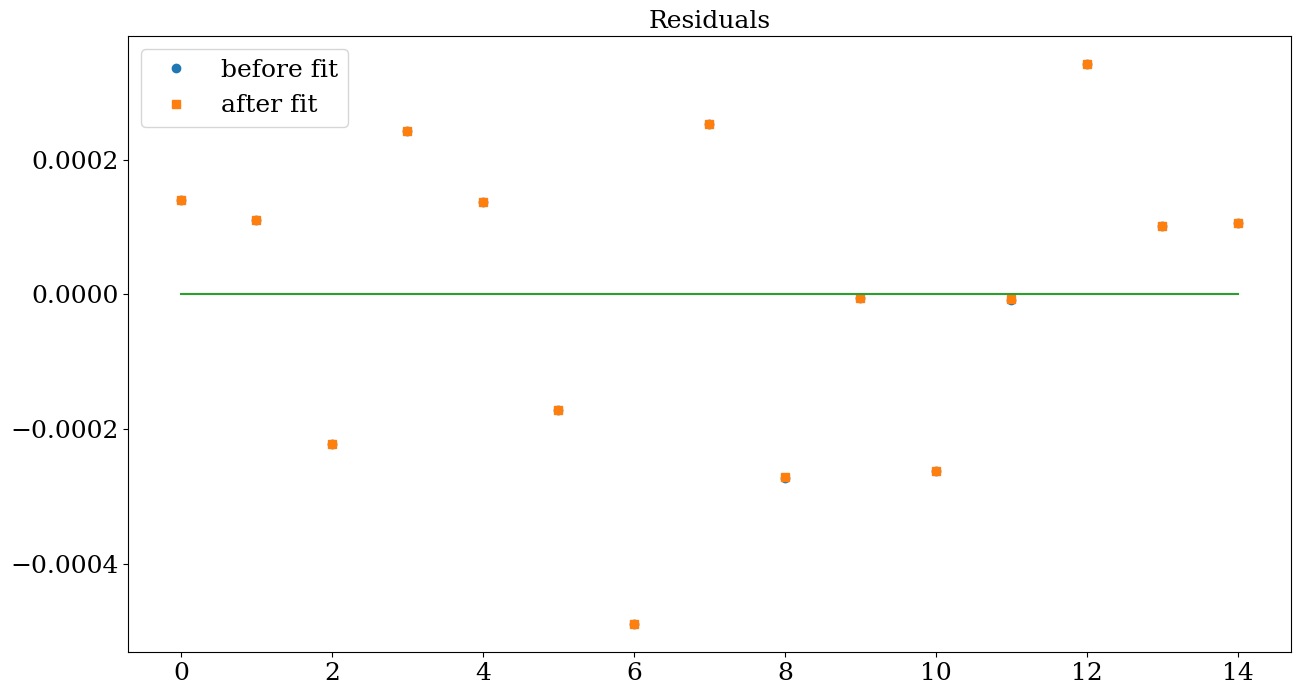

fit residuals standard deviation 0.0002272186275135048
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.744e-07 redchi=5.532e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 0: chisqr=7.744e-07 redchi=5.532e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 1: chisqr=7.744e-07 redchi=5.532e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 2: chisqr=7.744e-07 redchi=5.532e-08 params={'pG2qG_g': 0.0004356863493012594}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'pG2qG_g': 0.00043505528453309164}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'pG2qG_g': 0.0004356819924813346}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002684199 (fixed)
    Gamma_prime_g:  0.0005872003 (fixed)
    qG_g:           0.0004176668 (fixed)
    pG2qG_g:        4.3568e-04 +/- 2.9414e-04 (67.51%) (init = 0.000435682)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002542368 (fixed)
    e2Qq0_g:       -0.1083517 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

red

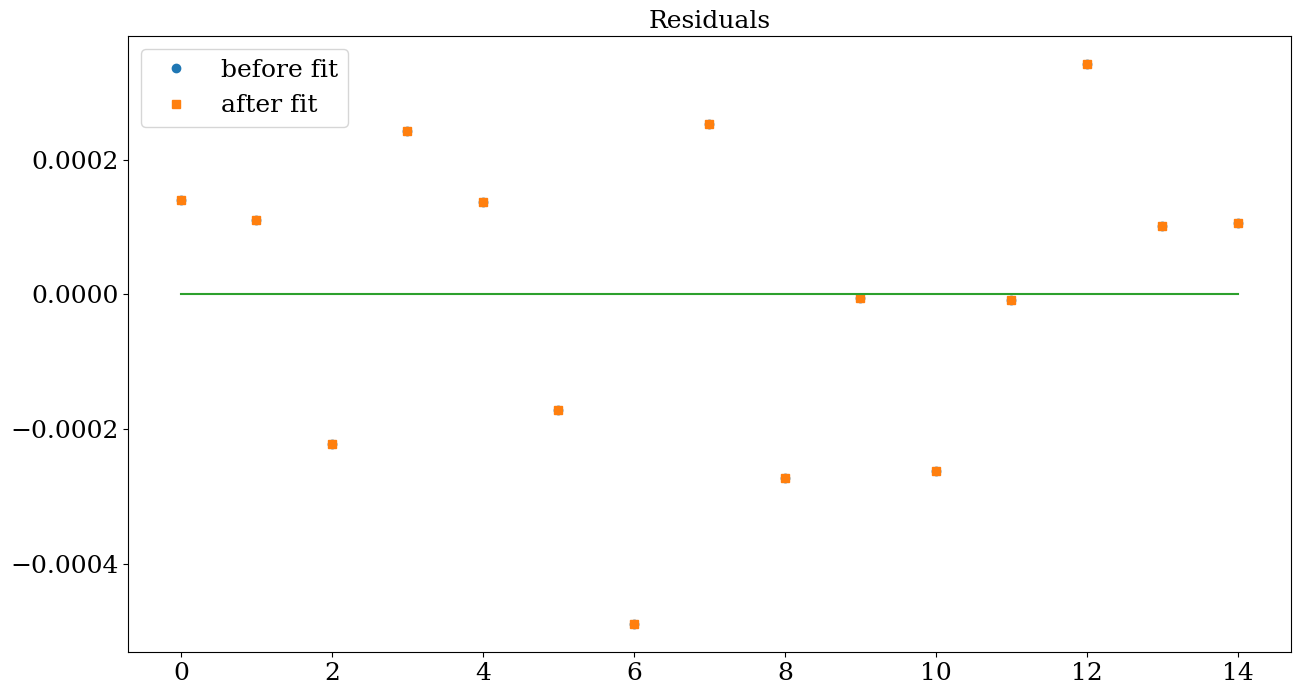

fit residuals standard deviation 0.0002272186275135048
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.744e-07 redchi=5.532e-08 params={'Torg_g': 319.91728185357016}
  iter 0: chisqr=7.744e-07 redchi=5.532e-08 params={'Torg_g': 319.91728185357016}
  iter 1: chisqr=7.744e-07 redchi=5.532e-08 params={'Torg_g': 319.91728185357016}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.9204810263887}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'Torg_g': 319.91728184035264}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'Torg_g': 319.91728184035264}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0727e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002684199 (fixed)
    Gamma_prime_g:  0.0005872003 (fixed)
    qG_g:           0.0004176668 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002542368 (fixed)
    e2Qq0_g:       -0.1083517 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.531604

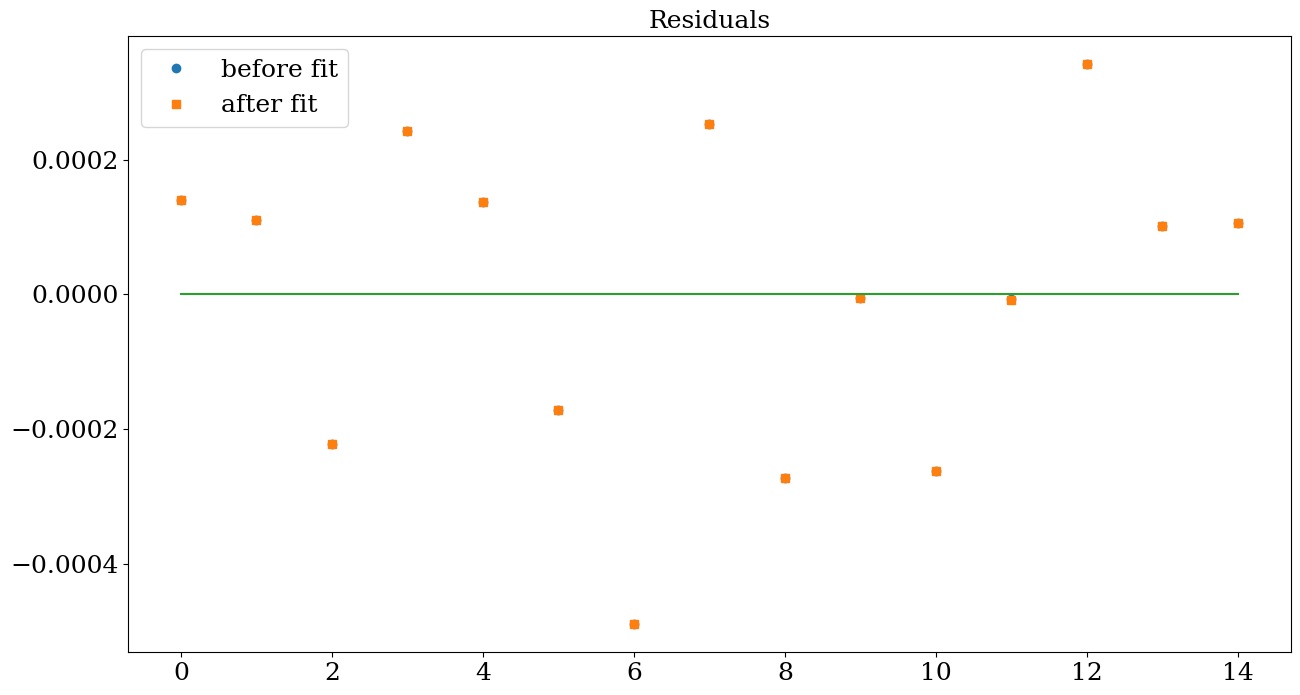

fit residuals standard deviation 0.0002272186275135048
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.744e-07 redchi=5.532e-08 params={'e2Qq0_g': -0.10835169345793734}
  iter 0: chisqr=7.744e-07 redchi=5.532e-08 params={'e2Qq0_g': -0.10835169345793734}
  iter 1: chisqr=7.744e-07 redchi=5.532e-08 params={'e2Qq0_g': -0.10835169345793734}
  iter 2: chisqr=7.744e-07 redchi=5.532e-08 params={'e2Qq0_g': -0.10835060994100276}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'e2Qq0_g': -0.1083510730688676}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'e2Qq0_g': -0.1083510730688676}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002684199 (fixed)
    Gamma_prime_g:  0.0005872003 (fixed)
    qG_g:           0.0004176668 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002542368 (fixed)
    e2Qq0_g:       -0.10835107 +/- 0.00101150 (0.93%) (init = -0.1083517)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi 

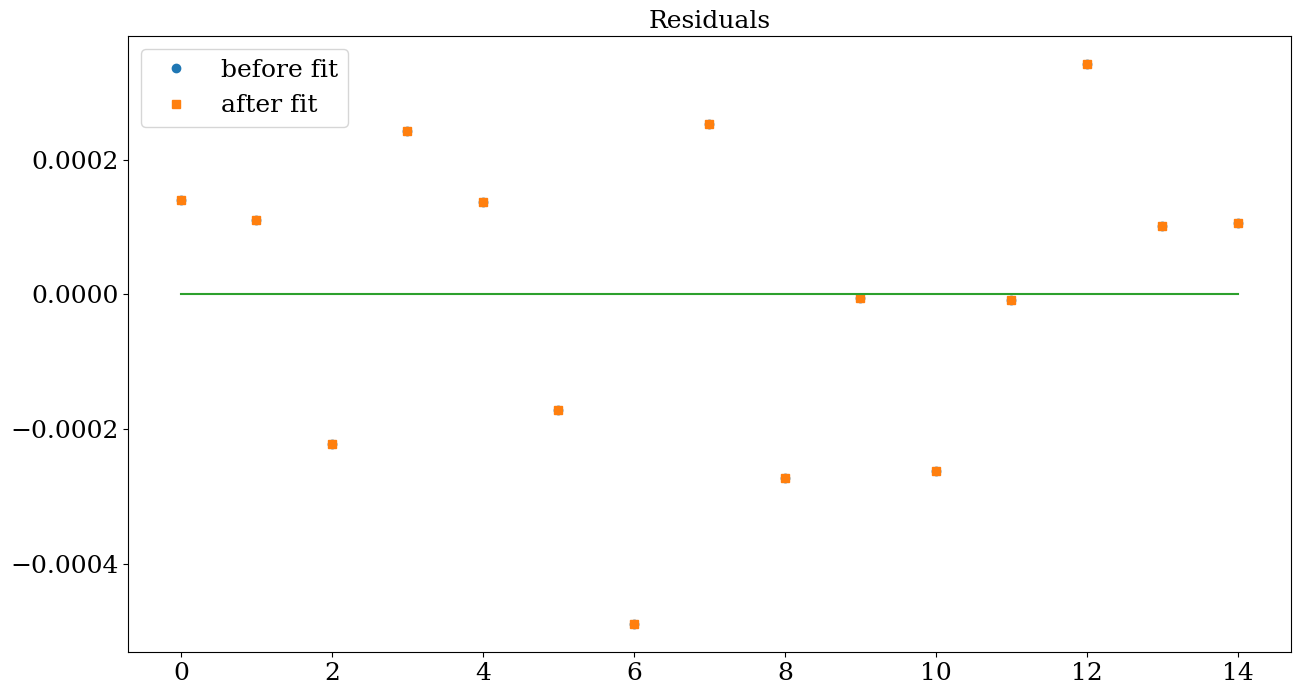

fit residuals standard deviation 0.00022721862463973399
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.744e-07 redchi=5.532e-08 params={'c_g': -0.002542367672526889}
  iter 0: chisqr=7.744e-07 redchi=5.532e-08 params={'c_g': -0.002542367672526889}
  iter 1: chisqr=7.744e-07 redchi=5.532e-08 params={'c_g': -0.002542367672526889}
  iter 2: chisqr=7.744e-07 redchi=5.532e-08 params={'c_g': -0.002542342248850164}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'c_g': -0.002543064420327293}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'c_g': -0.002543064420327293}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002684199 (fixed)
    Gamma_prime_g:  0.0005872003 (fixed)
    qG_g:           0.0004176668 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254306 +/- 3.7811e-04 (14.87%) (init = -0.002542368)
    e2Qq0_g:       -0.1083511 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.531

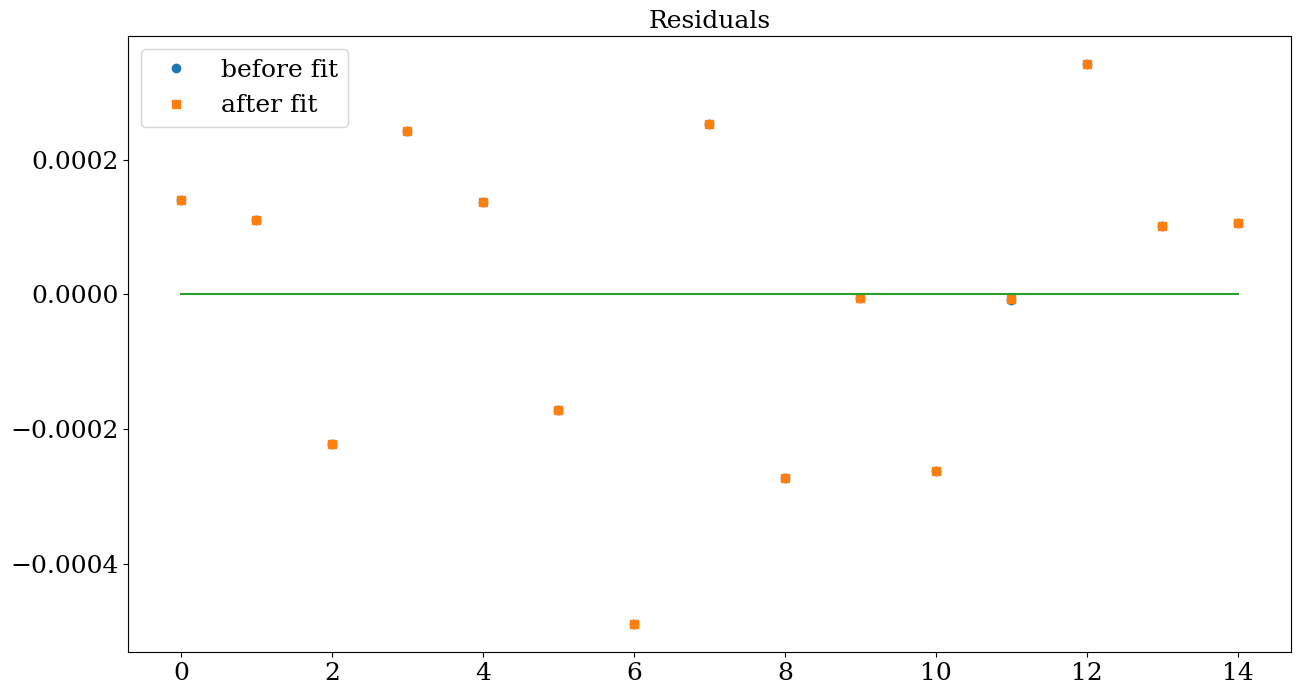

fit residuals standard deviation 0.00022721859559228947
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.744e-07 redchi=5.532e-08 params={'bF_g': -0.0627807681783389}
  iter 0: chisqr=7.744e-07 redchi=5.532e-08 params={'bF_g': -0.0627807681783389}
  iter 1: chisqr=7.744e-07 redchi=5.532e-08 params={'bF_g': -0.0627807681783389}
  iter 2: chisqr=7.744e-07 redchi=5.532e-08 params={'bF_g': -0.06278014037065711}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'bF_g': -0.06278077371761522}
  iter 3: chisqr=7.744e-07 redchi=5.532e-08 params={'bF_g': -0.06278077371761522}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002684199 (fixed)
    Gamma_prime_g:  0.0005872003 (fixed)
    qG_g:           0.0004176668 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 +/- 3.9525e-05 (0.06%) (init = -0.06278077)
    c_g:           -0.002543064 (fixed)
    e2Qq0_g:       -0.1083511 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5316025

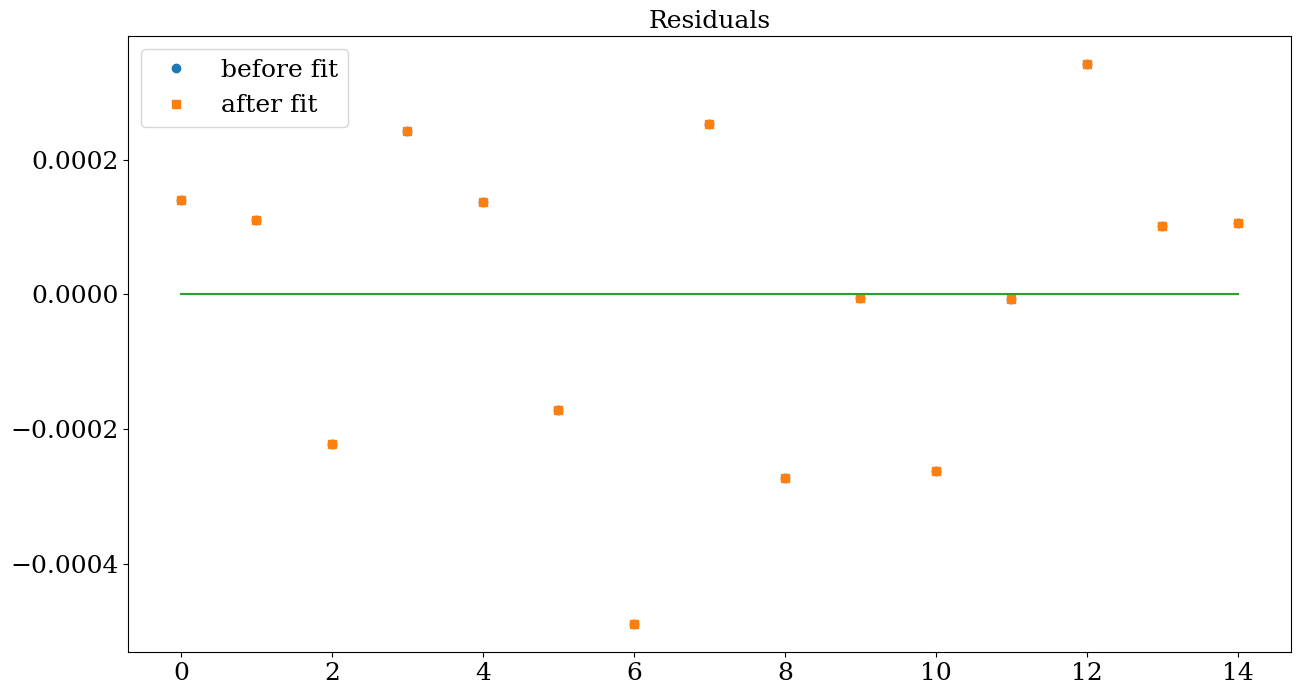

fit residuals standard deviation 0.00022721859522220156
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.744e-07 redchi=5.532e-08 params={'Gamma_SR_g': -0.0026841987224364566}
  iter 0: chisqr=7.744e-07 redchi=5.532e-08 params={'Gamma_SR_g': -0.0026841987224364566}
  iter 1: chisqr=7.744e-07 redchi=5.532e-08 params={'Gamma_SR_g': -0.0026841987224364566}
  iter 2: chisqr=7.744e-07 redchi=5.532e-08 params={'Gamma_SR_g': -0.002684171880449232}
  iter 3: chisqr=7.743e-07 redchi=5.53e-08 params={'Gamma_SR_g': -0.002700403763752613}
  iter 3: chisqr=7.743e-07 redchi=5.53e-08 params={'Gamma_SR_g': -0.002700403763752613}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00270040 +/- 3.0325e-04 (11.23%) (init = -0.002684199)
    Gamma_prime_g:  0.0005872003 (fixed)
    qG_g:           0.0004176668 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543064 (fixed)
    e2Qq0_g:       -0.1083511 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.0

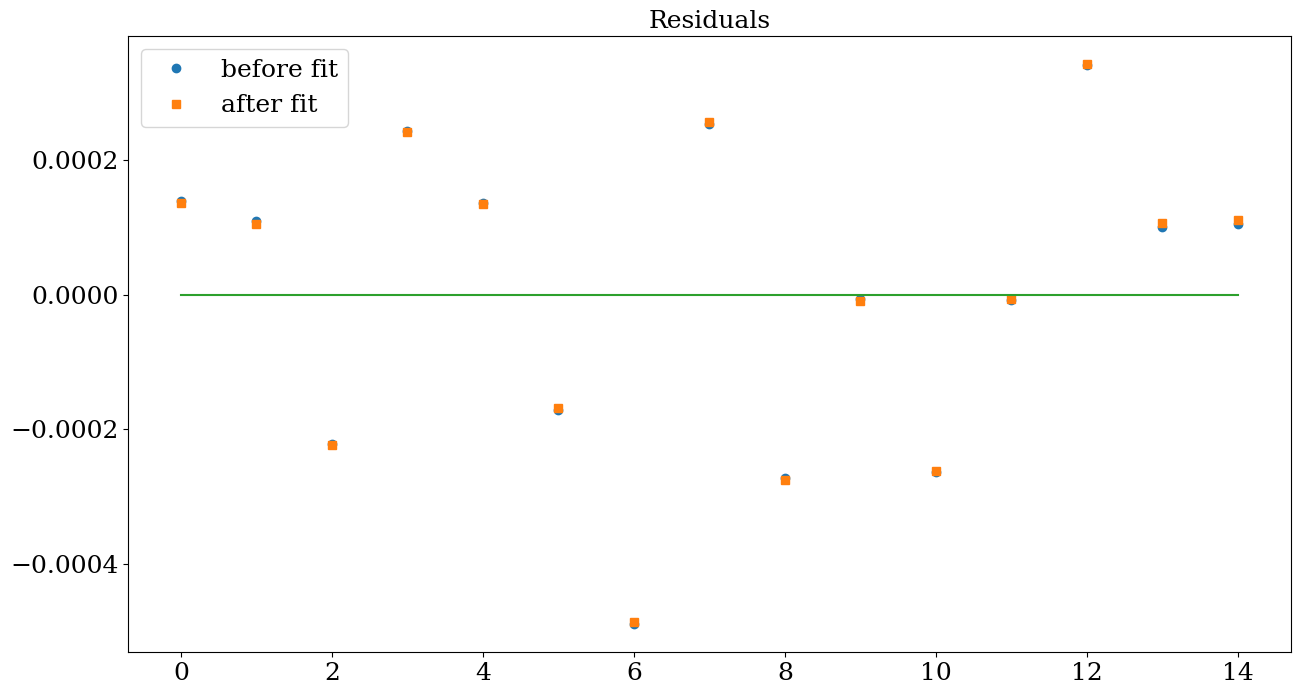

fit residuals standard deviation 0.00022719522438746667
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.743e-07 redchi=5.53e-08 params={'Gamma_prime_g': 0.0005872002710380393}
  iter 0: chisqr=7.743e-07 redchi=5.53e-08 params={'Gamma_prime_g': 0.0005872002710380393}
  iter 1: chisqr=7.743e-07 redchi=5.53e-08 params={'Gamma_prime_g': 0.0005872002710380393}
  iter 2: chisqr=7.743e-07 redchi=5.53e-08 params={'Gamma_prime_g': 0.0005872061430407497}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'Gamma_prime_g': 0.0006029094718757945}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'Gamma_prime_g': 0.0006029094718757945}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002700404 (fixed)
    Gamma_prime_g:  6.0291e-04 +/- 2.9395e-04 (48.75%) (init = 0.0005872003)
    qG_g:           0.0004176668 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543064 (fixed)
    e2Qq0_g:       -0.1083511 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff

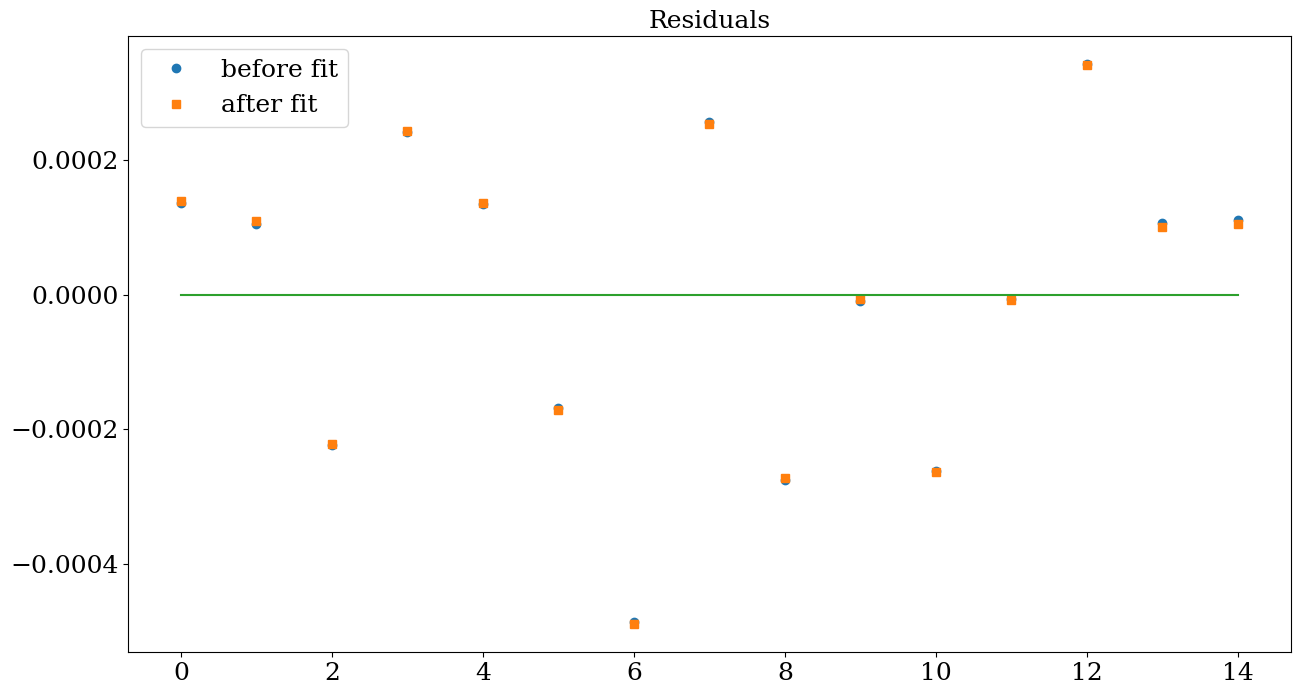

fit residuals standard deviation 0.00022717130178352148
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.741e-07 redchi=5.529e-08 params={'qG_g': 0.00041766684435903573}
  iter 0: chisqr=7.741e-07 redchi=5.529e-08 params={'qG_g': 0.00041766684435903573}
  iter 1: chisqr=7.741e-07 redchi=5.529e-08 params={'qG_g': 0.00041766684435903573}
  iter 2: chisqr=7.741e-07 redchi=5.529e-08 params={'qG_g': 0.00041767102102747934}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'qG_g': 0.00041770889772905936}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'qG_g': 0.00041770889772905936}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002700404 (fixed)
    Gamma_prime_g:  0.0006029095 (fixed)
    qG_g:           4.1771e-04 +/- 6.0757e-05 (14.55%) (init = 0.0004176668)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543064 (fixed)
    e2Qq0_g:       -0.1083511 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squa

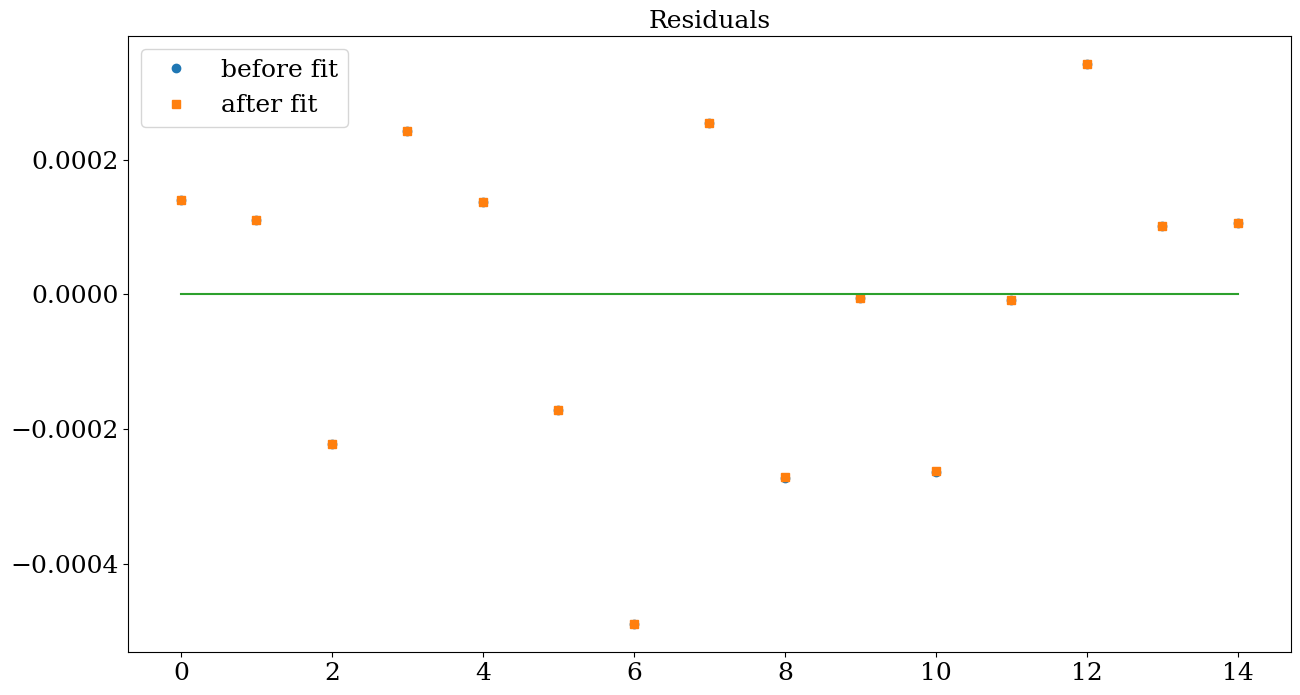

fit residuals standard deviation 0.0002271712988121014
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.741e-07 redchi=5.529e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 0: chisqr=7.741e-07 redchi=5.529e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 1: chisqr=7.741e-07 redchi=5.529e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 2: chisqr=7.741e-07 redchi=5.529e-08 params={'pG2qG_g': 0.0004356863493012594}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'pG2qG_g': 0.00043600950876774295}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'pG2qG_g': 0.0004356819924813346}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002700404 (fixed)
    Gamma_prime_g:  0.0006029095 (fixed)
    qG_g:           0.0004177089 (fixed)
    pG2qG_g:        4.3568e-04 +/- 2.9423e-04 (67.53%) (init = 0.000435682)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543064 (fixed)
    e2Qq0_g:       -0.1083511 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

red

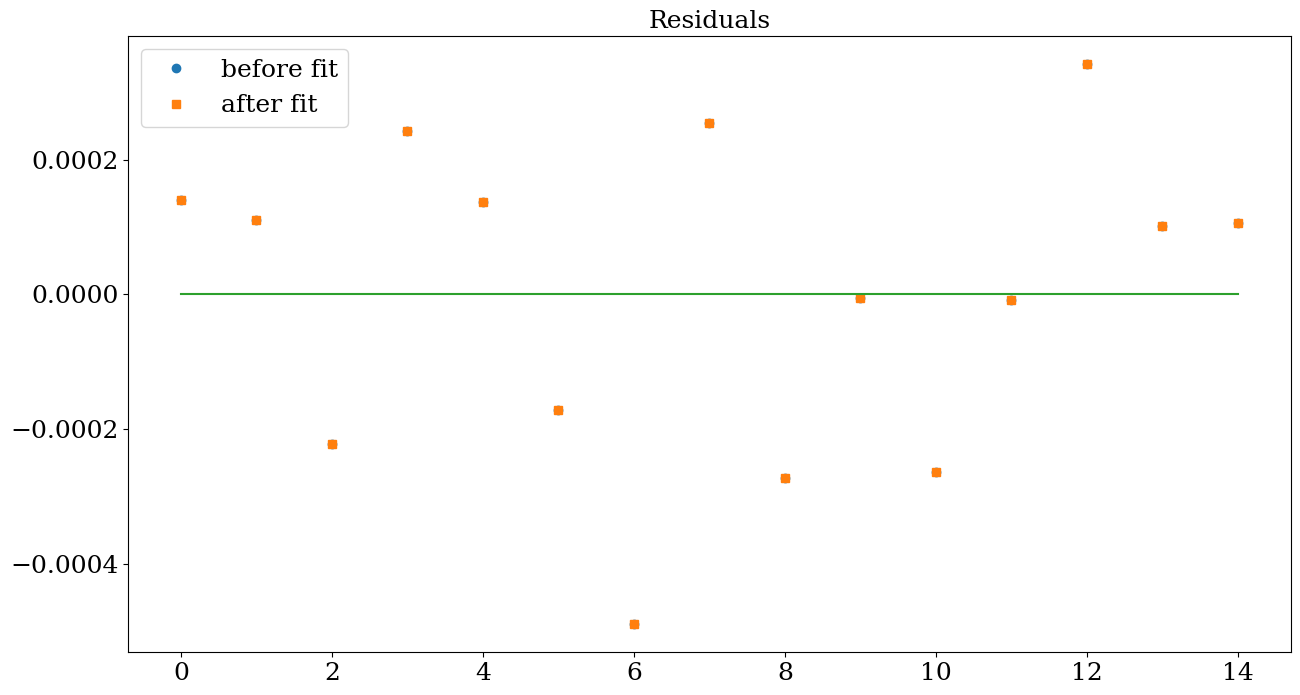

fit residuals standard deviation 0.0002271712988121014
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.741e-07 redchi=5.529e-08 params={'Torg_g': 319.91728184035264}
  iter 0: chisqr=7.741e-07 redchi=5.529e-08 params={'Torg_g': 319.91728184035264}
  iter 1: chisqr=7.741e-07 redchi=5.529e-08 params={'Torg_g': 319.91728184035264}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.92048101317107}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'Torg_g': 319.9172818416425}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'Torg_g': 319.9172818416425}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0714e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002700404 (fixed)
    Gamma_prime_g:  0.0006029095 (fixed)
    qG_g:           0.0004177089 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543064 (fixed)
    e2Qq0_g:       -0.1083511 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5292998

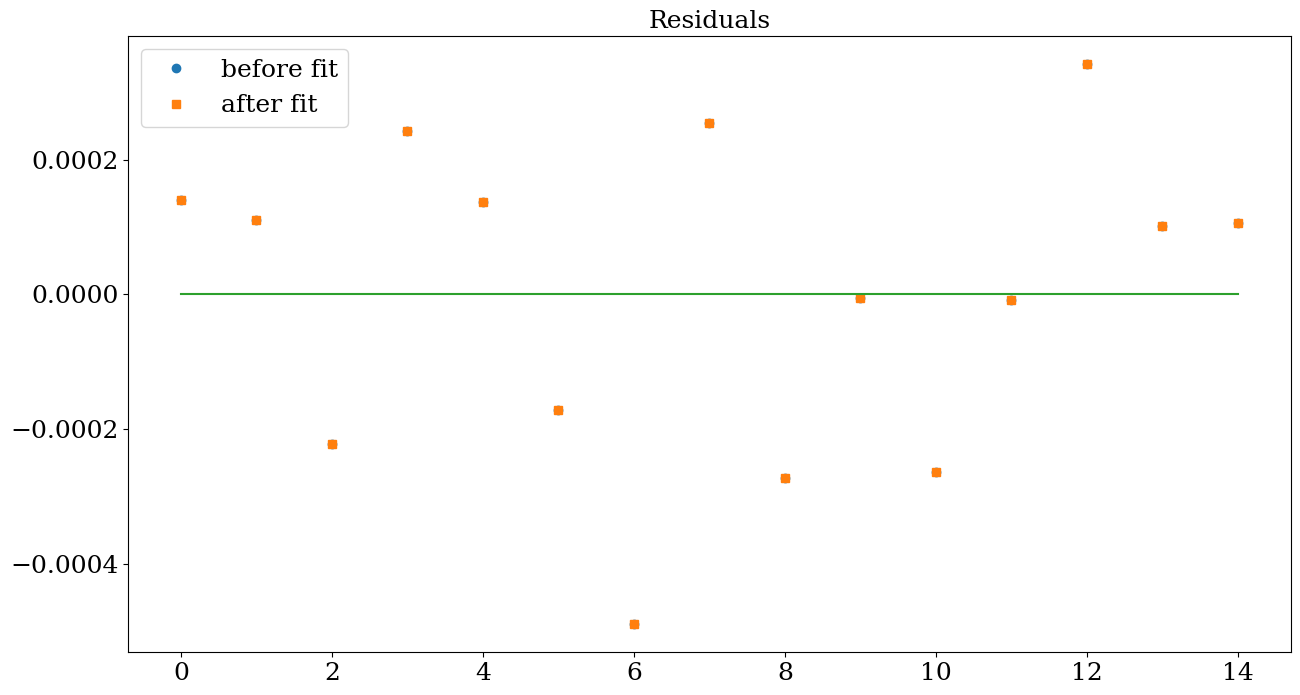

fit residuals standard deviation 0.00022717129871864154
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.741e-07 redchi=5.529e-08 params={'e2Qq0_g': -0.1083510730688676}
  iter 0: chisqr=7.741e-07 redchi=5.529e-08 params={'e2Qq0_g': -0.1083510730688676}
  iter 1: chisqr=7.741e-07 redchi=5.529e-08 params={'e2Qq0_g': -0.1083510730688676}
  iter 2: chisqr=7.741e-07 redchi=5.529e-08 params={'e2Qq0_g': -0.1083499895581369}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'e2Qq0_g': -0.10835036156913291}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'e2Qq0_g': -0.10835036156913291}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002700404 (fixed)
    Gamma_prime_g:  0.0006029095 (fixed)
    qG_g:           0.0004177089 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543064 (fixed)
    e2Qq0_g:       -0.10835036 +/- 0.00101130 (0.93%) (init = -0.1083511)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi sq

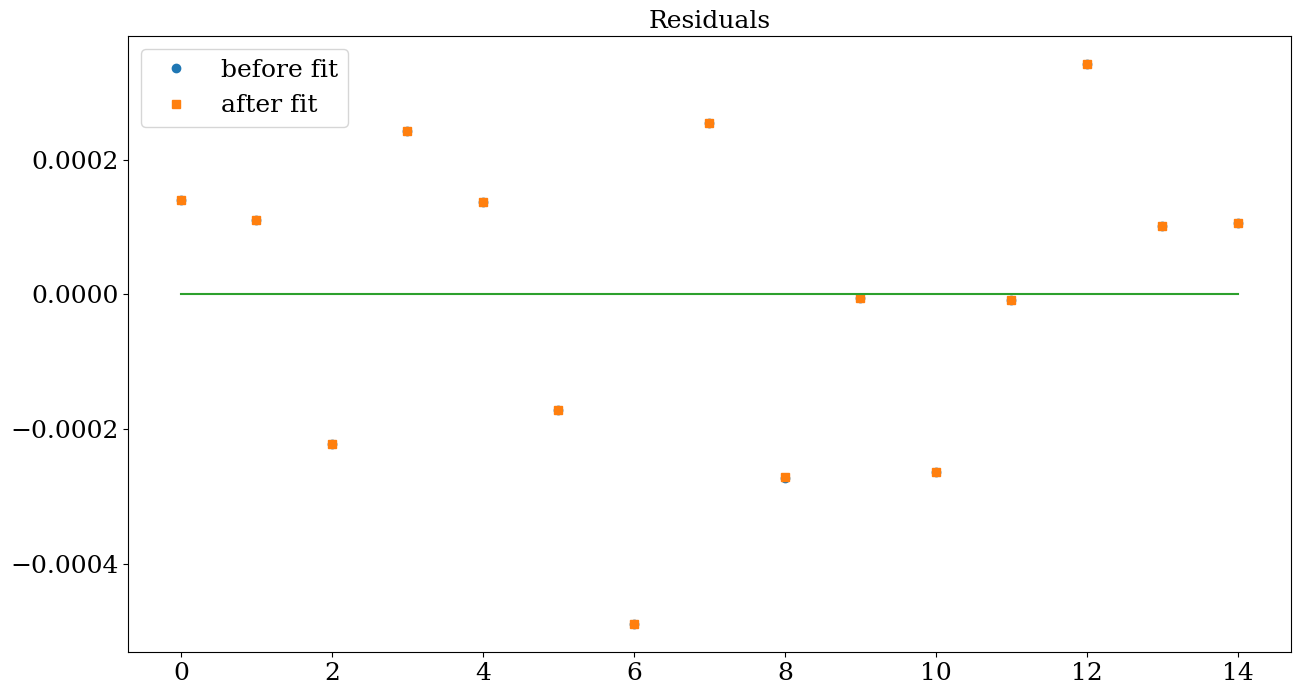

fit residuals standard deviation 0.00022717129476231563
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.741e-07 redchi=5.529e-08 params={'c_g': -0.002543064420327293}
  iter 0: chisqr=7.741e-07 redchi=5.529e-08 params={'c_g': -0.002543064420327293}
  iter 1: chisqr=7.741e-07 redchi=5.529e-08 params={'c_g': -0.002543064420327293}
  iter 2: chisqr=7.741e-07 redchi=5.529e-08 params={'c_g': -0.00254303898968309}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'c_g': -0.00254387403225875}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'c_g': -0.00254387403225875}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002700404 (fixed)
    Gamma_prime_g:  0.0006029095 (fixed)
    qG_g:           0.0004177089 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254387 +/- 3.7802e-04 (14.86%) (init = -0.002543064)
    e2Qq0_g:       -0.1083504 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.529298

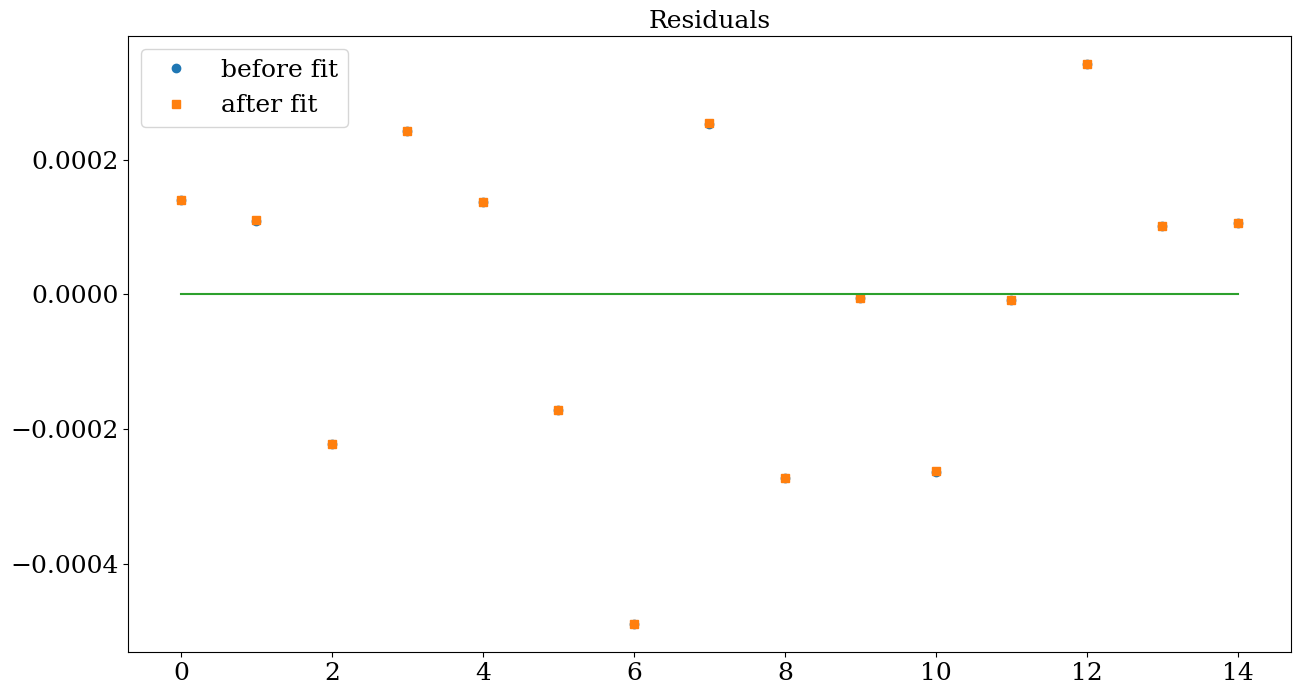

fit residuals standard deviation 0.00022717127096540506
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.741e-07 redchi=5.529e-08 params={'bF_g': -0.06278077371761522}
  iter 0: chisqr=7.741e-07 redchi=5.529e-08 params={'bF_g': -0.06278077371761522}
  iter 1: chisqr=7.741e-07 redchi=5.529e-08 params={'bF_g': -0.06278077371761522}
  iter 2: chisqr=7.741e-07 redchi=5.529e-08 params={'bF_g': -0.06278014590987804}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'bF_g': -0.06278077164427932}
  iter 3: chisqr=7.741e-07 redchi=5.529e-08 params={'bF_g': -0.06278077371761522}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002700404 (fixed)
    Gamma_prime_g:  0.0006029095 (fixed)
    qG_g:           0.0004177089 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 +/- 3.9517e-05 (0.06%) (init = -0.06278077)
    c_g:           -0.002543874 (fixed)
    e2Qq0_g:       -0.1083504 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5292

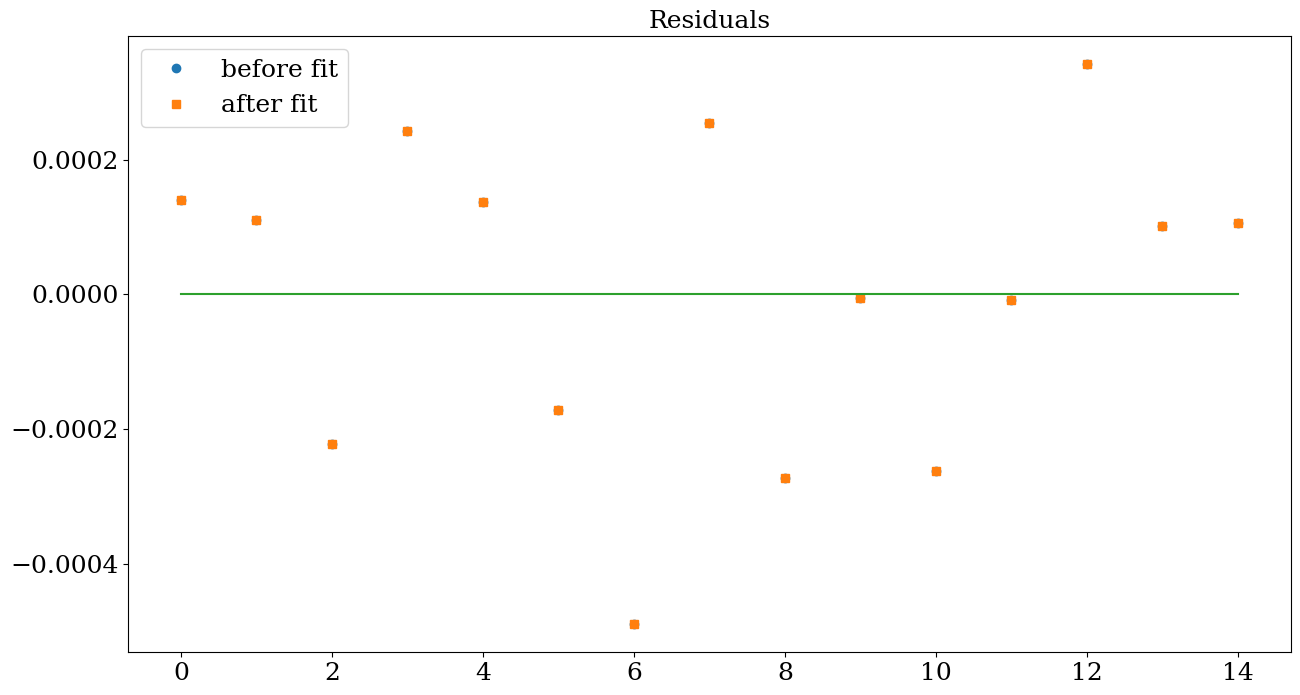

fit residuals standard deviation 0.00022717127096540506
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.741e-07 redchi=5.529e-08 params={'Gamma_SR_g': -0.002700403763752613}
  iter 0: chisqr=7.741e-07 redchi=5.529e-08 params={'Gamma_SR_g': -0.002700403763752613}
  iter 1: chisqr=7.741e-07 redchi=5.529e-08 params={'Gamma_SR_g': -0.002700403763752613}
  iter 2: chisqr=7.741e-07 redchi=5.529e-08 params={'Gamma_SR_g': -0.0027003767597149754}
  iter 3: chisqr=7.739e-07 redchi=5.528e-08 params={'Gamma_SR_g': -0.00271671670858913}
  iter 3: chisqr=7.739e-07 redchi=5.528e-08 params={'Gamma_SR_g': -0.00271671670858913}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00271672 +/- 3.0319e-04 (11.16%) (init = -0.002700404)
    Gamma_prime_g:  0.0006029095 (fixed)
    qG_g:           0.0004177089 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543874 (fixed)
    e2Qq0_g:       -0.1083504 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 

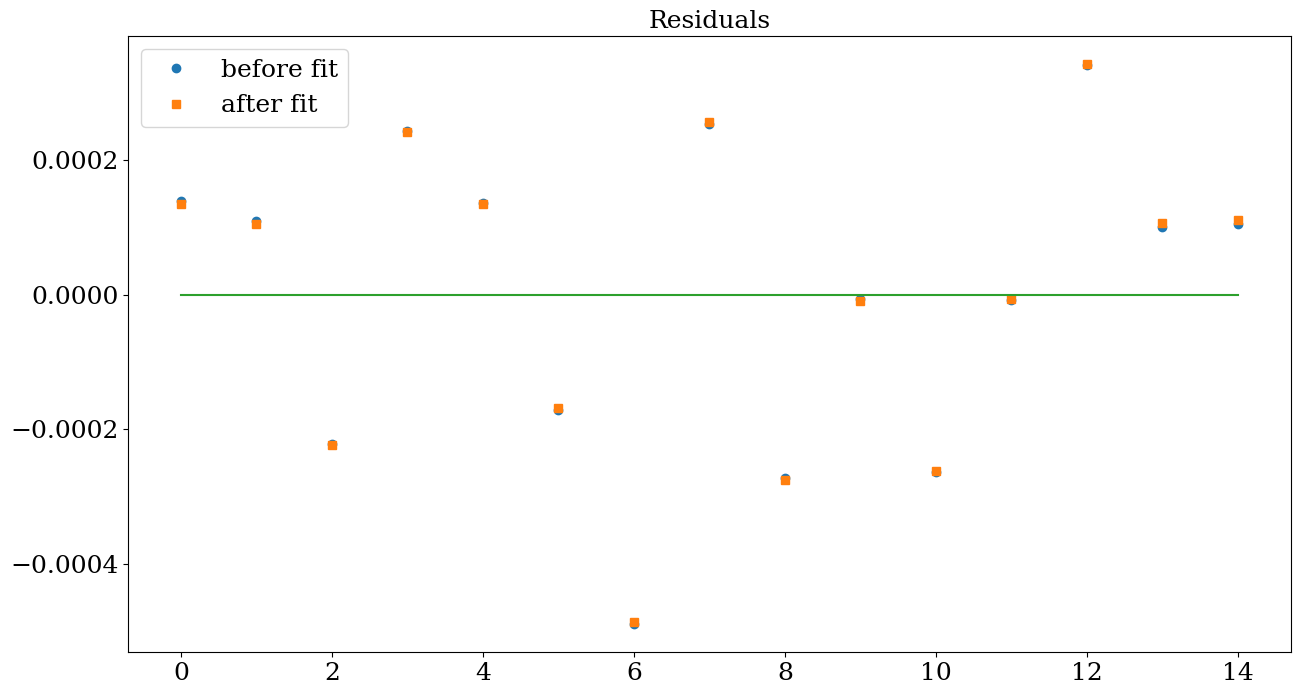

fit residuals standard deviation 0.00022714777011225798
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.739e-07 redchi=5.528e-08 params={'Gamma_prime_g': 0.0006029094718757945}
  iter 0: chisqr=7.739e-07 redchi=5.528e-08 params={'Gamma_prime_g': 0.0006029094718757945}
  iter 1: chisqr=7.739e-07 redchi=5.528e-08 params={'Gamma_prime_g': 0.0006029094718757945}
  iter 2: chisqr=7.739e-07 redchi=5.528e-08 params={'Gamma_prime_g': 0.0006029155009705133}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'Gamma_prime_g': 0.0006188077808401613}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'Gamma_prime_g': 0.0006188077808401613}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002716717 (fixed)
    Gamma_prime_g:  6.1881e-04 +/- 2.9402e-04 (47.51%) (init = 0.0006029095)
    qG_g:           0.0004177089 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543874 (fixed)
    e2Qq0_g:       -0.1083504 (fixed)
    muE_g:          1.08737 (fixed)
    g_S

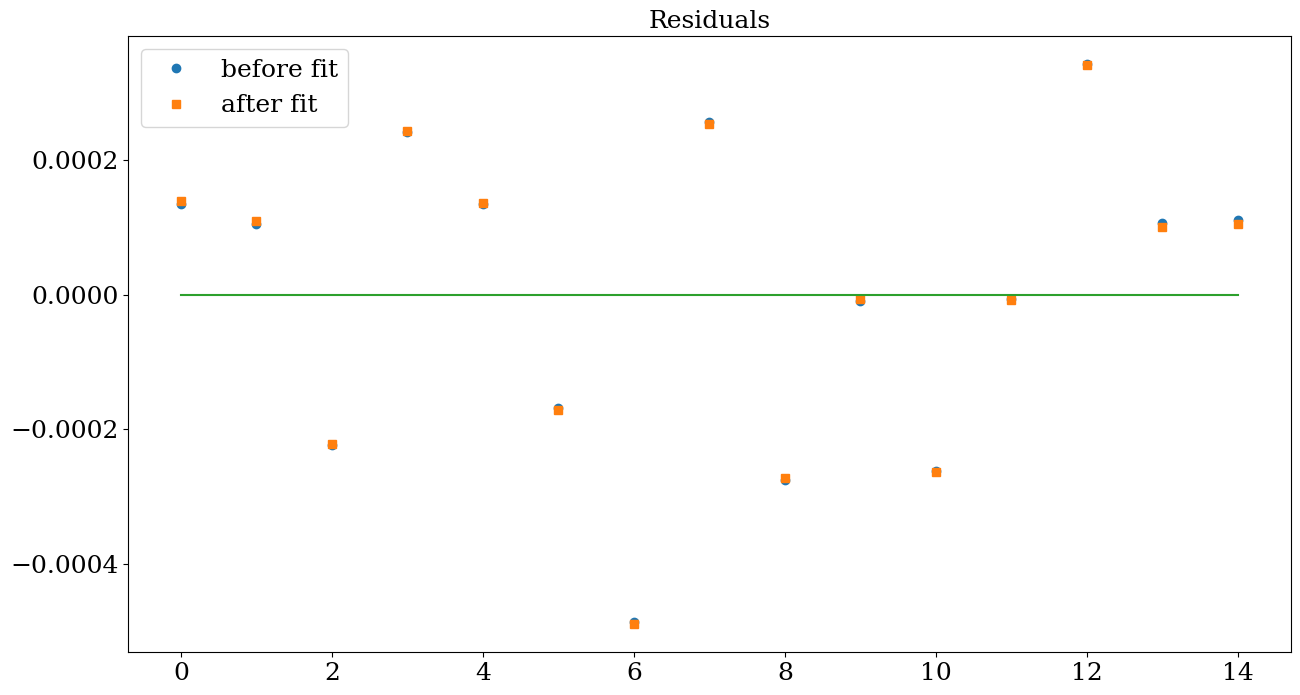

fit residuals standard deviation 0.00022712368267432457
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.738e-07 redchi=5.527e-08 params={'qG_g': 0.00041770889772905936}
  iter 0: chisqr=7.738e-07 redchi=5.527e-08 params={'qG_g': 0.00041770889772905936}
  iter 1: chisqr=7.738e-07 redchi=5.527e-08 params={'qG_g': 0.00041770889772905936}
  iter 2: chisqr=7.738e-07 redchi=5.527e-08 params={'qG_g': 0.00041771307481803664}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'qG_g': 0.0004178047603830134}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'qG_g': 0.0004178047603830134}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002716717 (fixed)
    Gamma_prime_g:  0.0006188078 (fixed)
    qG_g:           4.1780e-04 +/- 6.0768e-05 (14.54%) (init = 0.0004177089)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543874 (fixed)
    e2Qq0_g:       -0.1083504 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi square

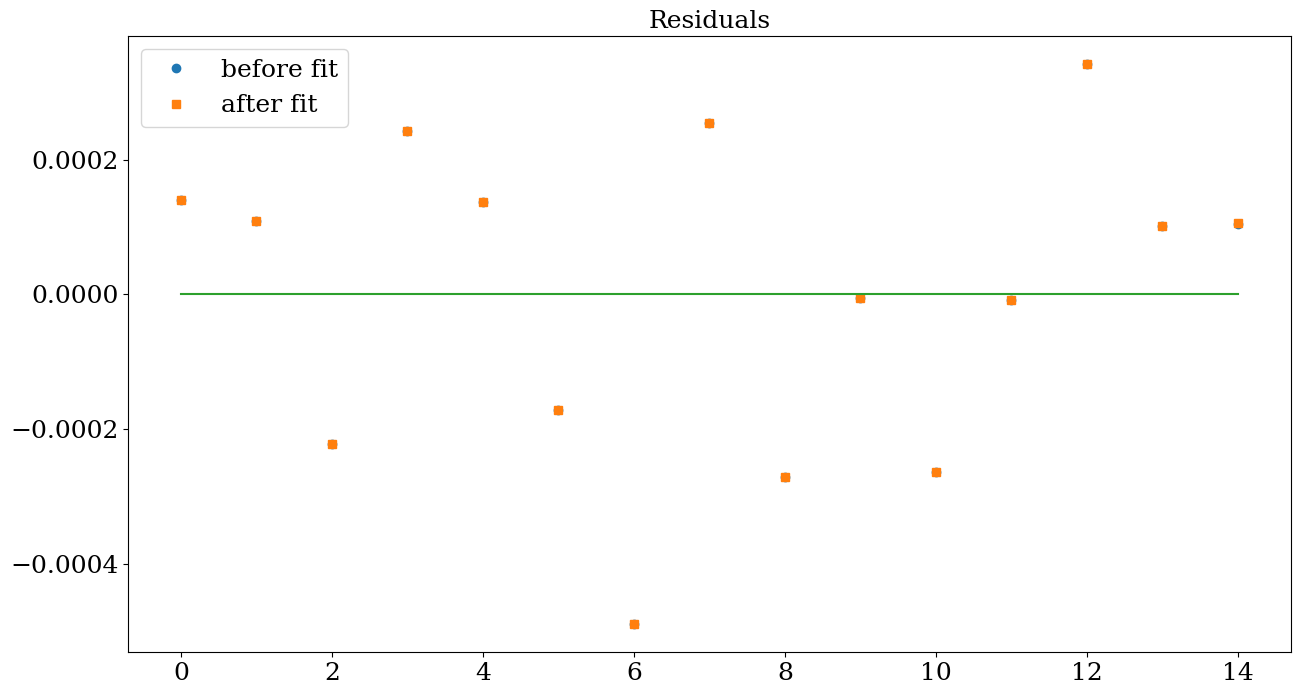

fit residuals standard deviation 0.000227123674749621
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.738e-07 redchi=5.527e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 0: chisqr=7.738e-07 redchi=5.527e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 1: chisqr=7.738e-07 redchi=5.527e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 2: chisqr=7.738e-07 redchi=5.527e-08 params={'pG2qG_g': 0.0004356863493012594}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'pG2qG_g': 0.00043538127929911496}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'pG2qG_g': 0.0004356819924813346}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002716717 (fixed)
    Gamma_prime_g:  0.0006188078 (fixed)
    qG_g:           0.0004178048 (fixed)
    pG2qG_g:        4.3568e-04 +/- 2.9436e-04 (67.56%) (init = 0.000435682)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543874 (fixed)
    e2Qq0_g:       -0.1083504 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

red

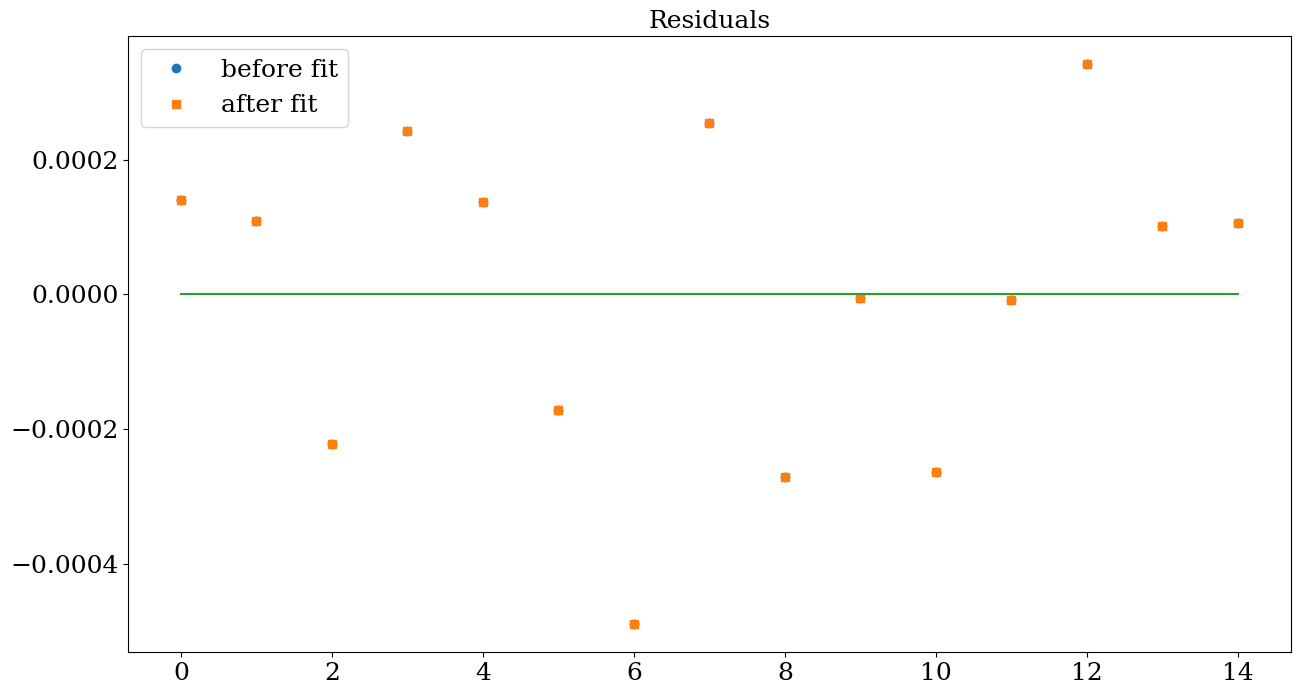

fit residuals standard deviation 0.000227123674749621
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.738e-07 redchi=5.527e-08 params={'Torg_g': 319.9172818416425}
  iter 0: chisqr=7.738e-07 redchi=5.527e-08 params={'Torg_g': 319.9172818416425}
  iter 1: chisqr=7.738e-07 redchi=5.527e-08 params={'Torg_g': 319.9172818416425}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.9204810144609}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'Torg_g': 319.91728179145315}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'Torg_g': 319.91728179145315}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0701e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002716717 (fixed)
    Gamma_prime_g:  0.0006188078 (fixed)
    qG_g:           0.0004178048 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543874 (fixed)
    e2Qq0_g:       -0.1083504 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.526981817

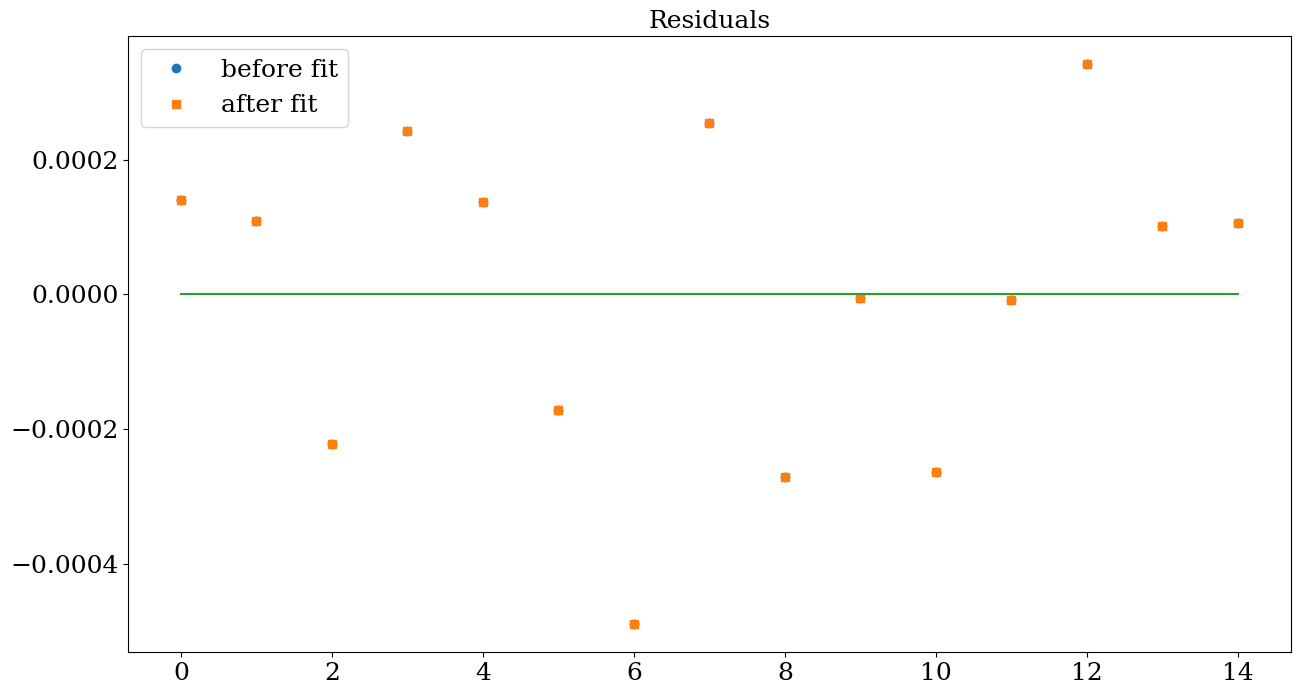

fit residuals standard deviation 0.000227123674749621
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.738e-07 redchi=5.527e-08 params={'e2Qq0_g': -0.10835036156913291}
  iter 0: chisqr=7.738e-07 redchi=5.527e-08 params={'e2Qq0_g': -0.10835036156913291}
  iter 1: chisqr=7.738e-07 redchi=5.527e-08 params={'e2Qq0_g': -0.10835036156913291}
  iter 2: chisqr=7.738e-07 redchi=5.527e-08 params={'e2Qq0_g': -0.10834927806551722}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'e2Qq0_g': -0.10834957363108738}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'e2Qq0_g': -0.10834957363108738}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002716717 (fixed)
    Gamma_prime_g:  0.0006188078 (fixed)
    qG_g:           0.0004178048 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002543874 (fixed)
    e2Qq0_g:       -0.10834957 +/- 0.00101110 (0.93%) (init = -0.1083504)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced ch

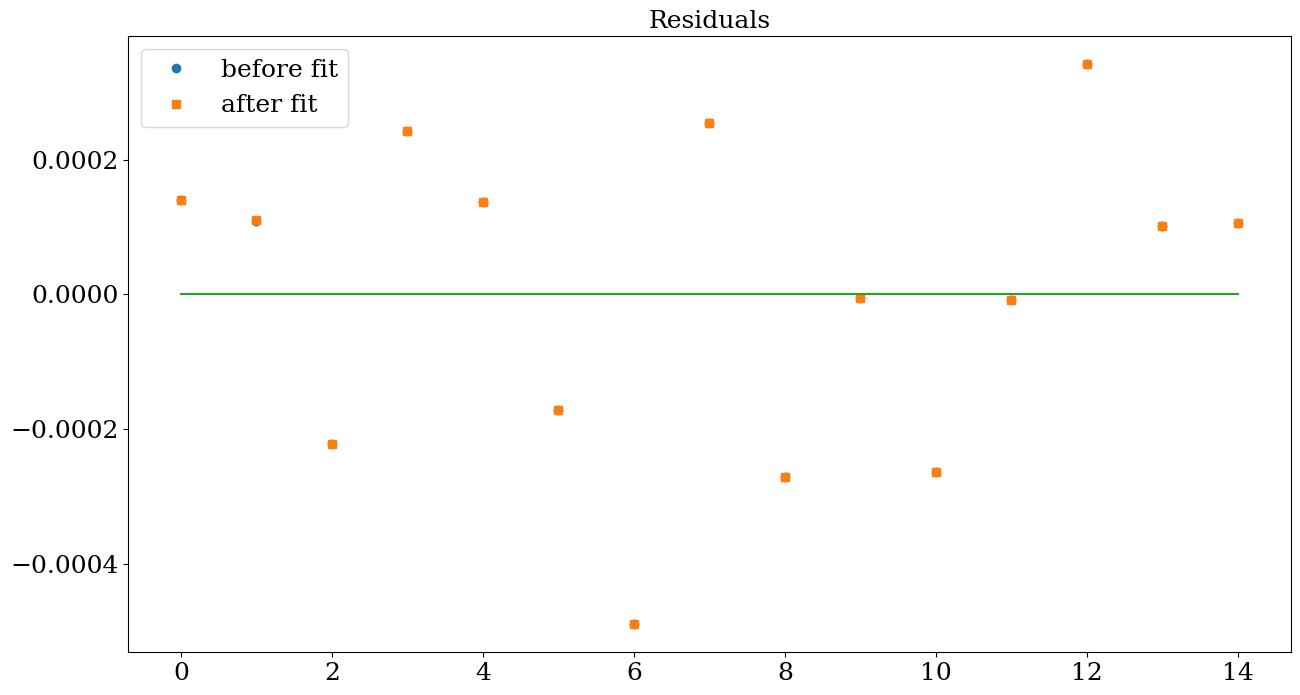

fit residuals standard deviation 0.00022712366994938254
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.738e-07 redchi=5.527e-08 params={'c_g': -0.00254387403225875}
  iter 0: chisqr=7.738e-07 redchi=5.527e-08 params={'c_g': -0.00254387403225875}
  iter 1: chisqr=7.738e-07 redchi=5.527e-08 params={'c_g': -0.00254387403225875}
  iter 2: chisqr=7.738e-07 redchi=5.527e-08 params={'c_g': -0.0025438485935184276}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'c_g': -0.0025444681077899448}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'c_g': -0.0025444681077899448}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002716717 (fixed)
    Gamma_prime_g:  0.0006188078 (fixed)
    qG_g:           0.0004178048 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254447 +/- 3.7786e-04 (14.85%) (init = -0.002543874)
    e2Qq0_g:       -0.1083496 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.526

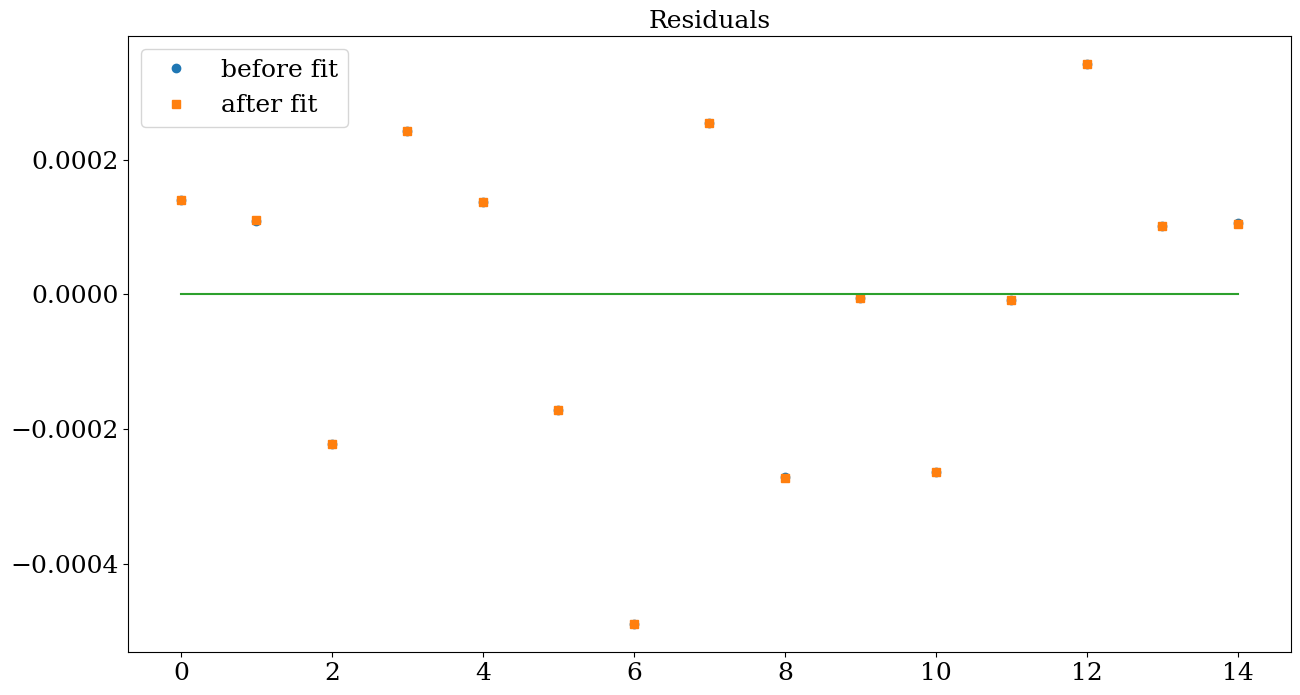

fit residuals standard deviation 0.00022712365649379666
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.738e-07 redchi=5.527e-08 params={'bF_g': -0.06278077371761522}
  iter 0: chisqr=7.738e-07 redchi=5.527e-08 params={'bF_g': -0.06278077371761522}
  iter 1: chisqr=7.738e-07 redchi=5.527e-08 params={'bF_g': -0.06278077371761522}
  iter 2: chisqr=7.738e-07 redchi=5.527e-08 params={'bF_g': -0.06278014590987804}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'bF_g': -0.06278076608027974}
  iter 3: chisqr=7.738e-07 redchi=5.527e-08 params={'bF_g': -0.06278076608027974}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002716717 (fixed)
    Gamma_prime_g:  0.0006188078 (fixed)
    qG_g:           0.0004178048 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 +/- 3.9508e-05 (0.06%) (init = -0.06278077)
    c_g:           -0.002544468 (fixed)
    e2Qq0_g:       -0.1083496 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5269

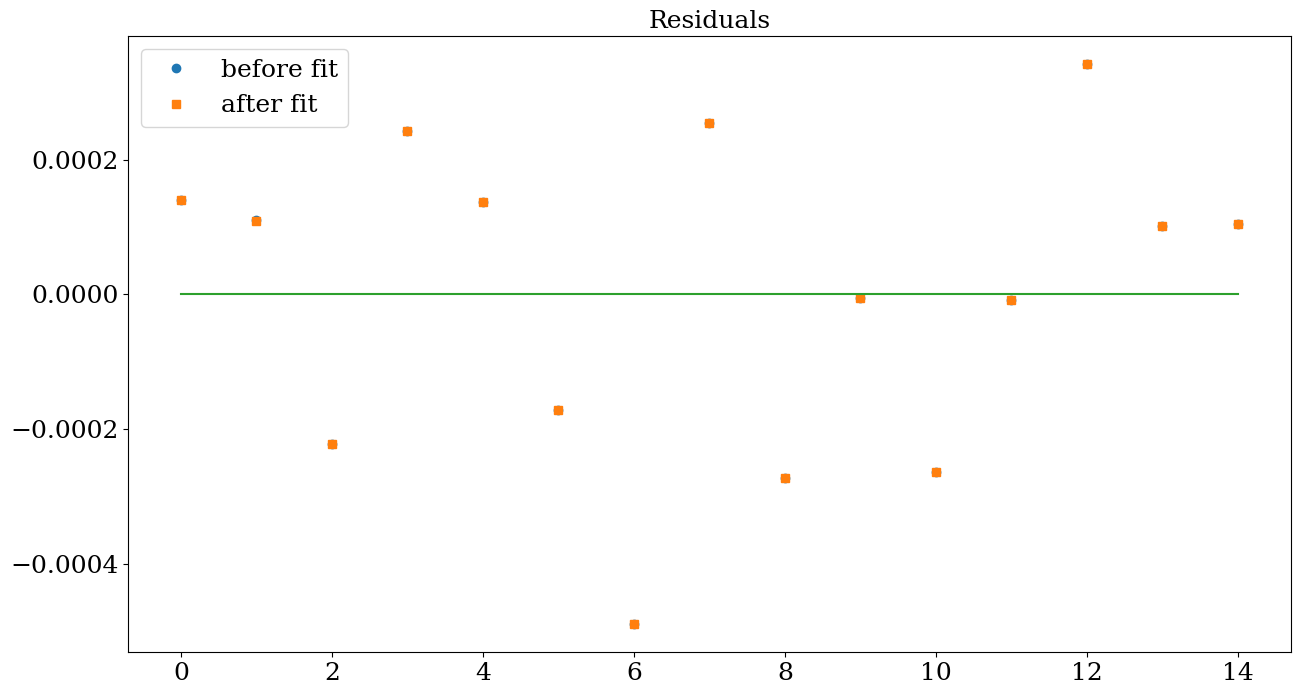

fit residuals standard deviation 0.00022712365640393747
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.738e-07 redchi=5.527e-08 params={'Gamma_SR_g': -0.00271671670858913}
  iter 0: chisqr=7.738e-07 redchi=5.527e-08 params={'Gamma_SR_g': -0.00271671670858913}
  iter 1: chisqr=7.738e-07 redchi=5.527e-08 params={'Gamma_SR_g': -0.00271671670858913}
  iter 2: chisqr=7.738e-07 redchi=5.527e-08 params={'Gamma_SR_g': -0.0027166895414220443}
  iter 3: chisqr=7.736e-07 redchi=5.526e-08 params={'Gamma_SR_g': -0.0027330182231064693}
  iter 3: chisqr=7.736e-07 redchi=5.526e-08 params={'Gamma_SR_g': -0.0027330182231064693}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00273302 +/- 3.0320e-04 (11.09%) (init = -0.002716717)
    Gamma_prime_g:  0.0006188078 (fixed)
    qG_g:           0.0004178048 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002544468 (fixed)
    e2Qq0_g:       -0.1083496 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07

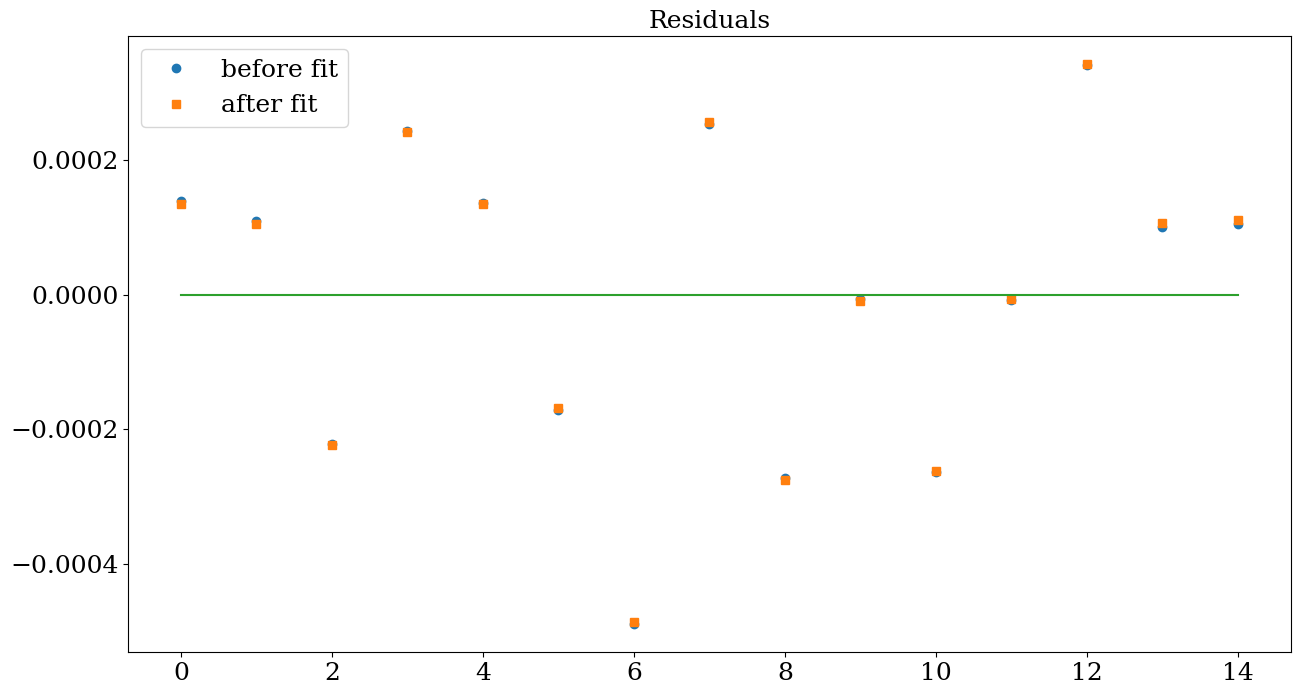

fit residuals standard deviation 0.00022709988386087663
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.736e-07 redchi=5.526e-08 params={'Gamma_prime_g': 0.0006188077808401613}
  iter 0: chisqr=7.736e-07 redchi=5.526e-08 params={'Gamma_prime_g': 0.0006188077808401613}
  iter 1: chisqr=7.736e-07 redchi=5.526e-08 params={'Gamma_prime_g': 0.0006188077808401613}
  iter 2: chisqr=7.736e-07 redchi=5.526e-08 params={'Gamma_prime_g': 0.0006188139689179697}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'Gamma_prime_g': 0.000634788020147461}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'Gamma_prime_g': 0.000634788020147461}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002733018 (fixed)
    Gamma_prime_g:  6.3479e-04 +/- 2.9416e-04 (46.34%) (init = 0.0006188078)
    qG_g:           0.0004178048 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002544468 (fixed)
    e2Qq0_g:       -0.1083496 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_e

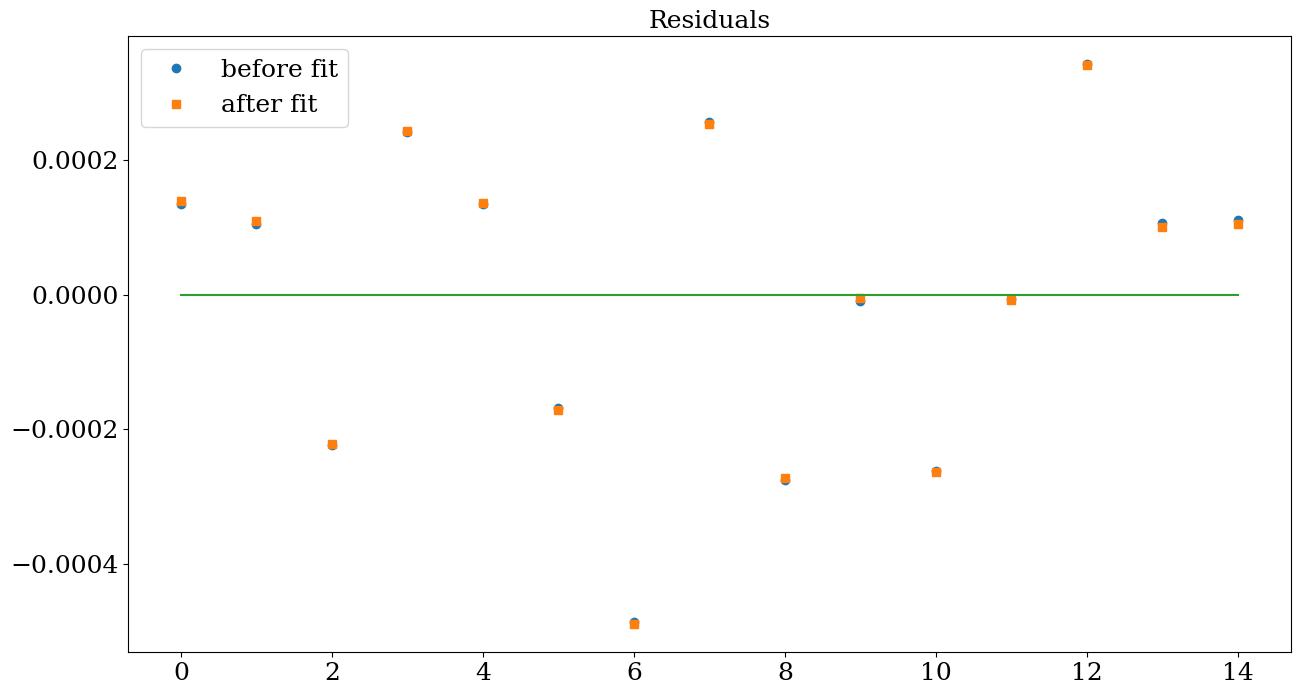

fit residuals standard deviation 0.0002270761385381495
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.735e-07 redchi=5.525e-08 params={'qG_g': 0.0004178047603830134}
  iter 0: chisqr=7.735e-07 redchi=5.525e-08 params={'qG_g': 0.0004178047603830134}
  iter 1: chisqr=7.735e-07 redchi=5.525e-08 params={'qG_g': 0.0004178047603830134}
  iter 2: chisqr=7.735e-07 redchi=5.525e-08 params={'qG_g': 0.00041780893843061727}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'qG_g': 0.00041788612654922316}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'qG_g': 0.00041788612654922316}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002733018 (fixed)
    Gamma_prime_g:  0.000634788 (fixed)
    qG_g:           4.1789e-04 +/- 6.0751e-05 (14.54%) (init = 0.0004178048)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002544468 (fixed)
    e2Qq0_g:       -0.1083496 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:

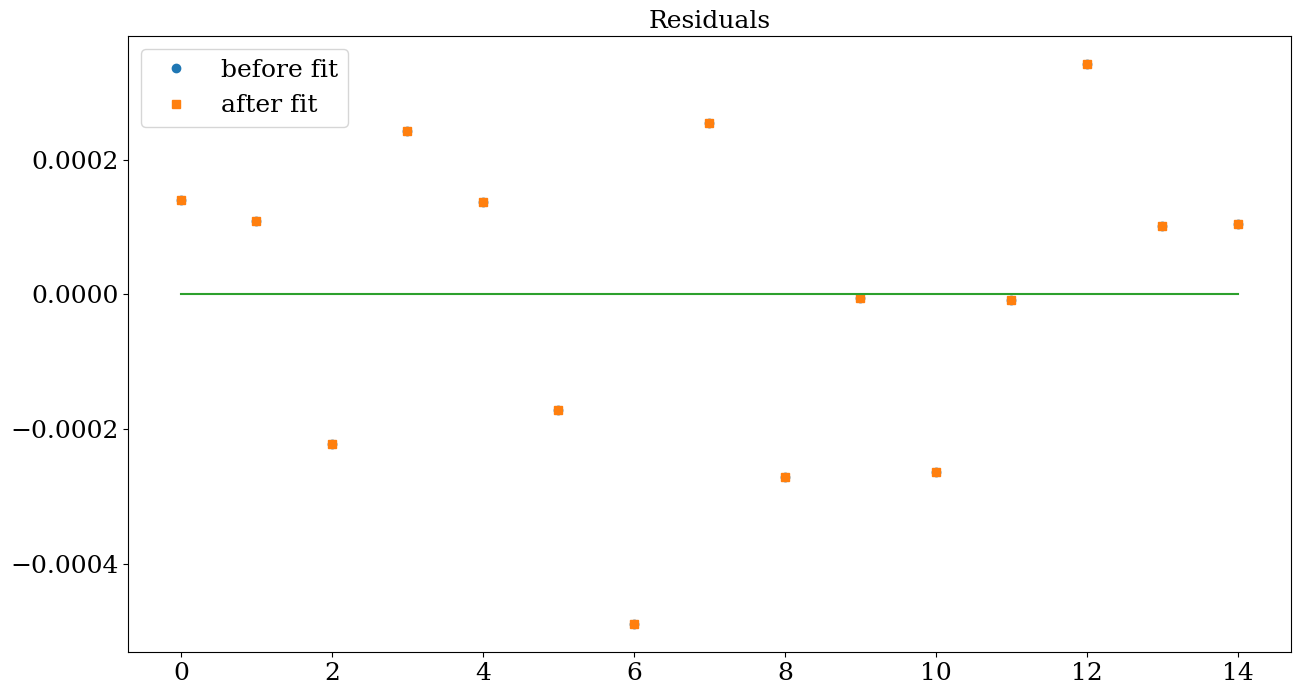

fit residuals standard deviation 0.00022707613192777564
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.735e-07 redchi=5.525e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 0: chisqr=7.735e-07 redchi=5.525e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 1: chisqr=7.735e-07 redchi=5.525e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 2: chisqr=7.735e-07 redchi=5.525e-08 params={'pG2qG_g': 0.0004356863493012594}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'pG2qG_g': 0.0004355964722056053}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'pG2qG_g': 0.0004356819924813346}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002733018 (fixed)
    Gamma_prime_g:  0.000634788 (fixed)
    qG_g:           0.0004178861 (fixed)
    pG2qG_g:        4.3568e-04 +/- 2.9427e-04 (67.54%) (init = 0.000435682)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002544468 (fixed)
    e2Qq0_g:       -0.1083496 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduc

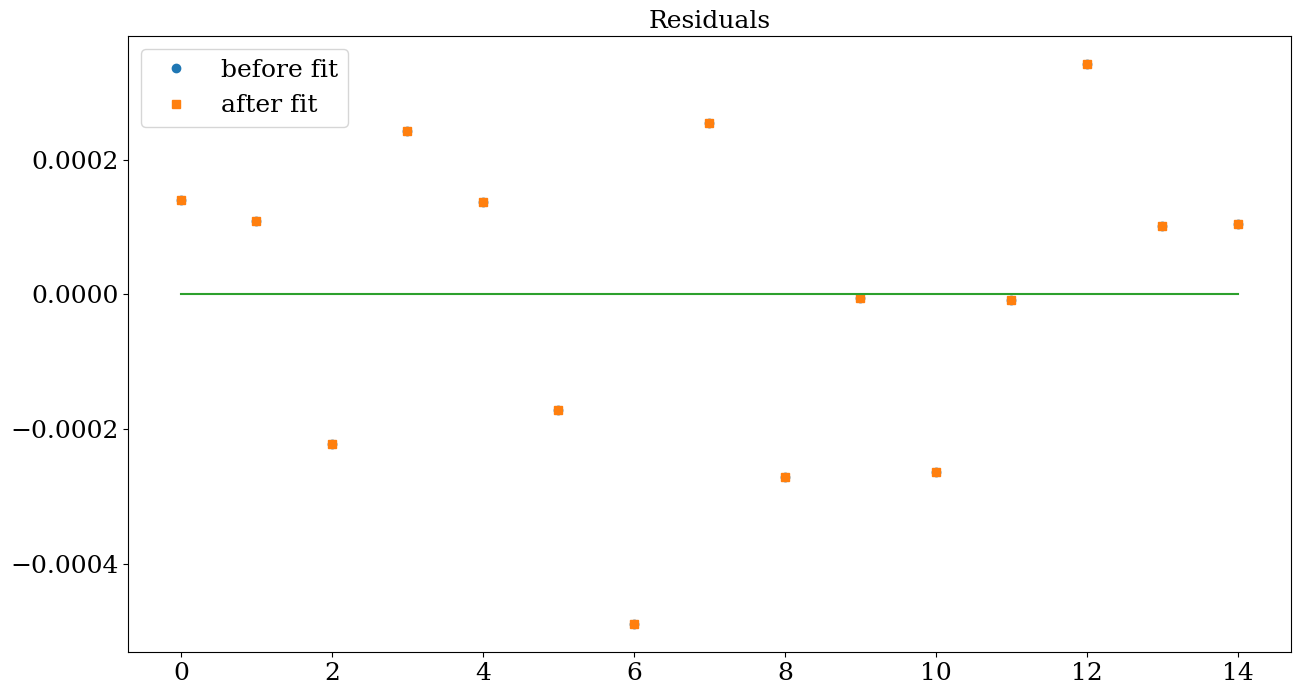

fit residuals standard deviation 0.00022707613192777564
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.735e-07 redchi=5.525e-08 params={'Torg_g': 319.91728179145315}
  iter 0: chisqr=7.735e-07 redchi=5.525e-08 params={'Torg_g': 319.91728179145315}
  iter 1: chisqr=7.735e-07 redchi=5.525e-08 params={'Torg_g': 319.91728179145315}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.92048096427106}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'Torg_g': 319.9172817624927}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'Torg_g': 319.9172817624927}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0689e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002733018 (fixed)
    Gamma_prime_g:  0.000634788 (fixed)
    qG_g:           0.0004178861 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002544468 (fixed)
    e2Qq0_g:       -0.1083496 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.52466817

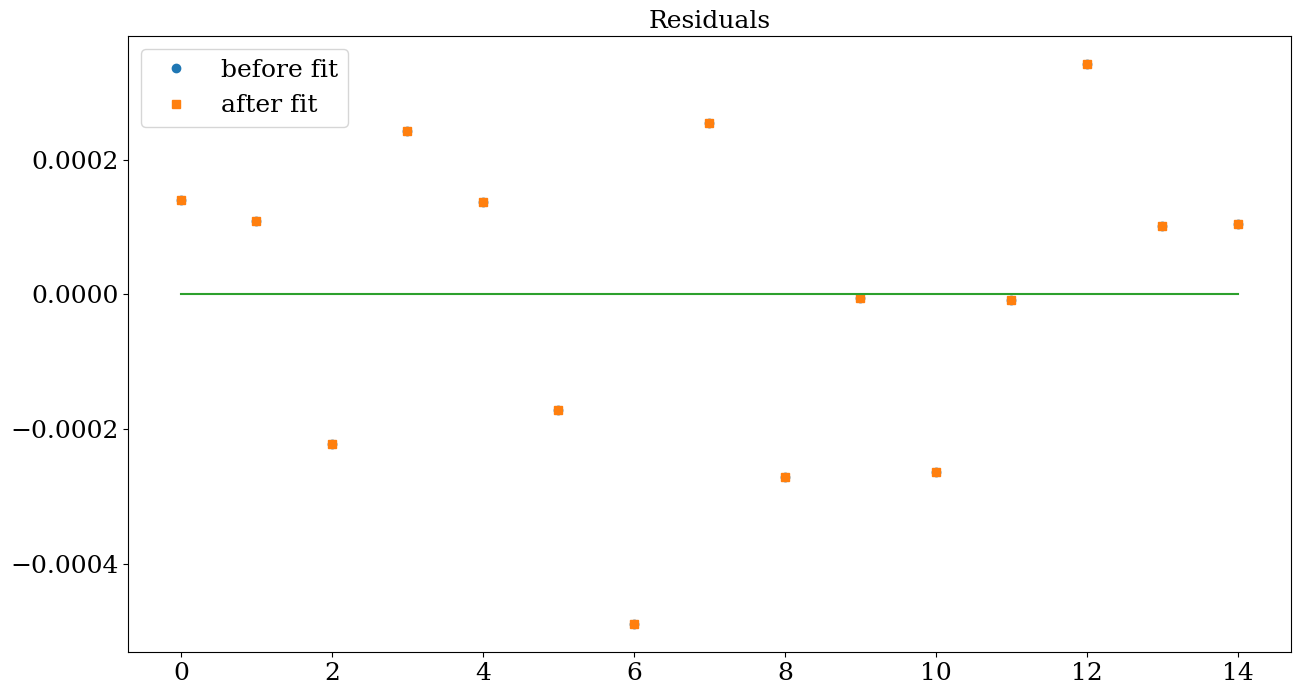

fit residuals standard deviation 0.00022707613187619453
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.735e-07 redchi=5.525e-08 params={'e2Qq0_g': -0.10834957363108738}
  iter 0: chisqr=7.735e-07 redchi=5.525e-08 params={'e2Qq0_g': -0.10834957363108738}
  iter 1: chisqr=7.735e-07 redchi=5.525e-08 params={'e2Qq0_g': -0.10834957363108738}
  iter 2: chisqr=7.735e-07 redchi=5.525e-08 params={'e2Qq0_g': -0.10834849013535107}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'e2Qq0_g': -0.10834893374784485}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'e2Qq0_g': -0.10834893374784485}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002733018 (fixed)
    Gamma_prime_g:  0.000634788 (fixed)
    qG_g:           0.0004178861 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.002544468 (fixed)
    e2Qq0_g:       -0.10834893 +/- 0.00101086 (0.93%) (init = -0.1083496)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi

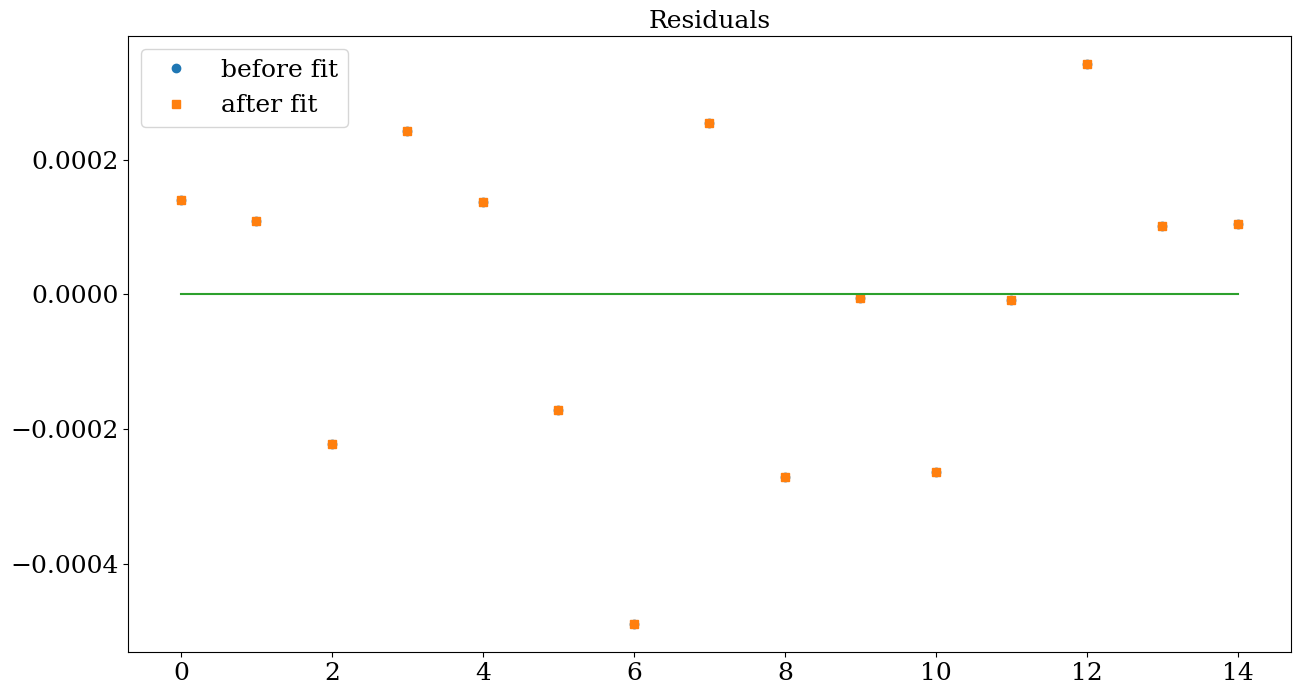

fit residuals standard deviation 0.0002270761284794247
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.735e-07 redchi=5.525e-08 params={'c_g': -0.0025444681077899448}
  iter 0: chisqr=7.735e-07 redchi=5.525e-08 params={'c_g': -0.0025444681077899448}
  iter 1: chisqr=7.735e-07 redchi=5.525e-08 params={'c_g': -0.0025444681077899448}
  iter 2: chisqr=7.735e-07 redchi=5.525e-08 params={'c_g': -0.002544442663108867}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'c_g': -0.002545042146153301}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'c_g': -0.002545042146153301}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002733018 (fixed)
    Gamma_prime_g:  0.000634788 (fixed)
    qG_g:           0.0004178861 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278077 (fixed)
    c_g:           -0.00254504 +/- 3.7776e-04 (14.84%) (init = -0.002544468)
    e2Qq0_g:       -0.1083489 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5

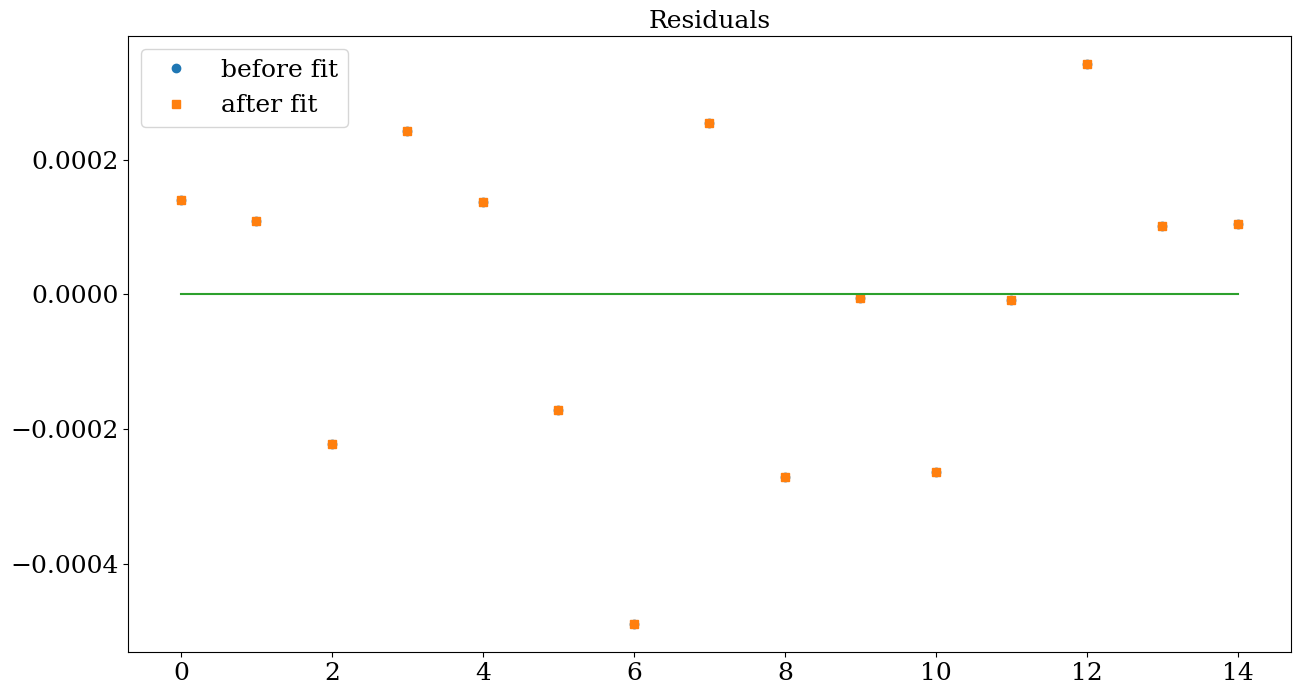

fit residuals standard deviation 0.0002270761141144892
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.735e-07 redchi=5.525e-08 params={'bF_g': -0.06278076608027974}
  iter 0: chisqr=7.735e-07 redchi=5.525e-08 params={'bF_g': -0.06278076608027974}
  iter 1: chisqr=7.735e-07 redchi=5.525e-08 params={'bF_g': -0.06278076608027974}
  iter 2: chisqr=7.735e-07 redchi=5.525e-08 params={'bF_g': -0.06278013827261894}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'bF_g': -0.06278075745811453}
  iter 3: chisqr=7.735e-07 redchi=5.525e-08 params={'bF_g': -0.06278075745811453}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002733018 (fixed)
    Gamma_prime_g:  0.000634788 (fixed)
    qG_g:           0.0004178861 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278076 +/- 3.9500e-05 (0.06%) (init = -0.06278077)
    c_g:           -0.002545042 (fixed)
    e2Qq0_g:       -0.1083489 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.52466

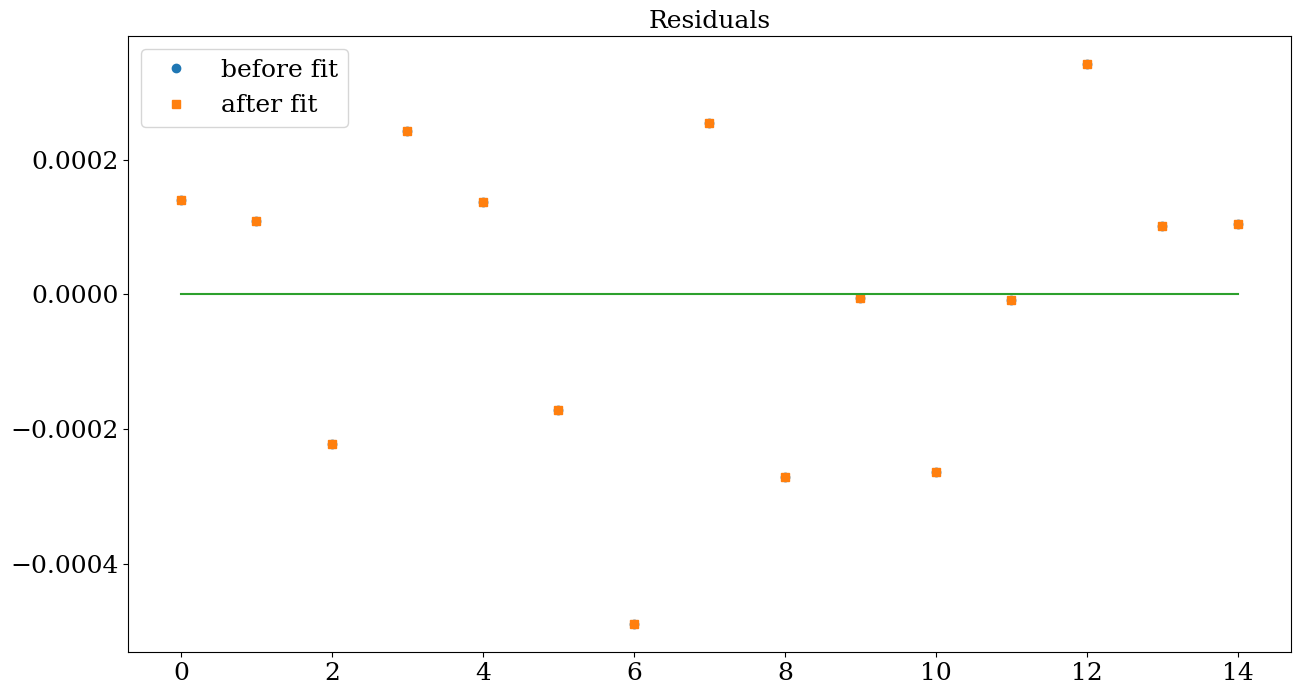

fit residuals standard deviation 0.00022707611380422472
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.735e-07 redchi=5.525e-08 params={'Gamma_SR_g': -0.0027330182231064693}
  iter 0: chisqr=7.735e-07 redchi=5.525e-08 params={'Gamma_SR_g': -0.0027330182231064693}
  iter 1: chisqr=7.735e-07 redchi=5.525e-08 params={'Gamma_SR_g': -0.0027330182231064693}
  iter 2: chisqr=7.735e-07 redchi=5.525e-08 params={'Gamma_SR_g': -0.0027329908929242383}
  iter 3: chisqr=7.733e-07 redchi=5.523e-08 params={'Gamma_SR_g': -0.0027495167856813204}
  iter 3: chisqr=7.733e-07 redchi=5.523e-08 params={'Gamma_SR_g': -0.0027495167856813204}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00274952 +/- 3.0309e-04 (11.02%) (init = -0.002733018)
    Gamma_prime_g:  0.000634788 (fixed)
    qG_g:           0.0004178861 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002545042 (fixed)
    e2Qq0_g:       -0.1083489 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:     

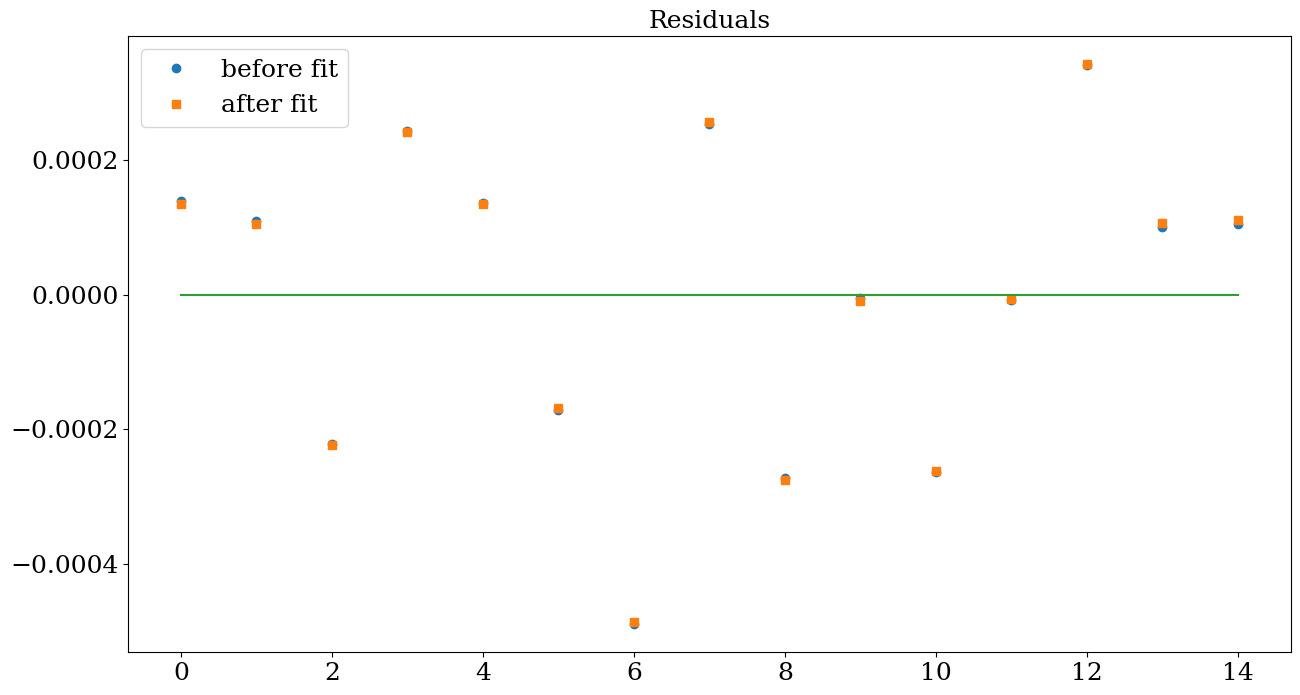

fit residuals standard deviation 0.00022705179333889957
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.733e-07 redchi=5.523e-08 params={'Gamma_prime_g': 0.000634788020147461}
  iter 0: chisqr=7.733e-07 redchi=5.523e-08 params={'Gamma_prime_g': 0.000634788020147461}
  iter 1: chisqr=7.733e-07 redchi=5.523e-08 params={'Gamma_prime_g': 0.000634788020147461}
  iter 2: chisqr=7.733e-07 redchi=5.523e-08 params={'Gamma_prime_g': 0.0006347943680276625}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'Gamma_prime_g': 0.0006510466180328854}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'Gamma_prime_g': 0.0006510466180328854}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002749517 (fixed)
    Gamma_prime_g:  6.5105e-04 +/- 2.9407e-04 (45.17%) (init = 0.000634788)
    qG_g:           0.0004178861 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002545042 (fixed)
    e2Qq0_g:       -0.1083489 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff

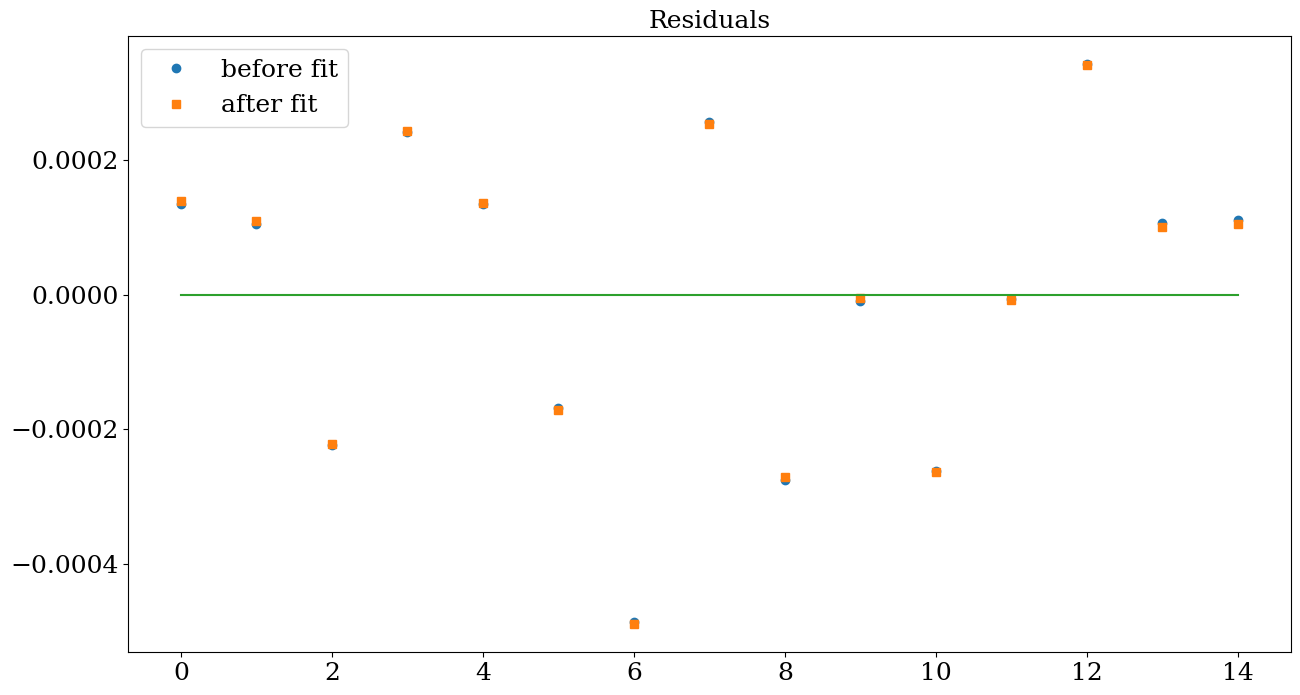

fit residuals standard deviation 0.00022702807120383904
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.731e-07 redchi=5.522e-08 params={'qG_g': 0.00041788612654922316}
  iter 0: chisqr=7.731e-07 redchi=5.522e-08 params={'qG_g': 0.00041788612654922316}
  iter 1: chisqr=7.731e-07 redchi=5.522e-08 params={'qG_g': 0.00041788612654922316}
  iter 2: chisqr=7.731e-07 redchi=5.522e-08 params={'qG_g': 0.00041789030541048865}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'qG_g': 0.0004179514377498471}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'qG_g': 0.0004179514377498471}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002749517 (fixed)
    Gamma_prime_g:  0.0006510466 (fixed)
    qG_g:           4.1795e-04 +/- 6.0733e-05 (14.53%) (init = 0.0004178861)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002545042 (fixed)
    e2Qq0_g:       -0.1083489 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi square

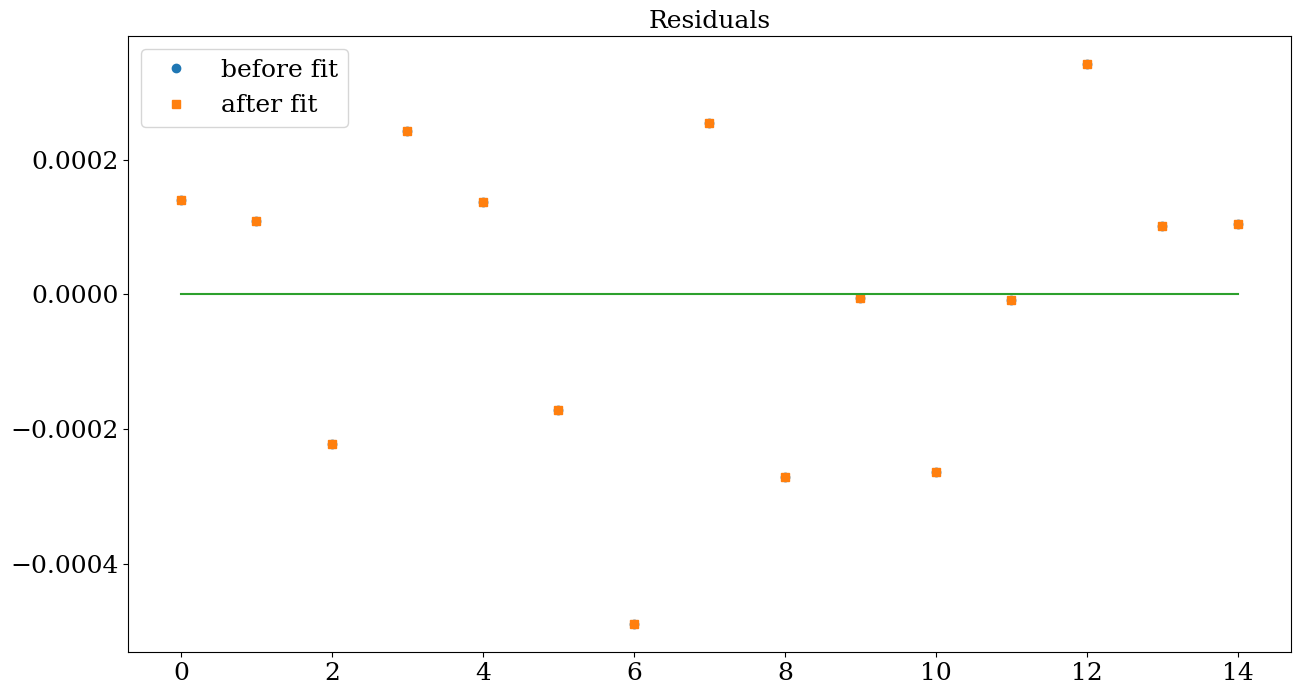

fit residuals standard deviation 0.00022702806589385886
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.731e-07 redchi=5.522e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 0: chisqr=7.731e-07 redchi=5.522e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 1: chisqr=7.731e-07 redchi=5.522e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 2: chisqr=7.731e-07 redchi=5.522e-08 params={'pG2qG_g': 0.0004356863493012594}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'pG2qG_g': 0.00043559546092552094}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'pG2qG_g': 0.0004356819924813346}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002749517 (fixed)
    Gamma_prime_g:  0.0006510466 (fixed)
    qG_g:           0.0004179514 (fixed)
    pG2qG_g:        4.3568e-04 +/- 2.9417e-04 (67.52%) (init = 0.000435682)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002545042 (fixed)
    e2Qq0_g:       -0.1083489 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

red

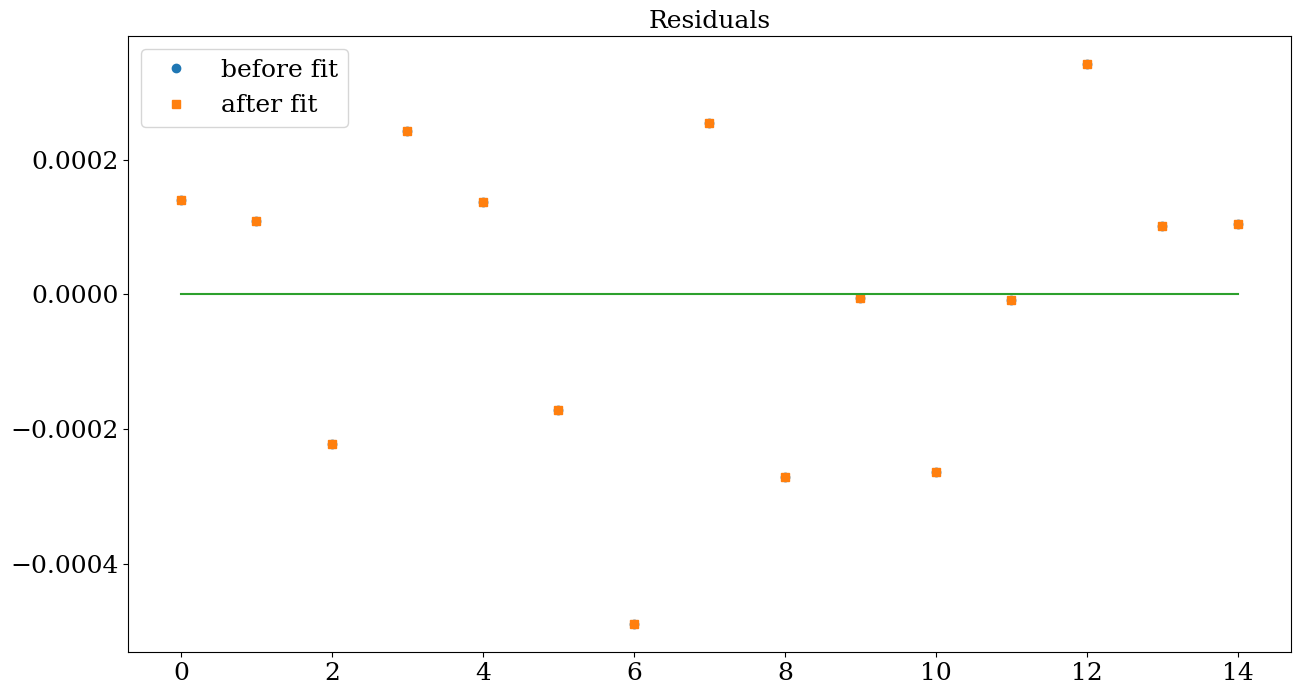

fit residuals standard deviation 0.00022702806589385886
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.731e-07 redchi=5.522e-08 params={'Torg_g': 319.9172817624927}
  iter 0: chisqr=7.731e-07 redchi=5.522e-08 params={'Torg_g': 319.9172817624927}
  iter 1: chisqr=7.731e-07 redchi=5.522e-08 params={'Torg_g': 319.9172817624927}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.9204809353103}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'Torg_g': 319.9172817521237}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'Torg_g': 319.9172817624927}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0676e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002749517 (fixed)
    Gamma_prime_g:  0.0006510466 (fixed)
    qG_g:           0.0004179514 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002545042 (fixed)
    e2Qq0_g:       -0.1083489 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.52232958689

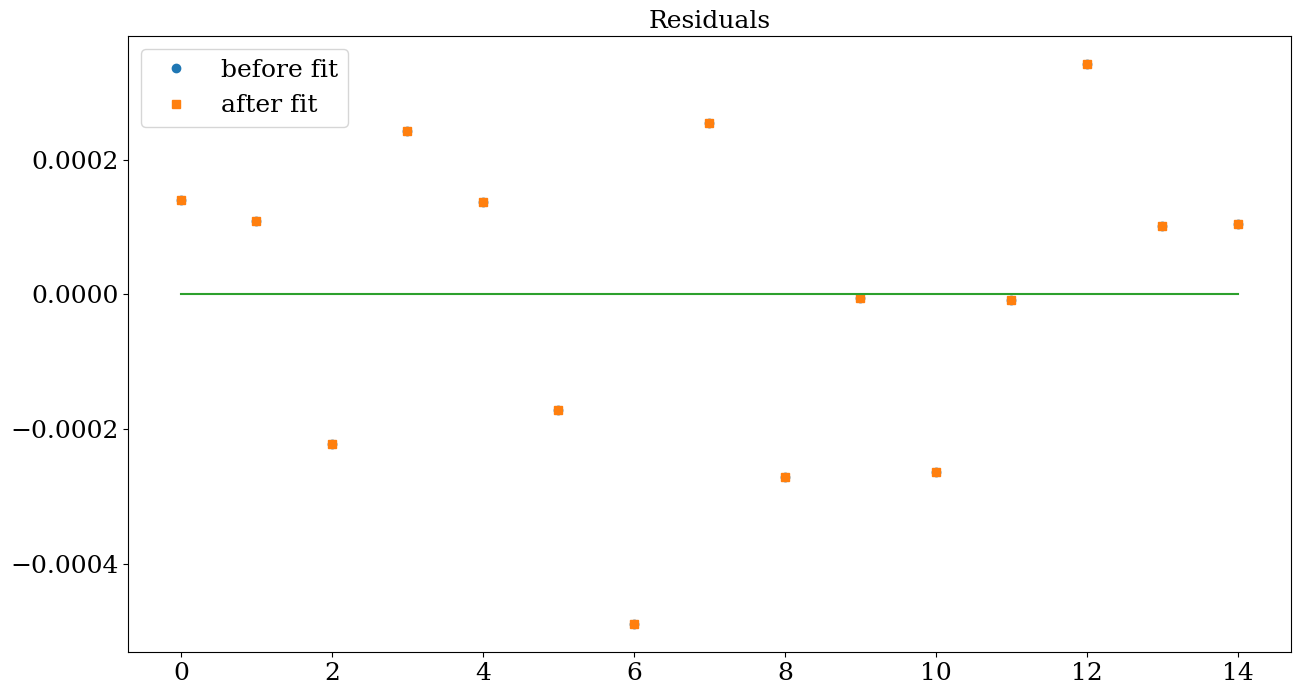

fit residuals standard deviation 0.00022702806589385886
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.731e-07 redchi=5.522e-08 params={'e2Qq0_g': -0.10834893374784485}
  iter 0: chisqr=7.731e-07 redchi=5.522e-08 params={'e2Qq0_g': -0.10834893374784485}
  iter 1: chisqr=7.731e-07 redchi=5.522e-08 params={'e2Qq0_g': -0.10834893374784485}
  iter 2: chisqr=7.731e-07 redchi=5.522e-08 params={'e2Qq0_g': -0.10834785025850738}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'e2Qq0_g': -0.10834826307534466}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'e2Qq0_g': -0.10834826307534466}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002749517 (fixed)
    Gamma_prime_g:  0.0006510466 (fixed)
    qG_g:           0.0004179514 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002545042 (fixed)
    e2Qq0_g:       -0.10834826 +/- 0.00101066 (0.93%) (init = -0.1083489)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced ch

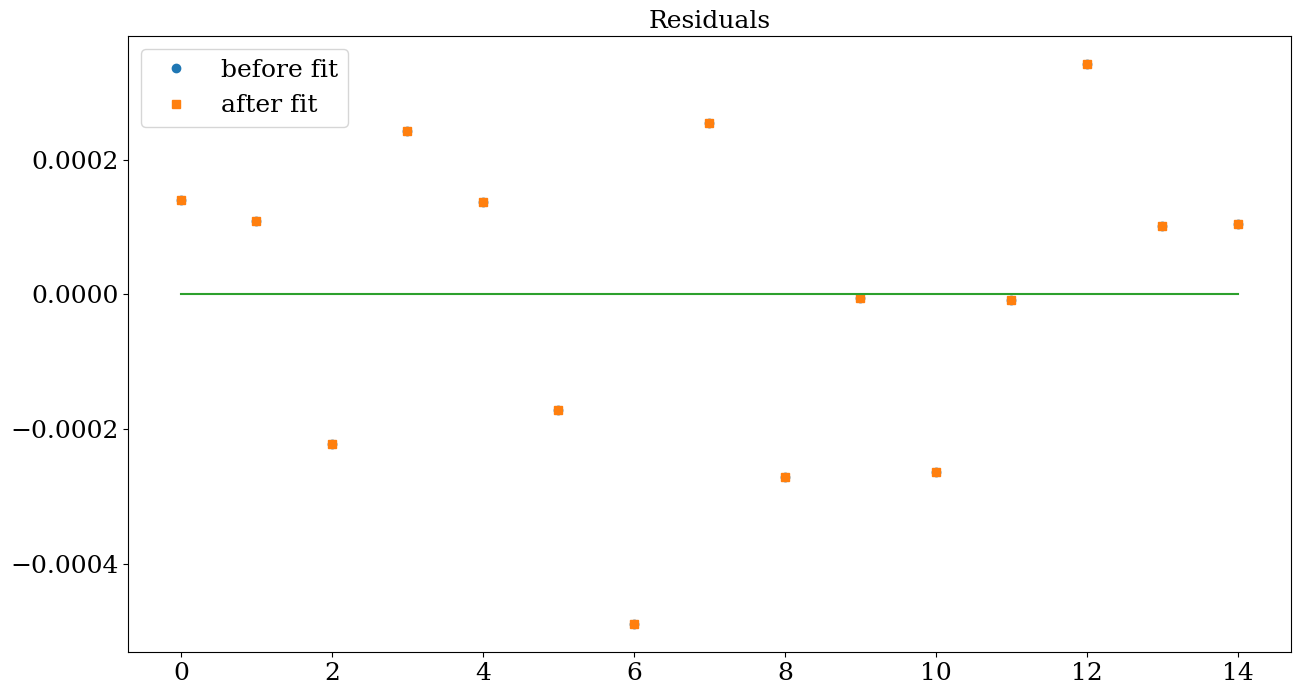

fit residuals standard deviation 0.00022702806213659009
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.731e-07 redchi=5.522e-08 params={'c_g': -0.002545042146153301}
  iter 0: chisqr=7.731e-07 redchi=5.522e-08 params={'c_g': -0.002545042146153301}
  iter 1: chisqr=7.731e-07 redchi=5.522e-08 params={'c_g': -0.002545042146153301}
  iter 2: chisqr=7.731e-07 redchi=5.522e-08 params={'c_g': -0.002545016695731839}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'c_g': -0.0025455571707676664}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'c_g': -0.0025455571707676664}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002749517 (fixed)
    Gamma_prime_g:  0.0006510466 (fixed)
    qG_g:           0.0004179514 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.00254556 +/- 3.7765e-04 (14.84%) (init = -0.002545042)
    e2Qq0_g:       -0.1083483 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5

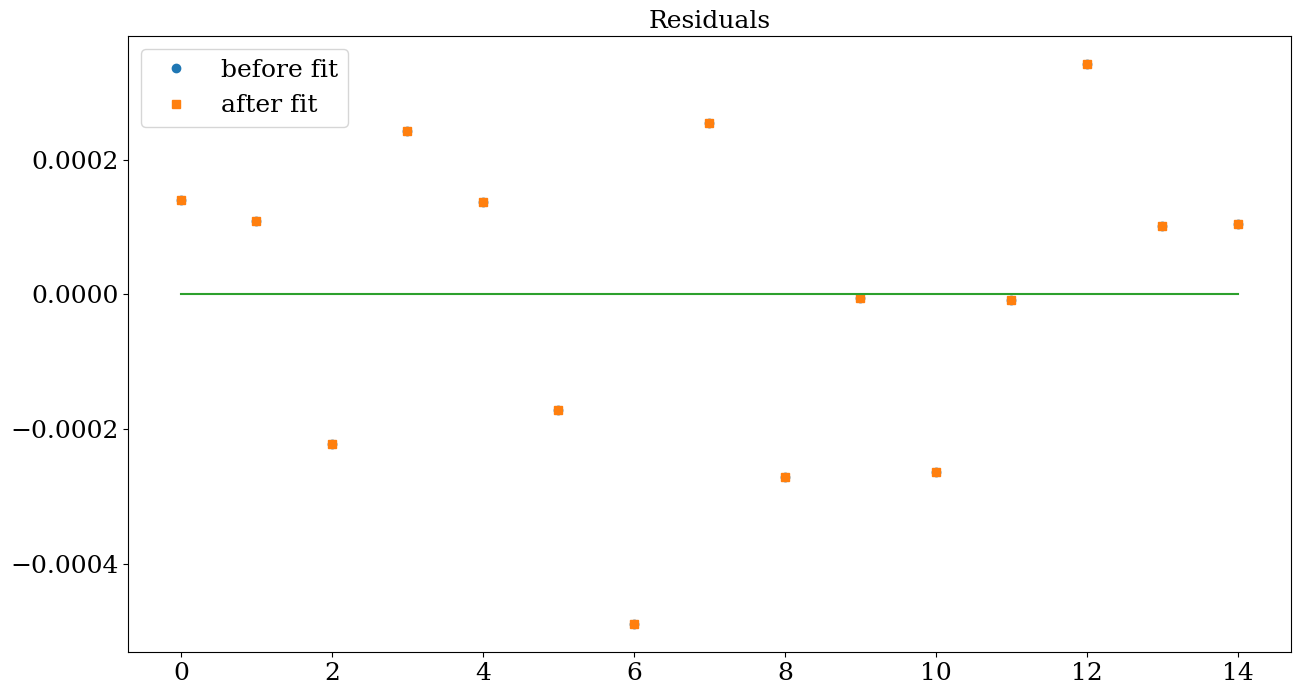

fit residuals standard deviation 0.00022702804555408266
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.731e-07 redchi=5.522e-08 params={'bF_g': -0.06278075745811453}
  iter 0: chisqr=7.731e-07 redchi=5.522e-08 params={'bF_g': -0.06278075745811453}
  iter 1: chisqr=7.731e-07 redchi=5.522e-08 params={'bF_g': -0.06278075745811453}
  iter 2: chisqr=7.731e-07 redchi=5.522e-08 params={'bF_g': -0.06278012965053995}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'bF_g': -0.06278074454287132}
  iter 3: chisqr=7.731e-07 redchi=5.522e-08 params={'bF_g': -0.06278074454287132}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002749517 (fixed)
    Gamma_prime_g:  0.0006510466 (fixed)
    qG_g:           0.0004179514 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278074 +/- 3.9492e-05 (0.06%) (init = -0.06278076)
    c_g:           -0.002545557 (fixed)
    e2Qq0_g:       -0.1083483 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5223

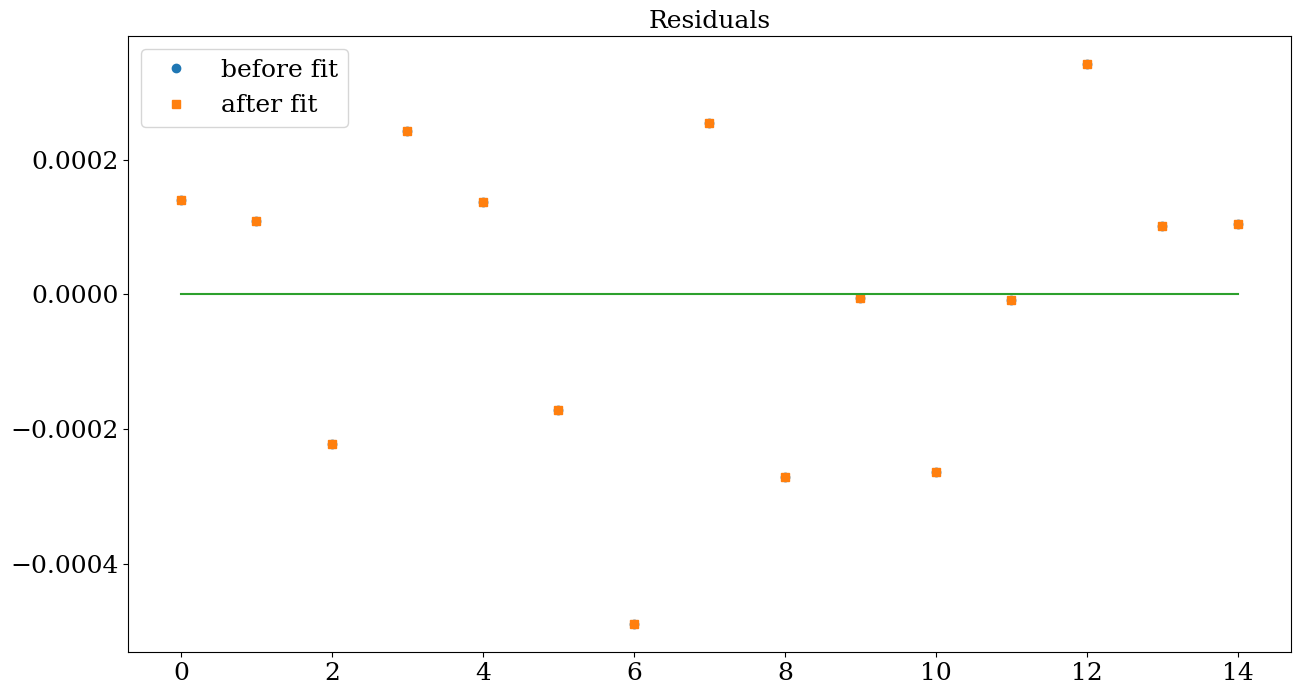

fit residuals standard deviation 0.00022702804520851794
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.731e-07 redchi=5.522e-08 params={'Gamma_SR_g': -0.0027495167856813204}
  iter 0: chisqr=7.731e-07 redchi=5.522e-08 params={'Gamma_SR_g': -0.0027495167856813204}
  iter 1: chisqr=7.731e-07 redchi=5.522e-08 params={'Gamma_SR_g': -0.0027495167856813204}
  iter 2: chisqr=7.731e-07 redchi=5.522e-08 params={'Gamma_SR_g': -0.0027494892905134635}
  iter 3: chisqr=7.73e-07 redchi=5.521e-08 params={'Gamma_SR_g': -0.0027663545788887025}
  iter 3: chisqr=7.73e-07 redchi=5.521e-08 params={'Gamma_SR_g': -0.0027663545788887025}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00276635 +/- 3.0297e-04 (10.95%) (init = -0.002749517)
    Gamma_prime_g:  0.0006510466 (fixed)
    qG_g:           0.0004179514 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278074 (fixed)
    c_g:           -0.002545557 (fixed)
    e2Qq0_g:       -0.1083483 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      

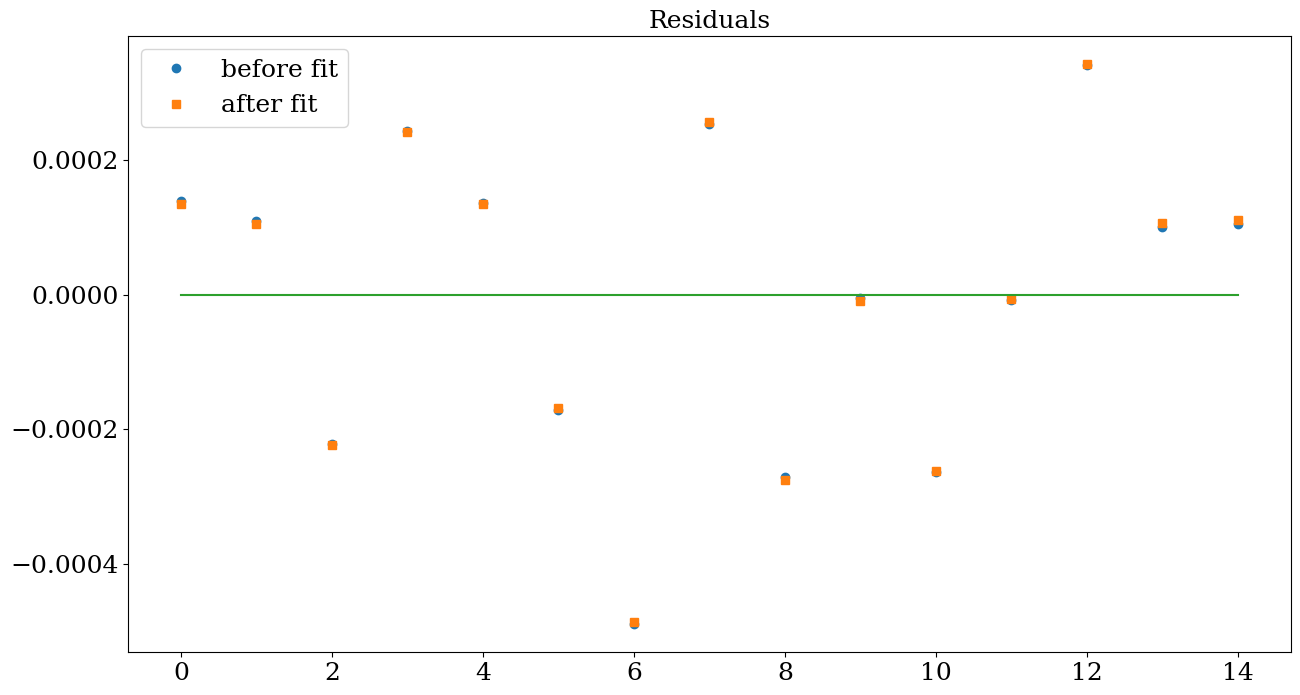

fit residuals standard deviation 0.00022700294650274951
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.73e-07 redchi=5.521e-08 params={'Gamma_prime_g': 0.0006510466180328854}
  iter 0: chisqr=7.73e-07 redchi=5.521e-08 params={'Gamma_prime_g': 0.0006510466180328854}
  iter 1: chisqr=7.73e-07 redchi=5.521e-08 params={'Gamma_prime_g': 0.0006510466180328854}
  iter 2: chisqr=7.73e-07 redchi=5.521e-08 params={'Gamma_prime_g': 0.0006510531284990657}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'Gamma_prime_g': 0.0006675035302130097}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'Gamma_prime_g': 0.0006675035302130097}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002766355 (fixed)
    Gamma_prime_g:  6.6750e-04 +/- 2.9382e-04 (44.02%) (init = 0.0006510466)
    qG_g:           0.0004179514 (fixed)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278074 (fixed)
    c_g:           -0.002545557 (fixed)
    e2Qq0_g:       -0.1083483 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g

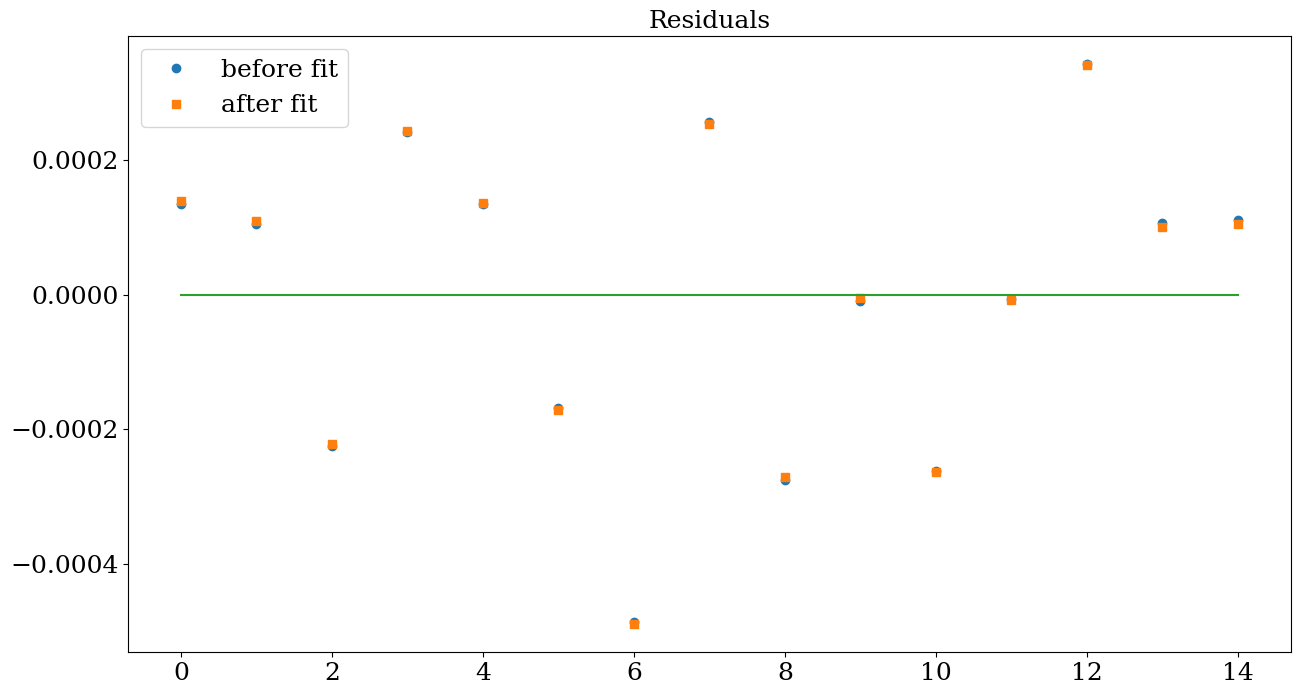

fit residuals standard deviation 0.00022697905946412623
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.728e-07 redchi=5.52e-08 params={'qG_g': 0.0004179514377498471}
  iter 0: chisqr=7.728e-07 redchi=5.52e-08 params={'qG_g': 0.0004179514377498471}
  iter 1: chisqr=7.728e-07 redchi=5.52e-08 params={'qG_g': 0.0004179514377498471}
  iter 2: chisqr=7.728e-07 redchi=5.52e-08 params={'qG_g': 0.0004179556172642246}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'qG_g': 0.0004180152602840204}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'qG_g': 0.0004180152602840204}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002766355 (fixed)
    Gamma_prime_g:  0.0006675035 (fixed)
    qG_g:           4.1802e-04 +/- 6.0711e-05 (14.52%) (init = 0.0004179514)
    pG2qG_g:        0.000435682 (fixed)
    bF_g:          -0.06278074 (fixed)
    c_g:           -0.002545557 (fixed)
    e2Qq0_g:       -0.1083483 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5199

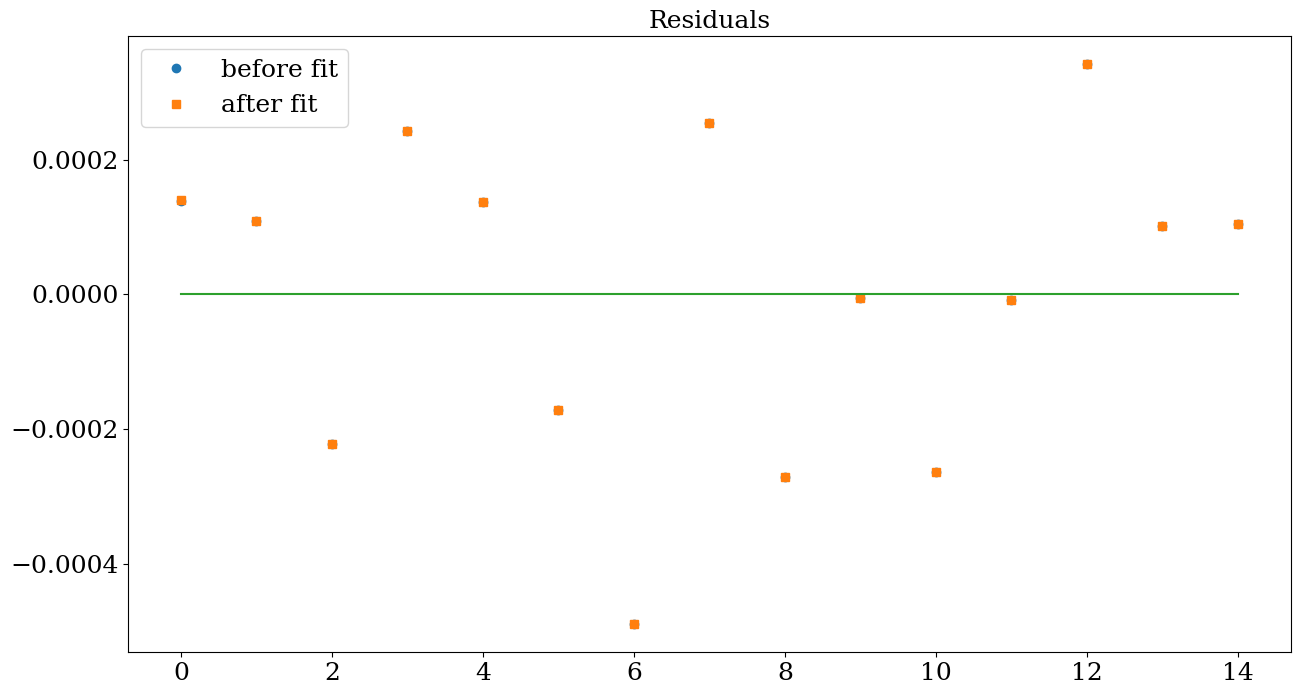

fit residuals standard deviation 0.00022697905461054388
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.728e-07 redchi=5.52e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 0: chisqr=7.728e-07 redchi=5.52e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 1: chisqr=7.728e-07 redchi=5.52e-08 params={'pG2qG_g': 0.0004356819924813346}
  iter 2: chisqr=7.728e-07 redchi=5.52e-08 params={'pG2qG_g': 0.0004356863493012594}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'pG2qG_g': 0.00043644264696723976}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'pG2qG_g': 0.00043644264696723976}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002766355 (fixed)
    Gamma_prime_g:  0.0006675035 (fixed)
    qG_g:           0.0004180153 (fixed)
    pG2qG_g:        4.3644e-04 +/- 2.9404e-04 (67.37%) (init = 0.000435682)
    bF_g:          -0.06278074 (fixed)
    c_g:           -0.002545557 (fixed)
    e2Qq0_g:       -0.1083483 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced 

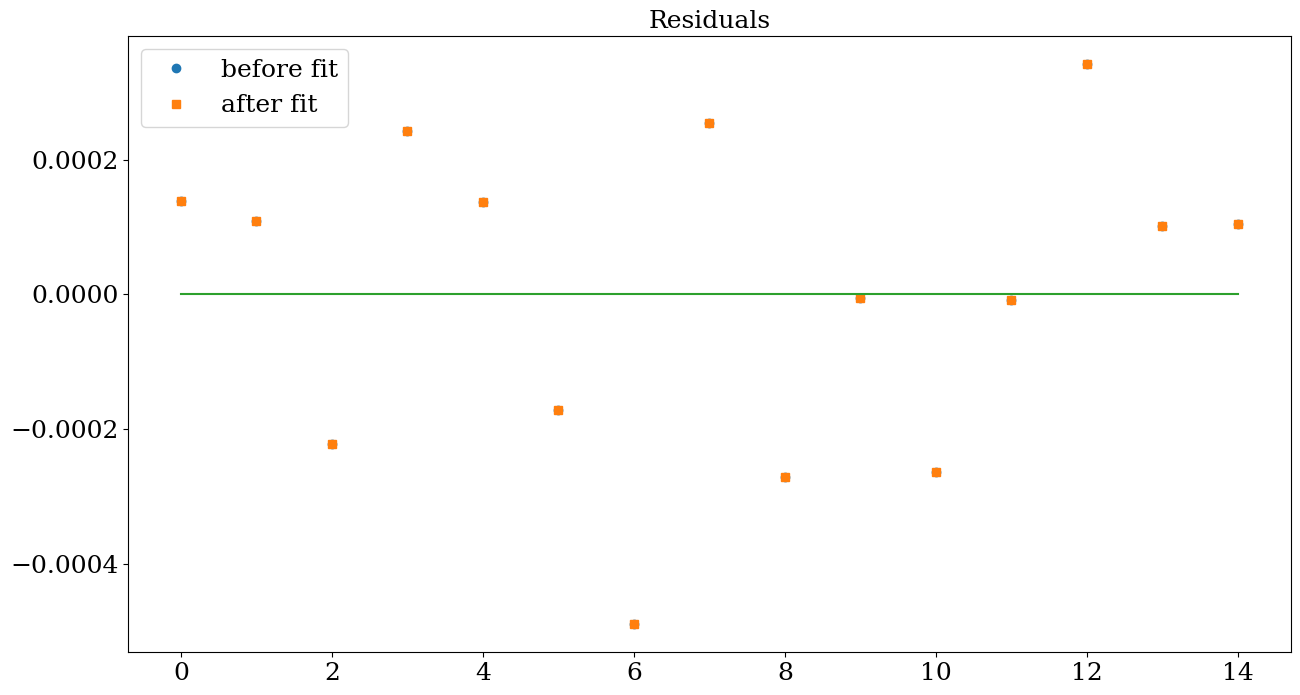

fit residuals standard deviation 0.00022697902578318191
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.728e-07 redchi=5.52e-08 params={'Torg_g': 319.9172817624927}
  iter 0: chisqr=7.728e-07 redchi=5.52e-08 params={'Torg_g': 319.9172817624927}
  iter 1: chisqr=7.728e-07 redchi=5.52e-08 params={'Torg_g': 319.9172817624927}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.9204809353103}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'Torg_g': 319.91728173577997}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'Torg_g': 319.91728173577997}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0663e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002766355 (fixed)
    Gamma_prime_g:  0.0006675035 (fixed)
    qG_g:           0.0004180153 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278074 (fixed)
    c_g:           -0.002545557 (fixed)
    e2Qq0_g:       -0.1083483 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5199440870159

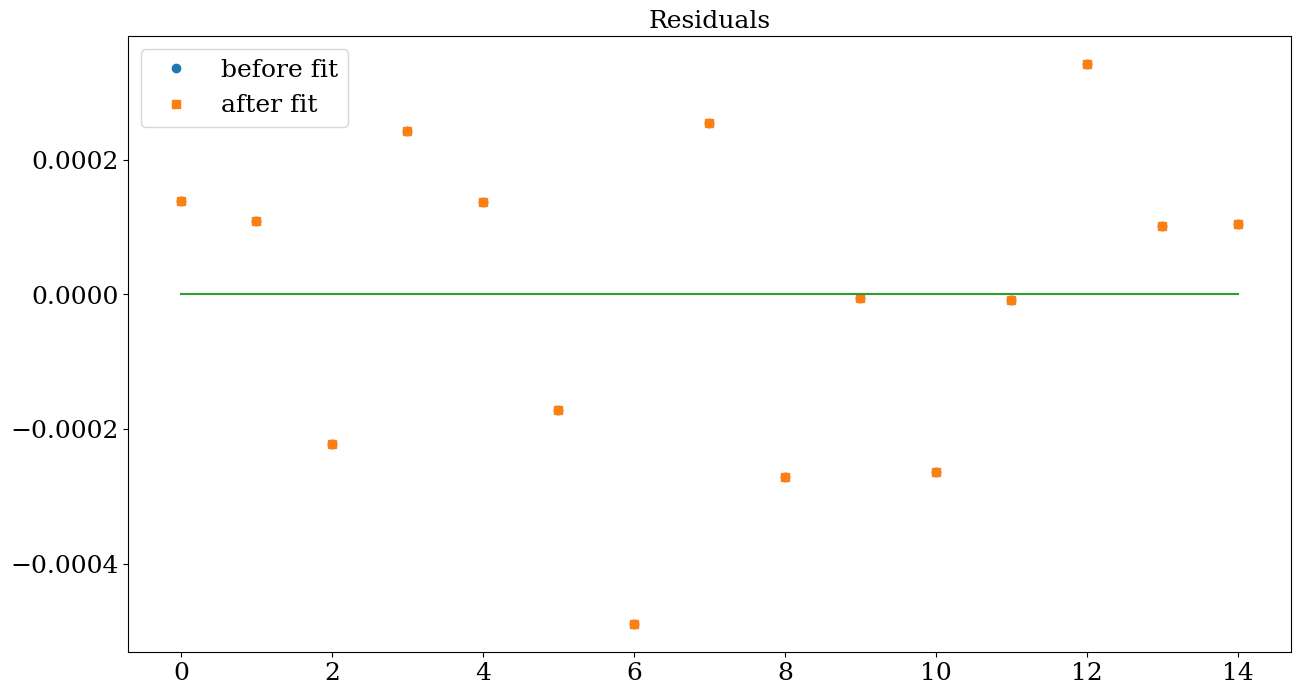

fit residuals standard deviation 0.00022697902578318191
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.728e-07 redchi=5.52e-08 params={'e2Qq0_g': -0.10834826307534466}
  iter 0: chisqr=7.728e-07 redchi=5.52e-08 params={'e2Qq0_g': -0.10834826307534466}
  iter 1: chisqr=7.728e-07 redchi=5.52e-08 params={'e2Qq0_g': -0.10834826307534466}
  iter 2: chisqr=7.728e-07 redchi=5.52e-08 params={'e2Qq0_g': -0.10834717959271391}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'e2Qq0_g': -0.1083477618464861}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'e2Qq0_g': -0.1083477618464861}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002766355 (fixed)
    Gamma_prime_g:  0.0006675035 (fixed)
    qG_g:           0.0004180153 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278074 (fixed)
    c_g:           -0.002545557 (fixed)
    e2Qq0_g:       -0.10834776 +/- 0.00101043 (0.93%) (init = -0.1083483)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squar

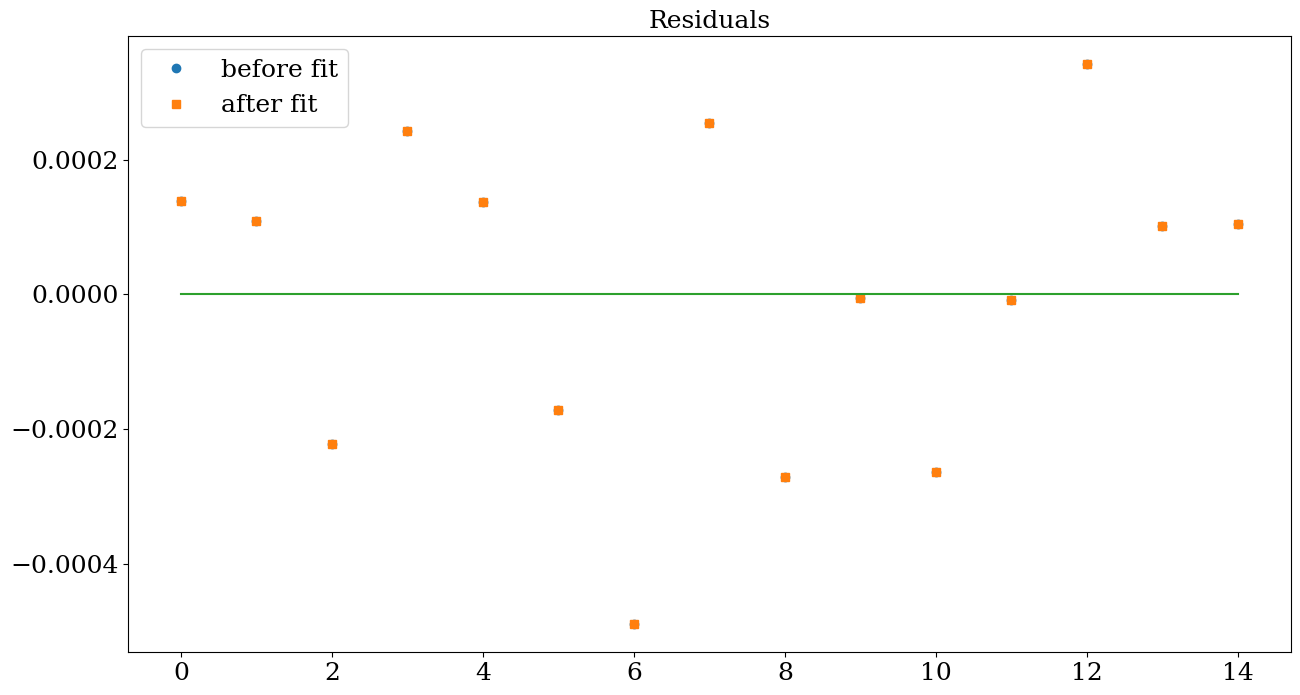

fit residuals standard deviation 0.0002269790236058837
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.728e-07 redchi=5.52e-08 params={'c_g': -0.0025455571707676664}
  iter 0: chisqr=7.728e-07 redchi=5.52e-08 params={'c_g': -0.0025455571707676664}
  iter 1: chisqr=7.728e-07 redchi=5.52e-08 params={'c_g': -0.0025455571707676664}
  iter 2: chisqr=7.728e-07 redchi=5.52e-08 params={'c_g': -0.0025455317151959586}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'c_g': -0.002546296634843867}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'c_g': -0.002546296634843867}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002766355 (fixed)
    Gamma_prime_g:  0.0006675035 (fixed)
    qG_g:           0.0004180153 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278074 (fixed)
    c_g:           -0.00254630 +/- 3.7764e-04 (14.83%) (init = -0.002545557)
    e2Qq0_g:       -0.1083478 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5199

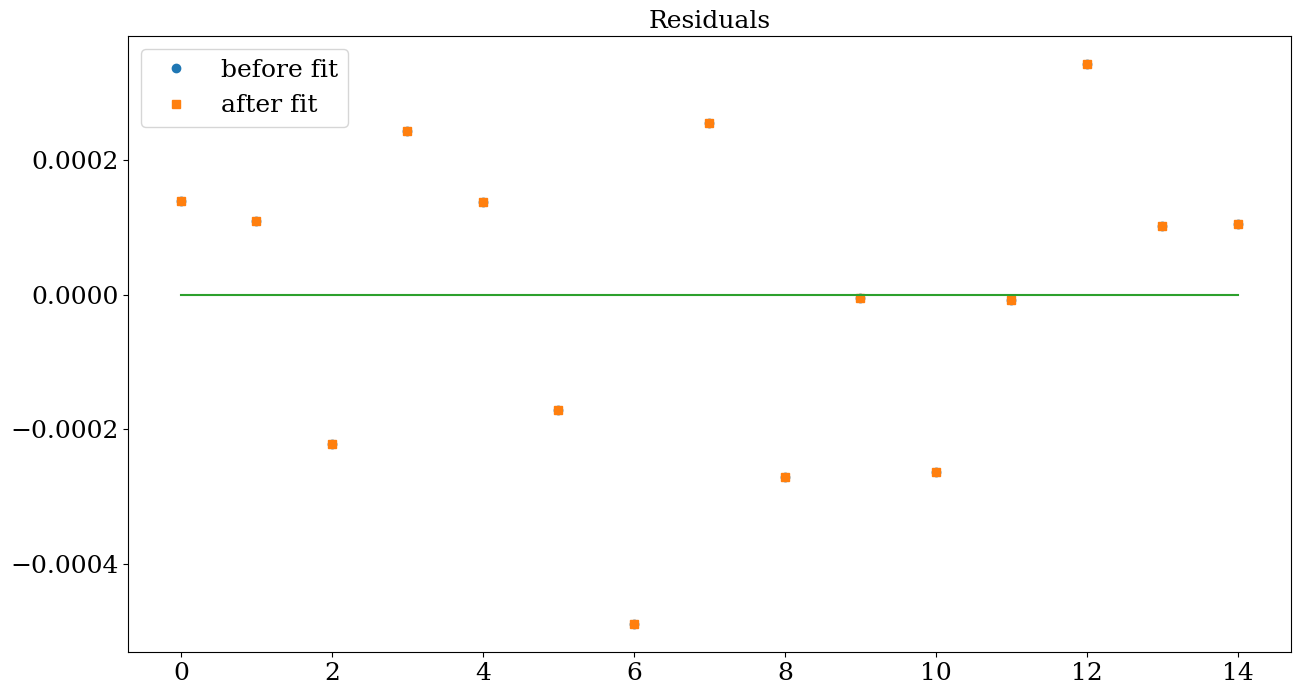

fit residuals standard deviation 0.00022697899253443002
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.728e-07 redchi=5.52e-08 params={'bF_g': -0.06278074454287132}
  iter 0: chisqr=7.728e-07 redchi=5.52e-08 params={'bF_g': -0.06278074454287132}
  iter 1: chisqr=7.728e-07 redchi=5.52e-08 params={'bF_g': -0.06278074454287132}
  iter 2: chisqr=7.728e-07 redchi=5.52e-08 params={'bF_g': -0.06278011673542588}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'bF_g': -0.06278075995884391}
  iter 3: chisqr=7.728e-07 redchi=5.52e-08 params={'bF_g': -0.06278075995884391}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002766355 (fixed)
    Gamma_prime_g:  0.0006675035 (fixed)
    qG_g:           0.0004180153 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278076 +/- 3.9483e-05 (0.06%) (init = -0.06278074)
    c_g:           -0.002546297 (fixed)
    e2Qq0_g:       -0.1083478 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.519942380

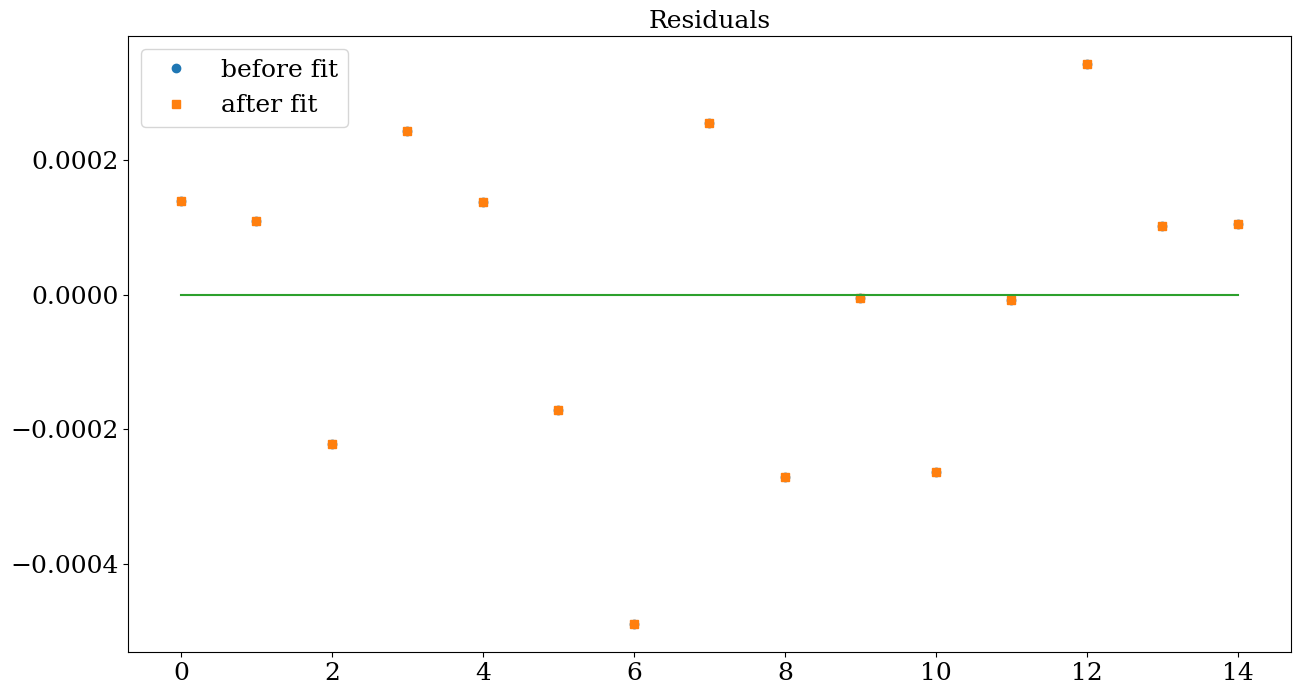

fit residuals standard deviation 0.00022697899024377136
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.728e-07 redchi=5.52e-08 params={'Gamma_SR_g': -0.0027663545788887025}
  iter 0: chisqr=7.728e-07 redchi=5.52e-08 params={'Gamma_SR_g': -0.0027663545788887025}
  iter 1: chisqr=7.728e-07 redchi=5.52e-08 params={'Gamma_SR_g': -0.0027663545788887025}
  iter 2: chisqr=7.728e-07 redchi=5.52e-08 params={'Gamma_SR_g': -0.002766326915342914}
  iter 3: chisqr=7.726e-07 redchi=5.519e-08 params={'Gamma_SR_g': -0.002782691117797522}
  iter 3: chisqr=7.726e-07 redchi=5.519e-08 params={'Gamma_SR_g': -0.002782691117797522}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00278269 +/- 3.0292e-04 (10.89%) (init = -0.002766355)
    Gamma_prime_g:  0.0006675035 (fixed)
    qG_g:           0.0004180153 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002546297 (fixed)
    e2Qq0_g:       -0.1083478 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07

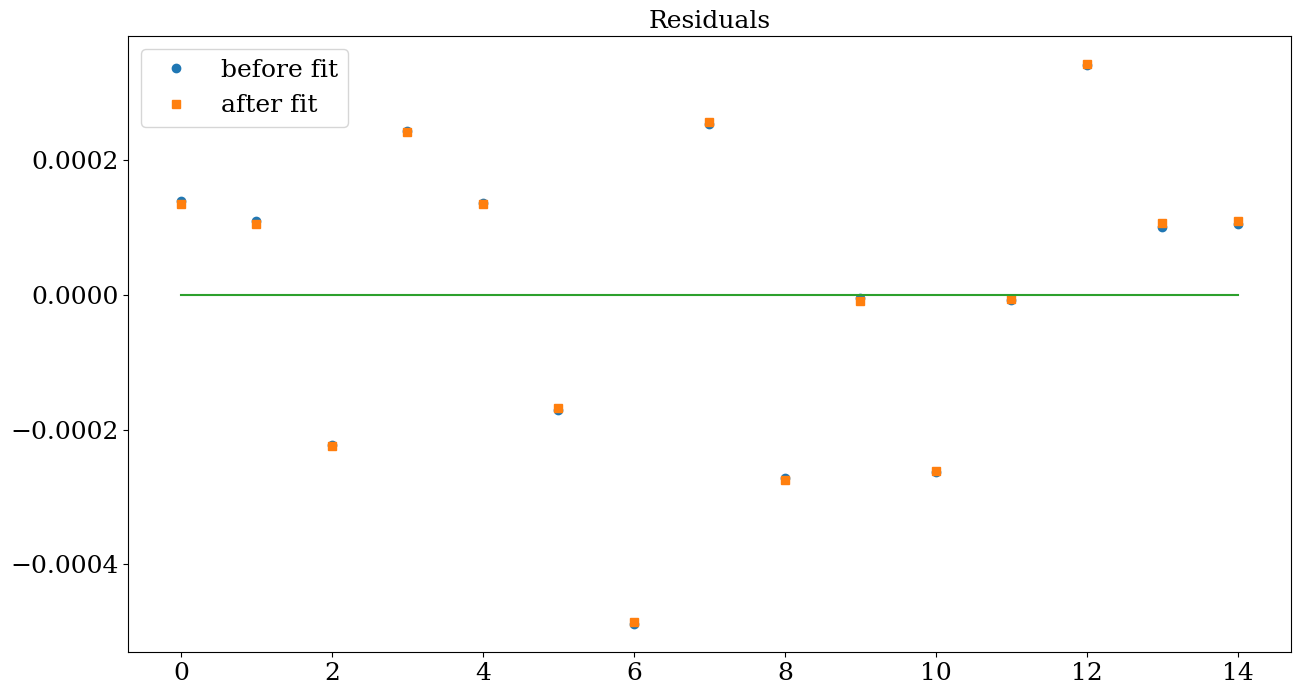

fit residuals standard deviation 0.00022695559449586346
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.726e-07 redchi=5.519e-08 params={'Gamma_prime_g': 0.0006675035302130097}
  iter 0: chisqr=7.726e-07 redchi=5.519e-08 params={'Gamma_prime_g': 0.0006675035302130097}
  iter 1: chisqr=7.726e-07 redchi=5.519e-08 params={'Gamma_prime_g': 0.0006675035302130097}
  iter 2: chisqr=7.726e-07 redchi=5.519e-08 params={'Gamma_prime_g': 0.0006675102052483119}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'Gamma_prime_g': 0.0006836933867264779}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'Gamma_prime_g': 0.0006836933867264779}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002782691 (fixed)
    Gamma_prime_g:  6.8369e-04 +/- 2.9379e-04 (42.97%) (init = 0.0006675035)
    qG_g:           0.0004180153 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002546297 (fixed)
    e2Qq0_g:       -0.1083478 (fixed)
    muE_g:          1.08737 (fixed)
    g_

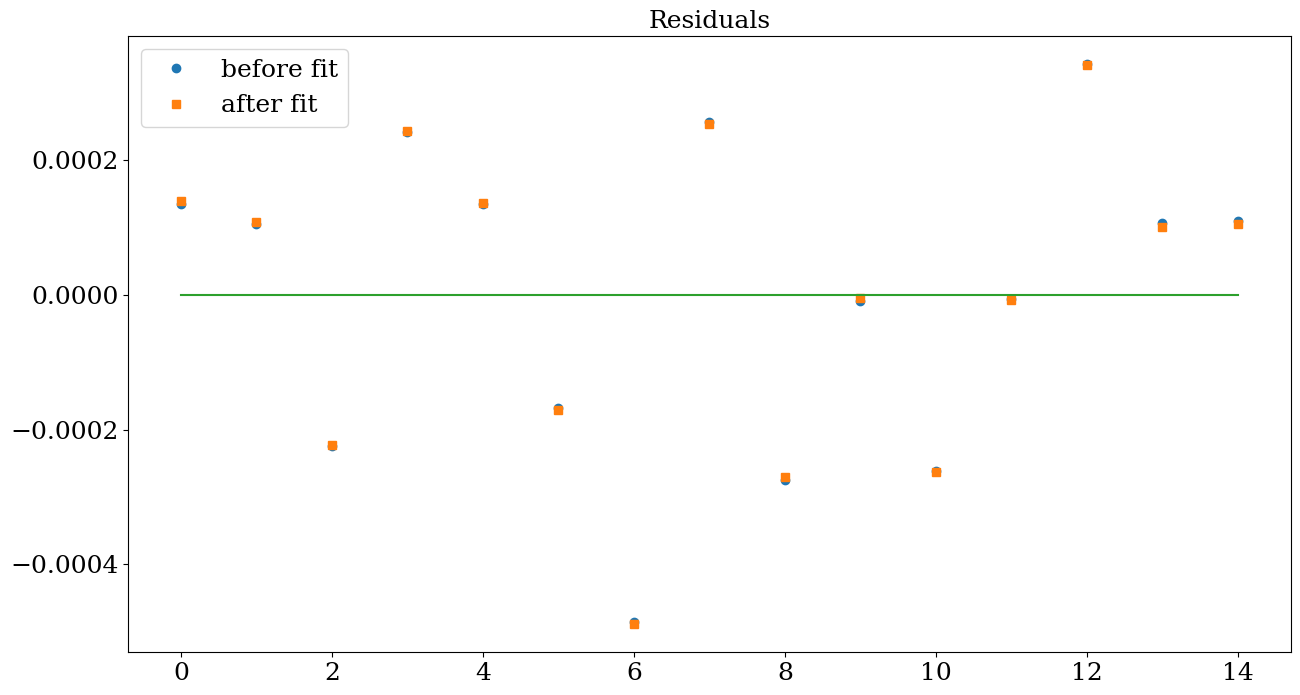

fit residuals standard deviation 0.00022693148132556422
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.725e-07 redchi=5.518e-08 params={'qG_g': 0.0004180152602840204}
  iter 0: chisqr=7.725e-07 redchi=5.518e-08 params={'qG_g': 0.0004180152602840204}
  iter 1: chisqr=7.725e-07 redchi=5.518e-08 params={'qG_g': 0.0004180152602840204}
  iter 2: chisqr=7.725e-07 redchi=5.518e-08 params={'qG_g': 0.00041801944043662326}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'qG_g': 0.0004180739254080752}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'qG_g': 0.0004180739254080752}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002782691 (fixed)
    Gamma_prime_g:  0.0006836934 (fixed)
    qG_g:           4.1807e-04 +/- 6.0697e-05 (14.52%) (init = 0.0004180153)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002546297 (fixed)
    e2Qq0_g:       -0.1083478 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:

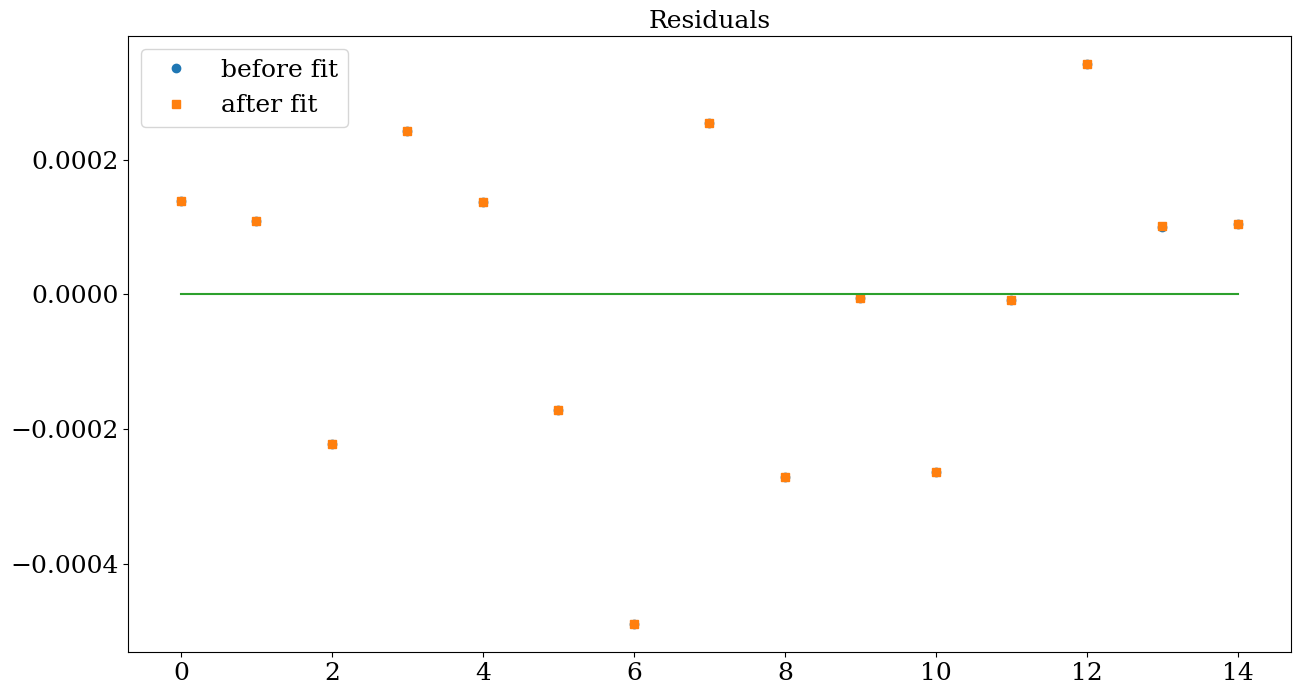

fit residuals standard deviation 0.00022693147696118662
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating pG2qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.725e-07 redchi=5.518e-08 params={'pG2qG_g': 0.00043644264696723976}
  iter 0: chisqr=7.725e-07 redchi=5.518e-08 params={'pG2qG_g': 0.00043644264696723976}
  iter 1: chisqr=7.725e-07 redchi=5.518e-08 params={'pG2qG_g': 0.00043644264696723976}
  iter 2: chisqr=7.725e-07 redchi=5.518e-08 params={'pG2qG_g': 0.00043644701139370945}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'pG2qG_g': 0.00043697585873966454}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'pG2qG_g': 0.00043644264696723976}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002782691 (fixed)
    Gamma_prime_g:  0.0006836934 (fixed)
    qG_g:           0.0004180739 (fixed)
    pG2qG_g:        4.3644e-04 +/- 2.9371e-04 (67.30%) (init = 0.0004364426)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002546297 (fixed)
    e2Qq0_g:       -0.1083478 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
Non

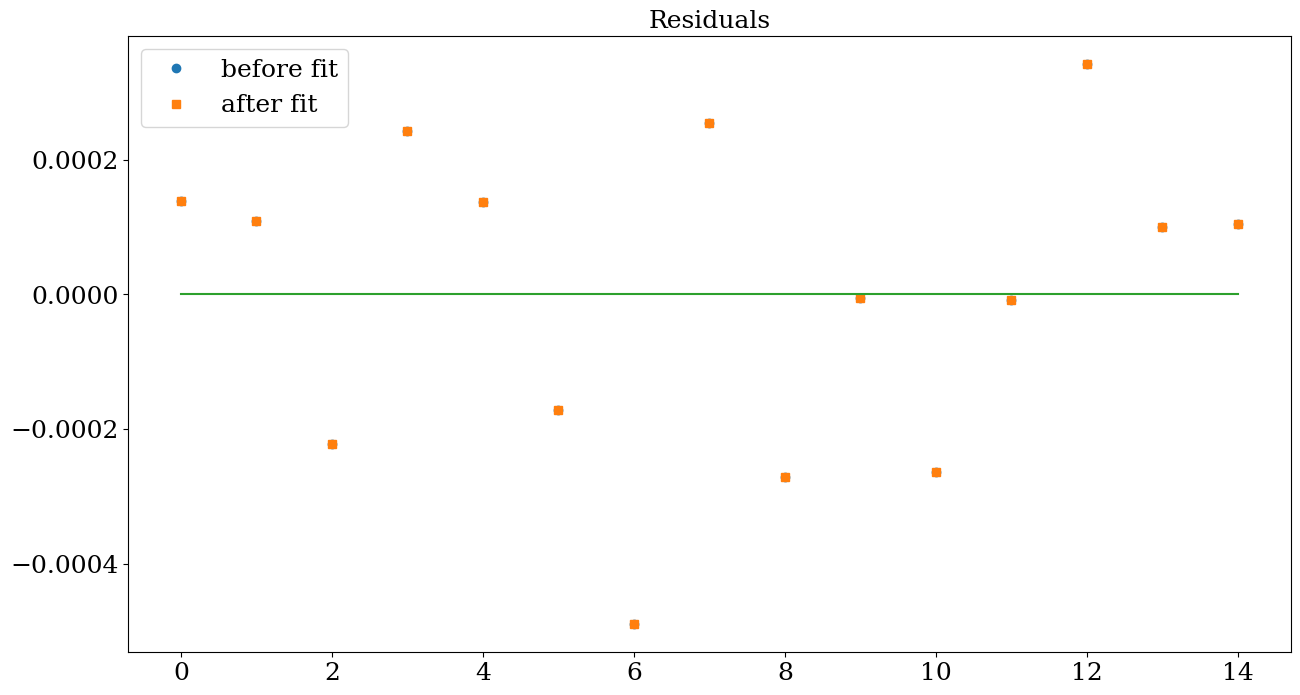

fit residuals standard deviation 0.00022693147696118662
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Torg ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.725e-07 redchi=5.518e-08 params={'Torg_g': 319.91728173577997}
  iter 0: chisqr=7.725e-07 redchi=5.518e-08 params={'Torg_g': 319.91728173577997}
  iter 1: chisqr=7.725e-07 redchi=5.518e-08 params={'Torg_g': 319.91728173577997}
  iter 2: chisqr=0.0001543 redchi=1.102e-05 params={'Torg_g': 319.9204809085973}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'Torg_g': 319.91728172266943}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'Torg_g': 319.91728172266943}
[[Variables]]
    Torg_g:         319.917282 +/- 6.0650e-05 (0.00%) (init = 319.9173)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002782691 (fixed)
    Gamma_prime_g:  0.0006836934 (fixed)
    qG_g:           0.0004180739 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002546297 (fixed)
    e2Qq0_g:       -0.1083478 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.51763

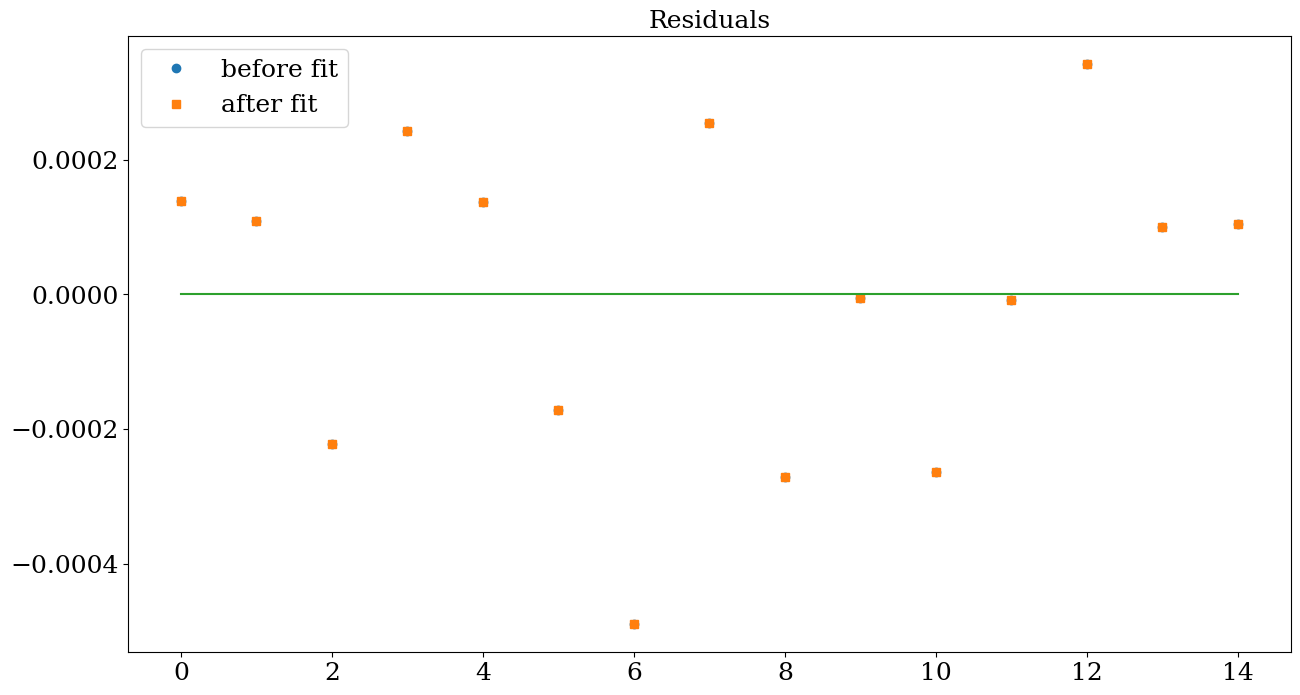

fit residuals standard deviation 0.00022693147674715465
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating e2Qq0 ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.725e-07 redchi=5.518e-08 params={'e2Qq0_g': -0.1083477618464861}
  iter 0: chisqr=7.725e-07 redchi=5.518e-08 params={'e2Qq0_g': -0.1083477618464861}
  iter 1: chisqr=7.725e-07 redchi=5.518e-08 params={'e2Qq0_g': -0.1083477618464861}
  iter 2: chisqr=7.725e-07 redchi=5.518e-08 params={'e2Qq0_g': -0.10834667836886763}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'e2Qq0_g': -0.10834698484437028}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'e2Qq0_g': -0.10834698484437028}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002782691 (fixed)
    Gamma_prime_g:  0.0006836934 (fixed)
    qG_g:           0.0004180739 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.002546297 (fixed)
    e2Qq0_g:       -0.10834698 +/- 0.00101021 (0.93%) (init = -0.1083478)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi 

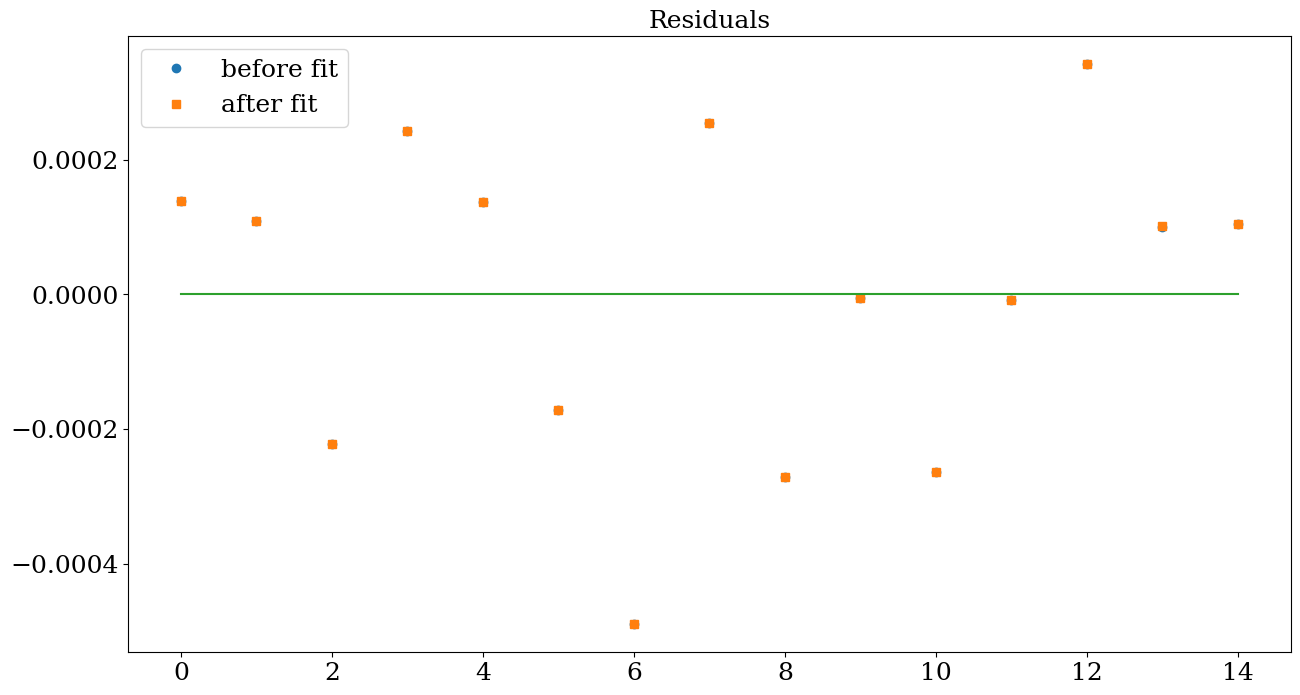

fit residuals standard deviation 0.00022693147223474744
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating c ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.725e-07 redchi=5.518e-08 params={'c_g': -0.002546296634843867}
  iter 0: chisqr=7.725e-07 redchi=5.518e-08 params={'c_g': -0.002546296634843867}
  iter 1: chisqr=7.725e-07 redchi=5.518e-08 params={'c_g': -0.002546296634843867}
  iter 2: chisqr=7.725e-07 redchi=5.518e-08 params={'c_g': -0.002546271171877519}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'c_g': -0.002546894856166736}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'c_g': -0.002546894856166736}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002782691 (fixed)
    Gamma_prime_g:  0.0006836934 (fixed)
    qG_g:           0.0004180739 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278076 (fixed)
    c_g:           -0.00254689 +/- 3.7757e-04 (14.82%) (init = -0.002546297)
    e2Qq0_g:       -0.108347 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.517

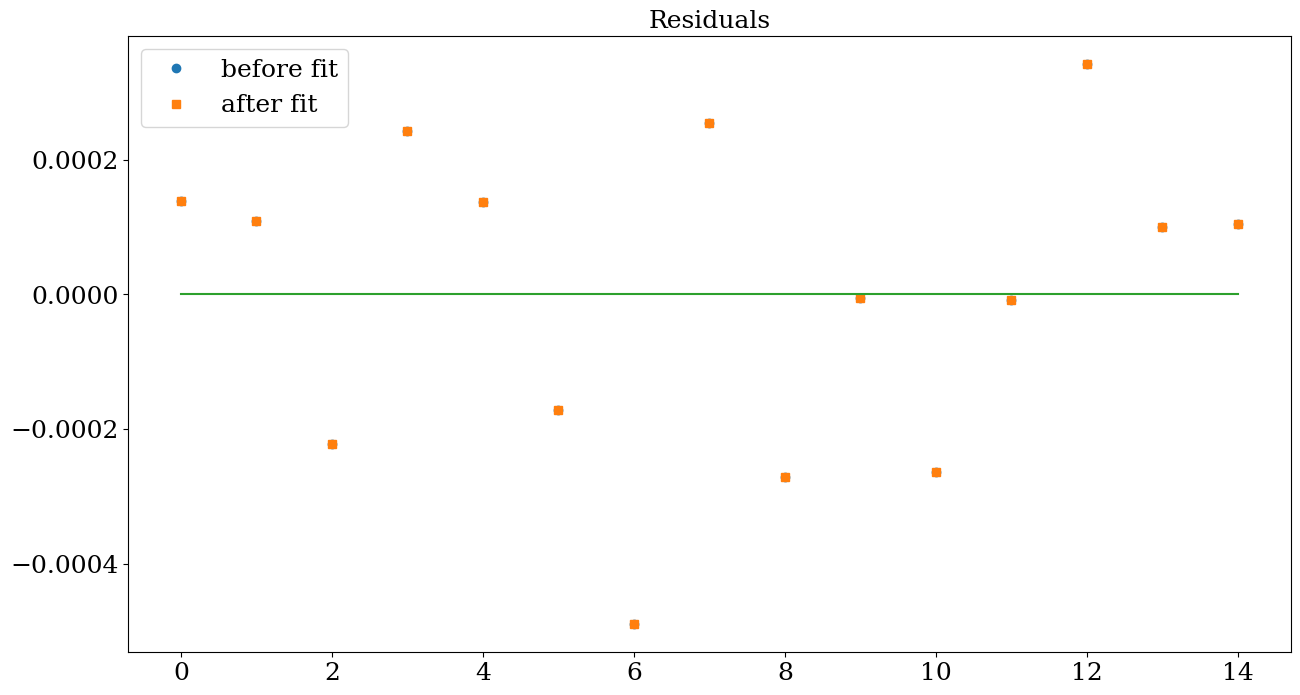

fit residuals standard deviation 0.0002269314505855189
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating bF ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.725e-07 redchi=5.518e-08 params={'bF_g': -0.06278075995884391}
  iter 0: chisqr=7.725e-07 redchi=5.518e-08 params={'bF_g': -0.06278075995884391}
  iter 1: chisqr=7.725e-07 redchi=5.518e-08 params={'bF_g': -0.06278075995884391}
  iter 2: chisqr=7.725e-07 redchi=5.518e-08 params={'bF_g': -0.06278013215124433}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'bF_g': -0.06278074784683882}
  iter 3: chisqr=7.725e-07 redchi=5.518e-08 params={'bF_g': -0.06278074784683882}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002782691 (fixed)
    Gamma_prime_g:  0.0006836934 (fixed)
    qG_g:           0.0004180739 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278075 +/- 3.9475e-05 (0.06%) (init = -0.06278076)
    c_g:           -0.002546895 (fixed)
    e2Qq0_g:       -0.108347 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared:  5.5176

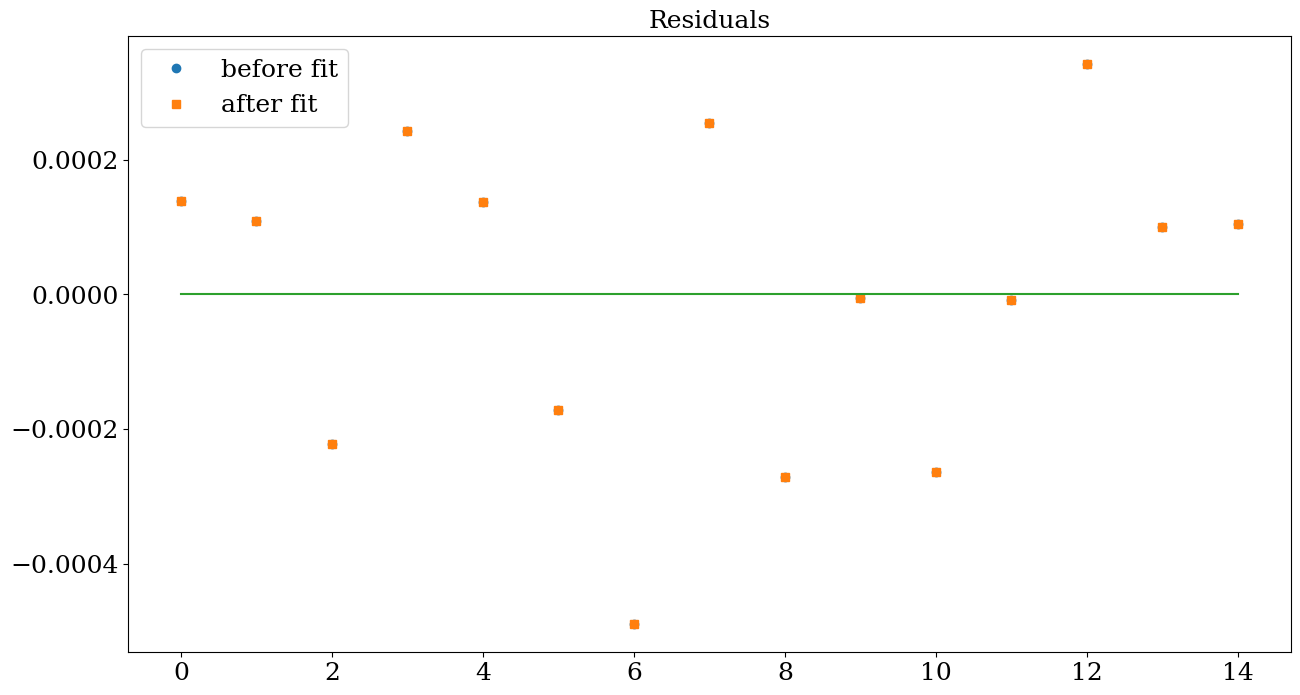

fit residuals standard deviation 0.00022693144989320072
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_SR ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.725e-07 redchi=5.518e-08 params={'Gamma_SR_g': -0.002782691117797522}
  iter 0: chisqr=7.725e-07 redchi=5.518e-08 params={'Gamma_SR_g': -0.002782691117797522}
  iter 1: chisqr=7.725e-07 redchi=5.518e-08 params={'Gamma_SR_g': -0.002782691117797522}
  iter 2: chisqr=7.725e-07 redchi=5.518e-08 params={'Gamma_SR_g': -0.002782663290886344}
  iter 3: chisqr=7.723e-07 redchi=5.516e-08 params={'Gamma_SR_g': -0.0027993492244130697}
  iter 3: chisqr=7.723e-07 redchi=5.516e-08 params={'Gamma_SR_g': -0.0027993492244130697}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.00279935 +/- 3.0284e-04 (10.82%) (init = -0.002782691)
    Gamma_prime_g:  0.0006836934 (fixed)
    qG_g:           0.0004180739 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278075 (fixed)
    c_g:           -0.002546895 (fixed)
    e2Qq0_g:       -0.108347 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.

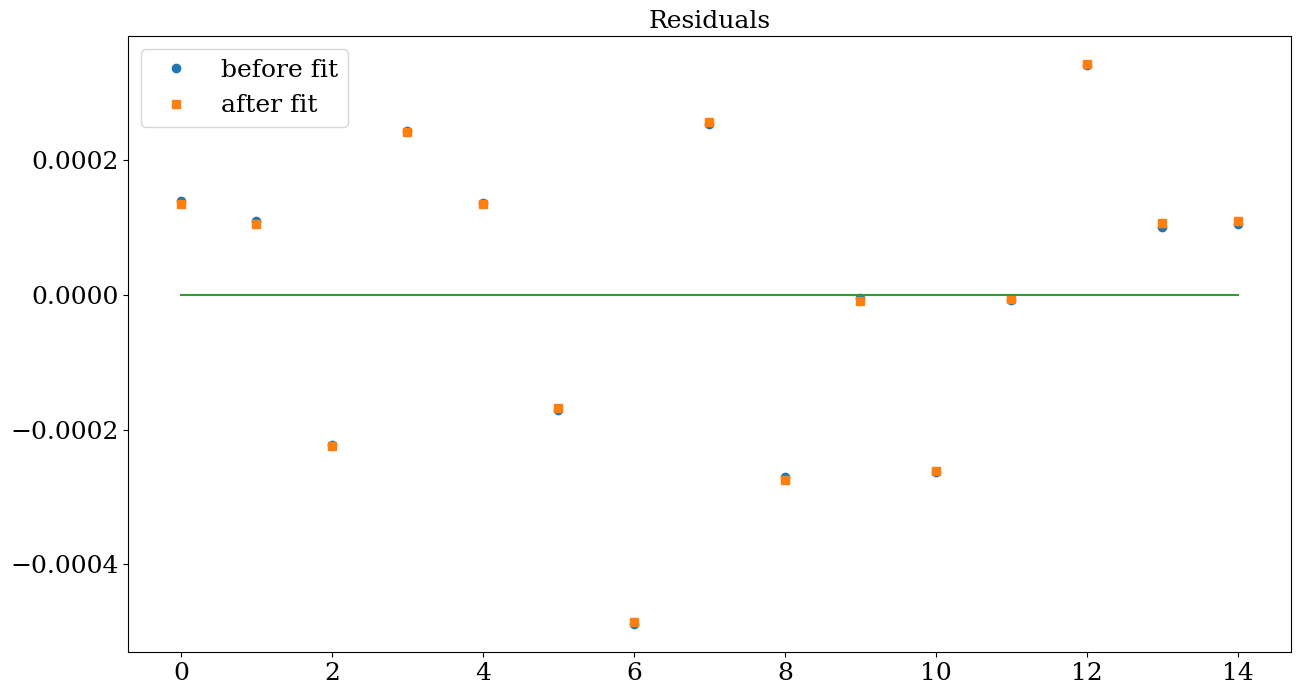

fit residuals standard deviation 0.00022690700186560843
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating Gamma_prime ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.723e-07 redchi=5.516e-08 params={'Gamma_prime_g': 0.0006836933867264779}
  iter 0: chisqr=7.723e-07 redchi=5.516e-08 params={'Gamma_prime_g': 0.0006836933867264779}
  iter 1: chisqr=7.723e-07 redchi=5.516e-08 params={'Gamma_prime_g': 0.0006836933867264779}
  iter 2: chisqr=7.723e-07 redchi=5.516e-08 params={'Gamma_prime_g': 0.0006837002236603451}
  iter 3: chisqr=7.721e-07 redchi=5.515e-08 params={'Gamma_prime_g': 0.0006994694627152824}
  iter 3: chisqr=7.721e-07 redchi=5.515e-08 params={'Gamma_prime_g': 0.0006994694627152824}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002799349 (fixed)
    Gamma_prime_g:  6.9947e-04 +/- 2.9384e-04 (42.01%) (init = 0.0006836934)
    qG_g:           0.0004180739 (fixed)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278075 (fixed)
    c_g:           -0.002546895 (fixed)
    e2Qq0_g:       -0.108347 (fixed)
    muE_g:          1.08737 (fixed)
    g_S

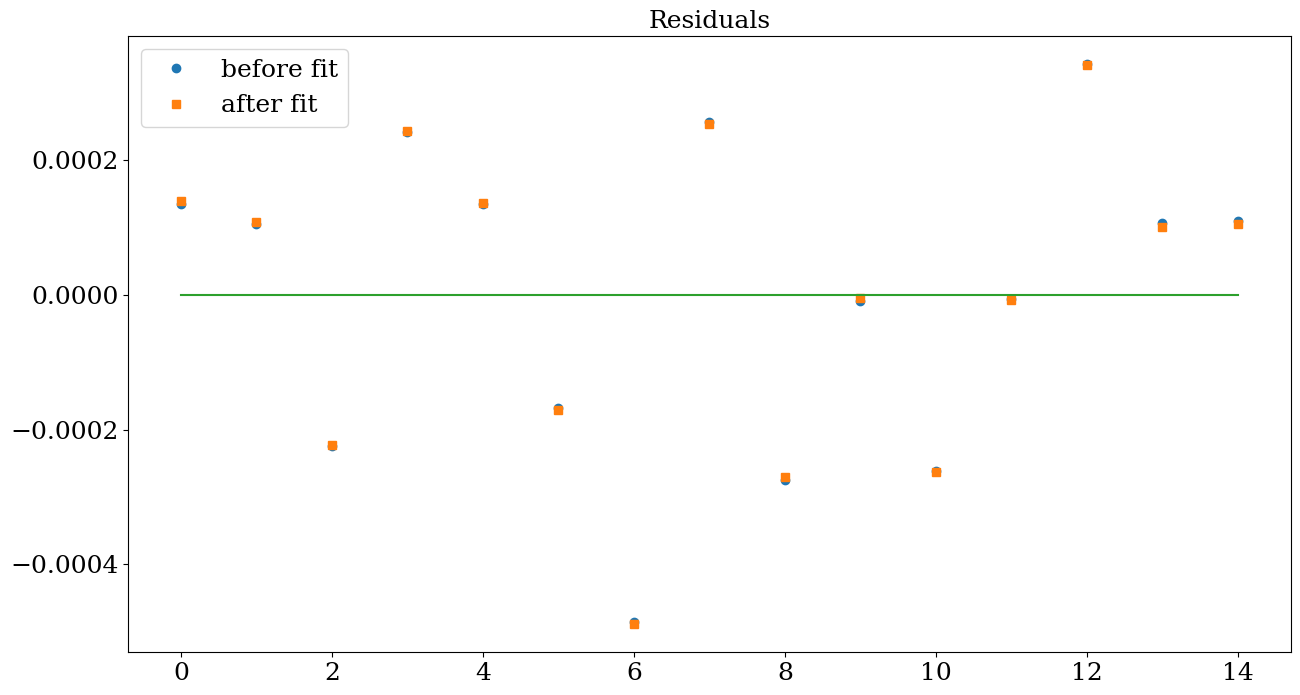

fit residuals standard deviation 0.0002268830494126715
  Residual std: 2.27e-04 (threshold: 1.00e-05)
--- Floating qG ---


c:\Users\kyoto\anaconda3\Lib\site-packages\lmfit\minimizer.py:2326: RuntimeWarning: ignoring `maxfev` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


  iter -1: chisqr=7.721e-07 redchi=5.515e-08 params={'qG_g': 0.0004180739254080752}
  iter 0: chisqr=7.721e-07 redchi=5.515e-08 params={'qG_g': 0.0004180739254080752}
  iter 1: chisqr=7.721e-07 redchi=5.515e-08 params={'qG_g': 0.0004180739254080752}
  iter 2: chisqr=7.721e-07 redchi=5.515e-08 params={'qG_g': 0.00041807810614732927}
  iter 3: chisqr=7.721e-07 redchi=5.515e-08 params={'qG_g': 0.00041815239661532194}
  iter 3: chisqr=7.721e-07 redchi=5.515e-08 params={'qG_g': 0.00041815239661532194}
[[Variables]]
    Torg_g:         319.9173 (fixed)
    Be_g:           0.2446402 (fixed)
    Gamma_SR_g:    -0.002799349 (fixed)
    Gamma_prime_g:  0.0006994695 (fixed)
    qG_g:           4.1815e-04 +/- 6.0686e-05 (14.51%) (init = 0.0004180739)
    pG2qG_g:        0.0004364426 (fixed)
    bF_g:          -0.06278075 (fixed)
    c_g:           -0.002546895 (fixed)
    e2Qq0_g:       -0.108347 (fixed)
    muE_g:          1.08737 (fixed)
    g_S_eff_g:      2.07 (fixed)
None

reduced chi squared

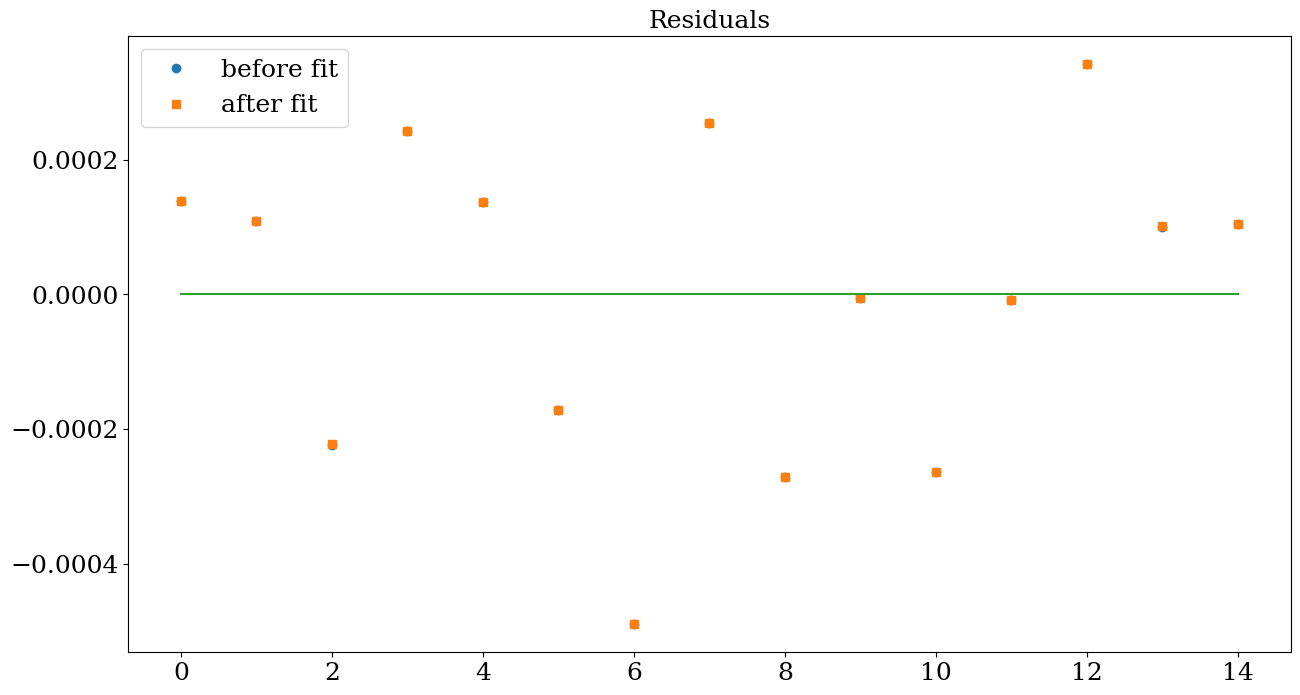

fit residuals standard deviation 0.00022688304305899082


KeyboardInterrupt: 

In [121]:
params_g = {
    'Torg': [319.917282, 'fix'],
    'Be': [0.24464015, 'fix'],
    'Gamma_SR': [-0.00213790, 'fix'],
    'Gamma_prime': [4.7479e-04, 'fix'],
    'qG': [4.1754e-04, 'fix'],
    'pG2qG': [4.3419e-04, 'fix'],
    'bF': [-0.06280159, 'fix'],
    'c': [-0.00268016, 'fix'],
    'e2Qq0': [-0.1080487, 'fix'],
    'muE': [2.16*0.503412, 'fix'],
    'g_S_eff': [2.07, 'fix'],
}


# Iterative fit: float one parameter at a time, cycling through the list until resid_std < threshold
# Order: [Torg, e2Qq0, c, bF, Gamma_SR, qG, pG2qG] -> repeat until converged
from copy import deepcopy

params_g_float_order = ['e2Qq0', 'c', 'bF', 'Gamma_SR', 'Gamma_prime','qG', 'pG2qG', 'Torg']
residual_threshold = 1e-5  # adjust as needed (fit residual std in cm^-1)

params_g_work = deepcopy(params_g)
result_iter = None
resid_std = np.inf  # ensure we enter the loop

while resid_std >= residual_threshold:
    for param_name in params_g_float_order:
        if param_name not in params_g_work:
            print(f'Skipping {param_name} (not in params_g)')
            continue
        # Set only this param to float, all others to fix
        for k in params_g_work:
            params_g_work[k][1] = 'fix'
        params_g_work[param_name][1] = 'float'
        
        p = create_fit_parameters(params_g_work, params_e)
        print(f'--- Floating {param_name} ---')
        result_iter = fit_spectrum(
            p, Assignments, All_excited_states_assignments, 4,
            compute_ground_energy_fn=compute_ground_energy,
            isotope=173, verbose=True, fit_kws={'ftol': 1e-3, 'xtol': 1e-3, 'maxfev': 100}, plot_res=True)
        
        post_fit_res = spectrum_residuals_lmfit(
            result_iter.params, Assignments, All_excited_states_assignments, 4, None,
            isotope=173, TDM_type='aBJ No M Yuiki', compute_ground_energy_fn=compute_ground_energy)
        resid_std = np.std(post_fit_res)
        print(f'  Residual std: {resid_std:.2e} (threshold: {residual_threshold:.2e})')
        
        # Update params_g_work with fit values for next iteration
        for k in params_g_work:
            key_g = k + '_g'
            if key_g in result_iter.params:
                params_g_work[k][0] = result_iter.params[key_g].value
        
        if resid_std < residual_threshold:
            print(f'Residual below threshold. Stopping after floating {param_name}.')
            break
    else:
        # Full cycle completed without meeting threshold; while will loop again
        continue
    break  # threshold met, exit while

result = result_iter  # use for downstream (examine_residuals, etc.)

In [111]:
# Analyze residuals after fit (run cell 22 first)
# examine_residuals returns per-line data: observed freq, residual (MHz), ground/excited state QNs
res_data = examine_residuals(
    result.params,              # best-fit params from fit_spectrum
    Assignments,
    All_excited_states_assignments,
    Temp=4,                     # same as fit_spectrum
    compute_ground_energy_fn=compute_ground_energy,
    print_output=True,
    isotope=173,
)
# res_data is a list of dicts: {'Line': freq_MHz, 'Residual': obs-pred, 'ground state': {...}, 'excited state': {...}}

{'Line': 17331.78072479318, 'Pred': 17331.78063847748, 'Residual': 8.631570017314516e-05, 'ground state': {'N': 1, 'G': 3.0, 'F': 4, 'Parity': 1}, 'excited state': {'J': 1.5, 'F': 3, 'Parity': -1}}


{'Line': 17331.78072479318, 'Pred': 17331.78063847748, 'Residual': 8.631570017314516e-05, 'ground state': {'N': 1, 'G': 3.0, 'F': 4, 'Parity': 1}, 'excited state': {'J': 1.5, 'F': 3, 'Parity': -1}}


{'Line': 17331.78072479318, 'Pred': 17331.78063847748, 'Residual': 8.631570017314516e-05, 'ground state': {'N': 1, 'G': 3.0, 'F': 4, 'Parity': 1}, 'excited state': {'J': 1.5, 'F': 3, 'Parity': -1}}


{'Line': 17331.78072479318, 'Pred': 17331.78063847748, 'Residual': 8.631570017314516e-05, 'ground state': {'N': 1, 'G': 3.0, 'F': 4, 'Parity': 1}, 'excited state': {'J': 1.5, 'F': 3, 'Parity': -1}}


{'Line': 17331.78072479318, 'Pred': 17331.78063847748, 'Residual': 8.631570017314516e-05, 'ground state': {'N': 1, 'G': 3.0, 'F': 4, 'Parity': 1}, 'excited state': {'J': 1.5, 'F': 3, 'Parity': -1}}




In [92]:
result

In [ ]:


# Quick check before fitting (set relaxed=True to run fit anyway and just verify code runs)
def _quick_fit_check(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope=173, relaxed=False):
    """Run quick sanity checks; raises or prints issues. If relaxed=True, only fail on exceptions."""
    n_vary = sum(1 for v in p.values() if getattr(v, 'vary', True))
    issues = []
    try:
        Transitions, freqs, _ = compute_transitions(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope)
    except Exception as e:
        issues.append(f"compute_transitions failed: {e}")
        print("❌ Check FAILED:", issues[-1])
        return False
    n_matched = len(Transitions)
    n_unmatched = len(Assignments) - n_matched
    if n_unmatched > 0:
        issues.append(f"{n_unmatched} assignment(s) have no matching excited state in All_excited_states_assignments")
    if n_matched < n_vary:
        issues.append(f"Only {n_matched} lines matched (need >= {n_vary} for {n_vary} varying parameters)")
    if issues:
        if relaxed:
            print("⚠ Relaxed mode: running fit anyway (may fail or be underconstrained):")
            for i in issues:
                print("  -", i)
            return True
        print("❌ Check FAILED:")
        for i in issues:
            print("  -", i)
        return False
    print(f"✓ Quick check OK: {n_matched} lines matched, {n_vary} varying params")
    return True

if _quick_fit_check(p, Assignments, All_excited_states_assignments, compute_ground_energy, isotope=173, relaxed=True):
    result = fit_spectrum(
        p, Assignments, All_excited_states_assignments, 4,
        compute_ground_energy_fn=compute_ground_energy,
        isotope=173, verbose=True, fit_kws={'ftol': 1e-3, 'xtol': 1e-3, 'maxfev': 100}, plot_res=True)
else:
    print("Fix the issues above before running the fit.")